## All The Answers to the Questions are at last of the Notebook

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',None)

In [286]:
def calc_t_value(n,mu,xbar,sample_std_devn):
    import numpy as np
    tvalue=(xbar-mu)/(sample_std_devn/np.sqrt(n))
    df=n-1
    return (tvalue,df)

def calc_two_sample_t_value(mu1,n1,x1bar,sample_std_devn1,mu2,n2,x2bar,sample_std_devn2):
    import numpy as np
    tvalue=((x1bar-x2bar)-(mu1-mu2))/np.sqrt(((sample_std_devn1**2)/n1)+((sample_std_devn2**2)/n2))
    nr=(((sample_std_devn1**2)/n1)+((sample_std_devn2**2)/n2))**2
    dr=((((sample_std_devn1**2)/n1)**2)/(n1-1))+((((sample_std_devn2**2)/n2)**2)/(n2-1))
    dof=nr/dr
    return (tvalue,dof)

def calc_oneway_anova_f_value(*groups:list):
    '''
    groups is tuple of list of samples
    '''
    import numpy as np

    all_data=[]
    for group in groups:
        all_data.extend(group)
        grand_mean=np.mean(all_data)

    # calculating SSB
    ssb=0
    for group in groups:
        group_mean=np.mean(group)
        group_size=len(group)
        ssb+=group_size*(group_mean-grand_mean)**2

    # calculating SSW
    ssw=0
    for group in groups:
        group_mean=np.mean(group)
        for val in group:
            ssw+=(val-group_mean)**2

    ## calculating dof
    k=len(groups)
    n=len(all_data)

    dof_b=k-1
    dof_w=n-k

    f_value=(ssb/dof_b)/(ssw/dof_w)
    return (f_value,dof_b,dof_w)
def twoway_anova_test(df,target_col,row_factor,column_factor):
    import pandas as pd
    import numpy as np
    from scipy.stats import f
    grand_mean=df[target_col].mean()
    total_n=len(df)

    row_levels=df[row_factor].unique()
    col_levels=df[column_factor].unique()


    #check for empty cell and storing mean of (row_level,column_level) mean in a dictionary
    empty_cell=[]
    cell_means={}
    datapoints_count={}

    for r in row_levels:
        for c in col_levels:
            sub_df=df[(df[row_factor]==r) & (df[column_factor]==c)]
            if len(sub_df)==0:
                empty_cell.append((r,c))
            else:
                cell_means[(r,c)]=sub_df[target_col].mean()
                datapoints_count[(r,c)]=len(sub_df)

    model='full'
    if len(empty_cell)>0:
        model='reduced'
        print(f'Empty cells found at {empty_cell},performing reduced anova test (No interaction Calculated)')


    print(f'Running Two-Way ANOVA {model}')

    # calculating SSR
    ssr=0
    dof_row=len(row_levels)-1
    for r in row_levels:
        sub_df=df[df[row_factor]==r]
        n_row=len(sub_df)
        row_mean=sub_df[target_col].mean()
        ssr+=n_row*(row_mean-grand_mean)**2

    # calculating SSC
    ssc=0
    dof_col=len(col_levels)-1
    for c in col_levels:
        sub_df=df[df[column_factor]==c]
        n_col=len(sub_df)
        col_mean=sub_df[target_col].mean()
        ssc+=n_col*(col_mean-grand_mean)**2

    ## calculating SSI and SSE
    ssi=0
    sse=0
    dof_interaction=(len(row_levels)-1)*(len(col_levels)-1)

    if model=='full':
        for r in row_levels:
            for c in col_levels:
                sub_df=df[(df[row_factor]==r)&(df[column_factor]==c)]
                n_datapoints=len(sub_df)
                
                row_global_mean=df[df[row_factor]==r][target_col].mean()
                col_gloabl_mean=df[df[column_factor]==c][target_col].mean()

                expected_mean=row_global_mean+col_gloabl_mean-grand_mean
                actual_mean=sub_df[target_col].mean()
                deviation=actual_mean-expected_mean

                ssi+=n_datapoints*(deviation**2)

                for i in sub_df[target_col]:
                    error=(i-actual_mean)**2
                    sse+=error

        dof_error=total_n-len(row_levels)*len(col_levels)

    else:
        ssi=0
        dof_interaction=0
        for idx,row in df.iterrows():
            r=row[row_factor]
            c=row[column_factor]

            row_mean=df[df[row_factor]==r][target_col].mean()
            col_mean=df[df[column_factor]==c][target_col].mean()

            expected=grand_mean-(row_mean-grand_mean)-(col_mean-grand_mean)
            actual=row[target_col]

            sse+=(actual-expected)**2

        dof_error=total_n-1-dof_row-dof_col

    # calculating F-vales and p-values and storing results
    ms_error=sse/dof_error

    results=[]

    #rows
    ms_row=ssr/dof_row
    f_row=ms_row/ms_error
    p_row=1-f.cdf(f_row,dof_row,dof_error)
    results.append([row_factor,ssr,dof_row,ms_row,f_row,p_row])

    #col
    ms_col=ssc/dof_col
    f_col=ms_col/ms_error
    p_col=1-f.cdf(f_col,dof_col,dof_error)
    results.append([column_factor,ssc,dof_col,ms_col,f_col,p_col])

    # interaction when model='full'
    if model=='full':
        ms_inter=ssi/dof_interaction
        f_inter=ms_inter/ms_error
        p_inter=1-f.cdf(f_inter,dof_interaction,dof_error)
        results.append(['interaction',ssi,dof_interaction,ms_inter,f_inter,p_inter])

    results.append(['Error',sse,dof_error,ms_error,np.nan,np.nan])


    result_df=pd.DataFrame(results,columns=('source','ss','dof','ms','f_value','p_value'))
    return result_df

def is_classification_target(df:pd.DataFrame,y, max_unique:int,max_unique_ratio=float):
    """
    Heuristic to decide if target column (y) is categorical.
    Try different approaches to identify numerical and categorical columns.
      See if the column is numeric or not
      Check the number of unique values in the column
        If the number of unique values is less than 10, consider it categorical
        If the fraction of unique values is less than 10%, consider it categorical?
    """
    is_classification=True
    if df[y].dtype=='object':
        is_classification=True
        return is_classification
    number_of_unique_values=df[y].nunique()
    unique_pctage=number_of_unique_values/len(df[df[y].notnull()])
    if (number_of_unique_values<=max_unique) | (unique_pctage<=max_unique_ratio):
        is_classification=True
        return is_classification
    else:
        is_classification=False
        return is_classification
    


def split_columns2(df:pd.DataFrame,max_unique,max_unique_ratio):
    """
    Return lists of numerical and categorical columns.
    Try out different approaches
      Iterate through columns and decide for each
      use df.select_dtypes #include, exclude
    """
    num_cols=[col for col in df.columns.to_list() if not is_classification_target(df,col,max_unique=max_unique,max_unique_ratio=max_unique_ratio) ]
    cat_cols=[col for col in df.columns.to_list() if is_classification_target(df,col,max_unique=max_unique,max_unique_ratio=max_unique_ratio)]
    return num_cols,cat_cols

In [3]:
df=pd.read_csv(r'superstore.csv')

In [4]:
df.head()

Category         City        Country Customer.ID     Customer.Name  \
0  Office Supplies  Los Angeles  United States   LS-172304  Lycoris Saunders   
1  Office Supplies  Los Angeles  United States   MV-174854     Mark Van Huff   
2  Office Supplies  Los Angeles  United States   CS-121304      Chad Sievert   
3  Office Supplies  Los Angeles  United States   CS-121304      Chad Sievert   
4  Office Supplies  Los Angeles  United States   AP-109154    Arthur Prichep   

   Discount Market  记录数 Order.Date        Order.ID Order.Priority  \
0       0.0     US    1    00:00.0  CA-2011-130813           High   
1       0.0     US    1    00:00.0  CA-2011-148614         Medium   
2       0.0     US    1    00:00.0  CA-2011-118962         Medium   
3       0.0     US    1    00:00.0  CA-2011-118962         Medium   
4       0.0     US    1    00:00.0  CA-2011-146969           High   

        Product.ID                                       Product.Name  \
0  OFF-PA-10002005                                          Xerox 225   
1  OFF-PA-10002893          Wirebound Service Call Books, 5 1/2" x 4"   
2  OFF-PA-10000659  Adams Phone Message Book, Professional, 400 Me...   
3  OFF-PA-10001144                                         Xerox 1913   
4  OFF-PA-10002105                                          Xerox 223   

    Profit  Quantity Region  Row.ID  Sales   Segment Ship.Date  \
0   9.3312         3   West   36624     19  Consumer   00:00.0   
1   9.2928         2   West   37033     19  Consumer   00:00.0   
2   9.8418         3   West   31468     21  Consumer   00:00.0   
3  53.2608         2   West   31469    111  Consumer   00:00.0   
4   3.1104         1   West   32440      6  Consumer   00:00.0   

        Ship.Mode  Shipping.Cost       State Sub.Category  Year  \
0    Second Class           4.37  California        Paper  2011   
1  Standard Class           0.94  California        Paper  2011   
2  Standard Class           1.81  California        Paper  2011   
3  Standard Class           4.59  California        Paper  2011   
4  Standard Class           1.32  California        Paper  2011   

         Market2  weeknum  
0  North America        2  
1  North America        4  
2  North America       32  
3  North America       32  
4  North America       40

In [5]:
df['记录数'].unique()

array([1])

In [6]:
df.rename(columns={'记录数':'Number_of_records'},inplace=True)
df.head()

Category         City        Country Customer.ID     Customer.Name  \
0  Office Supplies  Los Angeles  United States   LS-172304  Lycoris Saunders   
1  Office Supplies  Los Angeles  United States   MV-174854     Mark Van Huff   
2  Office Supplies  Los Angeles  United States   CS-121304      Chad Sievert   
3  Office Supplies  Los Angeles  United States   CS-121304      Chad Sievert   
4  Office Supplies  Los Angeles  United States   AP-109154    Arthur Prichep   

   Discount Market  Number_of_records Order.Date        Order.ID  \
0       0.0     US                  1    00:00.0  CA-2011-130813   
1       0.0     US                  1    00:00.0  CA-2011-148614   
2       0.0     US                  1    00:00.0  CA-2011-118962   
3       0.0     US                  1    00:00.0  CA-2011-118962   
4       0.0     US                  1    00:00.0  CA-2011-146969   

  Order.Priority       Product.ID  \
0           High  OFF-PA-10002005   
1         Medium  OFF-PA-10002893   
2         Medium  OFF-PA-10000659   
3         Medium  OFF-PA-10001144   
4           High  OFF-PA-10002105   

                                        Product.Name   Profit  Quantity  \
0                                          Xerox 225   9.3312         3   
1          Wirebound Service Call Books, 5 1/2" x 4"   9.2928         2   
2  Adams Phone Message Book, Professional, 400 Me...   9.8418         3   
3                                         Xerox 1913  53.2608         2   
4                                          Xerox 223   3.1104         1   

  Region  Row.ID  Sales   Segment Ship.Date       Ship.Mode  Shipping.Cost  \
0   West   36624     19  Consumer   00:00.0    Second Class           4.37   
1   West   37033     19  Consumer   00:00.0  Standard Class           0.94   
2   West   31468     21  Consumer   00:00.0  Standard Class           1.81   
3   West   31469    111  Consumer   00:00.0  Standard Class           4.59   
4   West   32440      6  Consumer   00:00.0  Standard Class           1.32   

        State Sub.Category  Year        Market2  weeknum  
0  California        Paper  2011  North America        2  
1  California        Paper  2011  North America        4  
2  California        Paper  2011  North America       32  
3  California        Paper  2011  North America       32  
4  California        Paper  2011  North America       40

In [7]:
df.columns=df.columns.str.lower().str.replace('.','_').str.replace(' ','_')

In [8]:
df.head()

category         city        country customer_id     customer_name  \
0  Office Supplies  Los Angeles  United States   LS-172304  Lycoris Saunders   
1  Office Supplies  Los Angeles  United States   MV-174854     Mark Van Huff   
2  Office Supplies  Los Angeles  United States   CS-121304      Chad Sievert   
3  Office Supplies  Los Angeles  United States   CS-121304      Chad Sievert   
4  Office Supplies  Los Angeles  United States   AP-109154    Arthur Prichep   

   discount market  number_of_records order_date        order_id  \
0       0.0     US                  1    00:00.0  CA-2011-130813   
1       0.0     US                  1    00:00.0  CA-2011-148614   
2       0.0     US                  1    00:00.0  CA-2011-118962   
3       0.0     US                  1    00:00.0  CA-2011-118962   
4       0.0     US                  1    00:00.0  CA-2011-146969   

  order_priority       product_id  \
0           High  OFF-PA-10002005   
1         Medium  OFF-PA-10002893   
2         Medium  OFF-PA-10000659   
3         Medium  OFF-PA-10001144   
4           High  OFF-PA-10002105   

                                        product_name   profit  quantity  \
0                                          Xerox 225   9.3312         3   
1          Wirebound Service Call Books, 5 1/2" x 4"   9.2928         2   
2  Adams Phone Message Book, Professional, 400 Me...   9.8418         3   
3                                         Xerox 1913  53.2608         2   
4                                          Xerox 223   3.1104         1   

  region  row_id  sales   segment ship_date       ship_mode  shipping_cost  \
0   West   36624     19  Consumer   00:00.0    Second Class           4.37   
1   West   37033     19  Consumer   00:00.0  Standard Class           0.94   
2   West   31468     21  Consumer   00:00.0  Standard Class           1.81   
3   West   31469    111  Consumer   00:00.0  Standard Class           4.59   
4   West   32440      6  Consumer   00:00.0  Standard Class           1.32   

        state sub_category  year        market2  weeknum  
0  California        Paper  2011  North America        2  
1  California        Paper  2011  North America        4  
2  California        Paper  2011  North America       32  
3  California        Paper  2011  North America       32  
4  California        Paper  2011  North America       40

In [9]:
df.shape

(51290, 27)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   category           51290 non-null  object 
 1   city               51290 non-null  object 
 2   country            51290 non-null  object 
 3   customer_id        51290 non-null  object 
 4   customer_name      51290 non-null  object 
 5   discount           51290 non-null  float64
 6   market             51290 non-null  object 
 7   number_of_records  51290 non-null  int64  
 8   order_date         51290 non-null  object 
 9   order_id           51290 non-null  object 
 10  order_priority     51290 non-null  object 
 11  product_id         51290 non-null  object 
 12  product_name       51290 non-null  object 
 13  profit             51290 non-null  float64
 14  quantity           51290 non-null  int64  
 15  region             51290 non-null  object 
 16  row_id             512

In [11]:
df.isna().sum()

category             0
city                 0
country              0
customer_id          0
customer_name        0
discount             0
market               0
number_of_records    0
order_date           0
order_id             0
order_priority       0
product_id           0
product_name         0
profit               0
quantity             0
region               0
row_id               0
sales                0
segment              0
ship_date            0
ship_mode            0
shipping_cost        5
state                3
sub_category         0
year                 0
market2              0
weeknum              0
dtype: int64

* most of the columns does not have missing values
    - shipping_cost has only 5 missing values
    - state has 3 missing values

# Univariate Analysis
- Let's first analyze each of the columns

#### Category

In [12]:
df['category'].unique()

array(['Office Supplies', 'Technology', 'Furniture'], dtype=object)

In [13]:
df['category'].value_counts()

category
Office Supplies    31273
Technology         10141
Furniture           9876
Name: count, dtype: int64

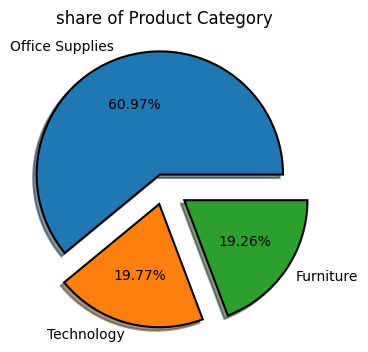

In [14]:
plt.figure(figsize=(4,4))
plt.pie(x=df['category'].value_counts(),
        labels=df['category'].value_counts().index,
        autopct='%1.2f%%',
        explode=np.linspace(0.1,0.2,len(df['category'].unique())),
        shadow=True,
        wedgeprops={'linewidth':1.5,'edgecolor':'black'})
plt.title('share of Product Category')
plt.show()

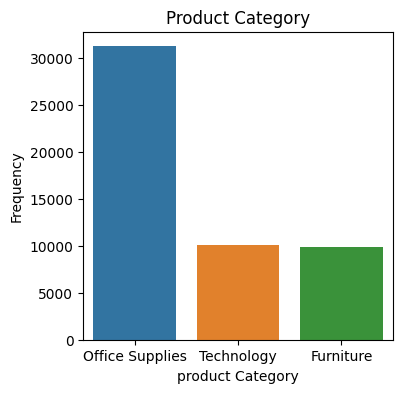

In [ ]:
plt.figure(figsize=(4,4))
plt.pie(x=df['category'].value_counts(),
        labels=df['category'].value_counts().index,
        autopct='%1.2f%%',
        explode=np.linspace(0.1,0.2,len(df['category'].unique())),
        shadow=True,
        wedgeprops={'linewidth':1.5,'edgecolor':'black'})
plt.title('share of Product Category')
plt.show()
plt.figure(figsize=(4,4))
sns.barplot(x=df['category'].value_counts().index,
            y=df['category'].value_counts().values,
            hue=df['category'].value_counts().index)
plt.title('Product Category')
plt.xlabel('product Category')
plt.ylabel('Frequency')
plt.show()

##### analysis:
- product from office_supplies contributes around 61%
- technology and Furniture each contributes around 19%-20%

#### City

In [16]:
df['city']

0        Los Angeles
1        Los Angeles
2        Los Angeles
3        Los Angeles
4        Los Angeles
            ...     
51285    Los Angeles
51286    Los Angeles
51287    Los Angeles
51288    Los Angeles
51289    Los Angeles
Name: city, Length: 51290, dtype: object

In [17]:
df['city'].unique()

array(['Los Angeles', 'San Francisco', 'San Diego', ..., 'Ontario',
       'Whittier', 'Redwood City'], shape=(3636,), dtype=object)

In [18]:
df['city'].nunique()

3636

- there are 3636 cities where superstore is located

In [19]:
city_counts=df['city'].value_counts()

In [20]:
len(city_counts[city_counts.values>=200])

25

In [21]:
len(city_counts[city_counts.values<200])

3611

In [22]:
len(city_counts[city_counts.values==1])

488

- there are 25 cities which received more than 200 orders
- there are 3611 cities which received less than 200 shipments are shipped
- there are 488 cities which received only 1 order

Plotting top 25 cities receiving more than equal to 200 orders

In [23]:
city_plot_data=city_counts.head(25)

In [24]:
city_plot_data

city
New York City    915
Los Angeles      747
Philadelphia     537
San Francisco    510
Santo Domingo    443
Manila           432
Seattle          428
Houston          377
Tegucigalpa      362
Jakarta          337
Managua          336
Lagos            333
Istanbul         314
Chicago          314
Mexico City      300
Bangkok          287
London           281
Sydney           271
Cairo            248
Vienna           245
Melbourne        235
Columbus         222
San Salvador     221
Berlin           217
Gold Coast       201
Name: count, dtype: int64

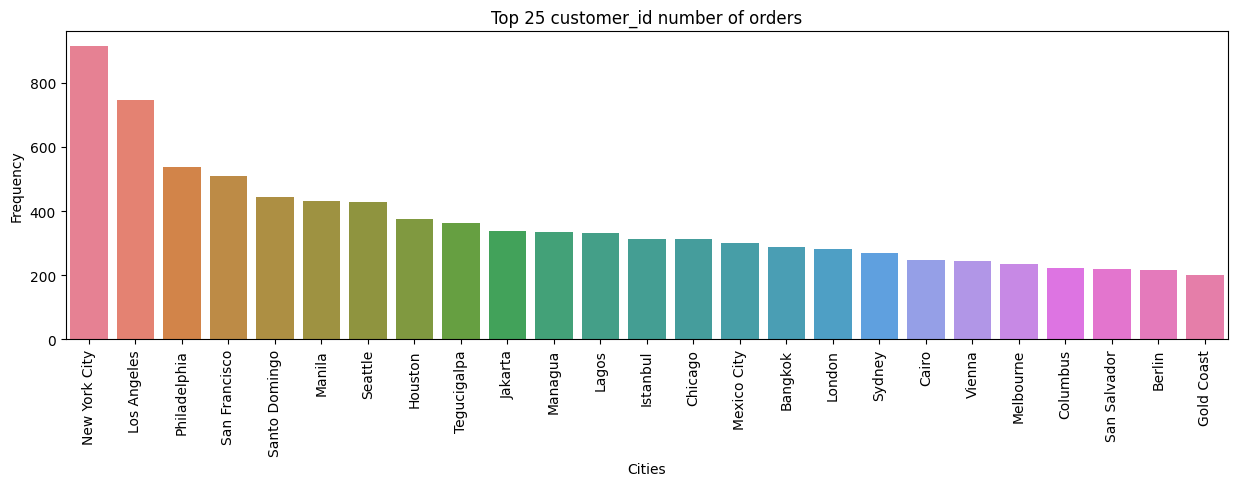

In [25]:
plt.figure(figsize=(15,4))
sns.barplot(x=city_plot_data.index,
            y=city_plot_data.values,
            hue=city_plot_data.index)
plt.title('Top 25 customer_id number of orders')
plt.xlabel('Cities')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

- superstore at New york receives highest number of orders followed by Los Angeles followed by Philadelhia
- top 3 cities receiving the highest number of orders are from USA 

In [26]:
city_counts[city_counts.values==1].index

Index(['Redwood City', 'Vacaville', 'Jupiter', 'Port Orange', 'Kissimmee',
       'Billings', 'Missoula', 'Cheyenne', 'Orland Park', 'Etawah',
       ...
       'Mococa', 'Bistrita', 'Gandia', 'Floriano', 'Vilhena', 'Chapel Hill',
       'Goldsboro', 'Bartlett', 'Ormond Beach', 'Cuneo'],
      dtype='object', name='city', length=488)

### Country

In [27]:
df['country']

0        United States
1        United States
2        United States
3        United States
4        United States
             ...      
51285    United States
51286    United States
51287    United States
51288    United States
51289    United States
Name: country, Length: 51290, dtype: object

In [28]:
df['country'].value_counts()

country
United States    9994
Australia        2837
France           2827
Mexico           2644
Germany          2065
                 ... 
Bahrain             2
Swaziland           2
Eritrea             2
South Sudan         2
Burundi             2
Name: count, Length: 147, dtype: int64

- Dataset contains 147 unique countries where products has been shipped

In [29]:
country_counts=df['country'].value_counts()
country_counts[country_counts.values>=500]

country
United States         9994
Australia             2837
France                2827
Mexico                2644
Germany               2065
China                 1880
United Kingdom        1633
Brazil                1599
India                 1555
Indonesia             1390
Turkey                1378
Italy                 1108
Nigeria                905
Spain                  859
Dominican Republic     742
El Salvador            736
Cuba                   724
Honduras               713
Philippines            681
New Zealand            628
Nicaragua              614
Iran                   607
Guatemala              521
Name: count, dtype: int64

In [30]:
country_plot_data=country_counts[country_counts.values>=500]
others_sum=country_counts[country_counts.values<500].values.sum()
country_plot_data['others']=others_sum

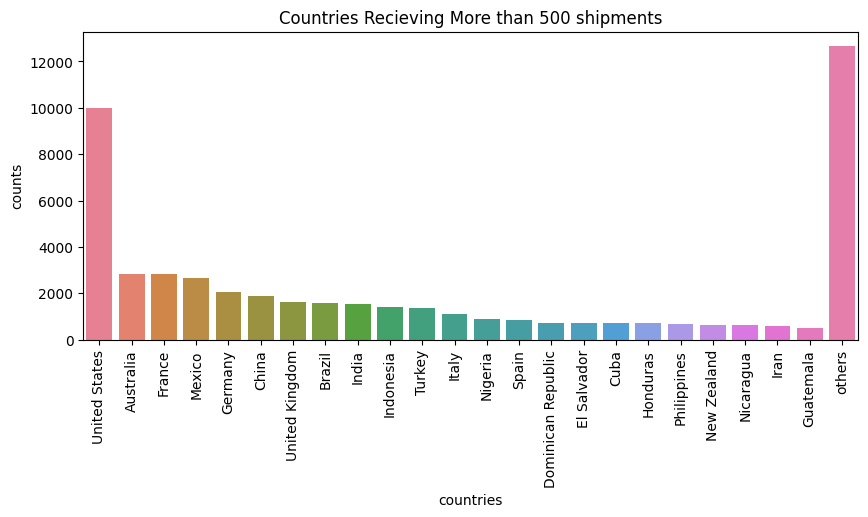

In [31]:
plt.figure(figsize=(10,4))
sns.barplot(x=country_plot_data.index,
            y=country_plot_data.values,
            hue=country_plot_data.index)
plt.title('Countries Recieving More than 500 shipments')
plt.xlabel('countries')
plt.ylabel('counts')
plt.xticks(rotation=90)
plt.show()

- USA recieves the highest number of orders,could be the reason for top 3 cities receiving higest number of orders are American cities
- followed by Australia but the number of orders to Australia is very less than that of USA

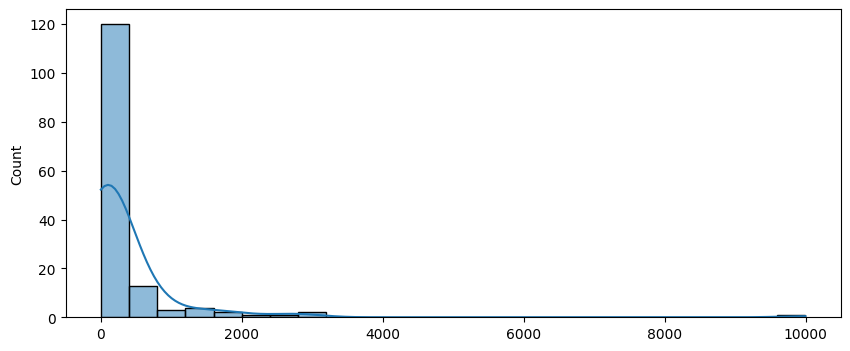

In [32]:
plt.figure(figsize=(10,4))
sns.histplot(country_counts.values,kde=True)
plt.show()

- above plot is countries orders count histogram
- highly positively skewed and mesokurtic

### Customer_id

In [33]:
df['customer_id']

0        LS-172304
1        MV-174854
2        CS-121304
3        CS-121304
4        AP-109154
           ...    
51285    AM-103604
51286    AM-103604
51287    HR-147704
51288    RM-196754
51289    FH-143654
Name: customer_id, Length: 51290, dtype: object

In [34]:
df['customer_id'].nunique()

4873

- this dataset contains 4873 unique customer_id

In [35]:
cust_count=df['customer_id'].value_counts()
plot_data=cust_count.head(20)

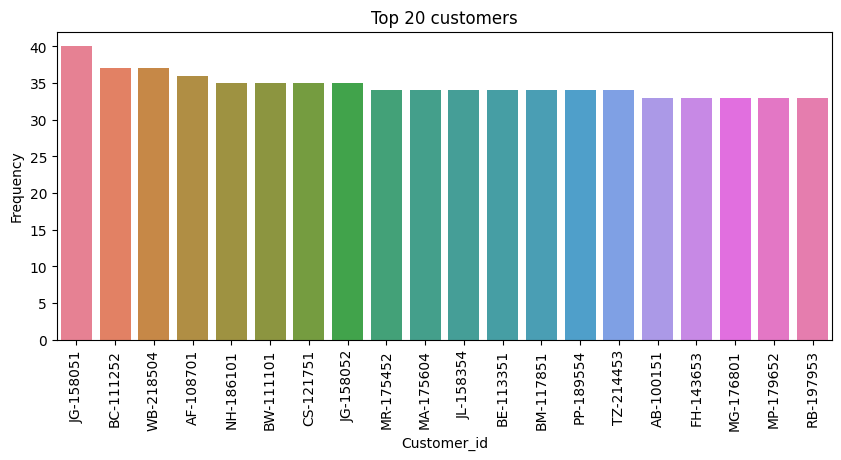

In [36]:
plt.figure(figsize=(10,4))
sns.barplot(x=plot_data.index,
            y=plot_data.values,
            hue=plot_data.index)
plt.title('Top 20 customers')
plt.xlabel('Customer_id')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

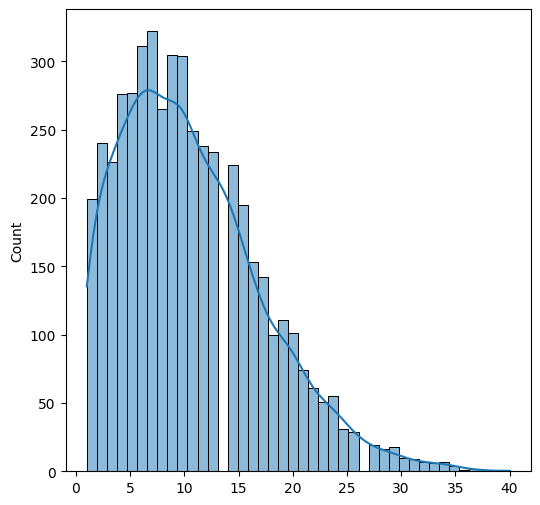

In [37]:
plt.figure(figsize=(6,6))
sns.histplot(cust_count.values,kde=True)
plt.show()

- above plot show the frequency of orders by different customer
- we can see that most of the customers ordered 1 to 15 orders each
- there are customers who's order counts seems to be outlier but those customers are valuable customers as they order more than 30 orders
- histogram is positively skewed and mesokurtic 

### Customer_name

In [38]:
df['customer_name']

0        Lycoris Saunders
1           Mark Van Huff
2            Chad Sievert
3            Chad Sievert
4          Arthur Prichep
               ...       
51285      Alice McCarthy
51286      Alice McCarthy
51287      Hallie Redmond
51288       Robert Marley
51289        Fred Hopkins
Name: customer_name, Length: 51290, dtype: object

In [39]:
df['customer_name'].nunique()

795

* wait!
    - customer_id has 4873 unique values
    - customer_name has only 795 unique values
is there some problem with data?

In [40]:
df['customer_name'].value_counts()

customer_name
Muhammed Yedwab        108
Steven Ward            106
Bill Eplett            102
Gary Hwang             102
Patrick O'Brill        102
                      ... 
Catherine Glotzbach     35
David Bremer            34
Darren Budd             31
Nicole Brennan          31
Michael Oakman          29
Name: count, Length: 795, dtype: int64

customer names are repeated,we need to check combining with customer_id too

In [41]:
df.groupby(['customer_name'],as_index=False).agg(customer_id_count=('customer_id','nunique')).sort_values(by=['customer_id_count'],ascending=False)

customer_name  customer_id_count
4               Adam Hart                  7
10            Alan Barnes                  7
6           Adrian Barton                  7
17        Alejandro Grove                  7
16   Alejandro Ballentine                  7
..                    ...                ...
59          Arthur Gainer                  5
68         Barry Gonzalez                  5
55           Anthony Witt                  5
793      Zuschuss Carroll                  5
5      Adam Shillingsburg                  5

[795 rows x 2 columns]

- this shows that customers are using more than 1 ID's
- is there any fraud going on ?
- we need to check with combining other column values

In [42]:
df['customer_name'].value_counts().head(20)

customer_name
Muhammed Yedwab        108
Steven Ward            106
Bill Eplett            102
Gary Hwang             102
Patrick O'Brill        102
Harry Greene           101
Eric Murdock           100
Art Ferguson            98
Brosina Hoffman         97
Chloris Kastensmidt     96
Bart Watters            96
Natalie Fritzler        95
John Grady              95
Darrin Van Huff         94
Michael Paige           94
Eugene Moren            94
Tom Boeckenhauer        93
Karl Braun              93
Noel Staavos            92
Paul Gonzalez           92
Name: count, dtype: int64

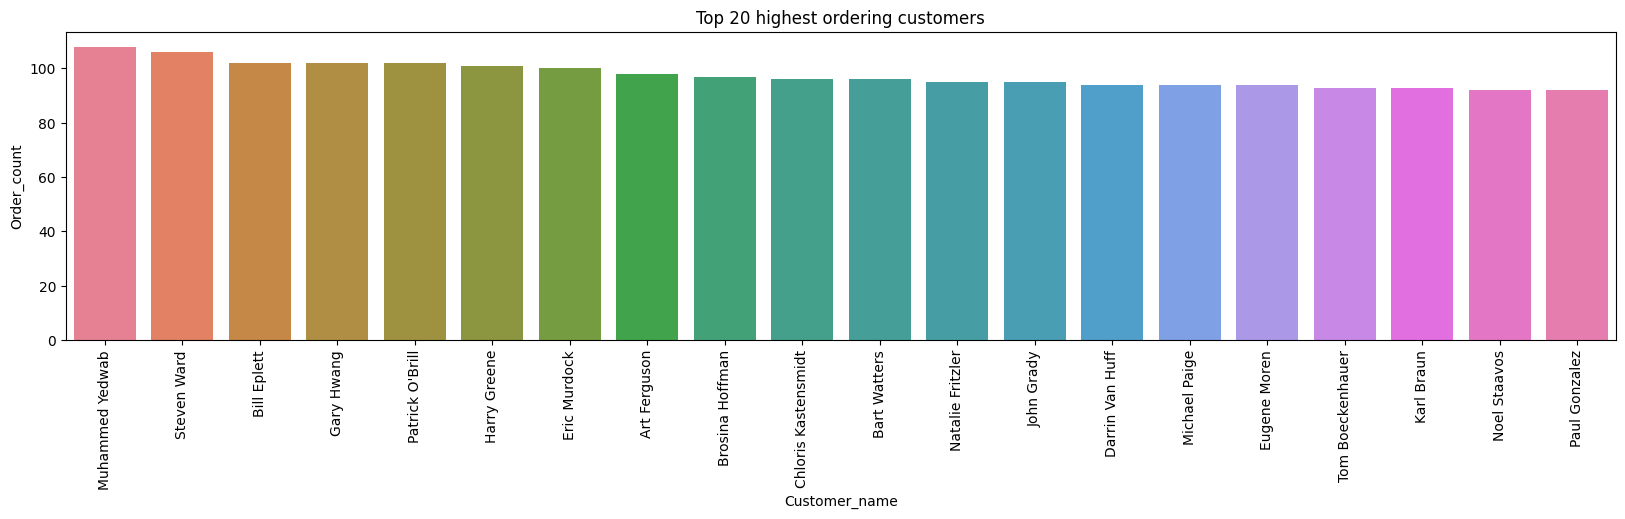

In [43]:
plt.figure(figsize=(20,4))
sns.barplot(x=df['customer_name'].value_counts().head(20).index,
            y=df['customer_name'].value_counts().head(20).values,
            hue=df['customer_name'].value_counts().head(20).index)
plt.title("Top 20 highest ordering customers")
plt.xlabel('Customer_name')
plt.ylabel('Order_count')
plt.xticks(rotation=90)
plt.show()

In [44]:
df['customer_name'].value_counts().tail(20).sort_values()

customer_name
Michael Oakman         29
Darren Budd            31
Nicole Brennan         31
David Bremer           34
Catherine Glotzbach    35
Andy Reiter            35
Emily Burns            35
Brendan Dodson         36
Jocasta Rupert         36
Vivian Mathis          36
Sibella Parks          36
Shirley Schmidt        36
Eileen Kiefer          36
Roland Murray          37
Thomas Brumley         38
Katherine Ducich       39
Ionia McGrath          39
Amy Cox                39
Amy Hunt               39
Paul Knutson           39
Name: count, dtype: int64

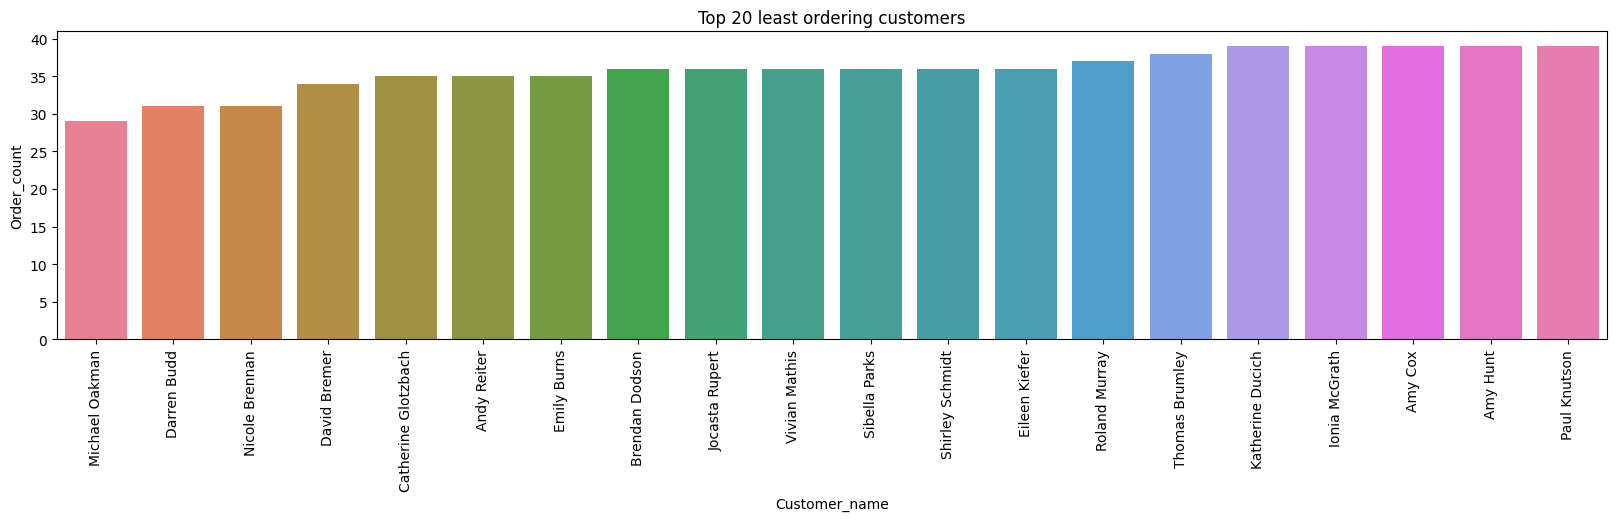

In [45]:
plt.figure(figsize=(20,4))
sns.barplot(x=df['customer_name'].value_counts().tail(20).sort_values().index,
            y=df['customer_name'].value_counts().tail(20).sort_values().values,
            hue=df['customer_name'].value_counts().tail(20).sort_values().index)
plt.title("Top 20 least ordering customers")
plt.xlabel('Customer_name')
plt.ylabel('Order_count')
plt.xticks(rotation=90)
plt.show()

- customer's who are placing more number of orders should be given some attractive offers to keep them engaged with us
- customer's who are placing less number of orders should be given some attractive offers to  engage then with us more

### Discount

In [46]:
df['discount']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
51285    0.2
51286    0.2
51287    0.2
51288    0.2
51289    0.2
Name: discount, Length: 51290, dtype: float64

In [47]:
df['discount'].value_counts()

discount
0.000    29009
0.200     4998
0.100     4068
0.400     3177
0.600     2006
0.700     1786
0.500     1633
0.170      735
0.470      725
0.150      541
0.002      461
0.270      388
0.300      340
0.450      327
0.800      316
0.250      198
0.070      150
0.350      122
0.402      104
0.370       74
0.202       41
0.320       27
0.602       23
0.650       17
0.570       12
0.550       10
0.850        2
Name: count, dtype: int64

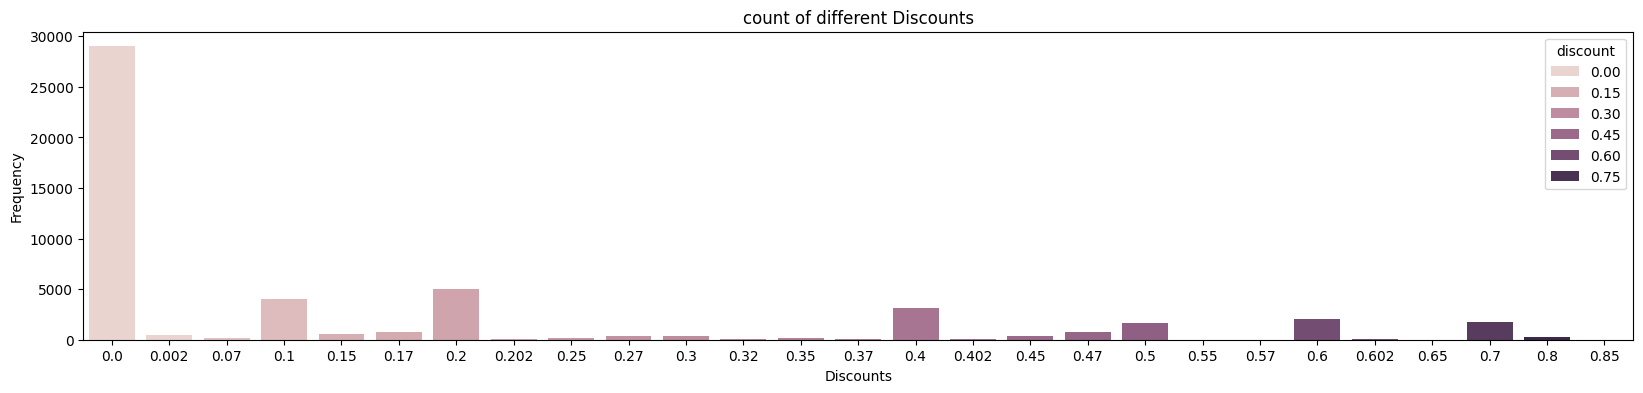

In [48]:
plt.figure(figsize=(20,4))
sns.barplot(x=df['discount'].value_counts().index,
            y=df['discount'].value_counts().values,
            hue=df['discount'].value_counts().index)
plt.title('count of different Discounts')
plt.xlabel('Discounts')
plt.ylabel('Frequency')
plt.show()

- most orders has been given no discounts
- maximum discount given is of 85%
- apart from 0,20% is the miniimum discount given

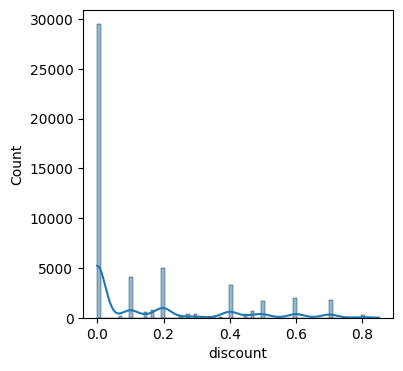

In [49]:
plt.figure(figsize=(4,4))
sns.histplot(df['discount'],kde=True)
plt.show()

- discount is not normally distributed among the customers
- most prominent discounts given are 10%,20%,40%,50%,60%,70%

### Market

In [50]:
df['market'].unique()

array(['US', 'EU', 'LATAM', 'Africa', 'APAC', 'EMEA', 'Canada'],
      dtype=object)

In [51]:
df['market'].value_counts()

market
APAC      11002
LATAM     10294
EU        10000
US         9994
EMEA       5029
Africa     4587
Canada      384
Name: count, dtype: int64

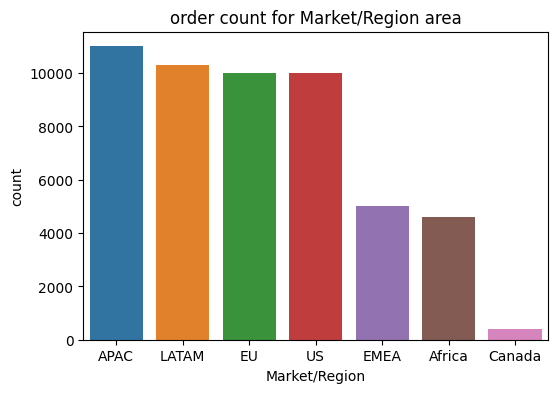

In [52]:
plt.figure(figsize=(6,4))
sns.barplot(x=df['market'].value_counts().index,
            y=df['market'].value_counts().values,
            hue=df['market'].value_counts().index)
plt.title('order count for Market/Region area')
plt.xlabel('Market/Region')
plt.ylabel('count')
plt.xticks()
plt.show()

- APAC is the largest region area,followed by US followed by LATAM followed by EU still
- APAC being the largest region still the difference in order count between different Market Zone  is not that much recognizable as there is just approx 700-1000 order count difference between APAC-LATAM-EU-US

### Number Of Records

In [53]:
df['number_of_records']

0        1
1        1
2        1
3        1
4        1
        ..
51285    1
51286    1
51287    1
51288    1
51289    1
Name: number_of_records, Length: 51290, dtype: int64

In [54]:
df['number_of_records'].nunique()

1

just one 1 unique value,then let's leave it as it is

### Order_date

In [55]:
df['order_date']

0        00:00.0
1        00:00.0
2        00:00.0
3        00:00.0
4        00:00.0
          ...   
51285    00:00.0
51286    00:00.0
51287    00:00.0
51288    00:00.0
51289    00:00.0
Name: order_date, Length: 51290, dtype: object

In [56]:
df['order_date'].unique()

array(['00:00.0'], dtype=object)

#### wait!
- there is just one unique value(00:00.0),date column is not useful to analyze
- then let's drop the column

In [57]:
df.drop(columns=['order_date'],inplace=True)

### Order_Id

In [58]:
df['order_id']

0        CA-2011-130813
1        CA-2011-148614
2        CA-2011-118962
3        CA-2011-118962
4        CA-2011-146969
              ...      
51285    CA-2014-109701
51286    CA-2014-109701
51287    CA-2014-106964
51288    CA-2014-145219
51289    CA-2014-121398
Name: order_id, Length: 51290, dtype: object

we get to see year in order_id but year column already exists in dataframe,so it's not useful to extract year from the order_id

In [59]:
df['order_id'].str.split('-').str[0].unique()

array(['CA', 'US', 'ES', 'IT', 'MX', 'SF', 'IN', 'CG', 'RS', 'NG', 'QA',
       'PL', 'MA', 'IZ', 'SA', 'EG', 'IR', 'UP', 'MO', 'CM', 'GH', 'CD',
       'KE', 'BU', 'DJ', 'ID', 'EZ', 'ZA', 'AO', 'TZ', 'SL', 'HU', 'UZ',
       'RO', 'KG', 'AU', 'BO', 'MG', 'GG', 'SY', 'HR', 'IS', 'LI', 'PU',
       'SO', 'SG', 'TS', 'ML', 'AG', 'BN', 'ET', 'LY', 'MZ', 'JO', 'TO',
       'IV', 'AJ', 'LT', 'BA', 'MW', 'MD', 'RW', 'EN', 'AL', 'LO', 'SU',
       'GV', 'CF', 'WA', 'CT', 'ER', 'LE', 'BK', 'MR', 'WZ', 'GB', 'AM',
       'SI', 'MK', 'EK', 'OD', 'BY', 'TU', 'NI', 'TX', 'KZ', 'LH', 'YM',
       'UG', 'ZI', 'AE', 'TI'], dtype=object)

### Market

In [60]:
df[(df['market']=='APAC')]['order_id'].str.split('-').str[0].unique()

array(['IN', 'ID'], dtype=object)

In [61]:
df[(df['market']=='APAC')]['order_id'].str.split('-').str[0]

3318     IN
3319     IN
3329     IN
3330     IN
3331     IN
         ..
46089    IN
46090    IN
46091    IN
46092    IN
46093    IN
Name: order_id, Length: 11002, dtype: object

In [62]:
df[(df['market']=='APAC')&(df['order_id'].str.split('-').str[0]=='IN')]

category       city    country customer_id      customer_name  \
3318   Office Supplies  Hyderabad      India   NM-184451       Nathan Mautz   
3319   Office Supplies    Kowloon  Hong Kong   DB-132701  Deborah Brumfield   
3329   Office Supplies    Jieyang      China   PS-190451    Penelope Sewall   
3330   Office Supplies    Jieyang      China   PS-190451    Penelope Sewall   
3331   Office Supplies    Jieyang      China   PS-190451    Penelope Sewall   
...                ...        ...        ...         ...                ...   
46089        Furniture     Sydney  Australia   AZ-107501       Annie Zypern   
46090        Furniture     Sydney  Australia   BE-113351        Bill Eplett   
46091  Office Supplies     Sydney  Australia   BE-113351        Bill Eplett   
46092        Furniture     Sydney  Australia   IG-150851        Ivan Gibson   
46093  Office Supplies     Sydney  Australia   IG-150851        Ivan Gibson   

       discount market  number_of_records       order_id order_priority  \
3318        0.0   APAC                  1  IN-2011-31496           High   
3319        0.0   APAC                  1  IN-2011-22662         Medium   
3329        0.0   APAC                  1  IN-2011-74490           High   
3330        0.0   APAC                  1  IN-2011-74490           High   
3331        0.0   APAC                  1  IN-2011-74490           High   
...         ...    ...                ...            ...            ...   
46089       0.1   APAC                  1  IN-2014-69604         Medium   
46090       0.1   APAC                  1  IN-2014-41709         Medium   
46091       0.1   APAC                  1  IN-2014-41709         Medium   
46092       0.1   APAC                  1  IN-2014-50011         Medium   
46093       0.1   APAC                  1  IN-2014-50011         Medium   

            product_id                                       product_name  \
3318   OFF-PA-10000070            Eaton Computer Printout Paper, Recycled   
3319   OFF-FA-10003318                        Stockwell Clamps, Bulk Pack   
3329   OFF-BI-10004868          Wilson Jones Hole Reinforcements, Durable   
3330   OFF-EN-10003413  Jiffy Interoffice Envelope, with clear poly wi...   
3331   OFF-PA-10002520              Green Bar Cards & Envelopes, Recycled   
...                ...                                                ...   
46089  FUR-CH-10002209                              Novimex Chairmat, Red   
46090  FUR-BO-10003206                    Sauder Floating Shelf Set, Pine   
46091  OFF-AR-10001266                                Boston Canvas, Blue   
46092  FUR-CH-10003097                           Hon Rocking Chair, Black   
46093  OFF-AP-10000675                        Hamilton Beach Stove, White   

        profit  quantity        region  row_id  sales      segment ship_date  \
3318    25.380         3  Central Asia   23290     79  Home Office   00:00.0   
3319     5.130         3    North Asia   29672     58  Home Office   00:00.0   
3329     0.540         3    North Asia   22110     18  Home Office   00:00.0   
3330    57.960         4    North Asia   22106    200  Home Office   00:00.0   
3331    70.920         3    North Asia   22111    145  Home Office   00:00.0   
...        ...       ...           ...     ...    ...          ...       ...   
46089   70.812         7       Oceania   30061    355     Consumer   00:00.0   
46090   -0.021         7       Oceania   26675   1234  Home Office   00:00.0   
46091   15.006         1       Oceania   26674     48  Home Office   00:00.0   
46092  149.769         9       Oceania   22818   1038     Consumer   00:00.0   
46093   32.424         2       Oceania   22819    973     Consumer   00:00.0   

            ship_mode  shipping_cost            state sub_category  year  \
3318     Second Class          13.82        Telangana        Paper  2011   
3319     Second Class           6.70        Hong Kong    Fasteners  2011   
3329      First Class           4.20        Guangd

In [63]:
df[(df['market']=='APAC')&(df['order_id'].str.split('-').str[0]=='IN')]['country'].unique()

array(['India', 'Hong Kong', 'China', 'New Zealand', 'Malaysia', 'Japan',
       'Bangladesh', 'Singapore', 'Australia', 'Afghanistan', 'Taiwan',
       'Cambodia', 'Nepal', 'Sri Lanka', 'Pakistan', 'Papua New Guinea',
       'South Korea', 'Vietnam', 'Myanmar (Burma)', 'Philippines',
       'Thailand', 'Indonesia', 'Mongolia'], dtype=object)

- only segregating the first two letters from order_id might represent thee country or state of the country BUT
- for countries, it represent the state while when taken "IN" assuming might represent 'INDIA' but it repesent many different countries from APAC Market/region

### Order Priorities

In [64]:
df['order_priority']

0            High
1          Medium
2          Medium
3          Medium
4            High
           ...   
51285        High
51286        High
51287      Medium
51288    Critical
51289      Medium
Name: order_priority, Length: 51290, dtype: object

In [65]:
df['order_priority'].value_counts()

order_priority
Medium      29433
High        15501
Critical     3932
Low          2424
Name: count, dtype: int64

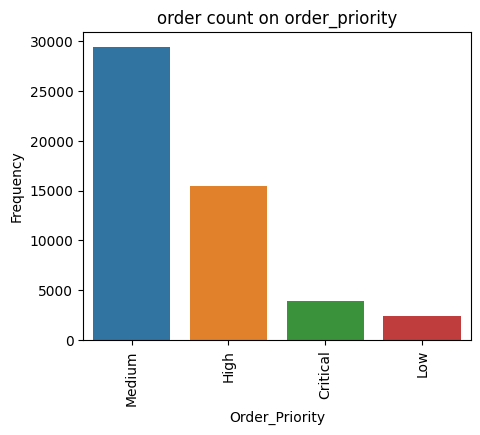

In [66]:
plt.figure(figsize=(5,4))
sns.barplot(x=df['order_priority'].value_counts().index,
            y=df['order_priority'].value_counts().values,
            hue=df['order_priority'].value_counts().index)
plt.title('order count on order_priority')
plt.xlabel('Order_Priority')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

- most(maximum) orders were ordered on medium priority - might be showing that it is system automated when user is giving any order_priority
- High and critical order_priority is in less numbers marked only when the user preferred the order_priority

### Product_id

In [67]:
df['product_id']

0        OFF-PA-10002005
1        OFF-PA-10002893
2        OFF-PA-10000659
3        OFF-PA-10001144
4        OFF-PA-10002105
              ...       
51285    OFF-BI-10000632
51286    OFF-BI-10004187
51287    OFF-BI-10000320
51288    OFF-BI-10001670
51289    OFF-BI-10001718
Name: product_id, Length: 51290, dtype: object

In [68]:
df['product_id'].value_counts()

product_id
OFF-AR-10003651    35
OFF-AR-10003829    31
OFF-BI-10003708    30
OFF-BI-10002799    30
FUR-CH-10003354    28
                   ..
FUR-FU-10003552     1
OFF-ST-10001034     1
TEC-MA-10000112     1
TEC-PH-10003535     1
TEC-PH-10004830     1
Name: count, Length: 10292, dtype: int64

In [69]:
df[df['product_id']=='OFF-AR-10003651']

category                   city         country customer_id  \
464    Office Supplies          San Francisco   United States   MK-181604   
473    Office Supplies          San Francisco   United States   VF-217154   
2245   Office Supplies               Richmond   United States   PF-191204   
3022   Office Supplies                 Taylor   United States   KB-166004   
3147   Office Supplies                 Angers          France   PP-189552   
3159   Office Supplies                Auxerre          France   BC-111252   
3174   Office Supplies        Aix-en-Provence          France   NM-184452   
8644   Office Supplies                 Vienna         Austria   TS-216552   
9878   Office Supplies              La Spezia           Italy   NS-185052   
10333  Office Supplies             Courbevoie          France   JP-154602   
10961  Office Supplies                Paisley  United Kingdom   TS-212052   
11072  Office Supplies  Ludwigshafen am Rhein         Germany   CV-128052   
12043  Office Supplies    Newcastle upon Tyne  United Kingdom   SA-208302   
12111  Office Supplies             Eastbourne  United Kingdom   DB-130602   
12221  Office Supplies             Winterthur     Switzerland   PF-192252   
12236  Office Supplies                  Paris          France   TP-214152   
12884  Office Supplies            Cumbernauld  United Kingdom   Dp-132402   
12969  Office Supplies                Cologne         Germany   BT-113052   
15320  Office Supplies             Hazebrouck          France   NS-186402   
15350  Office Supplies                 Nantes          France   RA-198852   
18275  Office Supplies                 Vienna         Austria   SC-200202   
18278  Office Supplies                  Parla           Spain   PF-191202   
18284  Office Supplies            Bournemouth  United Kingdom   AB-101652   
18334  Office Supplies                 Oviedo           Spain   SG-200802   
18353  Office Supplies                 Bremen         Germany   JW-159552   
18362  Office Supplies                Viersen         Germany   TM-214902   
18390  Office Supplies                Hamburg         Germany   BD-116352   
18409  Office Supplies              Nuremberg         Germany   IM-150702   
18469  Office Supplies               Le Havre          France   SV-207852   
32733  Office Supplies               Toulouse          France   SC-203052   
32888  Office Supplies                Haarlem     Netherlands   RB-195702   
36716  Office Supplies                 Dublin         Ireland   AS-100902   
37560  Office Supplies             Birmingham  United Kingdom   NL-183102   
47813  Office Supplies              Asheville   United States   DM-133454   
50330  Office Supplies                 Dallas   United States   AH-101204   

            customer_name  discount market  number_of_records  \
464          Mike Kennedy       0.0     US                  1   
473        Vicky Freymann       0.0     US                  1   
2245         Peter Fuller       0.0     US                  1   
3022          Ken Brennan       0.0     US                  1   
3147           Paul Prost       0.0     EU                  1   
3159        Becky Castell       0.0     EU                  1   
3174         Nathan Mautz       0.0     EU                  1   
8644        Trudy Schmidt       0.0     EU                  1   
9878      Neola Schneider       0.0     EU                  1   
10333       Jennifer Patt       0.0     EU                  1   
10961         Thomas Seio       0.0     EU                  1   
11072       Cynthia Voltz       0.0     EU                  1   
12043        Sue Ann Reed       0.0     EU                  1   
12111         Dave Brooks       0.0     EU                  1   
12221   Phillip Flathmann       0.0     EU                  1   
12236        Tom Prescott       0.0     EU                  1   
12884         Dean percer       0.0     EU                  1   
12969       Beth Thompson       0.0     EU                  1   
15320 

- took out one of the most ordered product_id
- came to know that one product_id belong to different product_name and product name varies due to difference in countries where the superstore is located 
- same product_id but segment also changed according to the country where the superstore is located

### Product_name

In [70]:
df['product_name'].value_counts()

product_name
Staples                                                              227
Cardinal Index Tab, Clear                                             92
Eldon File Cart, Single Width                                         90
Rogers File Cart, Single Width                                        84
Ibico Index Tab, Clear                                                83
                                                                    ... 
Grip Seal Envelopes                                                    1
Hewlett-Packard Deskjet D4360 Printer                                  1
Vtech AT&T CL2940 Corded Speakerphone, Black                           1
Barricks Non-Folding Utility Table with Steel Legs, Laminate Tops      1
Socket Bluetooth Cordless Hand Scanner (CHS)                           1
Name: count, Length: 3788, dtype: int64

- staples are most orderd Product in the dataset

In [71]:
df.duplicated().sum()

np.int64(0)

### Profit

In [72]:
df['profit']

0         9.3312
1         9.2928
2         9.8418
3        53.2608
4         3.1104
          ...   
51285    22.5732
51286     3.1584
51287     4.2804
51288    33.9300
51289    51.8238
Name: profit, Length: 51290, dtype: float64

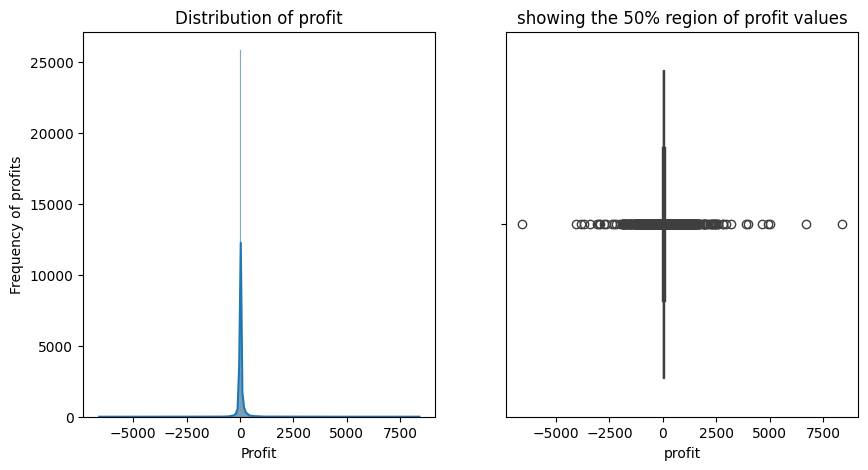

In [73]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.histplot(data=df['profit'],kde=True)
plt.title('Distribution of profit')
plt.xlabel('Profit')
plt.ylabel('Frequency of profits')

plt.subplot(1,2,2)
sns.boxplot(x=df['profit'])
plt.title('showing the 50% region of profit values')

plt.show()

In [74]:
print(f"min profit value : {df['profit'].min()}")
print(f"max profit value : {df['profit'].max()}")

min profit value : -6599.978
max profit value : 8399.976


- profit and that too negative,how's that possible
- we will do sanity check combinig with different columns while doing bivariate analysis

- since Profit columns has positive as well as negative values
    - positive values - Profit
    - negative Values - Loss
we can create a new column which shows the loss/profit in the order

In [75]:
df['profit_loss']=df['profit'].apply(lambda x : 'profit' if x>0 else 'loss')

In [76]:
df[df['profit']<0][['profit','profit_loss']]

profit profit_loss
29009  -24.2715        loss
29012  -19.0170        loss
29018   -0.0495        loss
29021   -6.7560        loss
29024 -111.4995        loss
...         ...         ...
51156  -12.4146        loss
51163   -7.9960        loss
51164  -20.6910        loss
51180   -3.5040        loss
51186  -28.9674        loss

[12544 rows x 2 columns]

### Quntity

In [77]:
df['quantity']

0        3
1        2
2        3
3        2
4        1
        ..
51285    2
51286    6
51287    2
51288    3
51289    3
Name: quantity, Length: 51290, dtype: int64

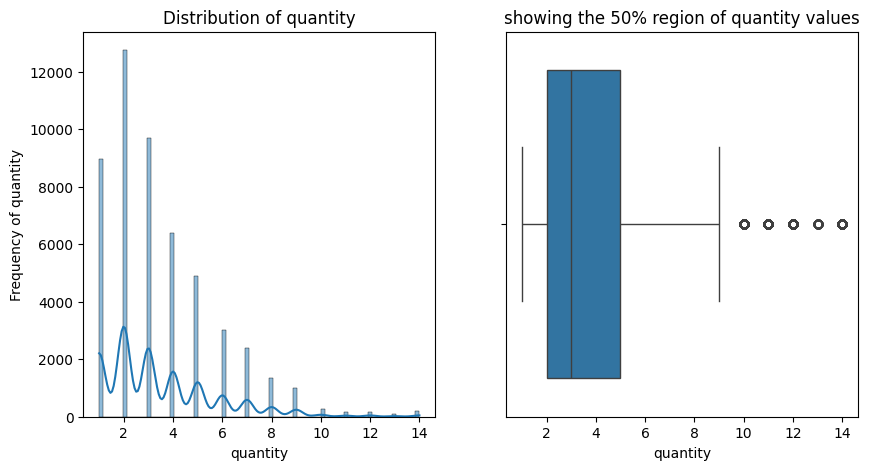

In [78]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.histplot(data=df['quantity'],kde=True)
plt.title('Distribution of quantity')
plt.xlabel('quantity')
plt.ylabel('Frequency of quantity')

plt.subplot(1,2,2)
sns.boxplot(x=df['quantity'])
plt.title('showing the 50% region of quantity values')

plt.show()

wait! we can do a ctegorical analysis as the number of different quantities are very less,we can assume those descrete order quantities as category

In [79]:
df['quantity'].value_counts()

quantity
2     12748
3      9682
1      8963
4      6385
5      4882
6      3020
7      2385
8      1361
9       987
10      276
14      186
12      176
11      156
13       83
Name: count, dtype: int64

- less quantity products are orderd more while high quantity product are very much less in number

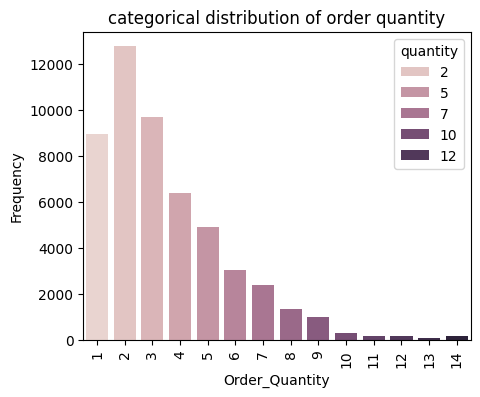

In [80]:
plt.figure(figsize=(5,4))
sns.barplot(x=df['quantity'].value_counts().index,
            y=df['quantity'].value_counts().values,
            hue=df['quantity'].value_counts().index)
plt.title('categorical distribution of order quantity')
plt.xlabel('Order_Quantity')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

- most of the orders has quantity as 2 followed by 3 and then followed by 1
- order Quantity 14,13,12,11,10 is in very less orders representing that very few peoples and very few segment are ordered in leass quantities

### Region

In [81]:
df['region']

0        West
1        West
2        West
3        West
4        West
         ... 
51285    West
51286    West
51287    West
51288    West
51289    West
Name: region, Length: 51290, dtype: object

In [82]:
df['region'].value_counts()

region
Central           11117
South              6645
EMEA               5029
North              4785
Africa             4587
Oceania            3487
West               3203
Southeast Asia     3129
East               2848
North Asia         2338
Central Asia       2048
Caribbean          1690
Canada              384
Name: count, dtype: int64

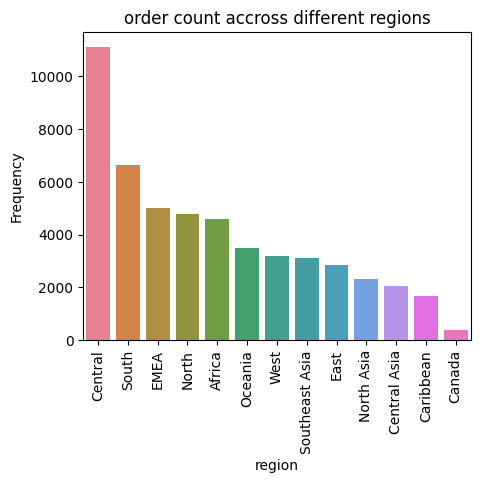

In [83]:
plt.figure(figsize=(5,4))
sns.barplot(x=df['region'].value_counts().index,
            y=df['region'].value_counts().values,
            hue=df['region'].value_counts().index)
plt.title('order count accross different regions')
plt.xlabel('region')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

- central region being the most order receiving region with more than 10000 orders placed
- looks like peoples from "canada" are not engaging that much with the products available in the superstore in area of 'canada'
    - required to provide attractive and lucrative offers at the stores of the Canada
- peoples from Asian Origin are not engaging with the superstore but better than 'Canada',if lucrative and attractive offers provided in stores of those area,more revenue,hence more profit could be generated

### Row Id

In [84]:
df['row_id']

0        36624
1        37033
2        31468
3        31469
4        32440
         ...  
51285    33646
51286    33645
51287    32321
51288    35917
51289    37371
Name: row_id, Length: 51290, dtype: int64

In [85]:
df['row_id'].value_counts()

row_id
36624    1
37033    1
31468    1
31469    1
32440    1
        ..
33646    1
33645    1
32321    1
35917    1
37371    1
Name: count, Length: 51290, dtype: int64

- row_id is unique for each row hence not useful for analyzing

### Sales

In [86]:
df['sales']

0         19
1         19
2         21
3        111
4          6
        ... 
51285     69
51286      9
51287     12
51288     90
51289    154
Name: sales, Length: 51290, dtype: int64

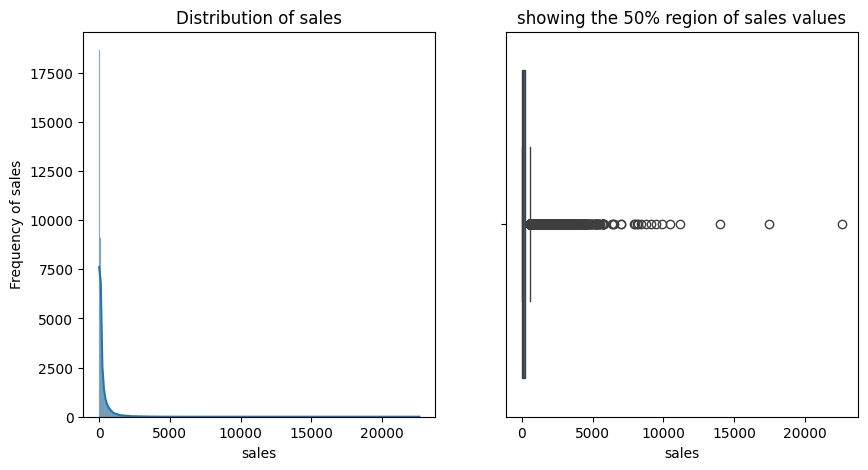

In [87]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.histplot(data=df['sales'],kde=True)
plt.title('Distribution of sales')
plt.xlabel('sales')
plt.ylabel('Frequency of sales')

plt.subplot(1,2,2)
sns.boxplot(x=df['sales'])
plt.title('showing the 50% region of sales values')

plt.show()

In [88]:
print(f"min sale value : {df['sales'].min()}")
print(f"max sale value : {df['sales'].max()}")

min sale value : 0
max sale value : 22638


- sale value is 0,that's not possible
- we need to do sanity check combining with other different columns while doing bivariate analysis and then correct it

### Segment

In [89]:
df['segment']

0           Consumer
1           Consumer
2           Consumer
3           Consumer
4           Consumer
            ...     
51285      Corporate
51286      Corporate
51287    Home Office
51288    Home Office
51289      Corporate
Name: segment, Length: 51290, dtype: object

In [90]:
df['segment'].value_counts()

segment
Consumer       26518
Corporate      15429
Home Office     9343
Name: count, dtype: int64

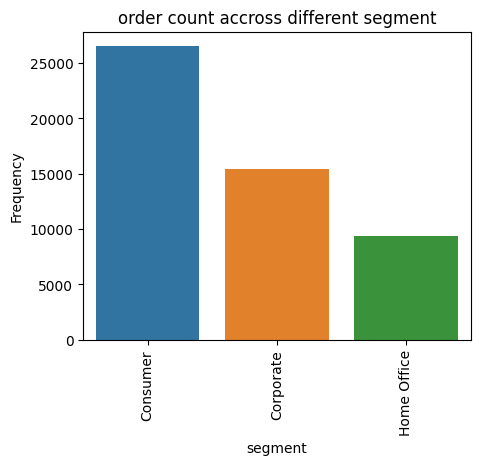

In [91]:
plt.figure(figsize=(5,4))
sns.barplot(x=df['segment'].value_counts().index,
            y=df['segment'].value_counts().values,
            hue=df['segment'].value_counts().index)
plt.title('order count accross different segment')
plt.xlabel('segment')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

- Consumer segement products are ordered most followed by corporate segment followed by home office

### Ship_date

In [92]:
df['ship_date']

0        00:00.0
1        00:00.0
2        00:00.0
3        00:00.0
4        00:00.0
          ...   
51285    00:00.0
51286    00:00.0
51287    00:00.0
51288    00:00.0
51289    00:00.0
Name: ship_date, Length: 51290, dtype: object

In [93]:
df['ship_date'].unique()

array(['00:00.0'], dtype=object)

- ship_date does not have any distinct dates of shipping
- we are dropping this column

In [94]:
df.drop(columns=['ship_date'],inplace=True)

### Ship_mode

In [95]:
df['ship_mode']

0          Second Class
1        Standard Class
2        Standard Class
3        Standard Class
4        Standard Class
              ...      
51285          Same Day
51286          Same Day
51287       First Class
51288       First Class
51289    Standard Class
Name: ship_mode, Length: 51290, dtype: object

In [96]:
df['ship_mode'].value_counts()

ship_mode
Standard Class    30775
Second Class      10309
First Class        7505
Same Day           2701
Name: count, dtype: int64

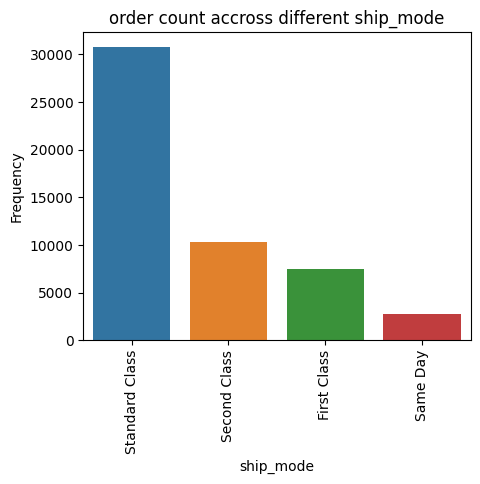

In [97]:
plt.figure(figsize=(5,4))
sns.barplot(x=df['ship_mode'].value_counts().index,
            y=df['ship_mode'].value_counts().values,
            hue=df['ship_mode'].value_counts().index)
plt.title('order count accross different ship_mode')
plt.xlabel('ship_mode')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

- most of the orders are being shipped using standard Class
- same day shipments are very less

### Shipping_cost

In [98]:
df['shipping_cost']

0         4.37
1         0.94
2         1.81
3         4.59
4         1.32
         ...  
51285     5.15
51286     0.44
51287     0.31
51288    15.95
51289     9.59
Name: shipping_cost, Length: 51290, dtype: float64

we have seen shipping cost has some missing values,lets ahndle them

In [99]:
df['shipping_cost'].isna().sum()

np.int64(5)

In [100]:
df[df['shipping_cost'].isna()]

category           city        country customer_id  \
448   Office Supplies  San Francisco  United States   CM-123854   
605   Office Supplies      San Diego  United States   TH-211004   
854   Office Supplies    Santa Clara  United States   LR-170354   
1265  Office Supplies  New York City  United States   BD-117704   
1465  Office Supplies        Seattle  United States   MZ-173354   

             customer_name  discount market  number_of_records  \
448   Christopher Martinez       0.0     US                  1   
605         Thea Hendricks       0.0     US                  1   
854              Lisa Ryan       0.0     US                  1   
1265           Bryan Davis       0.0     US                  1   
1465         Maria Zettner       0.0     US                  1   

            order_id order_priority       product_id  \
448   CA-2014-111738         Medium  OFF-AR-10000817   
605   US-2011-133130           High  OFF-PA-10000675   
854   CA-2011-109918         Medium  OFF-PA-10000174   
1265  CA-2013-124667         Medium  OFF-ST-10002276   
1465  CA-2014-147144         Medium  OFF-AR-10004587   

                                           product_name   profit  quantity  \
448              Manco Dry-Lighter Erasable Highlighter   3.1008         3   
605                                          Xerox 1919  40.1702         2   
854   Message Book, Wirebound, Four 5 1/2" X 4" Form...   9.6632         2   
1265                       Safco Steel Mobile File Cart  20.8400         1   
1465  Boston 1827 Commercial Additional Cutter, Driv...   5.9490         1   

     region  row_id  sales      segment       ship_mode  shipping_cost  \
448    West   40788      9     Consumer  Standard Class            NaN   
605    West   34610     82     Consumer  Standard Class            NaN   
854    West   39664     21    Corporate    Second Class            NaN   
1265   East   33077     83     Consumer  Standard Class            NaN   
1465   West   35535     20  Home Office     First Class            NaN   

           state sub_category  year        market2  weeknum profit_loss  
448   California          Art  2014  North America        1      profit  
605   California        Paper  2011  North America       40      profit  
854   California        Paper  2011  North America       37      profit  
1265    New York      Storage  2013  North America       46      profit  
1465  Washington          Art  2014  North America       13      profit

* shipping_cost has missing values in country-United States,market-US
- imputation strategy:
    - shipping cost mean for country United states according to city

In [101]:
df.groupby(['city', 'country'])['shipping_cost'].transform('mean')

0        25.136644
1        25.136644
2        25.136644
3        25.136644
4        25.136644
           ...    
51285    25.136644
51286    25.136644
51287    25.136644
51288    25.136644
51289    25.136644
Name: shipping_cost, Length: 51290, dtype: float64

In [102]:
df['shipping_cost'] = df['shipping_cost'].fillna(
    df.groupby(['city', 'country'])['shipping_cost'].transform('mean')
)

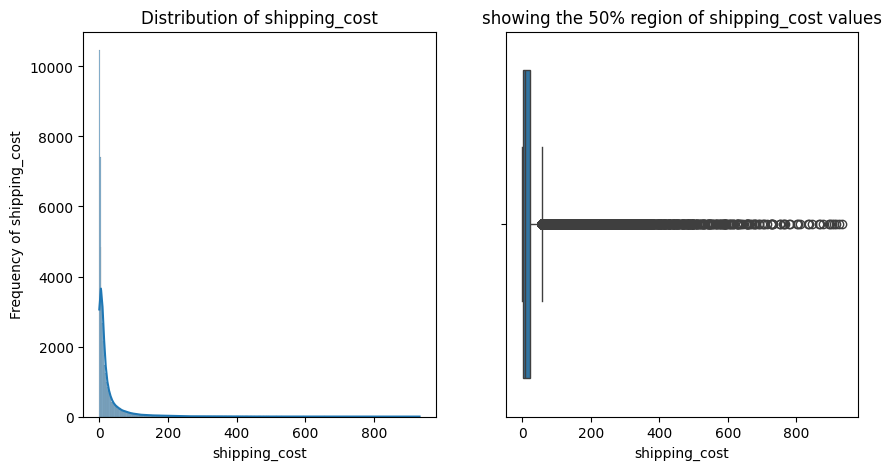

min shipping_cost value : 0.002
max shipping_cost value : 933.57


In [103]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.histplot(data=df['shipping_cost'],kde=True)
plt.title('Distribution of shipping_cost')
plt.xlabel('shipping_cost')
plt.ylabel('Frequency of shipping_cost')

plt.subplot(1,2,2)
sns.boxplot(x=df['shipping_cost'])
plt.title('showing the 50% region of shipping_cost values')

plt.show()
print(f"min shipping_cost value : {df['shipping_cost'].min()}")
print(f"max shipping_cost value : {df['shipping_cost'].max()}")

- though the shipping cost value is not 0 but if the products are shipped internationally,then it cannot be that low and that much high
- need to do sanity check combining with other different columns and correct it

### State

In [104]:
df['state']

0        California
1        California
2        California
3        California
4        California
            ...    
51285    California
51286    California
51287    California
51288    California
51289    California
Name: state, Length: 51290, dtype: object

In [105]:
df['state'].isna().sum()

np.int64(3)

In [106]:
df[df['state'].isna()]

category     city        country customer_id       customer_name  \
1439  Office Supplies  Seattle  United States   LL-168404  Lauren Leatherbury   
1440  Office Supplies  Seattle  United States   LL-168404  Lauren Leatherbury   
1452  Office Supplies  Seattle  United States   SG-200804      Sandra Glassco   

      discount market  number_of_records        order_id order_priority  \
1439       0.0     US                  1  CA-2012-164833           High   
1440       0.0     US                  1  CA-2012-164833           High   
1452       0.0     US                  1  CA-2012-162544         Medium   

           product_id                                       product_name  \
1439  OFF-AR-10004685  Binney & Smith Crayola Metallic Colored Pencil...   
1440  OFF-LA-10000443                                          Avery 501   
1452  OFF-PA-10004948                                          Xerox 190   

      profit  quantity region  row_id  sales   segment    ship_mode  \
1439  3.0558         2   West   33113      9  Consumer     Same Day   
1440  3.4686         2   West   33112      7  Consumer     Same Day   
1452  2.3406         1   West   38169      5  Consumer  First Class   

      shipping_cost state sub_category  year        market2  weeknum  \
1439           1.82   NaN          Art  2012  North America       23   
1440           1.56   NaN       Labels  2012  North America       23   
1452           0.09   NaN        Paper  2012  North America       51   

     profit_loss  
1439      profit  
1440      profit  
1452      profit

* only missing values for seattle state
- will fill missing value with state that is associated with city and state 

In [107]:
df.groupby(['city','country'])['state'].transform(lambda x:x.mode().iloc[0] if not x.mode().empty else x)

0        California
1        California
2        California
3        California
4        California
            ...    
51285    California
51286    California
51287    California
51288    California
51289    California
Name: state, Length: 51290, dtype: object

In [108]:
df['state']=df['state'].fillna(df.groupby(['city','country'])['state'].transform(lambda x:x.mode().iloc[0] if not x.mode().empty else x))

In [109]:
df['state'].value_counts().head(25)

state
California                    2001
England                       1499
New York                      1128
Texas                          985
Ile-de-France                  981
New South Wales                781
North Rhine-Westphalia         719
Queensland                     717
San Salvador                   615
Pennsylvania                   587
National Capital               583
Washington                     506
Illinois                       492
Victoria                       491
Ohio                           469
Distrito Federal               469
Santo Domingo                  443
Istanbul                       425
São Paulo                      409
Guatemala                      391
Provence-Alpes-Côte d'Azur     390
Florida                        383
Managua                        368
Francisco Morazán              362
Jakarta                        337
Name: count, dtype: int64

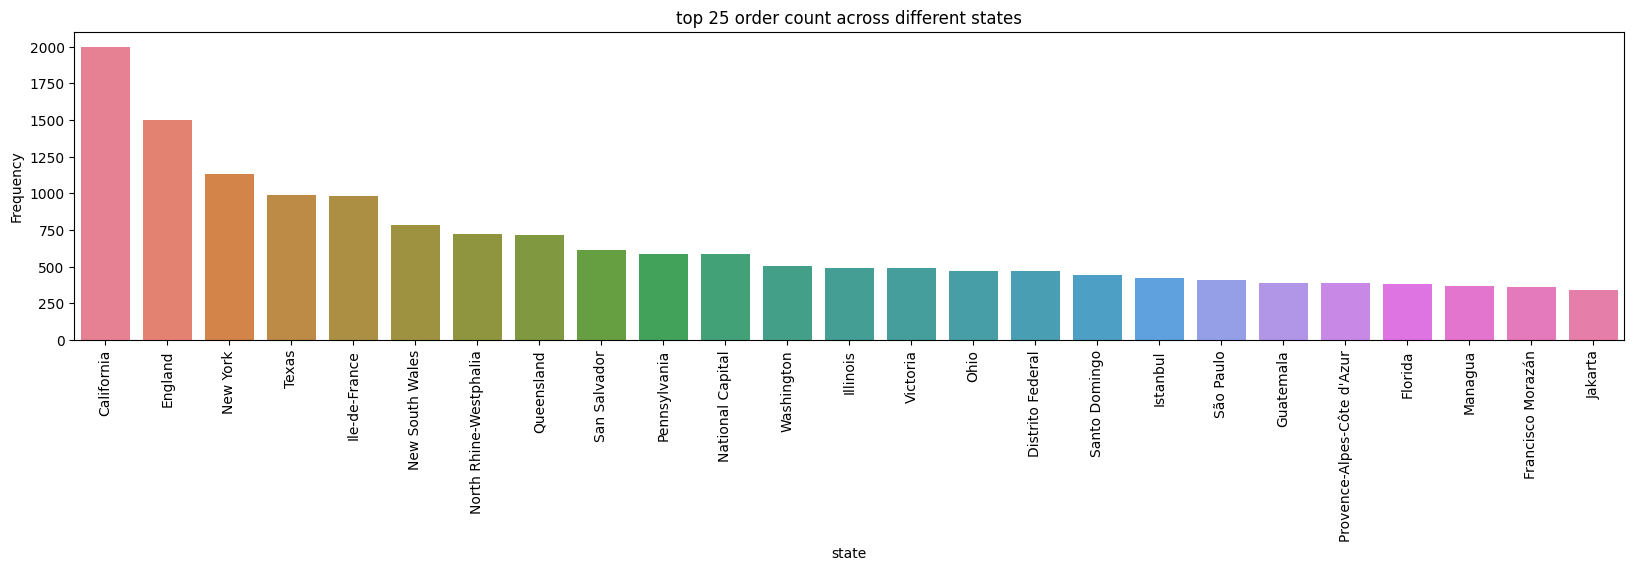

In [110]:
plt.figure(figsize=(20,4))
sns.barplot(x=df['state'].value_counts().head(25).index,
            y=df['state'].value_counts().head(25).values,
            hue=df['state'].value_counts().head(25).index)
plt.title('top 25 order count across different states')
plt.xlabel('state')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

- highest number of orders received at store in california followed by England followed by New York
- from the bottom in top 25 jakarta being the last in order count

In [111]:
df['state'].value_counts()[df['state'].value_counts()==1]

state
Newfoundland         1
Guelmim-Es Semara    1
Setúbal              1
Pernik               1
Galway               1
                    ..
Pleven               1
Lima                 1
Ibb                  1
Ardahan              1
Wyoming              1
Name: count, Length: 64, dtype: int64

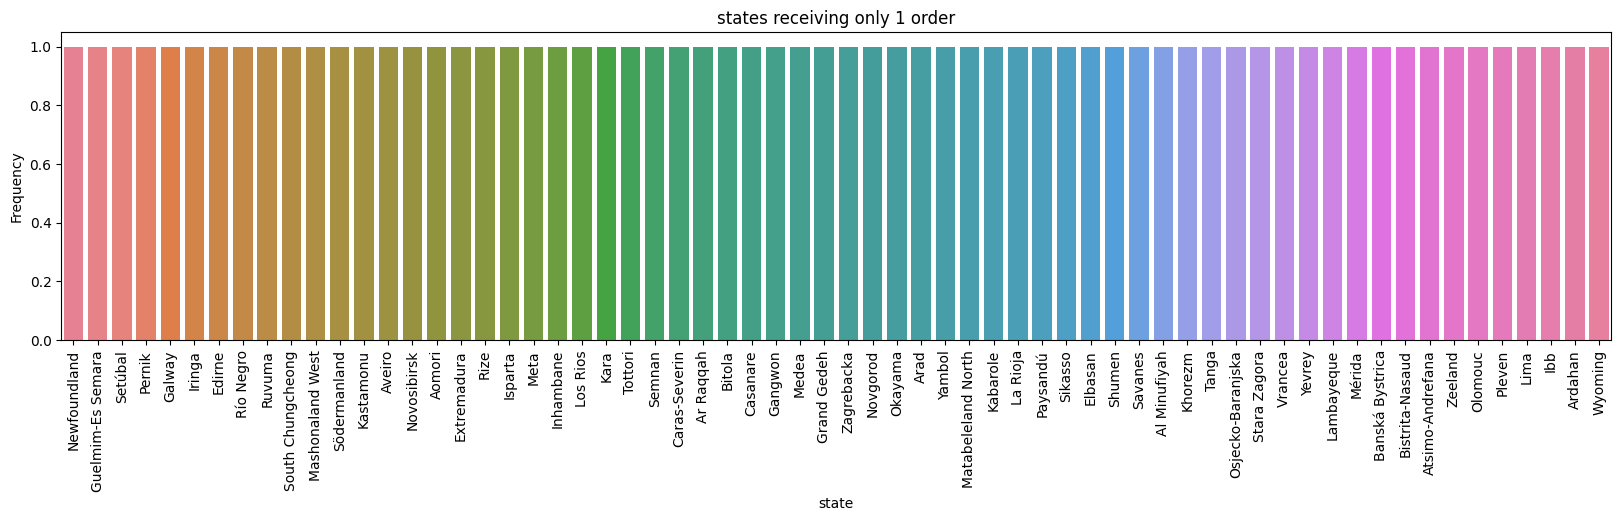

In [112]:
plt.figure(figsize=(20,4))
sns.barplot(x=df['state'].value_counts()[df['state'].value_counts()==1].index,
            y=df['state'].value_counts()[df['state'].value_counts()==1].values,
            hue=df['state'].value_counts()[df['state'].value_counts()==1].index)
plt.title('states receiving only 1 order')
plt.xlabel('state')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

- these are the states,where stores had received only 1 order

### Sub_category

In [113]:
df['sub_category']

0          Paper
1          Paper
2          Paper
3          Paper
4          Paper
          ...   
51285    Binders
51286    Binders
51287    Binders
51288    Binders
51289    Binders
Name: sub_category, Length: 51290, dtype: object

In [114]:
df['sub_category'].value_counts()

sub_category
Binders        6152
Storage        5059
Art            4883
Paper          3538
Chairs         3434
Phones         3357
Furnishings    3170
Accessories    3075
Labels         2606
Envelopes      2435
Supplies       2425
Fasteners      2420
Bookcases      2411
Copiers        2223
Appliances     1755
Machines       1486
Tables          861
Name: count, dtype: int64

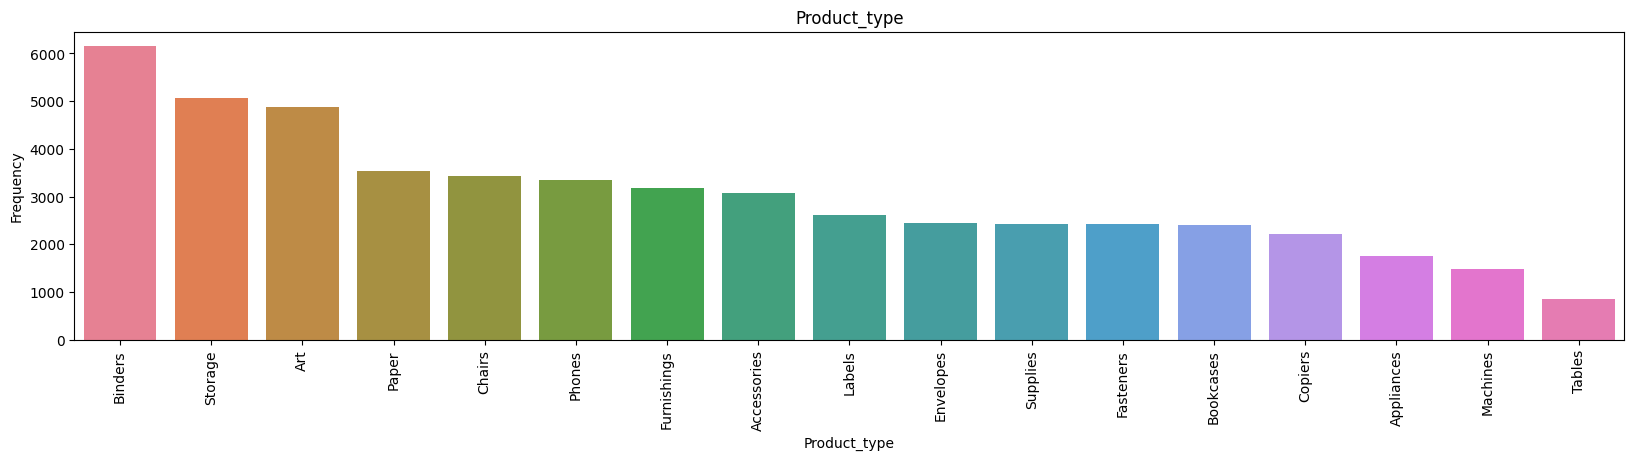

In [115]:
plt.figure(figsize=(20,4))
sns.barplot(x=df['sub_category'].value_counts().index,
            y=df['sub_category'].value_counts().values,
            hue=df['sub_category'].value_counts().index)
plt.title('Product_type')
plt.xlabel('Product_type')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

- binders are the most ordered product type followed by Storage followed by Art
- tables being least ordered product_type

### Year

In [116]:
df['year']

0        2011
1        2011
2        2011
3        2011
4        2011
         ... 
51285    2014
51286    2014
51287    2014
51288    2014
51289    2014
Name: year, Length: 51290, dtype: int64

In [117]:
df['year'].value_counts()

year
2014    17531
2013    13799
2012    10962
2011     8998
Name: count, dtype: int64

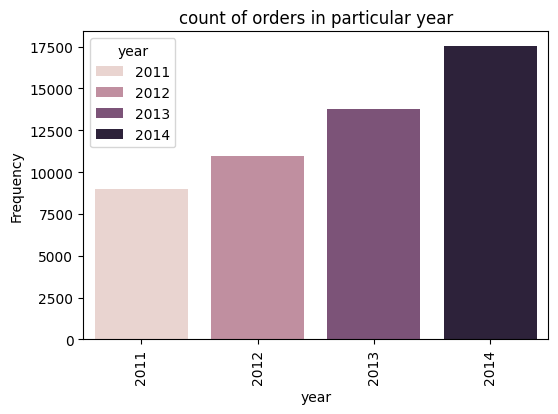

In [118]:
plt.figure(figsize=(6,4))
sns.barplot(x=df['year'].value_counts().index,
            y=df['year'].value_counts().values,
            hue=df['year'].value_counts().index)
plt.title('count of orders in particular year')
plt.xlabel('year')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

- from 2011 to 2014, we can see a positive increment in order count year by year

### Market2

In [119]:
df['market2']

0        North America
1        North America
2        North America
3        North America
4        North America
             ...      
51285    North America
51286    North America
51287    North America
51288    North America
51289    North America
Name: market2, Length: 51290, dtype: object

In [120]:
df[df['market2']==df['market']]

category          city    country customer_id  \
3129   Office Supplies    Echirolles     France   MG-178902   
3130   Office Supplies    Echirolles     France   MG-178902   
3131   Office Supplies  Noisy-le-Sec     France   SN-205602   
3132   Office Supplies   Carcassonne     France   TW-210252   
3133   Office Supplies   Carcassonne     France   TW-210252   
...                ...           ...        ...         ...   
46089        Furniture        Sydney  Australia   AZ-107501   
46090        Furniture        Sydney  Australia   BE-113351   
46091  Office Supplies        Sydney  Australia   BE-113351   
46092        Furniture        Sydney  Australia   IG-150851   
46093  Office Supplies        Sydney  Australia   IG-150851   

           customer_name  discount market  number_of_records         order_id  \
3129    Michael Granlund       0.0     EU                  1  ES-2011-3848439   
3130    Michael Granlund       0.0     EU                  1  ES-2011-3848439   
3131        Skye Norling       0.0     EU                  1  ES-2011-5522951   
3132   Tamara Willingham       0.0     EU                  1  ES-2011-5504927   
3133   Tamara Willingham       0.0     EU                  1  ES-2011-5504927   
...                  ...       ...    ...                ...              ...   
46089       Annie Zypern       0.1   APAC                  1    IN-2014-69604   
46090        Bill Eplett       0.1   APAC                  1    IN-2014-41709   
46091        Bill Eplett       0.1   APAC                  1    IN-2014-41709   
46092        Ivan Gibson       0.1   APAC                  1    IN-2014-50011   
46093        Ivan Gibson       0.1   APAC                  1    IN-2014-50011   

      order_priority       product_id  \
3129          Medium  OFF-AR-10000833   
3130          Medium  OFF-AR-10001291   
3131          Medium  OFF-FA-10004878   
3132        Critical  OFF-BI-10002894   
3133        Critical  OFF-BI-10003951   
...              ...              ...   
46089         Medium  FUR-CH-10002209   
46090         Medium  FUR-BO-10003206   
46091         Medium  OFF-AR-10001266   
46092         Medium  FUR-CH-10003097   
46093         Medium  OFF-AP-10000675   

                                       product_name   profit  quantity  \
3129   Binney & Smith Pencil Sharpener, Water Color   20.520         3   
3130                    Sanford Canvas, Fluorescent   76.560         4   
3131                    Stockwell Clamps, Bulk Pack    4.500         3   
3132                 Avery Binding Machine, Durable   27.000         9   
3133                    Ibico 3-Hole Punch, Economy   76.050         5   
...                                             ...      ...       ...   
46089                         Novimex Chairmat, Red   70.812         7   
46090               Sauder Floating Shelf Set, Pine   -0.021         7   
46091                           Boston Canvas, Blue   15.006         1   
46092                      Hon Rocking Chair, Black  149.769         9   
46093                   Hamilton Beach Stove, White   32.424         2   

        region  row_id  sales      segment       ship_mode  shipping_cost  \
3129   Central   17688     90  Home Office     First Class          15.27   
3130   Central   17689    207  Home Office     First Class          20.64   
3131   Central   19274     57  Home Office     First Class           7.06   
3132   Central   13223    453  Home Office     First Class          95.81   
3133   Central   13222    152  Home Office     First Class          48.16   
...        ...     ...    ...          ...             ...            ...   
46089  Oceania   30061    355     Consumer  Standard Class          24.45   
46090  Oceania   26675   1234  Home Office  Standard Class          93.30   
46091  Oceania   26674     48  Home Office  Standard Class           2.34   
46092  Oceania   22818   1038     Consumer  Standard Class          61.46   
46093  Oceania   22819    973     Consumer  Standard Cl

In [121]:
df[df['market2']!=df['market']]

category         city        country customer_id  \
0      Office Supplies  Los Angeles  United States   LS-172304   
1      Office Supplies  Los Angeles  United States   MV-174854   
2      Office Supplies  Los Angeles  United States   CS-121304   
3      Office Supplies  Los Angeles  United States   CS-121304   
4      Office Supplies  Los Angeles  United States   AP-109154   
...                ...          ...            ...         ...   
51285  Office Supplies  Los Angeles  United States   AM-103604   
51286  Office Supplies  Los Angeles  United States   AM-103604   
51287  Office Supplies  Los Angeles  United States   HR-147704   
51288  Office Supplies  Los Angeles  United States   RM-196754   
51289  Office Supplies  Los Angeles  United States   FH-143654   

          customer_name  discount market  number_of_records        order_id  \
0      Lycoris Saunders       0.0     US                  1  CA-2011-130813   
1         Mark Van Huff       0.0     US                  1  CA-2011-148614   
2          Chad Sievert       0.0     US                  1  CA-2011-118962   
3          Chad Sievert       0.0     US                  1  CA-2011-118962   
4        Arthur Prichep       0.0     US                  1  CA-2011-146969   
...                 ...       ...    ...                ...             ...   
51285    Alice McCarthy       0.2     US                  1  CA-2014-109701   
51286    Alice McCarthy       0.2     US                  1  CA-2014-109701   
51287    Hallie Redmond       0.2     US                  1  CA-2014-106964   
51288     Robert Marley       0.2     US                  1  CA-2014-145219   
51289      Fred Hopkins       0.2     US                  1  CA-2014-121398   

      order_priority       product_id  \
0               High  OFF-PA-10002005   
1             Medium  OFF-PA-10002893   
2             Medium  OFF-PA-10000659   
3             Medium  OFF-PA-10001144   
4               High  OFF-PA-10002105   
...              ...              ...   
51285           High  OFF-BI-10000632   
51286           High  OFF-BI-10004187   
51287         Medium  OFF-BI-10000320   
51288       Critical  OFF-BI-10001670   
51289         Medium  OFF-BI-10001718   

                                            product_name   profit  quantity  \
0                                              Xerox 225   9.3312         3   
1              Wirebound Service Call Books, 5 1/2" x 4"   9.2928         2   
2      Adams Phone Message Book, Professional, 400 Me...   9.8418         3   
3                                             Xerox 1913  53.2608         2   
4                                              Xerox 223   3.1104         1   
...                                                  ...      ...       ...   
51285                   Satellite Sectional Post Binders  22.5732         2   
51286                                            Staples   3.1584         6   
51287                          GBC Plastic Binding Combs   4.2804         2   
51288                       Vinyl Sectional Post Binders  33.9300         3   
51289          GBC DocuBind P50 Personal Binding Machine  51.8238         3   

      region  row_id  sales      segment       ship_mode  shipping_cost  \
0       West   36624     19     Consumer    Second Class           4.37   
1       West   37033     19     Consumer  Standard Class           0.94   
2       West   31468     21     Consumer  Standard Class           1.81   
3       West   31469    111     Consumer  Standard Class           4.59   
4       West   32440      6     Consumer  Standard Class           1.32   
...      ...     ...    ...          ...             ...            ...   
51285   West   33646     69    Corporate        Same Day           5.15   
51286   West   33645      9    Corporate        Same Day           0.44   
51287   West   32321     12  Home Office     First Class           0.31   
51288   West   35917     90  Home Office     First Class          15.95   
51289

In [122]:
df[df['market2']!=df['market']]['market2'].unique()

array(['North America'], dtype=object)

'market2' is just naming  the US 'market' to 'NorthAmerica'

### Weeknum

In [123]:
df['weeknum']

0         2
1         4
2        32
3        32
4        40
         ..
51285    49
51286    49
51287    51
51288    52
51289    52
Name: weeknum, Length: 51290, dtype: int64

we will be combining the weeknum and year to extarct the month of order_id
- assuming every week's 1st day(monday) and will help in extracting the month

In [124]:
df['year'].astype(str)+'-W'+df['weeknum'].astype(str)+'-1'

0         2011-W2-1
1         2011-W4-1
2        2011-W32-1
3        2011-W32-1
4        2011-W40-1
            ...    
51285    2014-W49-1
51286    2014-W49-1
51287    2014-W51-1
51288    2014-W52-1
51289    2014-W52-1
Length: 51290, dtype: object

Adding New column called month representing the month number 

In [125]:
df['month']=pd.to_datetime(df['year'].astype(str)+'-W'+df['weeknum'].astype(str)+'-1', format='%G-W%V-%u').dt.month

Adding New column called month_name representing the name of the name of the month when the order was placed

In [126]:
df['month_name']=pd.to_datetime(df['year'].astype(str)+'-W'+df['weeknum'].astype(str)+'-1', format='%G-W%V-%u').dt.month_name()

### Profit_loss

In [127]:
df['profit_loss'].value_counts()

profit_loss
profit    38078
loss      13212
Name: count, dtype: int64

In [128]:
df['profit_loss'].value_counts(normalize=True)

profit_loss
profit    0.742406
loss      0.257594
Name: proportion, dtype: float64

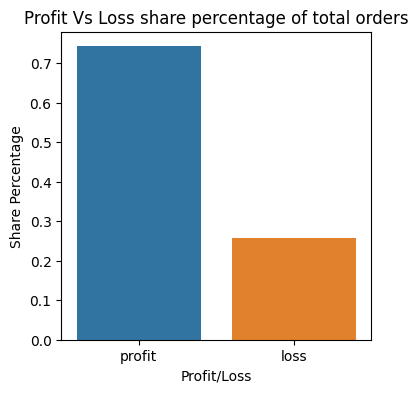

In [129]:
plt.figure(figsize=(4,4))
sns.barplot(x=df['profit_loss'].value_counts(normalize=True).index,
            y=df['profit_loss'].value_counts(normalize=True).values,
            hue=df['profit_loss'].value_counts(normalize=True).index)
plt.title('Profit Vs Loss share percentage of total orders')
plt.xlabel('Profit/Loss')
plt.ylabel('Share Percentage')
plt.show()

- profit generated from approximately in 75% of orders but made loss in 25 % of the orders

### Month

In [130]:
df['month']

0         1
1         1
2         8
3         8
4        10
         ..
51285    12
51286    12
51287    12
51288    12
51289    12
Name: month, Length: 51290, dtype: int32

### Month_name

In [131]:
df['month_name']

0         January
1         January
2          August
3          August
4         October
           ...   
51285    December
51286    December
51287    December
51288    December
51289    December
Name: month_name, Length: 51290, dtype: object

In [132]:
df['month'].value_counts().sort_index()

month
1     2738
2     2198
3     3007
4     3223
5     3583
6     5313
7     3362
8     4749
9     6219
10    4542
11    6000
12    6356
Name: count, dtype: int64

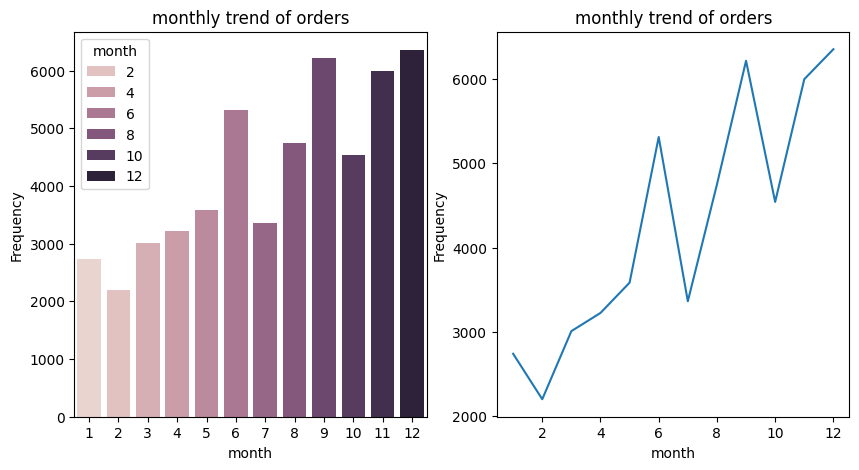

In [133]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.barplot(x=df['month'].value_counts().sort_index().index,
            y=df['month'].value_counts().sort_index().values,
            hue=df['month'].value_counts().sort_index().index)
plt.title('monthly trend of orders')
plt.xlabel('month')
plt.ylabel('Frequency')
plt.xticks()

plt.subplot(1,2,2)
sns.lineplot(x=df['month'].value_counts().sort_index().index,
            y=df['month'].value_counts().sort_index().values,
            markers='o')
plt.title('monthly trend of orders')
plt.xlabel('month')
plt.ylabel('Frequency')
plt.xticks()
plt.show()

- in the above plot
    - in the start of the year,the orders count is very less as moving towards the end of the year,the frequency of the order grows gradualy with little up and downs
    - shows a significant growth in order frequency from starting of the year towards the end of the year

combining year and month together to see month on month year to year growth in order frequency

adding year and month and inserting it as year_month representing the month of the year

In [134]:
df['year']*100+df['month']

0        201101
1        201101
2        201108
3        201108
4        201110
          ...  
51285    201412
51286    201412
51287    201412
51288    201412
51289    201412
Length: 51290, dtype: int64

In [135]:
df['year_month']=df['year']*100+df['month']

In [136]:
df['year_month'].value_counts().sort_index()

year_month
201101     719
201102     396
201103     449
201104     542
201105     639
201106     827
201107     500
201108     919
201109     911
201110     968
201111    1041
201112    1087
201201     593
201202     434
201203     603
201204     762
201205     818
201206    1053
201207     808
201208     957
201209    1197
201210    1137
201211    1351
201212    1249
201301     622
201302     605
201303     724
201304     933
201305     954
201306    1477
201307    1058
201308    1319
201309    1863
201310    1017
201311    1498
201312    1729
201401     804
201402     763
201403    1231
201404     986
201405    1172
201406    1956
201407     996
201408    1554
201409    2248
201410    1420
201411    2110
201412    2291
Name: count, dtype: int64

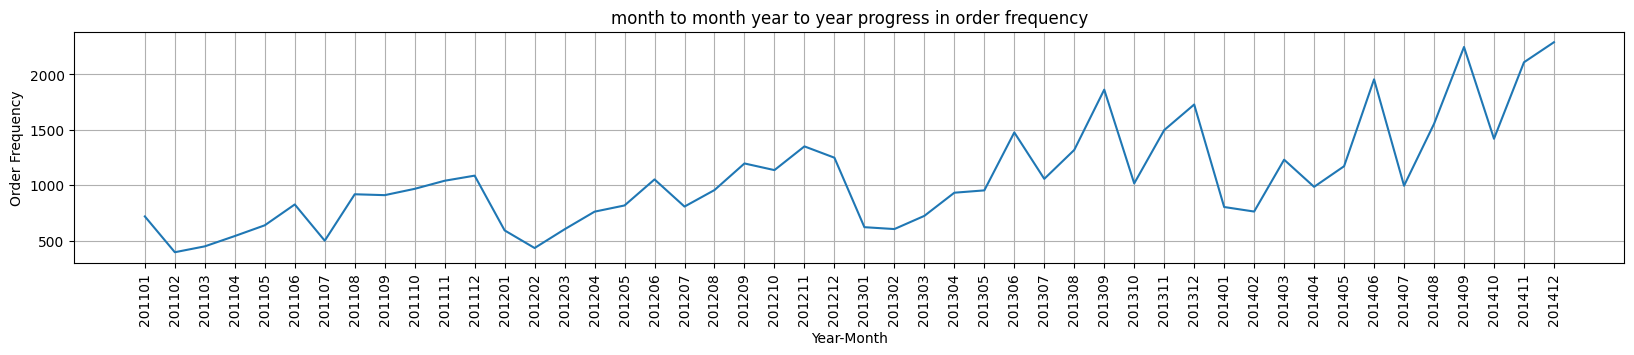

In [137]:
plt.figure(figsize=(20,3))
sns.lineplot(x=df['year_month'].value_counts().sort_index().index.astype(str),
             y=df['year_month'].value_counts().sort_index().values)
plt.title('month to month year to year progress in order frequency')
plt.xlabel('Year-Month')
plt.ylabel('Order Frequency')
plt.grid()
plt.xticks(rotation=90)
plt.show()

- the above plot shows
    - month to month year to year progess in order counts received
- we can see that at every begining of the year,order counts goes down
    - after february,order count increases and goes up,
    - we can see that in every starting of the year,order count approximately trends between 500-1000 ,goes down less than 500 and starts increasing from march and grows till end of the year but in 2014 the order count in feb trends between 500-100,showing a positive signal in buisness growth

- Dropping columns which are not required
    - order_id - does not provide any kind of significant insights
    - market - market2 provide the same insights as market,just a change is 'US' market is names as 'North American' market
    - number_of_records - no insights
    - row_id - no insights
    - weeknum - month and month_name are derived from weeknum

In [138]:
df[df['market']=='US']['market2'].unique()

array(['North America'], dtype=object)

In [139]:
df.drop(columns=['order_id','market','number_of_records','row_id'],inplace=True)

### BiVariate and MultiVariate Analysis

##### Primary Target Column : - Profit
##### Secondry Target Column : - Sales

- segregating Numerical and categorycal columns

In [140]:
df.describe(include='all')

category           city        country customer_id  \
count             51290          51290          51290       51290   
unique                3           3636            147        4873   
top     Office Supplies  New York City  United States   JG-158051   
freq              31273            915           9994          40   
mean                NaN            NaN            NaN         NaN   
std                 NaN            NaN            NaN         NaN   
min                 NaN            NaN            NaN         NaN   
25%                 NaN            NaN            NaN         NaN   
50%                 NaN            NaN            NaN         NaN   
75%                 NaN            NaN            NaN         NaN   
max                 NaN            NaN            NaN         NaN   

          customer_name      discount order_priority       product_id  \
count             51290  51290.000000          51290            51290   
unique              795           NaN              4            10292   
top     Muhammed Yedwab           NaN         Medium  OFF-AR-10003651   
freq                108           NaN          29433               35   
mean                NaN      0.142908            NaN              NaN   
std                 NaN      0.212280            NaN              NaN   
min                 NaN      0.000000            NaN              NaN   
25%                 NaN      0.000000            NaN              NaN   
50%                 NaN      0.000000            NaN              NaN   
75%                 NaN      0.200000            NaN              NaN   
max                 NaN      0.850000            NaN              NaN   

       product_name        profit      quantity   region         sales  \
count         51290  51290.000000  51290.000000    51290  51290.000000   
unique         3788           NaN           NaN       13           NaN   
top         Staples           NaN           NaN  Central           NaN   
freq            227           NaN           NaN    11117           NaN   
mean            NaN     28.610982      3.476545      NaN    246.498440   
std             NaN    174.340972      2.278766      NaN    487.567175   
min             NaN  -6599.978000      1.000000      NaN      0.000000   
25%             NaN      0.000000      2.000000      NaN     31.000000   
50%             NaN      9.240000      3.000000      NaN     85.000000   
75%             NaN     36.810000      5.000000      NaN    251.000000   
max             NaN   8399.976000     14.000000      NaN  22638.000000   

         segment       ship_mode  shipping_cost       state sub_category  \
count      51290           51290   51290.000000       51290        51290   
unique         3               4            NaN        1094           17   
top     Consumer  Standard Class            NaN  California      Binders   
freq       26518           30775            NaN        2001         6152   
mean         NaN             NaN      26.377632         NaN          NaN   
std          NaN             NaN      57.296447         NaN          NaN   
min          NaN             NaN       0.002000         NaN          NaN   
25%          NaN             NaN       2.610000         NaN          NaN   
50%          NaN             NaN       7.790000         NaN          NaN   
75%          NaN             NaN      24.450000         NaN          NaN   
max          NaN             NaN     933.570000         NaN          NaN   

                year market2       weeknum profit_loss         month  \
count   51290.000000   51290  51290.000000       51290  51290.000000   
unique           NaN       6           NaN           2           NaN   
top              NaN    APAC           NaN      profit           NaN   
freq             NaN   11002           NaN       38078           NaN   
mean     2012.777208     NaN     31.287112         NaN      7.487405   
std         1.098931     NaN     14.429795         NaN      3.314629   
min

### Splitting the Numerical and categorical cols

In [287]:
numerical_cols,categoric_cols=split_columns2(df,15,0.01)

In [288]:
numerical_cols

['profit', 'sales', 'shipping_cost', 'discount_amount']

In [289]:
categoric_cols

['category',
 'city',
 'country',
 'customer_id',
 'customer_name',
 'discount',
 'order_priority',
 'product_id',
 'product_name',
 'quantity',
 'region',
 'segment',
 'ship_mode',
 'state',
 'sub_category',
 'year',
 'market2',
 'weeknum',
 'profit_loss',
 'month',
 'month_name',
 'year_month',
 'global_product_name']

Analysing Numerical columns Vs Profit

#### sales

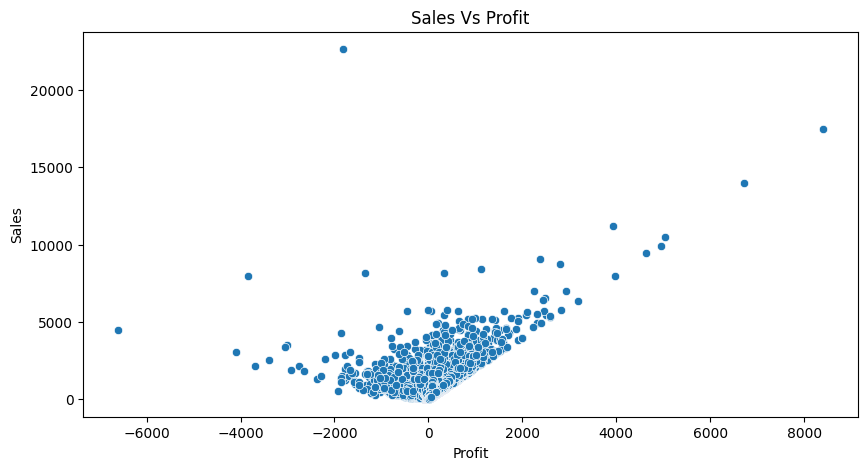

sales    profit
sales   1.000000  0.484923
profit  0.484923  1.000000

In [145]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    data=df,
    x='profit',
    y='sales'
)
plt.title('Sales Vs Profit')
plt.xlabel('Profit')
plt.ylabel('Sales')
plt.show()
df[['sales','profit']].corr()

No Such Insights
    - profit and sales are mildely correlated
    - lets check shipping_cost effect

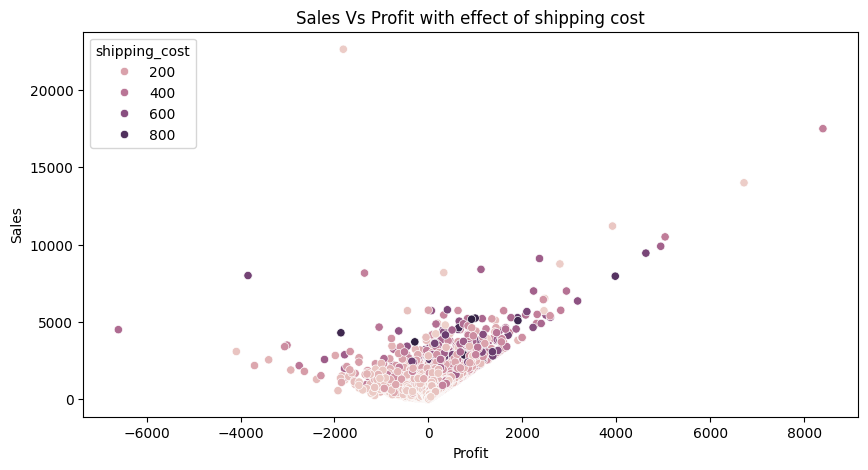

sales    profit  shipping_cost
sales          1.000000  0.484923       0.768067
profit         0.484923  1.000000       0.354441
shipping_cost  0.768067  0.354441       1.000000

In [146]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    data=df,
    x='profit',
    y='sales',
    hue='shipping_cost'
)
plt.title('Sales Vs Profit with effect of shipping cost')
plt.xlabel('Profit')
plt.ylabel('Sales')
plt.show()
df[['sales','profit','shipping_cost']].corr()

- still no reason for loss
    - just fewer Points we see loss due to higher shipping cost
    - since sales is strongly correlated with shipping_cost suggests that sales value is derived by the shipping_cost

let's check the effect of discount

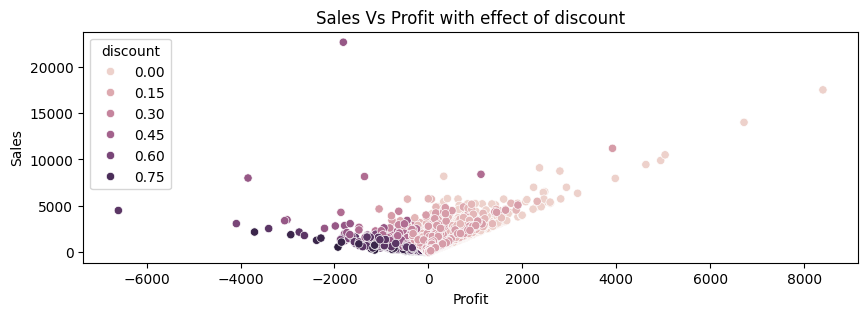

sales    profit  discount  shipping_cost
sales          1.000000  0.484923 -0.086728       0.768067
profit         0.484923  1.000000 -0.316490       0.354441
discount      -0.086728 -0.316490  1.000000      -0.079077
shipping_cost  0.768067  0.354441 -0.079077       1.000000

In [147]:
plt.figure(figsize=(10,3))
sns.scatterplot(
    data=df,
    x='profit',
    y='sales',
    hue='discount'
)
plt.title('Sales Vs Profit with effect of discount')
plt.xlabel('Profit')
plt.ylabel('Sales')
plt.show()

df[['sales','profit','discount','shipping_cost']].corr()

### Ahh!
- we could see that whereever the discount is given more than required drives the loss
    - before providing such discounts options to customers,do test profit margin with different discount amount
    - whichever discount amount is suitable and does not drives loss to company,provide only those discount to the customer
- we can see from the correlation table that
    - profit 
        - is positively correlated with shipping_cost,hence Orders with higher shipping costs tend to be more profitable because they are typically larger, high-value orders (high Sales). However, we must ensure shipping costs are passed to the customer
        - is positively correlated with sales,hence higher the sales value increases the profit upto certain limits
        - is negatively correlated with Discount,hence higher discount decreases the profit deriving loss

Shipping_cost Vs Profit

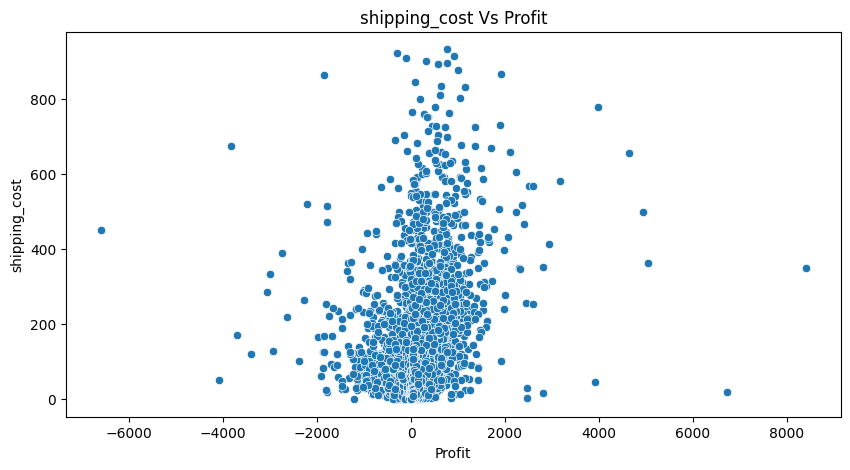

In [148]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    data=df,
    x='profit',
    y='shipping_cost'
)
plt.title('shipping_cost Vs Profit')
plt.xlabel('Profit')
plt.ylabel('shipping_cost')
plt.show()

### Analysis Between Profit Vs categorical columns and sales VS categorical columns

In [149]:
categoric_cols

['category',
 'city',
 'country',
 'customer_id',
 'customer_name',
 'discount',
 'order_priority',
 'product_id',
 'product_name',
 'quantity',
 'region',
 'segment',
 'ship_mode',
 'state',
 'sub_category',
 'year',
 'market2',
 'weeknum',
 'profit_loss',
 'month',
 'month_name',
 'year_month']

sales  vs category

In [150]:
group_sales_category=df.groupby(['category'],as_index=False).agg(
    sales_mean=('sales','mean'),
    sales_median=('sales','median'),
    sales_std=('sales','std'),
    sales_total=('sales','sum')
)
group_sales_category

category  sales_mean  sales_median   sales_std  sales_total
0        Furniture  416.249899         220.0  553.068445      4110884
1  Office Supplies  121.105426          46.0  299.323785      3787330
2       Technology  467.872103         260.0  708.974561      4744691

profit vs category

In [151]:
group_profit_category=df.groupby(['category'],as_index=False).agg(
    profit_mean=('profit','mean'),
    profit_median=('profit','median'),
    profit_std=('profit','std'),
    profit_total=('profit','sum'),

)
group_profit_category


category  profit_mean  profit_median  profit_std  profit_total
0        Furniture    28.878567        15.5022  205.759936  285204.72380
1  Office Supplies    16.578961         6.5538  109.749251  518473.83430
2       Technology    65.454958        29.9400  271.215376  663778.73318

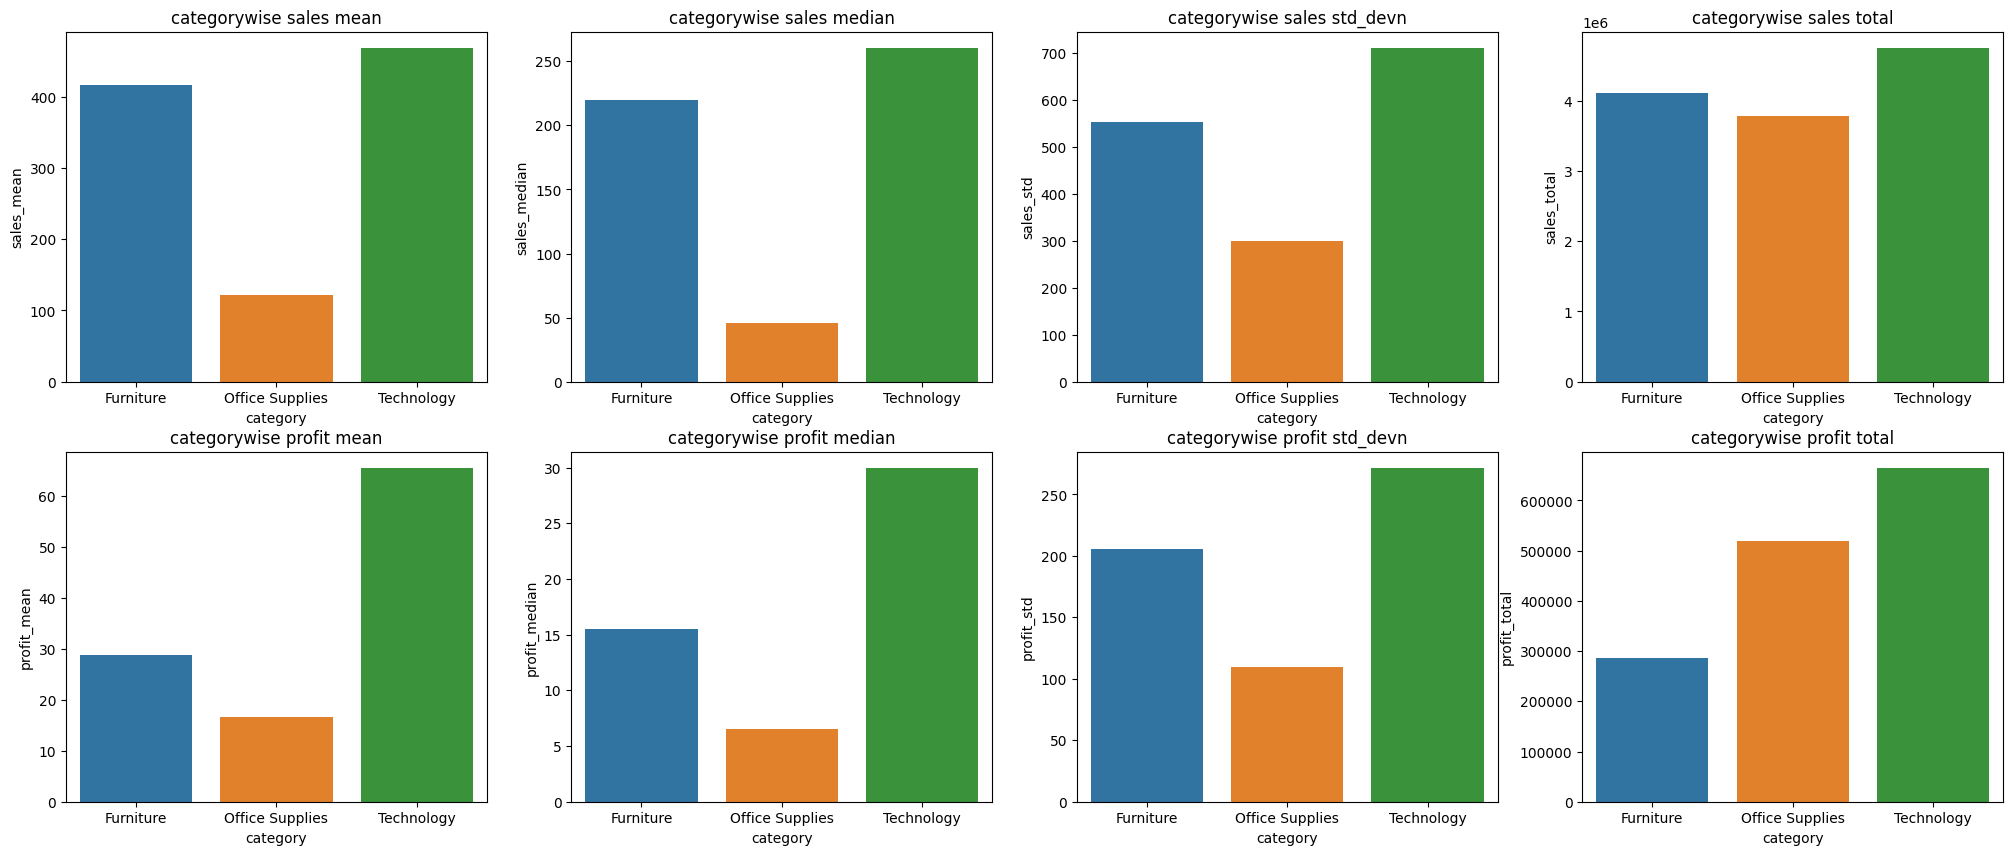

---------------------------- Average Profit Margins----------------------------
Furniture: 6.94 %
Office supplies : 13.69 %
Technology : 13.99 %


----------------------------- Median Profit Margins---------------------------------
Furniture: 7.05 %
Office supplies : 14.25 %
Technology : 11.52 %


---------------------- Standard Deviantions in  Profit Margins-----------------------
Furniture: Sales -> 553.07
Furniture: Profit -> 205.76
Furniture: 37.2 %

Office supplies : sales -> 299.32
Office supplies : Profit -> 109.75
Office supplies : 36.67 %

Technology : Sales -> 708.97
Technology : Profit ->271.22
Technology : 38.25 %


----------------------------- Total Profit Margins---------------------------------
Furniture: 6.94 %
Office supplies : 13.69 %
Technology : 13.99 %


In [152]:
plt.figure(figsize=(25,10))

plt.subplot(2,4,1)
sns.barplot(data=group_sales_category,
            x='category',
            y='sales_mean',
            hue='category')
plt.title('categorywise sales mean')

plt.subplot(2,4,2)
sns.barplot(data=group_sales_category,
            x='category',
            y='sales_median',
            hue='category')
plt.title('categorywise sales median')

plt.subplot(2,4,3)
sns.barplot(data=group_sales_category,
            x='category',
            y='sales_std',
            hue='category')
plt.title('categorywise sales std_devn')

plt.subplot(2,4,4)
sns.barplot(data=group_sales_category,
            x='category',
            y='sales_total',
            hue='category')
plt.title('categorywise sales total')

plt.subplot(2,4,5)
sns.barplot(data=group_profit_category,
            x='category',
            y='profit_mean',
            hue='category')
plt.title('categorywise profit mean')

plt.subplot(2,4,6)
sns.barplot(data=group_profit_category,
            x='category',
            y='profit_median',
            hue='category')
plt.title('categorywise profit median')


plt.subplot(2,4,7)
sns.barplot(data=group_profit_category,
            x='category',
            y='profit_std',
            hue='category')
plt.title('categorywise profit std_devn')

plt.subplot(2,4,8)
sns.barplot(data=group_profit_category,
            x='category',
            y='profit_total',
            hue='category')
plt.title('categorywise profit total')
plt.show()

print('---------------------------- Average Profit Margins----------------------------')
print(f"Furniture: {round((group_profit_category['profit_mean'][0]/group_sales_category['sales_mean'][0])*100,2)} %")
print(f"Office supplies : {round((group_profit_category['profit_mean'][1]/group_sales_category['sales_mean'][1])*100,2)} %")
print(f"Technology : {round((group_profit_category['profit_mean'][2]/group_sales_category['sales_mean'][2])*100,2)} %")
print()
print()
print('----------------------------- Median Profit Margins---------------------------------')
print(f"Furniture: {round((group_profit_category['profit_median'][0]/group_sales_category['sales_median'][0])*100,2)} %")
print(f"Office supplies : {round((group_profit_category['profit_median'][1]/group_sales_category['sales_median'][1])*100,2)} %")
print(f"Technology : {round((group_profit_category['profit_median'][2]/group_sales_category['sales_median'][2])*100,2)} %")
print()
print()
print('---------------------- Standard Deviantions in  Profit Margins-----------------------')
print(f"Furniture: Sales -> {round((group_sales_category['sales_std'][0]),2)}")
print(f"Furniture: Profit -> {round((group_profit_category['profit_std'][0]),2)}")
print(f"Furniture: {round((group_profit_category['profit_std'][0]/group_sales_category['sales_std'][0])*100,2)} %")
print()
print(f"Office supplies : sales -> {round((group_sales_category['sales_std'][1]),2)}")
print(f"Office supplies : Profit -> {round((group_profit_category['profit_std'][1]),2)}")
print(f"Office supplies : {round((group_profit_category['profit_std'][1]/group_sales_category['sales_std'][1])*100,2)} %")
print()
print(f"Technology : Sales -> {round((group_sales_category['sales_std'][2]),2)}")
print(f"Technology : Profit ->{round((group_profit_category['profit_std'][2]),2)}")
print(f"Technology : {round((group_profit_category['profit_std'][2]/group_sales_category['sales_std'][2])*100,2)} %")
print()
print()
print('----------------------------- Total Profit Margins---------------------------------')
print(f"Furniture: {round((group_profit_category['profit_total'][0]/group_sales_category['sales_total'][0])*100,2)} %")
print(f"Office supplies : {round((group_profit_category['profit_total'][1]/group_sales_category['sales_total'][1])*100,2)} %")
print(f"Technology : {round((group_profit_category['profit_total'][2]/group_sales_category['sales_total'][2])*100,2)} %")

* looking at the Mean,Median,Std_devn and total of sales and profit we can say that:
    - both(sales and Profit) resembles the same trend across the different category of product for Mean,Median and std_devn but have different trend in total.
        - in furniture category:
            - in sales of approx 416.0 makes the profit of approx 28.0 making mean profit of 6%,very low profit margin
            - median of sales comes to be approx 220.0 but the profit is just approx 15.5 which is just 7%,very low
            - Total sales comees to be 4110884.0 but the profit is just approx 285204.0 which is just approx 7%,still very low
            - --
        - in office_supplies category:
            - in sales of approx 121.0 makes the profit of approx 16.0 making mean profit of 13%,though not very good but somekind of decent profit margin
            - median of sales comes to be approx 46.0 and the profit is approx 6.5 which is 14.25 %,which quite decent than Furnitre
            - Total sales comees to be 3787330.0 which is lower than furniture category and the profit is approx 518473.0 which is approx 13.5%,which is quite decent than furniture
            - --
        - in technology category:
            - in sales of approx 467.0 makes the profit of approx 65.0 making approx 14%,though not very good but somekind of decent profit margin
            - median of sales comes to be approx 260.0 and the profit is  approx 30.0 which is 11.5 %,which quite decent than Furnitre
            - Total sales comees to be 4744691.0 which is and the profit is approx 663778.0 which is approx 14%,which is quite decent than furniture

    - Coefficient of Variation across different Categories are approximately Equal still furniture Category Makes very low Profit Despite sharing the same relative volatility profile as Technology and office supplies 
        - It has the SAME structural volatility risk (~37%) as Technology and Ofiice Supplies.
        - But it delivers HALF the returns (Mean Profit $28 vs $65).
        
- Despite having high average sales transaction value (similar to Technology), Furniture fails to convert this into profit, likely due to high shipping costs or excessive discounting.

- --

- adding a new column of discount_amount calculating the actual discount value by discount_amount=discount*sales

In [153]:
df['discount_amount']=df['discount']*df['sales']

In [154]:
def merge_melted(df:pd.DataFrame,common_cols:list,no_of_melts:int,list_tuples_variables:list):
    common_cols=common_cols
    if isinstance(common_cols,str):
        common_cols=[common_cols]
    no_of_melts=no_of_melts
    melteds={}
    if len(list_tuples_variables)<1:
        raise ValueError('Atleast 1 tuple must be passed')
    for i,curr_melt in enumerate(list_tuples_variables):
        if len(curr_melt)<3:
            raise ValueError('length of tuples must be greater or equal to 3')
        try:
            melting_columns=curr_melt[:-2]
            melted_variable_name=curr_melt[-2]
            variable_value_name=curr_melt[-1]
            melted_df=df.melt(id_vars=common_cols,
                            value_vars=list(melting_columns),
                            var_name=melted_variable_name,
                            value_name=variable_value_name)
            melted_df['type']=melted_df[melted_variable_name].apply(lambda x:x.split('_')[0])
            melteds['melt'+str(i)]=melted_df
        except Exception as e:
            print(f"Error in melt {i}: {e}")
    melteds=list(melteds.values())
    if not melteds:
        return f'Empty melted list'
    common_cols=common_cols+['type']
    final_df=melteds[0]
    try:
        for i in range(1,len(melteds)):
            merged_melted=pd.merge(left=final_df,right=melteds[i],on=common_cols,how='inner')
            final_df=merged_melted
    except Exception as e:
        print(f"Error in merge: {e}")
    return final_df

## city VS Sales/Profit/discount

City having Only One order Record has Nan in sale/profit standard deviation

In [155]:
city_agg=df.groupby(['city'],as_index=False).agg(
    sales_mean=('sales','mean'),
    profit_mean=('profit','mean'),
    discount_mean=('discount_amount','mean'),
    sales_median=('sales','median'),
    profit_median=('profit','median'),
    discount_median=('discount','median'),
    sales_std=('sales','std'),
    profit_std=('profit','std'),
    discount_std=('discount_amount','std'),
    sales_total=('sales','sum'),
    profit_total=('profit','sum'),
    discount_total=('discount_amount','sum'),
    order_count=('city','count')
    ).sort_values(by=['sales_total'],ascending=False)
city_agg

city  sales_mean  profit_mean  discount_mean  sales_median  \
2290  New York City  280.215301    67.799982      21.926667          61.0   
1910    Los Angeles  235.417671    40.750680      29.185743          69.0   
1996         Manila  279.851852   -25.830003      83.621528         102.5   
2936        Seattle  279.327103    68.121721      20.418692          65.5   
2843  San Francisco  220.960784    34.328207      25.407549          49.0   
...             ...         ...          ...            ...           ...   
2383   Ormond Beach    3.000000    -1.965600       2.100000           3.0   
1010         Elyria    2.000000    -1.398400       1.400000           2.0   
1570        Jupiter    2.000000     0.154800       0.400000           2.0   
2479      Pensacola    2.000000    -1.476000       1.400000           2.0   
12          Abilene    1.000000    -3.758400       0.800000           1.0   

      profit_median  discount_median   sales_std  profit_std  discount_std  \
2290       13.78800             0.00  710.122528  238.945301    105.815305   
1910       13.73400             0.00  462.180822  101.146352     86.257033   
1996       -8.91975             0.35  430.746265  121.953010    116.461078   
2936       13.44060             0.00  824.003476  350.386799     71.013340   
2843       11.79830             0.00  575.024204   83.739050     77.181864   
...             ...              ...         ...         ...           ...   
2383       -1.96560             0.70         NaN         NaN           NaN   
1010       -1.39840             0.70         NaN         NaN           NaN   
1570        0.15480             0.20         NaN         NaN           NaN   
2479       -1.47600             0.70         NaN         NaN           NaN   
12         -3.75840             0.80         NaN         NaN           NaN   

      sales_total  profit_total  discount_total  order_count  
2290       256397    62036.9837        20062.90          915  
1910       175857    30440.7579        21801.75          747  
1996       120896   -11158.5615        36124.50          432  
2936       119552    29156.0967         8739.20          428  
2843       112690    17507.3854        12957.85          510  
...           ...           ...             ...          ...  
2383            3       -1.9656            2.10            1  
1010            2       -1.3984            1.40            1  
1570            2        0.1548            0.40            1  
2479            2       -1.4760            1.40            1  
12              1       -3.7584            0.80            1  

[3636 rows x 14 columns]

In [156]:
city_agg[city_agg['order_count']<5]['city'].nunique()

1549

### OH My GOD!
- there are 1549 cities where we are able to generate justmax to max 4 order in 4 years mean 1 order a year
-  We are spending effort shipping to 1549 different cities where we have no real foothold."

let's check revenue generated by these cities

In [157]:
(city_agg[city_agg['order_count']<5]['sales_total'].sum()/city_agg['sales_total'].sum())*100

np.float64(7.265039166235924)

In [158]:
(city_agg[city_agg['order_count']<5]['profit_total'].sum()/city_agg['profit_total'].sum())*100

np.float64(9.741001512576572)

- and these cities had just generated
    - 7% of the total revenue in 4 years means 1.75% of average annaul revenue-not good and waste of resources
    - just 9 % of the total profit in 4 years means 2.25% of annual profit or may be it is converting profits into losses due to expenditure in managing the resouces like staff salary,logistics,managing the superstore,maintaing the stocks of different products

cities Order_count<5 cannot determine the consistency of a city in 4 years so
- We filtering for cities with Order Count >= 5 to focus on markets with recurring, multi-year demand patterns, removing 'one-off' transactions that do not reflect systemic performance.
- dataset contains 4 years of data * 1 order per year=4
- choosing 5 to represent 'More than just annual activity'

### More things to consider about cities emerging order count<5

In [159]:
(city_agg[city_agg['order_count']<5]['discount_total'].sum()/city_agg['discount_total'].sum())*100

np.float64(4.785607606266782)

In [160]:
df[df['city'].isin(city_agg[city_agg['order_count']<5]['city'].to_list())]['discount'].value_counts()

discount
0.000    2540
0.200     203
0.100     174
0.400     134
0.500     112
0.600     109
0.150      92
0.700      85
0.002      27
0.300      22
0.800      13
0.402       9
0.350       5
0.250       4
0.450       4
0.470       4
0.270       3
0.070       2
0.170       2
0.550       1
Name: count, dtype: int64

cities emerging ordercount<5 are given just 4% of total discount out which in most orders 0.00 discount is given

In [161]:
9/7

1.2857142857142858

- sales in sporadic market cities - 7% of total_sales
- profit in sporadic market cities - 9% of total_profit
- 9/7=1.28 which shows that profit in these cities are 1.28 times higher than company's average profit margin
    - if special campaigns done with little lucarative discount offers then total revenue as well as profit can go higher

for the current scenario,dropping these cities data for analysis from city aggregated tableas these are bringing noise to the current dataset

In [162]:
city_agg=city_agg[city_agg['order_count']>=5]

In [163]:
citytop20=city_agg.head(20)
citytop20

city  sales_mean  profit_mean  discount_mean  sales_median  \
2290  New York City  280.215301    67.799982      21.926667          61.0   
1910    Los Angeles  235.417671    40.750680      29.185743          69.0   
1996         Manila  279.851852   -25.830003      83.621528         102.5   
2936        Seattle  279.327103    68.121721      20.418692          65.5   
2843  San Francisco  220.960784    34.328207      25.407549          49.0   
2499   Philadelphia  203.137803   -25.768654      67.661453          41.0   
3107         Sydney  376.206642    59.050948      40.133579         114.0   
1508        Jakarta  279.875371    11.356036      60.809674          83.0   
1895         London  309.412811    61.845961      29.688256         101.0   
2106    Mexico City  285.773333    44.474306      19.881540          94.5   
1989        Managua  249.148810    53.136066       2.116911          94.5   
2907  Santo Domingo  177.674944    -8.057780      43.900894          78.0   
276         Bangkok  264.965157   -24.825428      76.388676          99.0   
497        Brisbane  425.438202    59.136489      45.129213         135.0   
2082      Melbourne  314.663830    48.102551      36.889362         127.0   
1202     Gold Coast  361.348259    22.158119      60.176617         143.0   
1400        Houston  171.098143   -26.932489      54.473581          38.0   
2484          Perth  324.702020    43.603545      37.170202         119.0   
2445          Paris  338.588235    55.226936      29.651872         188.0   
3391         Vienna  253.167347    63.921796       0.000000         101.0   

      profit_median  discount_median   sales_std  profit_std  discount_std  \
2290       13.78800             0.00  710.122528  238.945301    105.815305   
1910       13.73400             0.00  462.180822  101.146352     86.257033   
1996       -8.91975             0.35  430.746265  121.953010    116.461078   
2936       13.44060             0.00  824.003476  350.386799     71.013340   
2843       11.79830             0.00  575.024204   83.739050     77.181864   
2499        0.70560             0.20  549.953878  136.382944    201.275278   
3107       11.59200             0.10  656.659358  193.734968     82.436757   
1508       -4.06890             0.27  462.114192  132.498463    128.072998   
1895       13.99200             0.10  555.609929  156.138716     55.358719   
2106       13.05600             0.00  508.839037  126.834291     51.265109   
1989       16.60000             0.00  411.029456   96.496402     31.009322   
2907        0.69600             0.20  287.937011   89.728807     69.224924   
276        -7.34310             0.47  514.354166  161.209531    126.704177   
497        12.93750             0.10  758.125602  179.098849     88.952990   
2082       11.80800             0.10  496.695862  136.886976     67.984323   
1202        4.53300             0.10  570.325169  187.257967    114.580229   
1400        0.36500             0.20  358.724422  188.280724    137.971976   
2484       12.30900             0.10  548.813891  129.085635     76.218930   
2445       19.62000             0.00  447.892372  140.272301     62.778254   
3391       24.00000             0.00  345.852665  102.082836      0.000000   

      sales_total  profit_total  discount_total  order_count  
2290       256397   62036.98370       20062.900          915  
1910       175857   30440.75790       21801.750          747  
1996       120896  -11158.56150       36124.500          432  
2936       119552   29156.09670        8739.200          428  
2843       112690   17507.38540       12957.850          510  
2499       109085  -13837.76740       36334.200          537  
3107       101952   16002.80700       10876.200          271  
1508        94318    3826.98420       20492.860          337  
1895        86945   17378.71500        8342.400          281  
2106        85732   13342.29176        5964.462          300  
1989        83714   17853.71804         711.282          336  
29

In [164]:
citybottom20=city_agg.tail(20)
citybottom20

city  sales_mean  profit_mean  discount_mean  sales_median  \
973           Eagan   26.750000    10.879225       0.000000          23.5   
1682        Kocaeli   35.333333   -26.169000      21.200000          33.5   
1527         Jequié   32.166667     9.026667       0.000000          33.0   
2208           Mubi   26.571429   -41.289857      18.600000          10.0   
3310           Ugep   26.000000   -34.922571      18.200000          23.0   
1784        Larache   35.800000     7.998000       0.000000          25.0   
3425     Viransehir   23.428571   -25.601143      14.057143          18.0   
993       Ekibastuz   31.400000   -53.244600      21.980000          25.0   
2918        Sarkand   30.200000   -57.772800      21.140000          13.0   
3051          Split   29.000000     7.182000       0.000000          22.0   
3557  Yanbu al Bahr   28.600000     5.250000       0.000000          26.0   
1506       Jacobina   26.600000   -20.584800      15.960000          20.0   
1622        Katsina   19.666667   -37.623000      13.766667          10.5   
3030           Soma   23.200000   -17.997600      13.920000          12.0   
1133         Funtua   19.000000   -29.754000      13.300000          12.5   
8          Abeokuta   13.375000   -25.104000       9.362500           7.5   
1549          Jinja   14.714286   -22.281000      10.300000          15.0   
348        Bellevue   17.166667     6.175800       1.333333          17.5   
3023         Sokoto   17.200000   -27.467400      12.040000          12.0   
2099       Mesquite   10.400000   -17.524000       6.760000           6.0   

      profit_median  discount_median  sales_std  profit_std  discount_std  \
973         10.3590              0.0  18.077215    6.848409      0.000000   
1682       -21.5010              0.6  22.914333   19.781539     13.748600   
1527         8.3000              0.0  13.227497    5.684092      0.000000   
2208       -10.4730              0.7  35.785738   70.284716     25.050017   
3310       -25.2780              0.7  28.548205   46.765093     19.983743   
1784         7.8000              0.0  23.317375    2.180280      0.000000   
3425       -16.0800              0.6  22.359615   30.169558     13.415769   
993        -43.6470              0.7  16.425590   35.283788     11.497913   
2918       -27.0990              0.7  33.892477   73.606134     23.724734   
3051         9.3300              0.0  20.784610    5.915426      0.000000   
3557         4.7400              0.0  14.205633    4.517466      0.000000   
1506       -19.0200              0.6  12.817956    5.849068      7.690774   
1622       -19.6770              0.7  20.982532   43.582420     14.687773   
3030       -16.1280              0.6  15.896541   10.631094      9.537924   
1133       -10.3860              0.7  23.520204   43.059835     16.464143   
8           -9.8385              0.7  14.480899   34.048155     10.136629   
1549       -26.7870              0.7   9.304377   15.312232      6.513064   
348          6.9129              0.0   7.756718    2.528400      2.160247   
3023       -25.2540              0.7  16.346253   22.926030     11.442377   
2099        -1.4016              0.6  13.352902   38.967844     11.482508   

      sales_total  profit_total  discount_total  order_count  
973           214       87.0338             0.0            8  
1682          212     -157.0140           127.2            6  
1527          193       54.1600             0.0            6  
2208          186     -289.0290           130.2            7  
3310          182     -244.4580           127.4            7  
1784          179       39.9900             0.0            5  
3425          164     -179.2080            98.4            7  
993           157     -266.2230           109.9            5  
2918          151     -288.8640           105.7            5  
3051          145       35.9100             0.0            5  
3557          143       26.2500             0.0            5  
1506          133     -

In [165]:
citytop20melted=merge_melted(df=citytop20,
                            common_cols='city',
                            no_of_melts=4,
                            list_tuples_variables=[('sales_mean','profit_mean','discount_mean','mean_metrics','mean_values'),
                                                   ('sales_median','profit_median','discount_median','median_metrics','median_values'),
                                                   ('sales_std','profit_std','discount_std','std_metrics','std_values'),
                                                   ('sales_total','profit_total','discount_total','total_metrics','total_values')])
citytop20melted

city   mean_metrics  mean_values      type   median_metrics  \
0   New York City     sales_mean   280.215301     sales     sales_median   
1     Los Angeles     sales_mean   235.417671     sales     sales_median   
2          Manila     sales_mean   279.851852     sales     sales_median   
3         Seattle     sales_mean   279.327103     sales     sales_median   
4   San Francisco     sales_mean   220.960784     sales     sales_median   
5    Philadelphia     sales_mean   203.137803     sales     sales_median   
6          Sydney     sales_mean   376.206642     sales     sales_median   
7         Jakarta     sales_mean   279.875371     sales     sales_median   
8          London     sales_mean   309.412811     sales     sales_median   
9     Mexico City     sales_mean   285.773333     sales     sales_median   
10        Managua     sales_mean   249.148810     sales     sales_median   
11  Santo Domingo     sales_mean   177.674944     sales     sales_median   
12        Bangkok     sales_mean   264.965157     sales     sales_median   
13       Brisbane     sales_mean   425.438202     sales     sales_median   
14      Melbourne     sales_mean   314.663830     sales     sales_median   
15     Gold Coast     sales_mean   361.348259     sales     sales_median   
16        Houston     sales_mean   171.098143     sales     sales_median   
17          Perth     sales_mean   324.702020     sales     sales_median   
18          Paris     sales_mean   338.588235     sales     sales_median   
19         Vienna     sales_mean   253.167347     sales     sales_median   
20  New York City    profit_mean    67.799982    profit    profit_median   
21    Los Angeles    profit_mean    40.750680    profit    profit_median   
22         Manila    profit_mean   -25.830003    profit    profit_median   
23        Seattle    profit_mean    68.121721    profit    profit_median   
24  San Francisco    profit_mean    34.328207    profit    profit_median   
25   Philadelphia    profit_mean   -25.768654    profit    profit_median   
26         Sydney    profit_mean    59.050948    profit    profit_median   
27        Jakarta    profit_mean    11.356036    profit    profit_median   
28         London    profit_mean    61.845961    profit    profit_median   
29    Mexico City    profit_mean    44.474306    profit    profit_median   
30        Managua    profit_mean    53.136066    profit    profit_median   
31  Santo Domingo    profit_mean    -8.057780    profit    profit_median   
32        Bangkok    profit_mean   -24.825428    profit    profit_median   
33       Brisbane    profit_mean    59.136489    profit    profit_median   
34      Melbourne    profit_mean    48.102551    profit    profit_median   
35     Gold Coast    profit_mean    22.158119    profit    profit_median   
36        Houston    profit_mean   -26.932489    profit    profit_median   
37          Perth    profit_mean    43.603545    profit    profit_median   
38          Paris    profit_mean    55.226936    profit    profit_median   
39         Vienna    profit_mean    63.921796    profit    profit_median   
40  New York City  discount_mean    21.926667  discount  discount_median   
41    Los Angeles  discount_mean    29.185743  discount  discount_median   
42         Manila  discount_mean    83.621528  discount  discount_median   
43        Seattle  discount_mean    20.418692  discount  discount_median   
44  San Francisco  discount_mean    25.407549  discount  discount_median   
45   Philadelphia  discount_mean    67.661453  discount  discount_median   
46         Sydney  discount_mean    40.133579  discount  discount_median   
47        Jakarta  discount_mean    60.809674  discount  discount_median   
48         London  discount_mean    29.688256  discount  discount_median   
49    Mexico City  discount_mean    19.881540  discount  discount_median   
50        Managua  discount_mean     2.116911  discount  discount_median   
51  Santo Domingo  discount_mean    43.900894  discount  disc

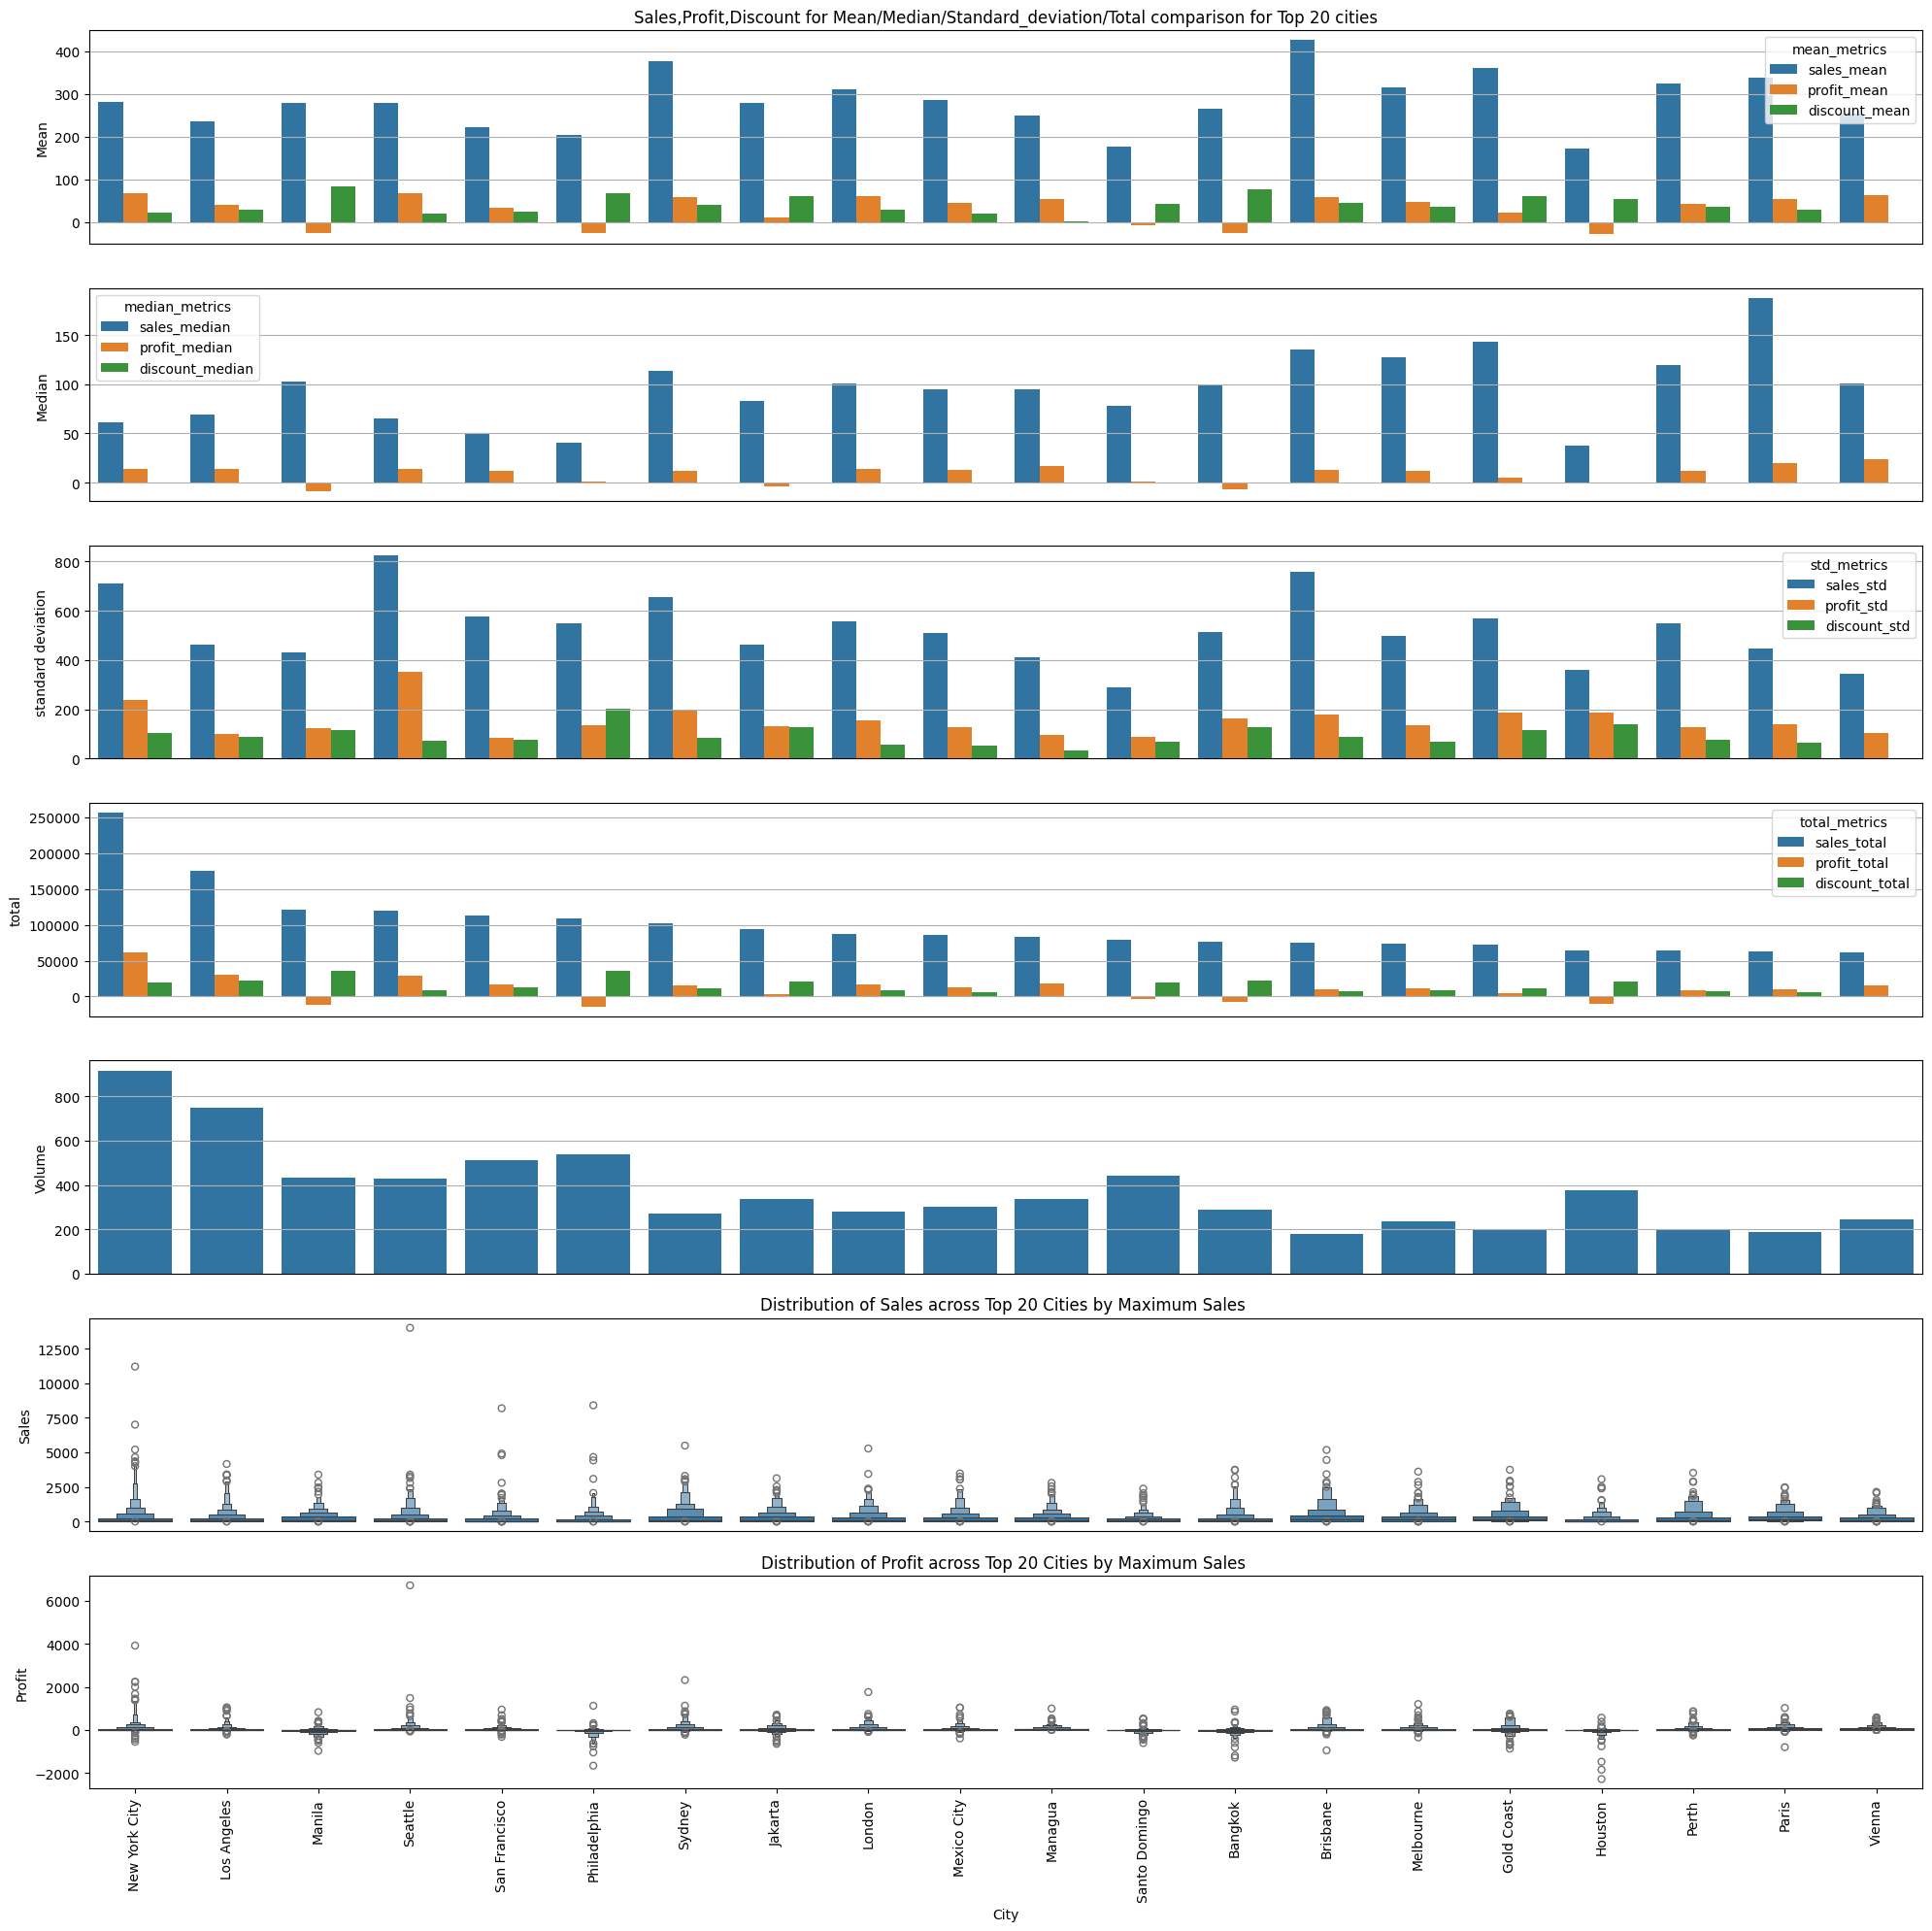

In [166]:
plt.figure(figsize=(20,20))
order=citytop20.sort_values(by=['sales_total'],ascending=False)['city'].to_list()


plt.subplot(7,1,1)
sns.barplot(data=citytop20melted,x='city',y='mean_values',hue='mean_metrics',palette='tab10',order=order)
plt.title('Sales,Profit,Discount for Mean/Median/Standard_deviation/Total comparison for Top 20 cities')
plt.xlabel('')
plt.ylabel('Mean')
plt.grid()
plt.xticks([])

plt.subplot(7,1,2)
sns.barplot(data=citytop20melted,x='city',y='median_values',hue='median_metrics',palette='tab10',order=order)
plt.xlabel('')
plt.ylabel('Median')
plt.grid()
plt.xticks([])

plt.subplot(7,1,3)
sns.barplot(data=citytop20melted,x='city',y='std_values',hue='std_metrics',palette='tab10',order=order)
plt.xlabel('')
plt.ylabel('standard deviation')
plt.grid()
plt.xticks([])

plt.subplot(7,1,4)
sns.barplot(data=citytop20melted,x='city',y='total_values',hue='total_metrics',palette='tab10',order=order)
plt.xlabel('')
plt.ylabel('total')
plt.xticks([])
plt.grid()
plt.tight_layout()

plt.subplot(7,1,5)
sns.barplot(data=citytop20,x='city',y='order_count',order=order)
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks([])
plt.grid()
plt.tight_layout()

plt.subplot(7,1,6)
sns.boxenplot(data=df[df['city'].isin(citytop20['city'])],
            y='sales',
            x='city',
            order=order)
plt.title('Distribution of Sales across Top 20 Cities by Maximum Sales ')
plt.ylabel('Sales')
plt.xlabel('')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,7)
sns.boxenplot(data=df[df['city'].isin(citytop20['city'])],
            y='profit',
            x='city',
            order=order)
plt.title('Distribution of Profit across Top 20 Cities by Maximum Sales ')
plt.ylabel('Profit')
plt.xlabel('City')
plt.xticks(rotation=90)
plt.tight_layout()


plt.show()

<Axes: >

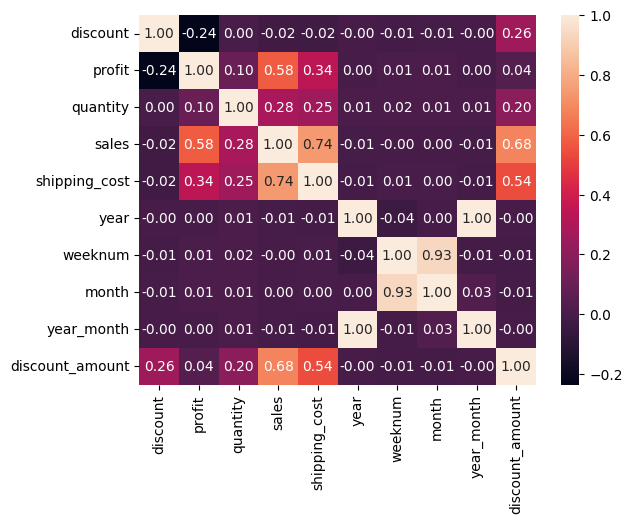

In [167]:
sns.heatmap(df[df['city'].isin(citytop20['city'])][df[df['city'].isin(citytop20['city'])].select_dtypes(include=['number']).columns.to_list()].corr(),annot=True,fmt='.2f')

#### Analysis

- while we see that for to 20 Cities:
    - Mean,Median,Std-devn and Total of sales for is always in Positive direction.
    - Mean,Median,Std-devn and Total of Profit for cities like Manila,Philadelphia,Santo Domingo,BangKok,Houston is very less OR in The NEGATIVE direction despite of volume being Higher
    - Reason for Losses - We can see that Discount is quite higher in these cities
        - prices are lower but the discounts given in these cities are much higher destroying the the profit margin and deriving the loss 
        - volume in these cities are quite higher in these cities compared to cities like sydney,london,brisbane,melbourne,goldcoast,paris but still deriving losses
            - therefore High Volume does not mean high Profit untill and unless the discounts given are limited
            - we can clearly see in the correlation heatmap that discount is inversly correlated with profit and the value is -0.24 which clearly shows that both are mildly correlated
            - we can also see that coorelation value between Quantity and profit is just 0.10 which is very low proves that Volume does not Derive Profit
        - if we look at the Std_devn the we can clarly see that:
            - wherever the spread of discount is very high resulting in lower or negative profits means there is no control behaviour in giving profits
            - wherever the spread of discount is low resulting in highr or positive profits means there is controlled behaviour in giving profits
    - there are few outliers also present in the sales and profit of these cities but that is not the reason for Losses
        - in cities like Seattle,san francisco,london,vienna, the profit is centered around 0 with few outliers extending positive direction
        - while in the loss making cities,few outliers are present in positive direction but also extending in negative direction

    While New York is the model for growth (High Volume + High Profit), cities like Philadelphia and Manila represent a critical inefficiency: we are driving high volume through unsustainable discounting, resulting in a scenario where increased activity leads to increased losses.

In [168]:
citybottom20melted=merge_melted(df=citybottom20,
                            common_cols='city',
                            no_of_melts=4,
                            list_tuples_variables=[('sales_mean','profit_mean','discount_mean','mean_metrics','mean_values'),
                                                   ('sales_median','profit_median','discount_median','median_metrics','median_values'),
                                                   ('sales_std','profit_std','discount_std','std_metrics','std_values'),
                                                   ('sales_total','profit_total','discount_total','total_metrics','total_values')])

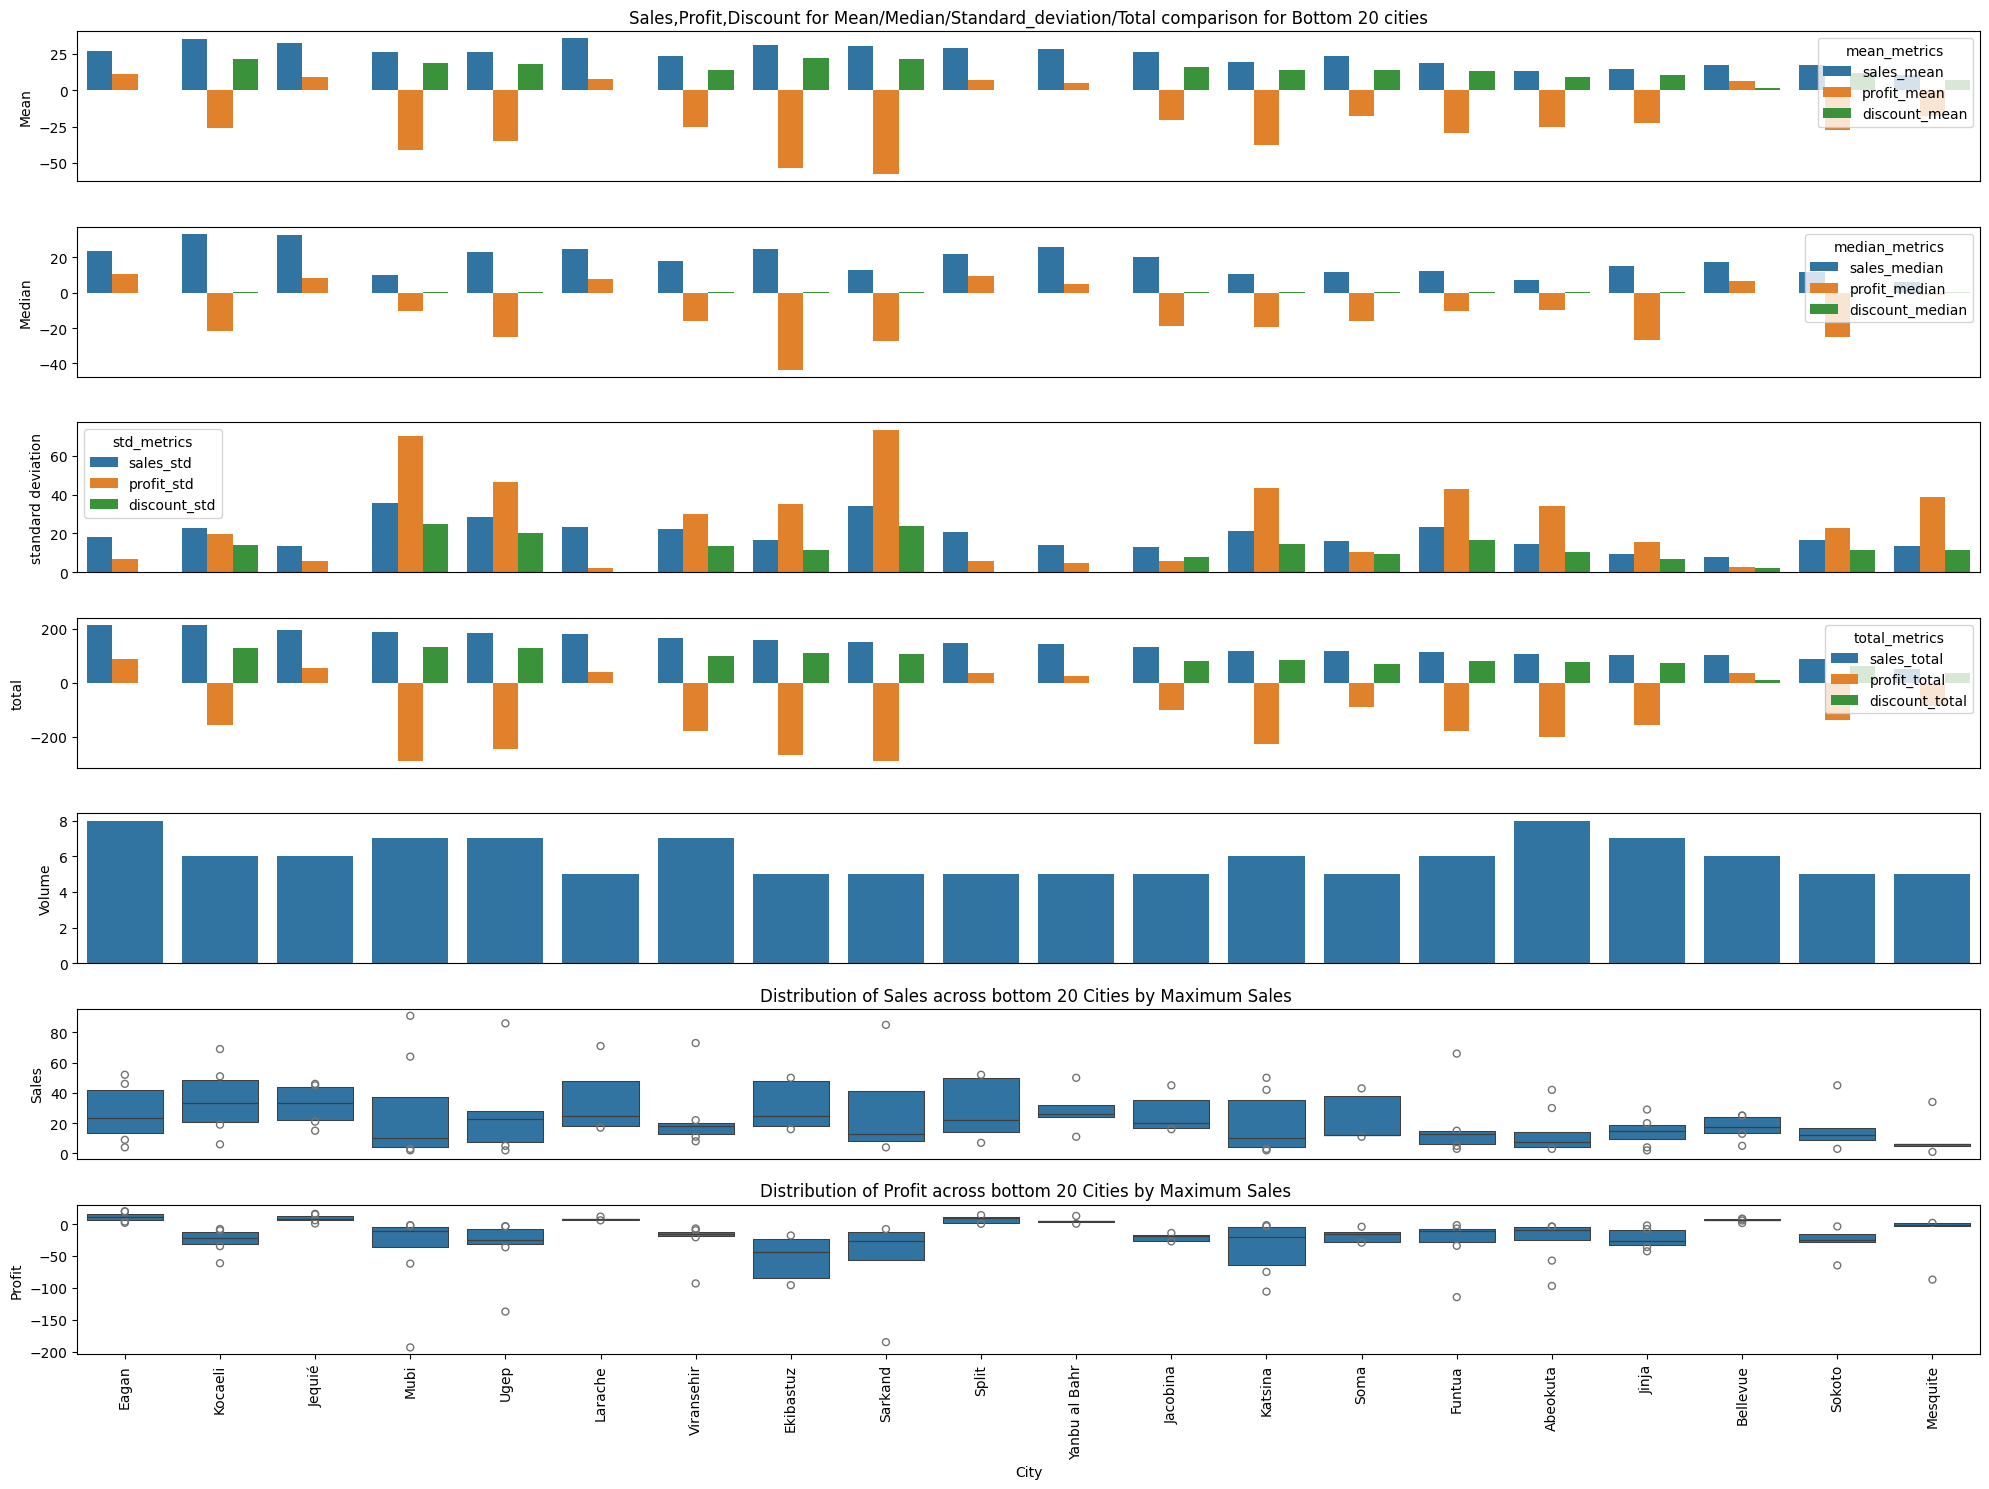

In [169]:
plt.figure(figsize=(20,15))
order=citybottom20.sort_values(by=['sales_total'],ascending=False)['city'].to_list()
plt.subplot(7,1,1)
sns.barplot(data=citybottom20melted,x='city',y='mean_values',hue='mean_metrics',palette='tab10',order=order)
plt.title('Sales,Profit,Discount for Mean/Median/Standard_deviation/Total comparison for Bottom 20 cities')
plt.xlabel('')
plt.ylabel('Mean')
plt.xticks([])

plt.subplot(7,1,2)
sns.barplot(data=citybottom20melted,x='city',y='median_values',hue='median_metrics',palette='tab10',order=order)
plt.xlabel('')
plt.ylabel('Median')
plt.xticks([])

plt.subplot(7,1,3)
sns.barplot(data=citybottom20melted,x='city',y='std_values',hue='std_metrics',palette='tab10',order=order)
plt.xlabel('')
plt.ylabel('standard deviation')
plt.xticks([])

plt.subplot(7,1,4)
sns.barplot(data=citybottom20melted,x='city',y='total_values',hue='total_metrics',palette='tab10',order=order)
plt.xlabel('')
plt.ylabel('total')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,5)
sns.barplot(data=citybottom20,x='city',y='order_count',order=order)
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,6)
sns.boxenplot(data=df[df['city'].isin(citybottom20['city'])],
            y='sales',
            x='city',
            order=order)
plt.title('Distribution of Sales across bottom 20 Cities by Maximum Sales ')
plt.ylabel('Sales')
plt.xlabel('')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,7)
sns.boxenplot(data=df[df['city'].isin(citybottom20['city'])],
            y='profit',
            x='city',
            order=order)
plt.title('Distribution of Profit across bottom 20 Cities by Maximum Sales ')
plt.ylabel('Profit')
plt.xlabel('City')
plt.xticks(rotation=90)
plt.tight_layout()



plt.show()

<Axes: >

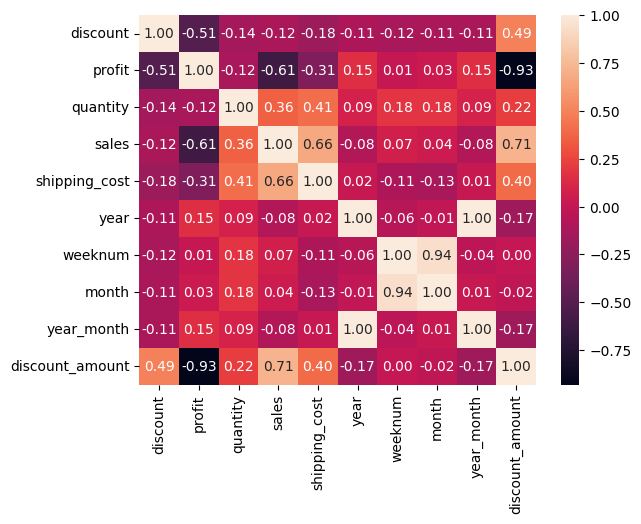

In [170]:
sns.heatmap(df[df['city'].isin(citybottom20['city'])][df[df['city'].isin(citybottom20['city'])].select_dtypes(include=['number']).columns.to_list()].corr(),annot=True,fmt='.2f')

##### Analysis

in the bottom 20 cities:
- volume is very low as compared to the cities in the Top 20
- most of the cities have profit in negative direction
- if we look at the Std_devn the we can clarly see that:
    - wherever the spread of discount is very high resulting in lower or negative profits means there is no control behaviour in giving profits
    - wherever the spread of discount is low resulting in highr or positive profits means there is controlled behaviour in giving profits
- in most of the cities discount_amount scales nearly to sales_value effectively neutralizing any profit gains from high-volume orders
- profit distribution in most of the cities are centered around in the negative direction
- from the correlation heatmap,we can observe that:
    - profit higly,mildly and inversly correlated with discount_amount and discount %age respectively
    - quantity and profit is inversly correlated means more number of deliveries incurring large losses
    - sales and profit are higly and inversly correlated with value of -0.61
        - Higher Sales = Higher Losses
        - This indicates a structural failure where the highest revenue-generating activities are actually the primary source of financial bleeding, likely due to discounts scaling with order size 

## Country VS Profit/Sales

In [171]:
country_agg=df.groupby(['country'],as_index=False).agg(
    sales_mean=('sales','mean'),
    profit_mean=('profit','mean'),
    discount_mean=('discount_amount','mean'),
    sales_median=('sales','median'),
    profit_median=('profit','median'),
    discount_median=('discount','median'),
    sales_std=('sales','std'),
    profit_std=('profit','std'),
    discount_std=('discount_amount','std'),
    sales_total=('sales','sum'),
    profit_total=('profit','sum'),
    discount_total=('discount_amount','sum'),
    order_count=('country','count')
    ).sort_values(by=['sales_total'],ascending=False)
country_agg

country  sales_mean  profit_mean  discount_mean  sales_median  \
139      United States  229.873324    28.656896      32.278464          54.5   
6            Australia  326.139232    36.625814      42.913676         125.0   
44              France  303.830916    38.567033      34.475805         131.0   
26               China  372.654787    80.150577       8.793404         147.0   
47             Germany  304.531235    51.972310      22.156465         127.0   
..                 ...         ...          ...            ...           ...   
127         Tajikistan   80.666667   -87.622000      56.466667           4.0   
75           Macedonia   52.500000    10.845000       0.000000          50.0   
40             Eritrea   94.000000    38.100000       0.000000          94.0   
5              Armenia   52.000000    23.030000       0.000000          42.0   
39   Equatorial Guinea   50.000000    14.820000       0.000000          20.0   

     profit_median  discount_median   sales_std  profit_std  discount_std  \
139         8.6665              0.2  623.248946  234.260108    164.024386   
6           9.4050              0.1  553.287701  150.195825     88.274950   
44         16.4400              0.0  466.927919  138.327805     83.304568   
26         28.2750              0.0  583.648629  173.441537     63.010811   
47         19.3200              0.0  479.429293  159.903897     76.998989   
..             ...              ...         ...         ...           ...   
127        -7.9920              0.7  133.657523  141.528930     93.560266   
75          8.6100              0.0   36.124784    7.595216      0.000000   
40         38.1000              0.0  107.480231   49.384338      0.000000   
5          21.0300              0.0   38.000000   21.250704      0.000000   
39          2.1600              0.0   64.467046   23.769619      0.000000   

     sales_total  profit_total  discount_total  order_count  
139      2297354   286397.0217       322590.97         9994  
6         925257   103907.4330       121746.10         2837  
44        858930   109029.0030        97463.10         2827  
26        700591   150683.0850        16531.60         1880  
47        628857   107322.8205        45753.10         2065  
..           ...           ...             ...          ...  
127          242     -262.8660          169.40            3  
75           210       43.3800            0.00            4  
40           188       76.2000            0.00            2  
5            156       69.0900            0.00            3  
39           150       44.4600            0.00            3  

[147 rows x 14 columns]

In [172]:
countrytop20=country_agg.head(20)
countrybottom20=country_agg.tail(20)

In [173]:
countrybottom20['order_count'].values

array([25, 13, 14, 37,  3,  8,  2,  2,  8,  7,  7, 14,  2,  2,  2,  3,  4,
        2,  3,  3])

- in the bottom 20 countres we found that there are few large order_counts and most are less than even 10
- let's calculate a thresold to filterout countries having orders less than the thresold

In [174]:
country_agg['order_count'].describe()

count     147.000000
mean      348.911565
std       959.003492
min         2.000000
25%        20.000000
50%        70.000000
75%       313.000000
max      9994.000000
Name: order_count, dtype: float64

- the above description says that min order_count is just 2
- 25th percentle is 20
- we have 4 years of data - 20/4 = 5 means 5 orders per year per country which is kindof logical
- so countries where the order_count is less than 20 will be filtered out as those are noise markets that generate fewer than 5 orders per year identifying them as non-systematic markets

In [175]:
country_agg[country_agg['order_count']>20]

country  sales_mean  profit_mean  discount_mean  sales_median  \
139     United States  229.873324    28.656896      32.278464          54.5   
6           Australia  326.139232    36.625814      42.913676         125.0   
44             France  303.830916    38.567033      34.475805         131.0   
26              China  372.654787    80.150577       8.793404         147.0   
47            Germany  304.531235    51.972310      22.156465         127.0   
..                ...         ...          ...            ...           ...   
146          Zimbabwe   47.087500   -67.859813      32.961250          16.5   
98   Papua New Guinea  133.090909   -19.027500      37.977273          48.5   
144             Yemen   82.133333  -123.548600      57.493333          27.5   
134      Turkmenistan   81.160000  -132.108360      56.812000          29.0   
135            Uganda   43.918919   -65.569865      30.743243          18.0   

     profit_median  discount_median   sales_std  profit_std  discount_std  \
139         8.6665              0.2  623.248946  234.260108    164.024386   
6           9.4050              0.1  553.287701  150.195825     88.274950   
44         16.4400              0.0  466.927919  138.327805     83.304568   
26         28.2750              0.0  583.648629  173.441537     63.010811   
47         19.3200              0.0  479.429293  159.903897     76.998989   
..             ...              ...         ...         ...           ...   
146       -27.8670              0.7   90.081847  135.871779     63.057293   
98         -8.9700              0.5  244.285335   59.270313     49.786314   
144       -52.6275              0.7  140.323698  182.539824     98.226589   
134       -47.1660              0.7  103.358873  175.417076     72.351211   
135       -31.1910              0.7   48.908292   89.251371     34.235804   

     sales_total  profit_total  discount_total  order_count  
139      2297354   286397.0217       322590.97         9994  
6         925257   103907.4330       121746.10         2837  
44        858930   109029.0030        97463.10         2827  
26        700591   150683.0850        16531.60         1880  
47        628857   107322.8205        45753.10         2065  
..           ...           ...             ...          ...  
146         3767    -5428.7850         2636.90           80  
98          2928     -418.6050          835.50           22  
144         2464    -3706.4580         1724.80           30  
134         2029    -3302.7090         1420.30           25  
135         1625    -2426.0850         1137.50           37  

[110 rows x 14 columns]

In [176]:
country_agg[country_agg['order_count']<20]

country   sales_mean  profit_mean  discount_mean  \
126                    Taiwan   546.285714   129.900000       0.000000   
71                    Lesotho  1118.666667   233.035000       0.000000   
104                     Qatar   378.125000    93.930000       0.000000   
41                    Estonia   344.538462    85.398462       0.000000   
80                 Mauritania   402.000000   167.595000       0.000000   
84                 Montenegro  1001.000000   321.690000       0.000000   
1                     Albania   243.000000    44.332500       0.000000   
72                    Liberia   237.400000    69.660000       0.000000   
89                      Nepal   185.368421    46.181053       0.000000   
51                     Guinea   194.333333    52.846667       0.000000   
88                    Namibia   322.111111    81.883333       0.000000   
70                    Lebanon   233.083333    75.700000       0.000000   
105     Republic of the Congo   452.333333    46.790000       0.000000   
16     Bosnia and Herzegovina   152.941176    38.834118       0.000000   
99                   Paraguay   215.916667    34.602293       0.105833   
111              Sierra Leone   163.266667    31.450000       0.000000   
34                   Djibouti   199.500000    67.007500       0.000000   
23   Central African Republic   339.428571    66.934286       0.000000   
52              Guinea-Bissau   229.444444    45.710000       0.000000   
132                   Tunisia   135.538462    46.315385       0.000000   
45                      Gabon   125.142857    34.262143       0.000000   
114                  Slovenia   489.666667   196.680000       0.000000   
49                 Guadeloupe   182.750000    59.525000       0.000000   
24                       Chad   658.500000    45.000000       0.000000   
118               South Sudan   522.500000    93.180000       0.000000   
113                  Slovakia   108.250000    14.407500       0.000000   
120                 Sri Lanka   121.714286    12.338571       0.000000   
42                   Ethiopia   121.428571    41.451429       0.000000   
137      United Arab Emirates    53.000000   -74.061429      37.100000   
9                     Bahrain   334.500000     6.420000       0.000000   
122                 Swaziland   144.000000    43.380000       0.000000   
19                    Burundi   134.000000    51.540000       0.000000   
127                Tajikistan    80.666667   -87.622000      56.466667   
75                  Macedonia    52.500000    10.845000       0.000000   
40                    Eritrea    94.000000    38.100000       0.000000   
5                     Armenia    52.000000    23.030000       0.000000   
39          Equatorial Guinea    50.000000    14.820000       0.000000   

     sales_median  profit_median  discount_median    sales_std  profit_std  \
126         203.0        49.6500              0.0   715.562977  193.793743   
71          121.5        40.2000              0.0  1639.415587  331.551631   
104         141.5        19.8000              0.0   700.059986  189.985934   
41          133.0        35.8200              0.0   491.099891  138.142738   
80           49.5        12.3300              0.0   541.614254  258.152803   
84          379.5       157.0800              0.0  1502.726189  441.510343   
1            95.5        15.3450              0.0   401.913589   75.716710   
72          100.0        29.2800              0.0   356.908512  119.221767   
89           76.0        23.5800              0.0   205.101387   69.685362   
51          116.0        13.9500              0.0   222.175606   97.807151   
88          141.0         8.8500              0.0   479.066395  153.961206   
70          160.5        57.0150              0.0   217.160794   65.922569   
105         252.5        40.5150              0.0   600.887566   36.098568   
16           93.0        16.1400              0.0   177.245053   71.717181   
99          123.5        28.2000       

In [177]:
(country_agg[country_agg['order_count']<20]['sales_total'].sum()/country_agg['sales_total'].sum())*100

np.float64(0.6687940785760867)

In [178]:
(country_agg[country_agg['order_count']<20]['profit_total'].sum()/country_agg['profit_total'].sum())*100

np.float64(1.3346208871889456)

In [179]:
(country_agg[country_agg['order_count']<20]['discount_total'].sum()/country_agg['discount_total'].sum())*100

np.float64(0.05125391175852869)

In [180]:
df[df['country'].isin(country_agg[country_agg['order_count']<20]['country'].to_list())]['discount'].value_counts()

discount
0.000    311
0.700     17
0.002      1
Name: count, dtype: int64

In [181]:
((country_agg[country_agg['order_count']<20]['profit_total'].sum()/country_agg['profit_total'].sum())*100)/((country_agg[country_agg['order_count']<20]['sales_total'].sum()/country_agg['sales_total'].sum())*100)

np.float64(1.995563253237012)

- countries producing order count<20  raises just 0.6% of the total sales
- countries producing order count<20  raises just 1.3% of the total profit
- countries producing order count<20  getting just 0.05% of the total discount Value
- countries producing order count<20  getting 0.00 discount most of the times
- profit generated by countries producing order count<20 is 1.9 times higher than company's average profit
    - this shos that if a proper campaigns are runned across these countries according to peoples providing little lucarative and attractive offers in these countries
    - can increase the total revenue and profit generated from these countries
- for the current dataset presence,we are dropping the countries where the order_count is less than 20 from the countrywise aggregated table

In [182]:
country_agg=country_agg[country_agg['order_count']>=20]

In [183]:
countrytop20=country_agg.head(20)
countrybottom20=country_agg.tail(20)

In [184]:
countrytop20melted=merge_melted(df=countrytop20,
                                common_cols='country',
                                no_of_melts=4,
                                list_tuples_variables=[('sales_mean','profit_mean','discount_mean','mean_metrics','mean_values'),
                                                   ('sales_median','profit_median','discount_median','median_metrics','median_values'),
                                                   ('sales_std','profit_std','discount_std','std_metrics','std_values'),
                                                   ('sales_total','profit_total','discount_total','total_metrics','total_values')])
countrytop20melted

country   mean_metrics  mean_values      type   median_metrics  \
0        United States     sales_mean   229.873324     sales     sales_median   
1            Australia     sales_mean   326.139232     sales     sales_median   
2               France     sales_mean   303.830916     sales     sales_median   
3                China     sales_mean   372.654787     sales     sales_median   
4              Germany     sales_mean   304.531235     sales     sales_median   
5               Mexico     sales_mean   235.484115     sales     sales_median   
6                India     sales_mean   379.205145     sales     sales_median   
7       United Kingdom     sales_mean   323.680343     sales     sales_median   
8            Indonesia     sales_mean   291.285612     sales     sales_median   
9               Brazil     sales_mean   225.827392     sales     sales_median   
10               Italy     sales_mean   261.477437     sales     sales_median   
11               Spain     sales_mean   334.298021     sales     sales_median   
12         Philippines     sales_mean   269.358297     sales     sales_median   
13         El Salvador     sales_mean   241.256793     sales     sales_median   
14         New Zealand     sales_mean   273.920382     sales     sales_median   
15                Cuba     sales_mean   219.421271     sales     sales_median   
16           Nicaragua     sales_mean   243.801303     sales     sales_median   
17           Guatemala     sales_mean   252.608445     sales     sales_median   
18  Dominican Republic     sales_mean   169.995957     sales     sales_median   
19                Iran     sales_mean   187.397035     sales     sales_median   
20       United States    profit_mean    28.656896    profit    profit_median   
21           Australia    profit_mean    36.625814    profit    profit_median   
22              France    profit_mean    38.567033    profit    profit_median   
23               China    profit_mean    80.150577    profit    profit_median   
24             Germany    profit_mean    51.972310    profit    profit_median   
25              Mexico    profit_mean    38.887329    profit    profit_median   
26               India    profit_mean    83.004395    profit    profit_median   
27      United Kingdom    profit_mean    68.524280    profit    profit_median   
28           Indonesia    profit_mean    11.229265    profit    profit_median   
29              Brazil    profit_mean    18.818323    profit    profit_median   
30               Italy    profit_mean    17.895991    profit    profit_median   
31               Spain    profit_mean    63.317951    profit    profit_median   
32         Philippines    profit_mean   -23.683150    profit    profit_median   
33         El Salvador    profit_mean    57.096798    profit    profit_median   
34         New Zealand    profit_mean    26.433573    profit    profit_median   
35                Cuba    profit_mean    53.714386    profit    profit_median   
36           Nicaragua    profit_mean    54.399747    profit    profit_median   
37           Guatemala    profit_mean    53.636635    profit    profit_median   
38  Dominican Republic    profit_mean   -10.260780    profit    profit_median   
39                Iran    profit_mean    44.244217    profit    profit_median   
40       United States  discount_mean    32.278464  discount  discount_median   
41           Australia  discount_mean    42.913676  discount  discount_median   
42              France  discount_mean    34.475805  discount  discount_median   
43               China  discount_mean     8.793404  discount  discount_median   
44             Germany  discount_mean    22.156465  discount  discount_median   
45              Mexico  discount_mean    17.393459  discount  discount_median   
46               India  discount_mean     3.528939  discount  discount_median   
47      United Kingdom  discount_mean    11.908022  discount  discount_median   
48           Indonesia  discount_mean    58.59

In [185]:
countrybottom20melted=merge_melted(df=countrybottom20,
                                common_cols='country',
                                no_of_melts=4,
                                list_tuples_variables=[('sales_mean','profit_mean','discount_mean','mean_metrics','mean_values'),
                                                   ('sales_median','profit_median','discount_median','median_metrics','median_values'),
                                                   ('sales_std','profit_std','discount_std','std_metrics','std_values'),
                                                   ('sales_total','profit_total','discount_total','total_metrics','total_values')])
countrybottom20melted

country   mean_metrics  mean_values      type   median_metrics  \
0           Mongolia     sales_mean   183.486486     sales     sales_median   
1            Jamaica     sales_mean   218.129032     sales     sales_median   
2          Lithuania     sales_mean   134.460000     sales     sales_median   
3              Benin     sales_mean   177.571429     sales     sales_median   
4          Hong Kong     sales_mean   292.761905     sales     sales_median   
5         Martinique     sales_mean   238.720000     sales     sales_median   
6         Azerbaijan     sales_mean   194.137931     sales     sales_median   
7            Georgia     sales_mean   164.484848     sales     sales_median   
8              Syria     sales_mean   183.068966     sales     sales_median   
9             Rwanda     sales_mean   144.361111     sales     sales_median   
10           Moldova     sales_mean   131.769231     sales     sales_median   
11        Kyrgyzstan     sales_mean   127.575000     sales     sales_median   
12        Kazakhstan     sales_mean    45.564356     sales     sales_median   
13           Croatia     sales_mean   139.468750     sales     sales_median   
14              Togo     sales_mean    94.318182     sales     sales_median   
15          Zimbabwe     sales_mean    47.087500     sales     sales_median   
16  Papua New Guinea     sales_mean   133.090909     sales     sales_median   
17             Yemen     sales_mean    82.133333     sales     sales_median   
18      Turkmenistan     sales_mean    81.160000     sales     sales_median   
19            Uganda     sales_mean    43.918919     sales     sales_median   
20          Mongolia    profit_mean    40.714054    profit    profit_median   
21           Jamaica    profit_mean    44.910511    profit    profit_median   
22         Lithuania    profit_mean  -179.322360    profit    profit_median   
23             Benin    profit_mean    38.548286    profit    profit_median   
24         Hong Kong    profit_mean    74.195714    profit    profit_median   
25        Martinique    profit_mean    44.568442    profit    profit_median   
26        Azerbaijan    profit_mean    63.139655    profit    profit_median   
27           Georgia    profit_mean    38.960000    profit    profit_median   
28             Syria    profit_mean    23.903793    profit    profit_median   
29            Rwanda    profit_mean    37.123333    profit    profit_median   
30           Moldova    profit_mean    28.903077    profit    profit_median   
31        Kyrgyzstan    profit_mean    43.383000    profit    profit_median   
32        Kazakhstan    profit_mean   -70.296000    profit    profit_median   
33           Croatia    profit_mean    40.747500    profit    profit_median   
34              Togo    profit_mean    18.565227    profit    profit_median   
35          Zimbabwe    profit_mean   -67.859813    profit    profit_median   
36  Papua New Guinea    profit_mean   -19.027500    profit    profit_median   
37             Yemen    profit_mean  -123.548600    profit    profit_median   
38      Turkmenistan    profit_mean  -132.108360    profit    profit_median   
39            Uganda    profit_mean   -65.569865    profit    profit_median   
40          Mongolia  discount_mean     0.540541  discount  discount_median   
41           Jamaica  discount_mean     0.041032  discount  discount_median   
42         Lithuania  discount_mean    94.122000  discount  discount_median   
43             Benin  discount_mean     0.000000  discount  discount_median   
44         Hong Kong  discount_mean     0.000000  discount  discount_median   
45        Martinique  discount_mean     0.041040  discount  discount_median   
46        Azerbaijan  discount_mean     0.000000  discount  discount_median   
47           Georgia  discount_mean     0.000000  discount  discount_median   
48             Syria  discount_mean    35.200000  discount  discount_median   
49            Rwanda  discount_mean     0.000000  discount  dis

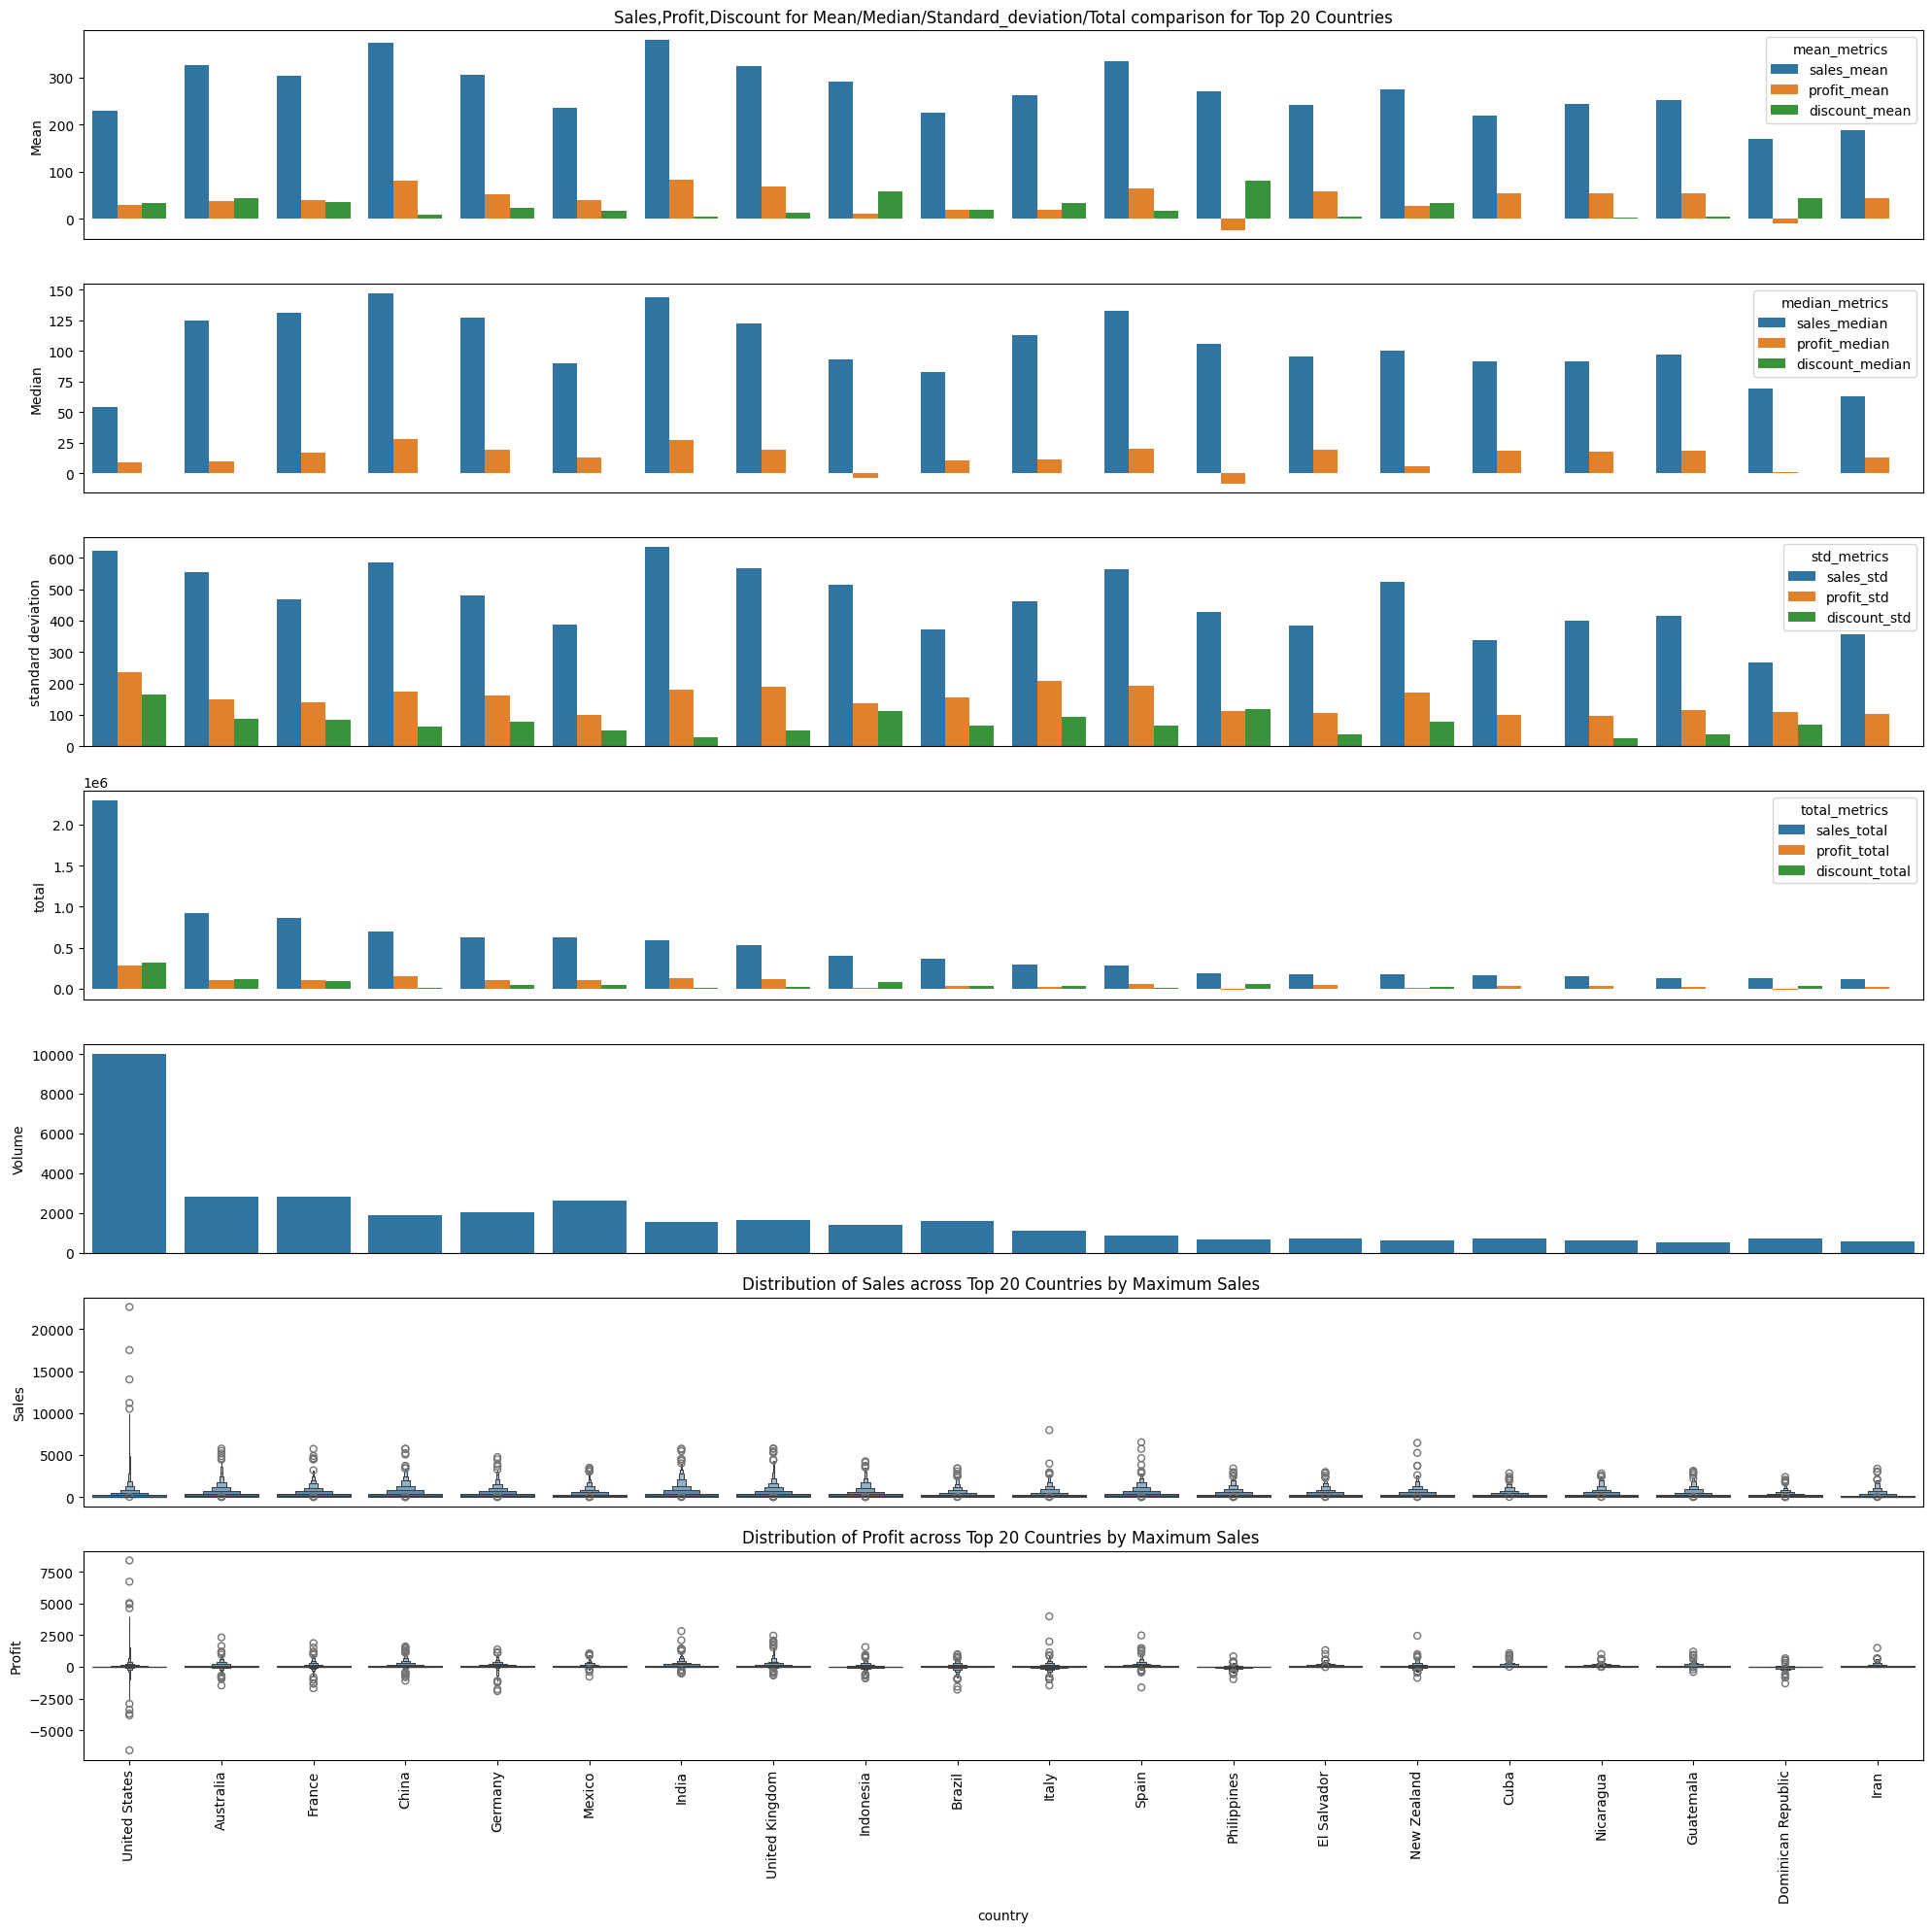

In [186]:
plt.figure(figsize=(20,20))
order=countrytop20.sort_values(by=['sales_total'],ascending=False)['country'].to_list()
plt.subplot(7,1,1)
sns.barplot(data=countrytop20melted,x='country',y='mean_values',hue='mean_metrics',palette='tab10',order=order)
plt.title('Sales,Profit,Discount for Mean/Median/Standard_deviation/Total comparison for Top 20 Countries')
plt.xlabel('')
plt.ylabel('Mean')
plt.xticks([])

plt.subplot(7,1,2)
sns.barplot(data=countrytop20melted,x='country',y='median_values',hue='median_metrics',palette='tab10',order=order)
plt.xlabel('')
plt.ylabel('Median')
plt.xticks([])

plt.subplot(7,1,3)
sns.barplot(data=countrytop20melted,x='country',y='std_values',hue='std_metrics',palette='tab10',order=order)
plt.xlabel('')
plt.ylabel('standard deviation')
plt.xticks([])

plt.subplot(7,1,4)
sns.barplot(data=countrytop20melted,x='country',y='total_values',hue='total_metrics',palette='tab10',order=order)
plt.xlabel('')
plt.ylabel('total')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,5)
sns.barplot(data=countrytop20,x='country',y='order_count',order=order)
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,6)
sns.boxenplot(data=df[df['country'].isin(countrytop20['country'])],
            y='sales',
            x='country',
            order=order)
plt.title('Distribution of Sales across Top 20 Countries by Maximum Sales ')
plt.ylabel('Sales')
plt.xlabel('')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,7)
sns.boxenplot(data=df[df['country'].isin(countrytop20['country'])],
            y='profit',
            x='country',
            order=order)
plt.title('Distribution of Profit across Top 20 Countries by Maximum Sales ')
plt.ylabel('Profit')
plt.xlabel('country')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

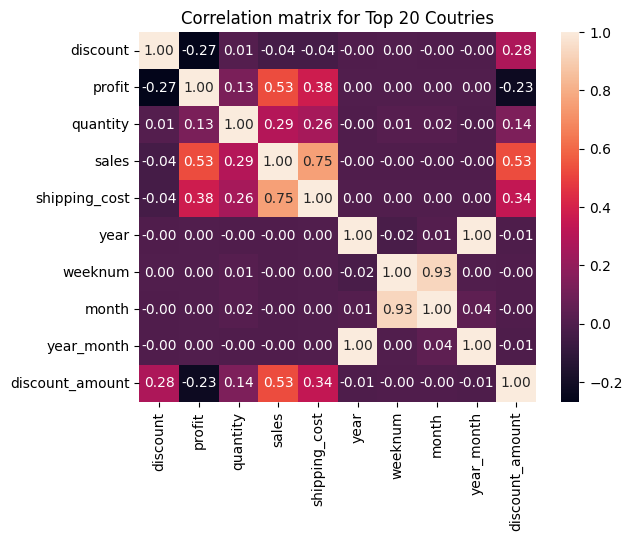

In [187]:
sns.heatmap(data=df[df['country'].isin(countrytop20['country'])][df[df['country'].isin(countrytop20['country'])].select_dtypes(include='number').columns.to_list()].corr(),annot=True,fmt='.2f')
plt.title("Correlation matrix for Top 20 Coutries")
plt.show()

### Analysis

#### from the aspect of Countries:
- in Top 20 Countries:
    - mean,median and total of sales and Profit in almost every country is in positive direction
    - few countries like Indonesia and philippines
        - median profit is in negative direction
            - many of the orders are sold at losses in these countries pushing the median profit in negative direction
        - mean profit in Indonesia is in negative direction
            - many of the orders are sold at losses neutralizing or even pushing the mean profit earned towards the negative direction
    - if we look at the total sales and profit,every country is in positive direction though the countries like Indonesia,Brazil,philippines,Italy,Spain,NewZealand,cuba ahve very low total sales and Profit Values
    - US has very huge number of orders while countries like Australia,France,china,germany,mexico,India has relatively low number of orders Than US but countries from brazil to Iran has very very low number of orders
    - Profit Distribution shows that in almost every countries the profit is extending in both direction due to which positive profit in high sales values gets effected due to negative profits in low sales values shirinking the profit to very low
    - if we look at the US total, then discount is way higher than the profit despite the sales are much higher is key reason US having Very high sales and volume orders converting it to very low profits
    - from the correlation Heatmap we can observe that:
        - discount and discount_amount are inversly correlated with Profit both with the value of -0.27 and -0.23
            - clearly shows that Profit is mildly affected by the Discounts
        -  sales and Profit are directly coorelated with the value of 0.53
            - shows that Higher sales = higher Profit
        - shipping_cost and profit is directly correlated with value of 0.38 and shipping_cost is directly correlated to sales with value of 0.75
            - high sales => higher shipping_cost => higher Profit
        - quantity and profit is directly correlated with profit with value of 0.13
            - higher quantity != higher profit

Bottom 20 countries

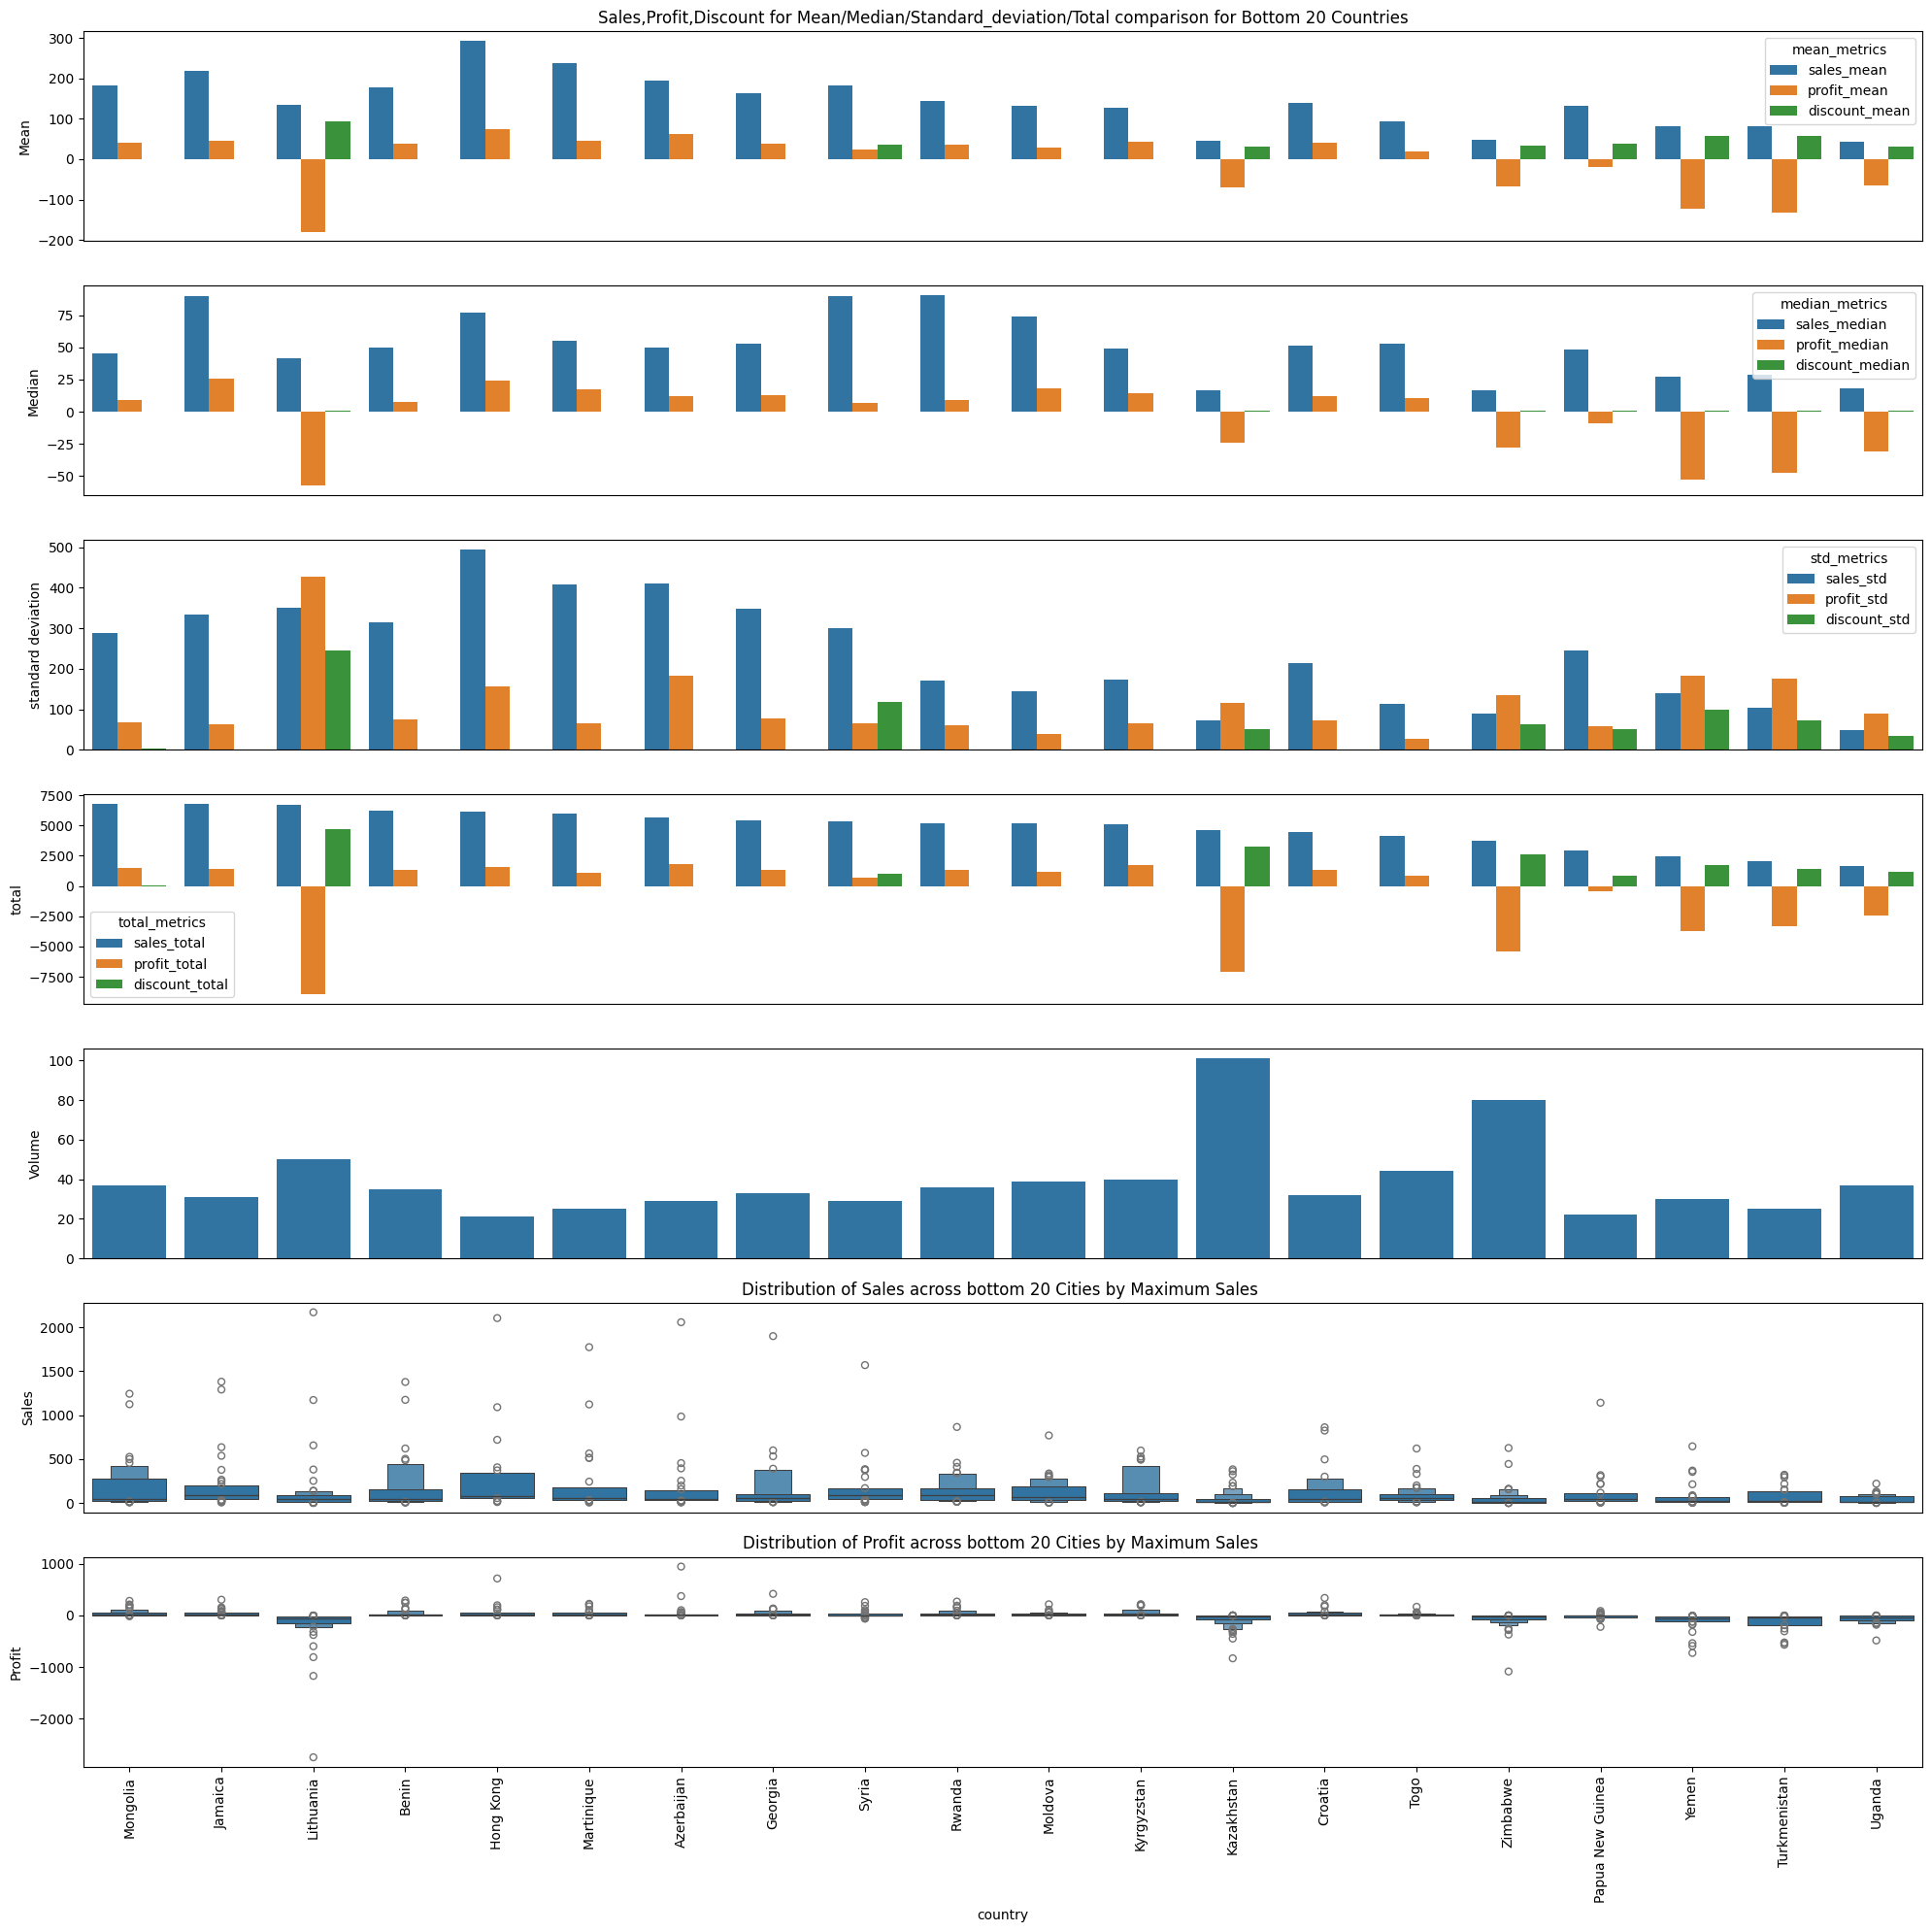

In [188]:
plt.figure(figsize=(20,20))
order=countrybottom20.sort_values(by=['sales_total'],ascending=False)['country'].to_list()
plt.subplot(7,1,1)
sns.barplot(data=countrybottom20melted,x='country',y='mean_values',hue='mean_metrics',palette='tab10',order=order)
plt.title('Sales,Profit,Discount for Mean/Median/Standard_deviation/Total comparison for Bottom 20 Countries')
plt.xlabel('')
plt.ylabel('Mean')
plt.xticks([])

plt.subplot(7,1,2)
sns.barplot(data=countrybottom20melted,x='country',y='median_values',hue='median_metrics',palette='tab10',order=order)
plt.xlabel('')
plt.ylabel('Median')
plt.xticks([])

plt.subplot(7,1,3)
sns.barplot(data=countrybottom20melted,x='country',y='std_values',hue='std_metrics',palette='tab10',order=order)
plt.xlabel('')
plt.ylabel('standard deviation')
plt.xticks([])

plt.subplot(7,1,4)
sns.barplot(data=countrybottom20melted,x='country',y='total_values',hue='total_metrics',palette='tab10',order=order)
plt.xlabel('')
plt.ylabel('total')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,5)
sns.barplot(data=countrybottom20,x='country',y='order_count',order=order)
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,6)
sns.boxenplot(data=df[df['country'].isin(countrybottom20['country'])],
            y='sales',
            x='country',
            order=order)
plt.title('Distribution of Sales across bottom 20 Cities by Maximum Sales ')
plt.ylabel('Sales')
plt.xlabel('')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,7)
sns.boxenplot(data=df[df['country'].isin(countrybottom20['country'])],
            y='profit',
            x='country',
            order=order)
plt.title('Distribution of Profit across bottom 20 Cities by Maximum Sales ')
plt.ylabel('Profit')
plt.xlabel('country')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

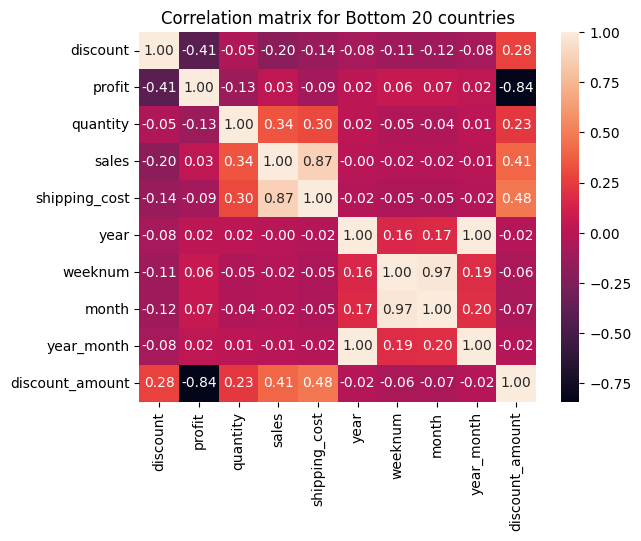

In [189]:
sns.heatmap(df[df['country'].isin(countrybottom20['country'])][df[df['country'].isin(countrybottom20['country'])].select_dtypes(include='number').columns.to_list()].corr(),annot=True,fmt='.2f')
plt.title("Correlation matrix for Bottom 20 countries")
plt.show()

### Analysis

- in Bottom 20 Countries:
    - Mean,Median and total of sales and Profit is in Positive Direction wherever the discount is not given
    - whereever the Discount is Given,incurred the Loss becuase of very low in volume
    - from the distribution of profit in these countries:
        - profit is centered across 0 
        - wherever the Discount is given in these cities,due to low in volume the profit is extending in negative direction
    - from the correlation Heatmap we can observe that:
        - discount and discount_amount are inversly correlated with Profit both with the value of -0.41 and -0.84 respectively
            - clearly shows that Profit is mildly affected by the Discounts
        -  sales and Profit are directly coorelated with the value of 0.03
            - shows that Higher sales != higher Profit
        - shipping_cost and profit is inversly correlated with value of -0.09 and shipping_cost is directly correlated to sales with value of 0.87
            - high sales => higher shipping_cost does not imply higher Profit
        - quantity and profit is directly correlated with profit with value of 0.13
            - higher quantity != higher profit

## Customer_name Vs Profit/Sales/Discount

- Since we have analysed that many customer's has multiple customer_id: 
    -   we will directly grouping customer_name with profit/sales/discount 
    -   the only measuring metrics will be Total_sum/volume/unique_customer_id 
    -   mean/median/std wll be much flatter becuase of high cardinality

In [190]:
group_customer_name=df.groupby(['customer_name'],as_index=False).agg(
    sales_total=('sales','sum'),
    profit_total=('profit','sum'),
    discount_total=('discount_amount','sum'),
    order_count=('customer_name','count'),
    id_count=('customer_id','nunique')
).sort_values(by=['sales_total'],ascending=False)
top20customer=group_customer_name.head(20)
bottom20customer=group_customer_name.tail(20)

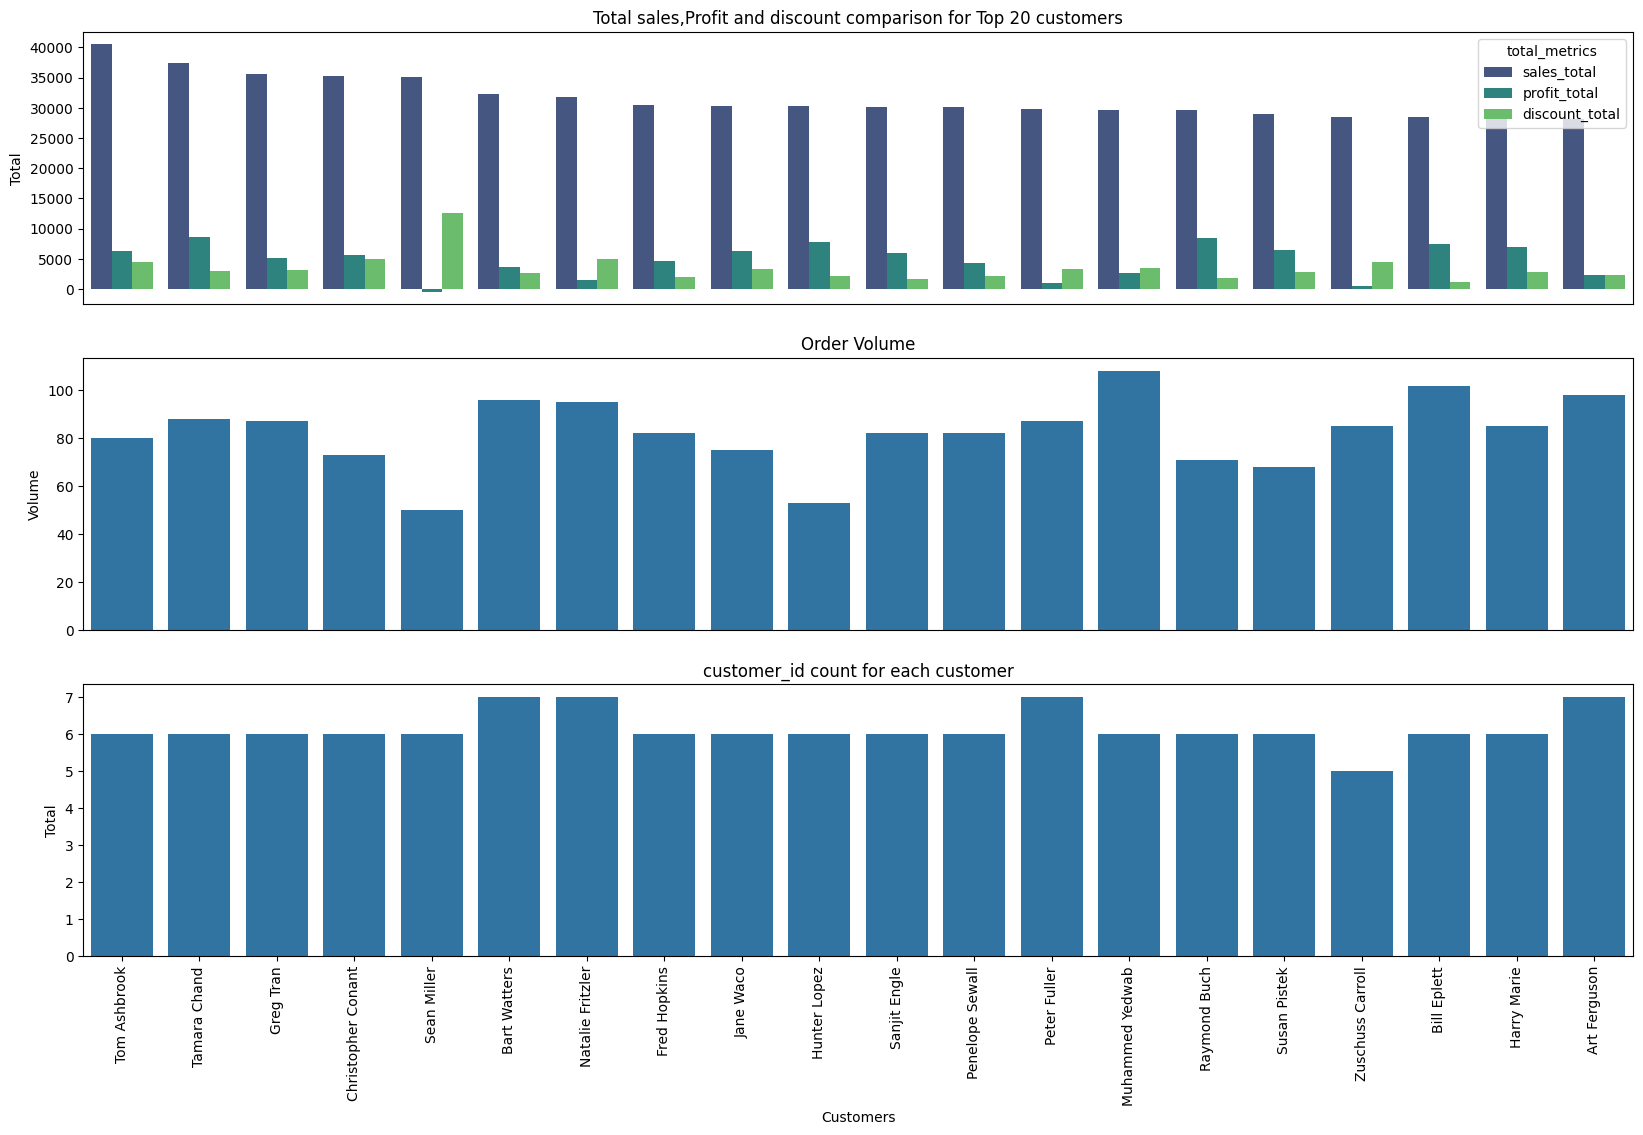

In [191]:
top20customermelted=top20customer.melt(id_vars=['customer_name'],
                                       value_vars=['sales_total','profit_total','discount_total'],
                                       var_name='total_metrics',
                                       value_name='total_values')
top20customermelted
bottom20customermelted=bottom20customer.melt(id_vars=['customer_name'],
                                             value_vars=['sales_total','profit_total','discount_total'],
                                             var_name='total_metrics',
                                             value_name='total_values')
bottom20customermelted
plt.figure(figsize=(20,12))
order=top20customer.sort_values(by=['sales_total'],ascending=False)['customer_name'].to_list()

plt.subplot(3,1,1)
sns.barplot(data=top20customermelted,x='customer_name',y='total_values',hue='total_metrics',palette='viridis',order=order)
plt.title('Total sales,Profit and discount comparison for Top 20 customers')
plt.xlabel('')
plt.ylabel('Total')
plt.xticks([])

plt.subplot(3,1,2)
sns.barplot(data=top20customer,x='customer_name',y='order_count',order=order)
plt.title('Order Volume')
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks([])

plt.subplot(3,1,3)
sns.barplot(data=top20customer,x='customer_name',y='id_count',order=order)
plt.title('customer_id count for each customer')
plt.xlabel('Customers')
plt.ylabel('Total')
plt.xticks(rotation=90)

plt.show()

bottom 20 customers

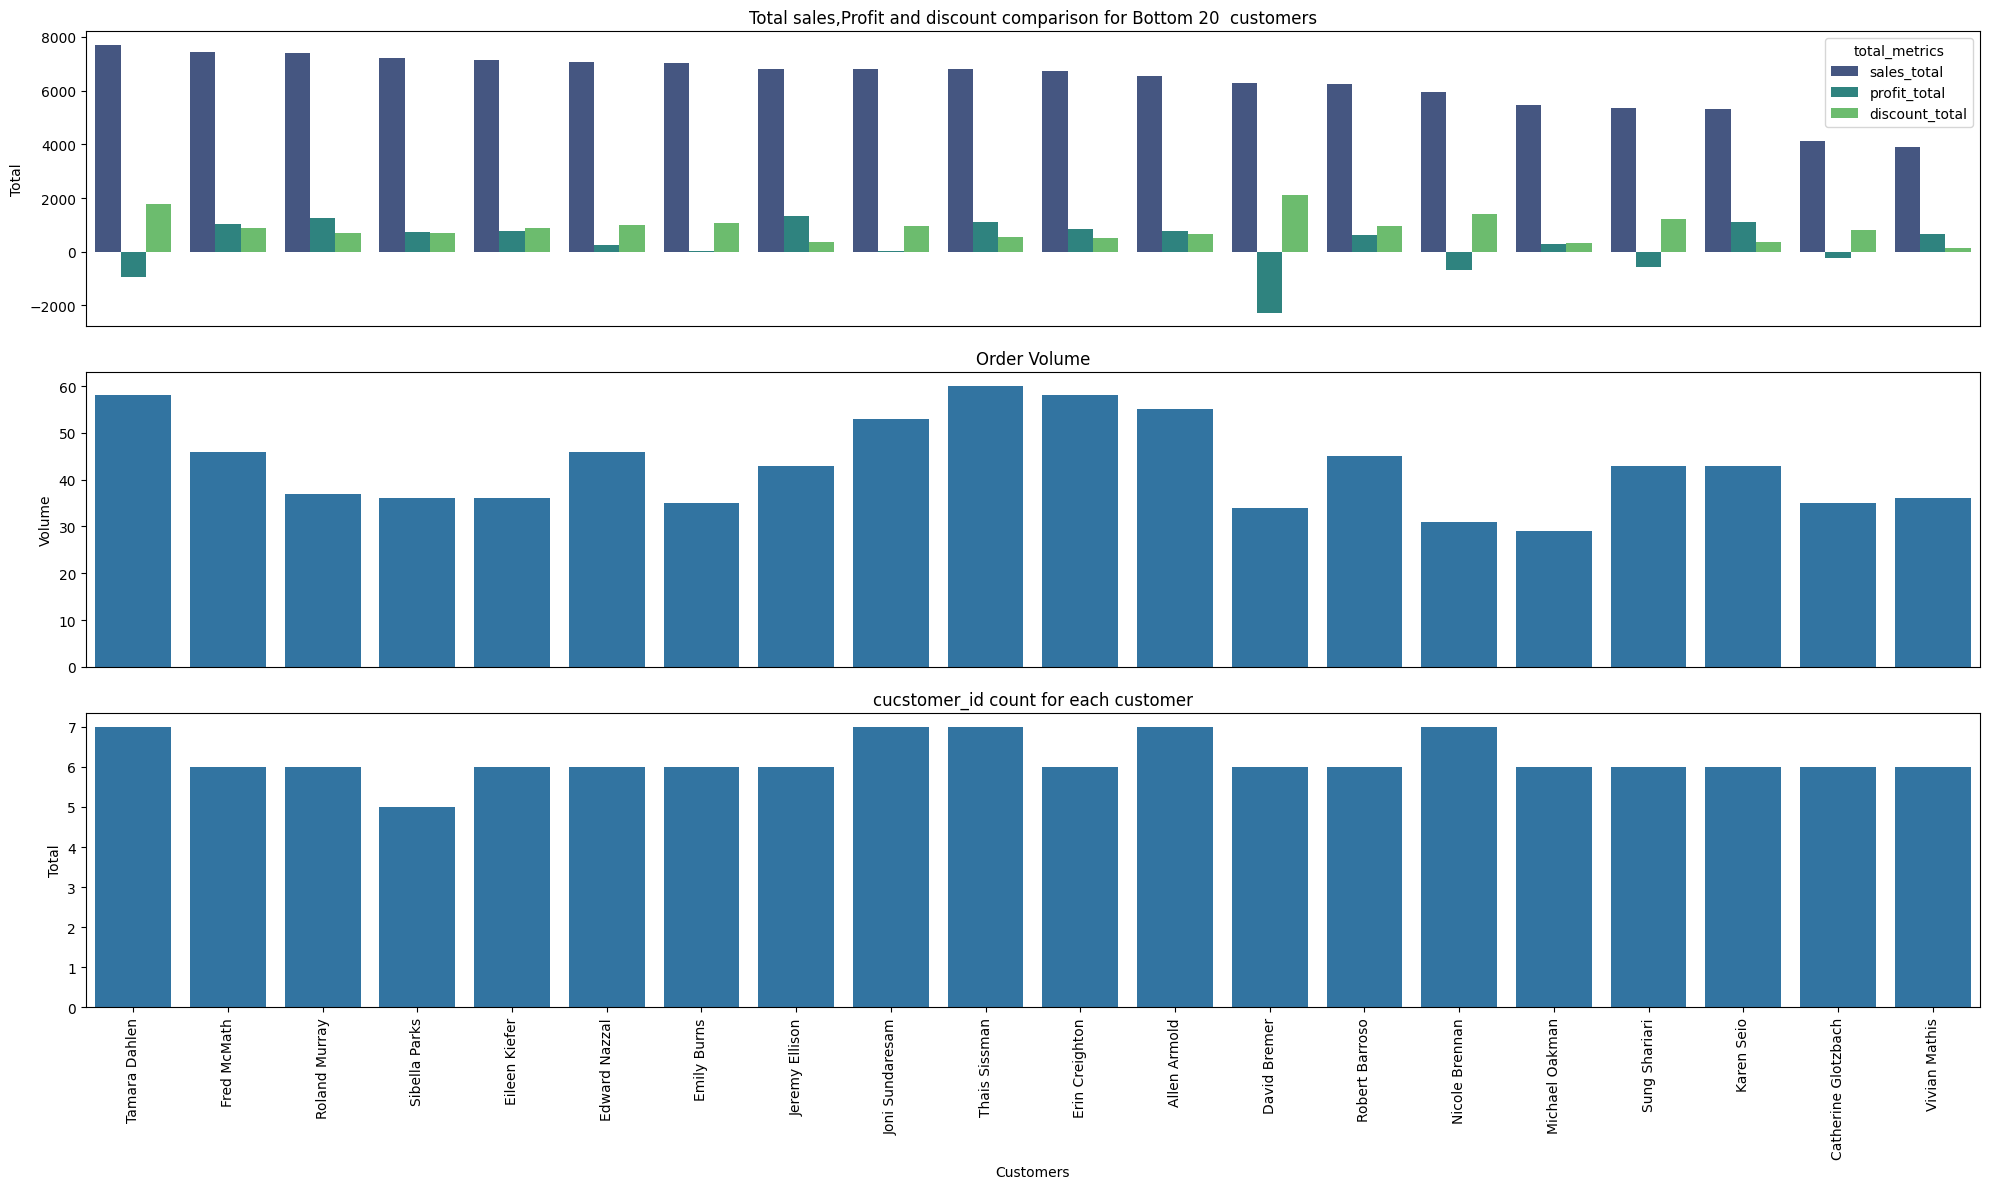

In [192]:
plt.figure(figsize=(20,12))
order=bottom20customer.sort_values(by=['sales_total'],ascending=False)['customer_name'].to_list()

plt.subplot(3,1,1)
sns.barplot(data=bottom20customermelted,x='customer_name',y='total_values',hue='total_metrics',palette='viridis',order=order)
plt.title('Total sales,Profit and discount comparison for Bottom 20  customers')
plt.xlabel('')
plt.ylabel('Total')
plt.xticks([])

plt.subplot(3,1,2)
sns.barplot(data=bottom20customer,x='customer_name',y='order_count',order=order)
plt.title('Order Volume')
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks([])

plt.subplot(3,1,3)
sns.barplot(data=bottom20customer,x='customer_name',y='id_count',order=order)
plt.title('cucstomer_id count for each customer')
plt.xlabel('Customers')
plt.ylabel('Total')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

### Analysis

- Top 20 Customers:
    - wherever the discount_amount is higher,profit value is very low or in negative which signals that discount is profit killer

## Discount Vs Profit/Sales

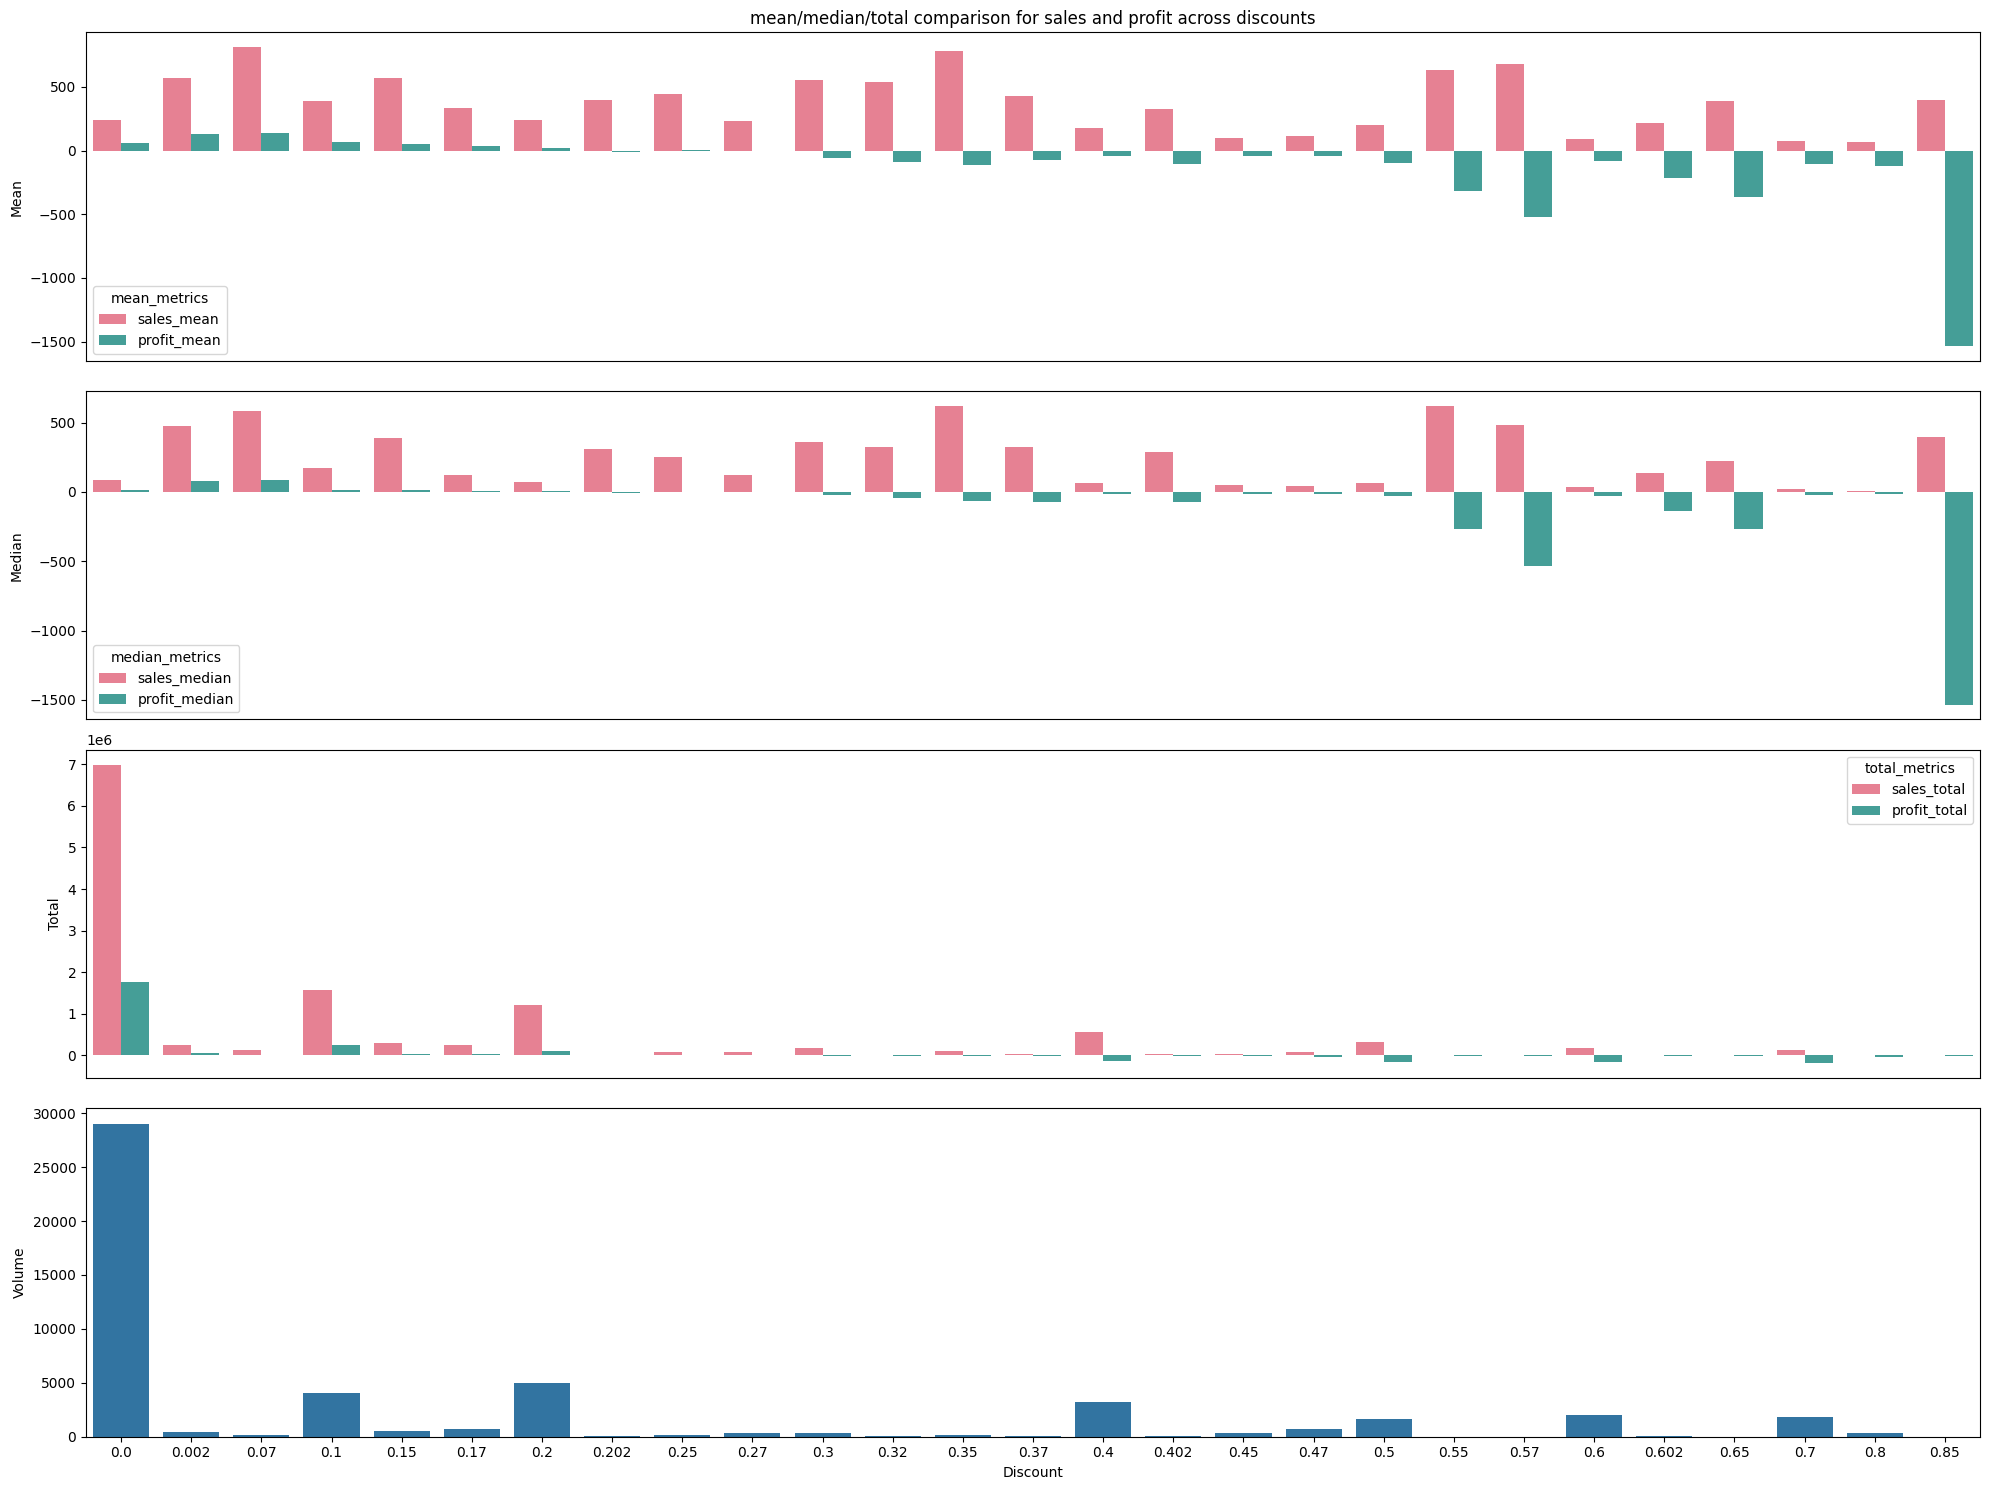

In [193]:
discount_group=df.groupby(['discount'],as_index=False).agg(
    sales_mean=('sales','mean'),
    profit_mean=('profit','mean'),
    sales_median=('sales','median'),
    profit_median=('profit','median'),
    sales_total=('sales','sum'),
    profit_total=('profit','sum'),
    order_count=('discount','count')
).sort_values(by=['discount'])

discount_melted=merge_melted(df=discount_group,common_cols='discount',no_of_melts=3,list_tuples_variables=[('sales_mean','profit_mean','mean_metrics','mean_values'),
                                                                                           ('sales_median','profit_median','median_metrics','median_values'),
                                                                                           ('sales_total','profit_total','total_metrics','total_values')])
discount_melted

plt.figure(figsize=(20,15))
order=discount_group.sort_values(by=['discount'])['discount'].to_list()

plt.subplot(4,1,1)
sns.barplot(data=discount_melted,x='discount',y='mean_values',hue='mean_metrics',palette='husl',order=order)
plt.title('mean/median/total comparison for sales and profit across discounts')
plt.xlabel('')
plt.ylabel('Mean')
plt.xticks([])

plt.subplot(4,1,2)
sns.barplot(data=discount_melted,x='discount',y='median_values',hue='median_metrics',palette='husl',order=order)
plt.xlabel('')
plt.ylabel('Median')
plt.xticks([])

plt.subplot(4,1,3)
sns.barplot(data=discount_melted,x='discount',y='total_values',hue='total_metrics',palette='husl',order=order)
plt.xlabel('')
plt.ylabel('Total')
plt.xticks([])

plt.subplot(4,1,4)
sns.barplot(data=discount_group,x='discount',y='order_count',order=order)
plt.xlabel('Discount')
plt.ylabel('Volume')
plt.xticks()

plt.tight_layout()
plt.show()

### Analysis

- from Different Kinds of the Discounts given we can clearly see that
    - as we go from left to right increasing discount percentage
        - whatever the sales_value is:
            - profit is dercreasing from 0.00% discount to 20%
            - from 20% to 30% the profit is 0
            - increasing the incount from 30% to max_discount given,profit start's going in negative direction or minimizes approximately to 0
    - therefore 0-20 % discount depending upon the margin is the optimal discount share,more than this will destroy the profit

## Order_priority VS Profit/Sales/Discount

In [194]:
df['order_priority'].nunique()

4

In [195]:
priority_agg=df.groupby(['order_priority'],as_index=False).agg(
    sales_mean=('sales','mean'),
    profit_mean=('profit','mean'),
    discount_mean=('discount_amount','mean'),
    sales_median=('sales','median'),
    profit_median=('profit','median'),
    discount_median=('discount','median'),
    sales_std=('sales','std'),
    profit_std=('profit','std'),
    discount_std=('discount_amount','std'),
    sales_total=('sales','sum'),
    profit_total=('profit','sum'),
    discount_total=('discount_amount','sum'),
    order_count=('order_priority','count')
    ).sort_values(by=['sales_total'],ascending=False)
priority_agg

order_priority  sales_mean  profit_mean  discount_mean  sales_median  \
3         Medium  247.378962    29.361729      26.199859          85.0   
1           High  245.642152    27.119122      26.624891          85.0   
0       Critical  250.828586    31.593124      25.659652          85.0   
2            Low  234.258663    24.197958      25.424360          83.5   

   profit_median  discount_median   sales_std  profit_std  discount_std  \
3         9.2400              0.0  506.586490  178.112009    106.555481   
1         9.1800              0.0  460.591517  162.439590     88.585111   
0         9.7164              0.0  473.285731  171.025572     81.986985   
2         9.0000              0.0  440.484922  204.280940     95.150132   

   sales_total  profit_total  discount_total  order_count  
3      7281105  864203.76262      771140.444        29433  
1      3807699  420373.51340      412712.442        15501  
0       986258  124224.16428      100893.750         3932  
2       567843   58655.85098       61628.648         2424

In [196]:
priority_melted=merge_melted(df=priority_agg,
                     common_cols='order_priority',
                     no_of_melts=4,
                     list_tuples_variables=[('sales_mean','profit_mean','discount_mean','mean_metrics','mean_values'),
                                            ('sales_median','profit_median','discount_median','median_metrics','median_values'),
                                            ('sales_std','profit_std','discount_std','std_metrics','std_values'),
                                            ('sales_total','profit_total','discount_total','total_metrics','total_values')],
)
priority_melted

order_priority   mean_metrics  mean_values      type   median_metrics  \
0          Medium     sales_mean   247.378962     sales     sales_median   
1            High     sales_mean   245.642152     sales     sales_median   
2        Critical     sales_mean   250.828586     sales     sales_median   
3             Low     sales_mean   234.258663     sales     sales_median   
4          Medium    profit_mean    29.361729    profit    profit_median   
5            High    profit_mean    27.119122    profit    profit_median   
6        Critical    profit_mean    31.593124    profit    profit_median   
7             Low    profit_mean    24.197958    profit    profit_median   
8          Medium  discount_mean    26.199859  discount  discount_median   
9            High  discount_mean    26.624891  discount  discount_median   
10       Critical  discount_mean    25.659652  discount  discount_median   
11            Low  discount_mean    25.424360  discount  discount_median   

    median_values   std_metrics  std_values   total_metrics  total_values  
0         85.0000     sales_std  506.586490     sales_total  7.281105e+06  
1         85.0000     sales_std  460.591517     sales_total  3.807699e+06  
2         85.0000     sales_std  473.285731     sales_total  9.862580e+05  
3         83.5000     sales_std  440.484922     sales_total  5.678430e+05  
4          9.2400    profit_std  178.112009    profit_total  8.642038e+05  
5          9.1800    profit_std  162.439590    profit_total  4.203735e+05  
6          9.7164    profit_std  171.025572    profit_total  1.242242e+05  
7          9.0000    profit_std  204.280940    profit_total  5.865585e+04  
8          0.0000  discount_std  106.555481  discount_total  7.711404e+05  
9          0.0000  discount_std   88.585111  discount_total  4.127124e+05  
10         0.0000  discount_std   81.986985  discount_total  1.008938e+05  
11         0.0000  discount_std   95.150132  discount_total  6.162865e+04

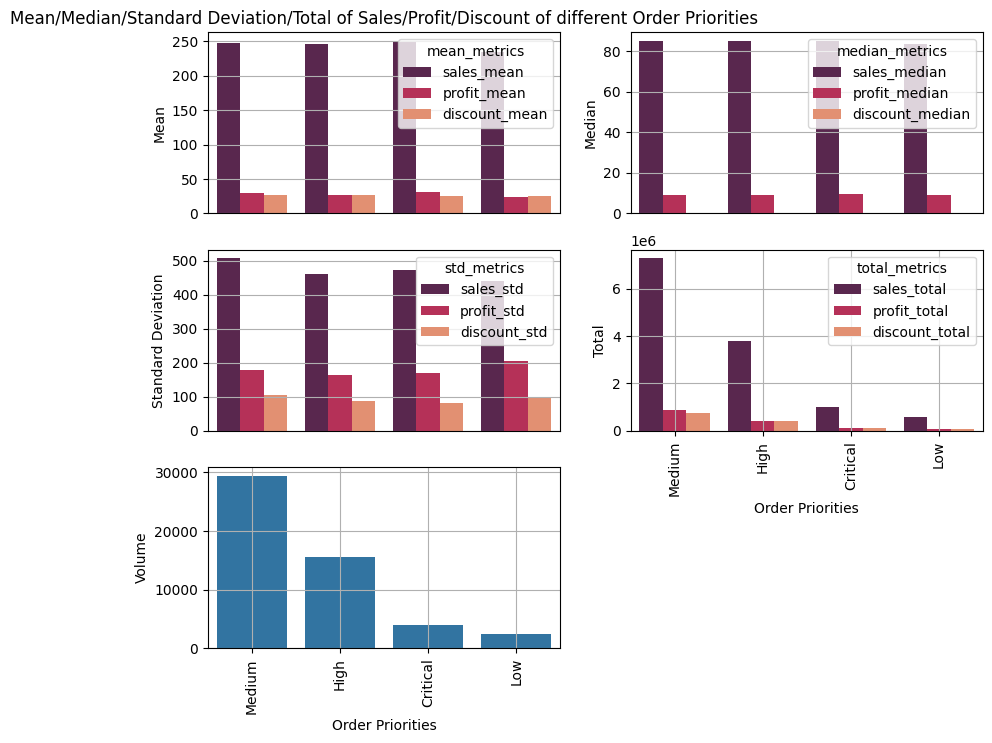

In [197]:
plt.figure(figsize=(10,8))
order=priority_agg['order_priority'].to_list()

plt.subplot(3,2,1)
sns.barplot(data=priority_melted,x='order_priority',y='mean_values',hue='mean_metrics',order=order,palette='rocket')
plt.title('Mean/Median/Standard Deviation/Total of Sales/Profit/Discount of different Order Priorities')
plt.xlabel('')
plt.ylabel('Mean')
plt.xticks([])
plt.grid()

plt.subplot(3,2,2)
sns.barplot(data=priority_melted,x='order_priority',y='median_values',hue='median_metrics',order=order,palette='rocket')
plt.xlabel('')
plt.ylabel('Median')
plt.xticks([])
plt.grid()

plt.subplot(3,2,3)
sns.barplot(data=priority_melted,x='order_priority',y='std_values',hue='std_metrics',order=order,palette='rocket')
plt.xlabel('')
plt.ylabel('Standard Deviation')
plt.xticks([])
plt.grid()

plt.subplot(3,2,4)
sns.barplot(data=priority_melted,x='order_priority',y='total_values',hue='total_metrics',order=order,palette='rocket')
plt.xlabel('Order Priorities')
plt.ylabel('Total')
plt.xticks(rotation=90)
plt.grid()

plt.subplot(3,2,5)
sns.barplot(data=priority_agg,x='order_priority',y='order_count',order=order)
plt.xlabel('Order Priorities')
plt.ylabel('Volume')
plt.xticks(rotation=90)

plt.grid()
plt.show()

### Analysis

- Medium Has the Highest Volume,Sales,Profit and Discount_amount in total of orders
- mean,median and std_devn are approximately equal across all order priorities

there is Nuetral or very very less impact on profit due to order priorities

## Product_id VS Sales/profit/discount

In [198]:
df['product_id'].nunique()

10292

- As we  have came across and insight that product_id is same 
    - across different product_name due to difference in product's local_name across different countries
    - across segment becuase of purchase type (example: single piece order as consumer segment and bulk order as corporate segment ),
        - so we will not be analysing product_name
        - but will analyse the segment
- for procduct_id,we are only aggregating  the sales/profit/discount Total as:
    - mean/meadian/std would be much flatter

In [199]:

product_id_group=df.groupby(['product_id'],as_index=False).agg(
    sales_total=('sales','sum'),
    profit_total=('profit','sum'),
    discount_total=('discount_amount','sum'),
    order_count=('product_id','count'),
    product_name=('product_name',lambda x: x.mode()[0] if not x.mode().empty else np.nan)
).sort_values(by=['sales_total'],ascending=False)

top20product=product_id_group.head(20)
bottom20product=product_id_group.tail(20)

In [200]:
bottom20product

product_id  sales_total  profit_total  discount_total  \
2336  OFF-AME-10002697            5        -2.964             3.0   
4992   OFF-FA-10002831            5        -1.912             3.0   
4978   OFF-FA-10002708            5        -4.784             3.0   
3587   OFF-BI-10001546            5        -3.784             3.0   
4651   OFF-EN-10004479            5        -2.720             3.0   
5619   OFF-LA-10001228            5        -4.288             3.0   
3446   OFF-BI-10000397            5        -3.756             3.0   
4068  OFF-BOS-10001753            4        -2.360             1.6   
5626   OFF-LA-10001287            4        -2.880             2.4   
3445   OFF-BI-10000390            4        -1.456             2.4   
6749  OFF-SME-10000950            4        -7.128             2.8   
3699   OFF-BI-10002510            4        -1.952             2.4   
3801   OFF-BI-10003323            3        -0.300             1.2   
6742  OFF-SME-10000258            3        -3.990             2.1   
2314  OFF-ADV-10003196            3        -1.506             1.8   
3791   OFF-BI-10003253            3        -3.544             1.8   
3557   OFF-BI-10001284            3        -1.560             1.8   
5925   OFF-LA-10004700            3        -4.204             1.8   
2548   OFF-AP-10002203            2        -4.466             1.6   
4562   OFF-EN-10003604            2        -1.148             1.2   

      order_count                                       product_name  
2336            1                  Ames Business Envelopes, Recycled  
4992            1                        OIC Staples, Assorted Sizes  
4978            1                         Stockwell Staples, 12 Pack  
3587            1                              Acco Index Tab, Clear  
4651            1                 Ames Clasp Envelope, Security-Tint  
5619            1               Hon File Folder Labels, Alphabetical  
3446            1          Wilson Jones Hole Reinforcements, Durable  
4068            1                   Boston Highlighters, Water Color  
5626            1     Harbour Creations Removable Labels, Adjustable  
3445            1                          Cardinal Index Tab, Clear  
6749            1           Smead Color Coded Labels, 5000 Label Set  
3699            1                              Acco Index Tab, Clear  
3801            1                Cardinal Hole Reinforcements, Clear  
6742            1             Smead Removable Labels, 5000 Label Set  
2314            1                   Advantus Staples, Assorted Sizes  
3791            1                           Ibico Index Tab, Economy  
3557            1                   Ibico Hole Reinforcements, Clear  
5925            1             Avery Color Coded Labels, Alphabetical  
2548            1  Eureka Disposable Bags for Sanitaire Vibra Gro...  
4562            1                    Jiffy Clasp Envelope, Set of 50

- since bottom20products has only 1 order_count for all the products,we will filter the product_agg on calculated thresold

In [201]:
product_id_group['order_count'].describe()

count    10292.000000
mean         4.983482
std          3.410633
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         35.000000
Name: order_count, dtype: float64

- we would be taking thresold as mean of the order_count across different products
- products whose order_count < mean whould be filtered out as product which could not make up to atleast the average order count in 4 years are like a noise 

In [202]:
thresold=product_id_group['order_count'].mean()

In [203]:
product_id_group=product_id_group[product_id_group['order_count']>=thresold]

In [204]:
top20product=product_id_group.head(20)
bottom20product=product_id_group.tail(20)

In [205]:
top20productmelted=merge_melted(df=top20product,common_cols=['product_name'],
                                no_of_melts=1,
                                list_tuples_variables=[('sales_total','profit_total','discount_total','total_metrics','total_values')])
top20productmelted

product_name   total_metrics  \
0               Canon imageCLASS 2200 Advanced Copier     sales_total   
1                   Nokia Smart Phone, with Caller ID     sales_total   
2   Fellowes PB500 Electric Punch Plastic Comb Bin...     sales_total   
3                        Nokia Smart Phone, Full Size     sales_total   
4        HON 5400 Series Task Chairs for Big and Tall     sales_total   
5             SAFCO Executive Leather Armchair, Black     sales_total   
6                                   Hoover Stove, Red     sales_total   
7   Bush Advantage Collection Racetrack Conference...     sales_total   
8          GBC DocuBind TL300 Electric Binding System     sales_total   
9    GBC Ibimaster 500 Manual ProClick Binding System     sales_total   
10               Hewlett Packard LaserJet 3310 Copier     sales_total   
11                       Apple Smart Phone, Full Size     sales_total   
12  Riverside Palais Royal Lawyers Bookcase, Royal...     sales_total   
13                       Hamilton Beach Stove, Silver     sales_total   
14          GBC DocuBind P400 Electric Binding System     sales_total   
15                     Safco Library with Doors, Pine     sales_total   
16         Hon Executive Leather Armchair, Adjustable     sales_total   
17                     Bush Library with Doors, Metal     sales_total   
18                          Samsung Smart Phone, VoIP     sales_total   
19              Hon Executive Leather Armchair, Black     sales_total   
20              Canon imageCLASS 2200 Advanced Copier    profit_total   
21                  Nokia Smart Phone, with Caller ID    profit_total   
22  Fellowes PB500 Electric Punch Plastic Comb Bin...    profit_total   
23                       Nokia Smart Phone, Full Size    profit_total   
24       HON 5400 Series Task Chairs for Big and Tall    profit_total   
25            SAFCO Executive Leather Armchair, Black    profit_total   
26                                  Hoover Stove, Red    profit_total   
27  Bush Advantage Collection Racetrack Conference...    profit_total   
28         GBC DocuBind TL300 Electric Binding System    profit_total   
29   GBC Ibimaster 500 Manual ProClick Binding System    profit_total   
30               Hewlett Packard LaserJet 3310 Copier    profit_total   
31                       Apple Smart Phone, Full Size    profit_total   
32  Riverside Palais Royal Lawyers Bookcase, Royal...    profit_total   
33                       Hamilton Beach Stove, Silver    profit_total   
34          GBC DocuBind P400 Electric Binding System    profit_total   
35                     Safco Library with Doors, Pine    profit_total   
36         Hon Executive Leather Armchair, Adjustable    profit_total   
37                     Bush Library with Doors, Metal    profit_total   
38                          Samsung Smart Phone, VoIP    profit_total   
39              Hon Executive Leather Armchair, Black    profit_total   
40              Canon imageCLASS 2200 Advanced Copier  discount_total   
41                  Nokia Smart Phone, with Caller ID  discount_total   
42  Fellowes PB500 Electric Punch Plastic Comb Bin...  discount_total   
43                       Nokia Smart Phone, Full Size  discount_total   
44       HON 5400 Series Task Chairs for Big and Tall  discount_total   
45            SAFCO Executive Leather Armchair, Black  discount_total   
46                                  Hoover Stove, Red  discount_total   
47  Bush Advantage Collection Racetrack Conference...  discount_total   
48         GBC DocuBind TL300 Electric Binding System  discount_total   
49   GBC Ibimaster 500 Manual ProClick Binding System  discount_total   
50               Hewlett Packard LaserJet 3310 Copier  discount_total   
51                       Apple Smart Phone, Full Size  discount_total   
52  Riverside Palais Royal Lawyers Bookcase, Royal...  discount_total   
53                       Hamilton Beach Stove, Silver  discount_total   
54          GBC DocuBind P

In [206]:
df[df['product_id'].isin(top20product['product_id'])]

category           city        country customer_id  \
1757   Office Supplies       Columbia  United States   PW-192404   
2092   Office Supplies     Morristown  United States   GK-146204   
2143   Office Supplies        Atlanta  United States   CM-123854   
2167   Office Supplies        Atlanta  United States   BF-111704   
2204   Office Supplies        Roswell  United States   DM-133454   
...                ...            ...            ...         ...   
50979        Furniture  San Francisco  United States   BD-113204   
51046        Furniture    Los Angeles  United States   SC-203054   
51057       Technology    Los Angeles  United States   DB-136154   
51116       Technology    Los Angeles  United States   RM-196754   
51256  Office Supplies    Los Angeles  United States   TG-213104   

              customer_name  discount order_priority       product_id  \
1757           Pierre Wener       0.0         Medium  OFF-BI-10003527   
2092            Grace Kelly       0.0            Low  OFF-BI-10001359   
2143   Christopher Martinez       0.0         Medium  OFF-BI-10003527   
2167             Ben Ferrer       0.0         Medium  OFF-BI-10003527   
2204          Denise Monton       0.0            Low  OFF-BI-10001359   
...                     ...       ...            ...              ...   
50979        Bill Donatelli       0.2         Medium  FUR-CH-10002024   
51046      Sean Christensen       0.2           High  FUR-CH-10002024   
51057         Doug Bickford       0.2       Critical  TEC-CO-10001449   
51116         Robert Marley       0.2       Critical  TEC-CO-10001449   
51256            Toby Gnade       0.2       Critical  OFF-BI-10003527   

                                            product_name     profit  quantity  \
1757   Fellowes PB500 Electric Punch Plastic Comb Bin...  1270.9900         2   
2092          GBC DocuBind TL300 Electric Binding System   843.1706         2   
2143   Fellowes PB500 Electric Punch Plastic Comb Bin...  3177.4750         5   
2167   Fellowes PB500 Electric Punch Plastic Comb Bin...   635.4950         1   
2204          GBC DocuBind TL300 Electric Binding System  1264.7559         3   
...                                                  ...        ...       ...   
50979       HON 5400 Series Task Chairs for Big and Tall     0.0000         2   
51046       HON 5400 Series Task Chairs for Big and Tall     0.0000         5   
51057               Hewlett Packard LaserJet 3310 Copier   335.9944         2   
51116               Hewlett Packard LaserJet 3310 Copier  1007.9832         6   
51256  Fellowes PB500 Electric Punch Plastic Comb Bin...   381.2970         1   

      region  sales      segment       ship_mode  shipping_cost       state  \
1757    East   2542     Consumer  Standard Class          91.36    Maryland   
2092    East   1794    Corporate  Standard Class         225.42  New Jersey   
2143   South   6355     Consumer  Standard Class         581.12     Georgia   
2167   South   1271  Home Office  Standard Class         107.34     Georgia   
2204   South   2691    Corporate  Standard Class         244.88     Georgia   
...      ...    ...          ...             ...            ...         ...   
50979   West   1122     Consumer    Second Class         128.48  California   
51046   West   2804     Consumer     First Class          73.03  California   
51057   West    960     Consumer    Second Class         193.89  California   
51116   West   2880  Home Office     First Class         334.15  California   
51256   West   1017     Consumer    Second Class         363.87  California   

      sub_category  year        market2  weeknum profit_loss  month  \
1757       Binders  2012  North America        8      profit      2   
2092       Binders  2013  North America       51      profit     12   
2143       Binders  2012  North America       11      profit      3   
2167       Binders  2013  North America        5      profit      1   
2204       Binders  2014  North America    

- without a global productname, a product cannot be recognized directly by product_id and multiproduct distribution plot on cannot be plotted on just product_id
- adding a new column called Global_product_name


In [207]:
df['global_product_name']=df.groupby(['product_id']) ['product_name'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

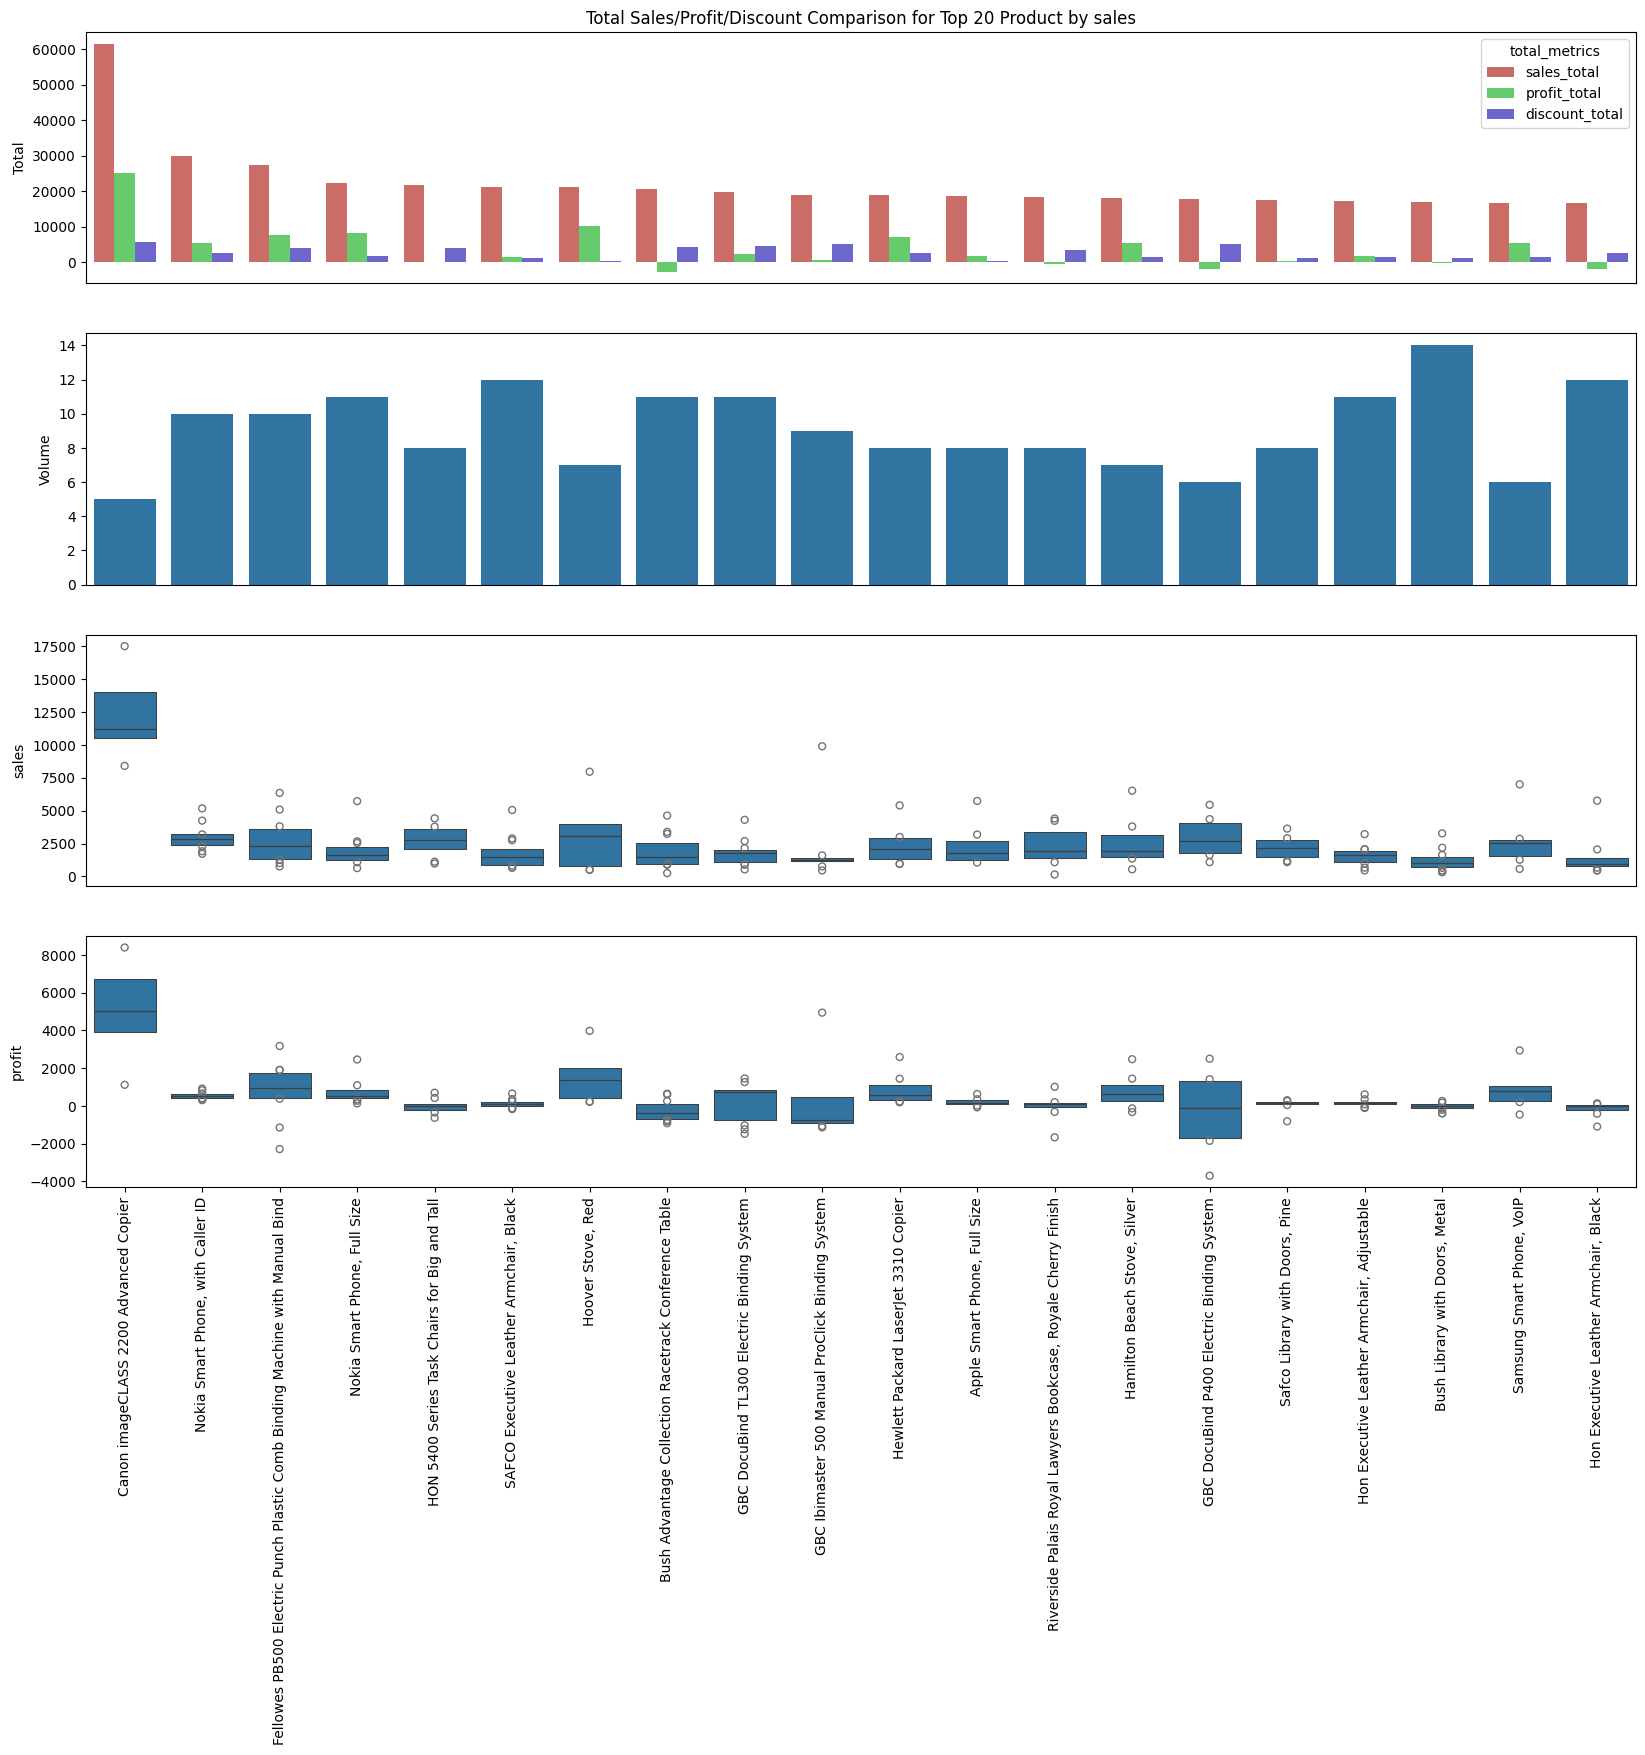

In [208]:
plt.figure(figsize=(20,15))
order=top20product.sort_values(by=['sales_total'],ascending=False)['product_name'].to_list()

plt.subplot(4,1,1)
sns.barplot(data=top20productmelted,x='product_name',y='total_values',hue='total_metrics',palette='hls',order=order)
plt.title('Total Sales/Profit/Discount Comparison for Top 20 Product by sales')
plt.xlabel('')
plt.ylabel('Total')
plt.xticks([])

plt.subplot(4,1,2)
sns.barplot(data=top20product,x='product_name',y='order_count',order=order)
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks([])

plt.subplot(4,1,3)
sns.boxenplot(data=df[df['product_id'].isin(top20product['product_id'])],x='global_product_name',y='sales',order=order)
plt.xlabel('')
plt.ylabel('sales')
plt.xticks([])

plt.subplot(4,1,4)
sns.boxenplot(data=df[df['product_id'].isin(top20product['product_id'])],x='global_product_name',y='profit',order=order)
plt.xlabel('')
plt.ylabel('profit')
plt.xticks(rotation=90)

plt.show()

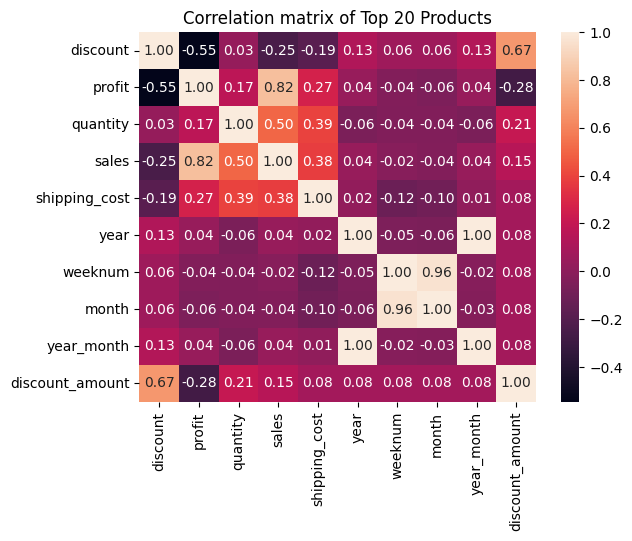

In [209]:
sns.heatmap(data=df[df['product_id'].isin(top20product['product_id'])][df[df['product_id'].isin(top20product['product_id'])].select_dtypes(include=['number']).columns.to_list()].corr(),annot=True,fmt='.2f')
plt.title('Correlation matrix of Top 20 Products')
plt.show()

### Analysis

### From the Aspect Of Products:
- in top 20 Products:
    - it can be clearly seen from the Panel 1 
        - that sales value is not the decider of the profit
        - in whichever product the discount is Higher,it destroyed the Profit converting it into the losses
        - in whichever product the discount is Lower, the Profit is in Higher or in Positive Direction
    - Volume of the Order is not the driver of the profit
    - Distribution of the profit shows:
        - in which Product,the median is around zero has the box has extended in the negative direction
        - Either Nuetralized the profit of incurred losses on those products 
    - from the Correlation Matrix:
        - Profit is inversly correlated to Discount and Discount_amount with value of -0.55 and -0.28 respectively
            - Higher Discount = less or negative profit
        - Profit is Directly and Higly Correlated to Sales with value of 0.82
            - Higher the sales = Higher the Profit
        - Profit is directly weakly correlated to Quantity with value of 0.17
            - Quantity is not the key driver of Profit

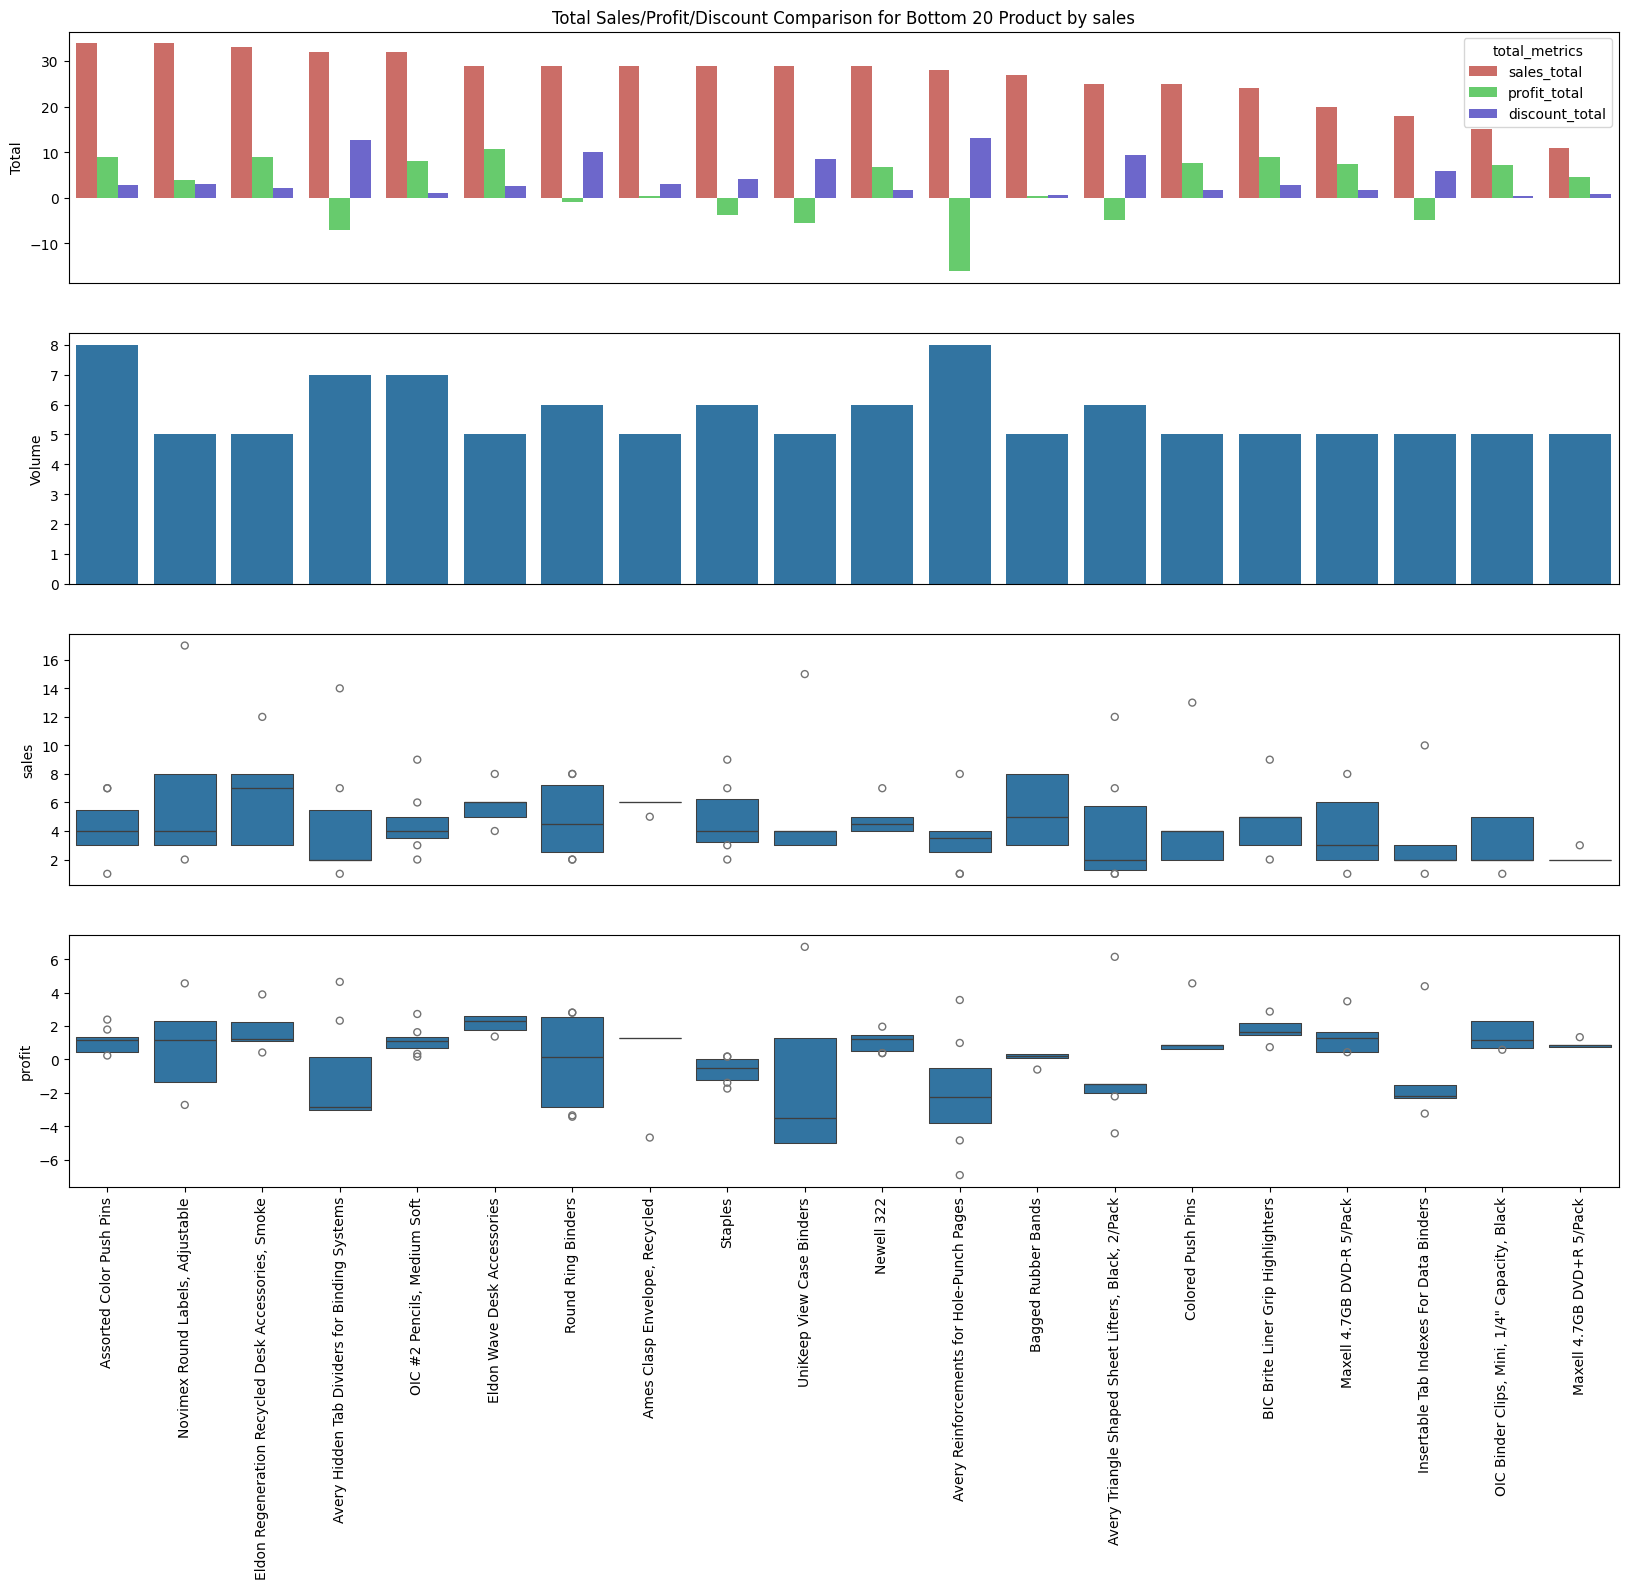

In [210]:
bottom20productmelted=merge_melted(df=bottom20product,common_cols=['product_name'],
                                no_of_melts=1,
                                list_tuples_variables=[('sales_total','profit_total','discount_total','total_metrics','total_values')])
bottom20productmelted

plt.figure(figsize=(20,15))
order=bottom20product.sort_values(by=['sales_total'],ascending=False)['product_name'].to_list()

plt.subplot(4,1,1)
sns.barplot(data=bottom20productmelted,x='product_name',y='total_values',hue='total_metrics',palette='hls',order=order)
plt.title('Total Sales/Profit/Discount Comparison for Bottom 20 Product by sales')
plt.xlabel('')
plt.ylabel('Total')
plt.xticks([])

plt.subplot(4,1,2)
sns.barplot(data=bottom20product,x='product_name',y='order_count',order=order)
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks([])

plt.subplot(4,1,3)
sns.boxenplot(data=df[df['product_id'].isin(bottom20product['product_id'])],x='global_product_name',y='sales',order=order)
plt.xlabel('')
plt.ylabel('sales')
plt.xticks([])

plt.subplot(4,1,4)
sns.boxenplot(data=df[df['product_id'].isin(bottom20product['product_id'])],x='global_product_name',y='profit',order=order)
plt.xlabel('')
plt.ylabel('profit')
plt.xticks(rotation=90)

plt.show()

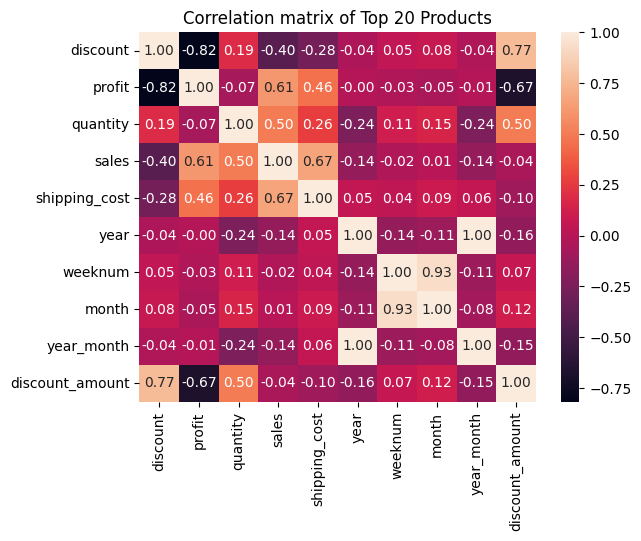

In [211]:
sns.heatmap(data=df[df['product_id'].isin(bottom20product['product_id'])][df[df['product_id'].isin(bottom20product['product_id'])].select_dtypes(include=['number']).columns.to_list()].corr(),annot=True,fmt='.2f')
plt.title('Correlation matrix of Top 20 Products')
plt.show()

### Analysis

- in Bottom 20 products:
    - As Described above,unorganised Discount is the factor for incurring losses

## Quantity VS Sales/Profit/Discount

In [212]:
df['quantity'].nunique()

14

In [213]:
quantity_agg=df.groupby(['quantity'],as_index=False).agg(
    sales_mean=('sales','mean'),
    profit_mean=('profit','mean'),
    discount_mean=('discount_amount','mean'),
    sales_median=('sales','median'),
    profit_median=('profit','median'),
    discount_median=('discount','median'),
    sales_std=('sales','std'),
    profit_std=('profit','std'),
    discount_std=('discount_amount','std'),
    sales_total=('sales','sum'),
    profit_total=('profit','sum'),
    discount_total=('discount_amount','sum'),
    order_count=('quantity','count')
    ).sort_values(by=['sales_total'],ascending=False)
quantity_agg

quantity   sales_mean  profit_mean  discount_mean  sales_median  \
2          3   208.417372    24.323615      23.137070          87.0   
3          4   293.741895    34.724614      30.583431         118.0   
1          2   143.389394    16.360682      15.011063          59.0   
4          5   369.707292    46.477984      39.911401         143.5   
5          6   433.260265    41.426103      51.831455         180.5   
6          7   490.477568    66.821232      48.858115         201.0   
7          8   549.653931    61.538104      57.290172         246.0   
0          1    73.607721     7.254517       6.586574          30.0   
8          9   605.637285    74.818913      63.875694         251.0   
9         10   624.865942    62.280717      64.681507         266.5   
13        14   800.069892   106.119887      71.255484         325.0   
11        12   638.647727    29.059935      83.307977         314.0   
10        11   712.448718    81.550999      83.680987         343.5   
12        13  1060.036145   155.497354     107.784699         486.0   

    profit_median  discount_median    sales_std  profit_std  discount_std  \
2          9.7200              0.0   326.323177  116.804118     59.251398   
3         12.8184              0.0   511.235651  195.953106    102.734699   
1          6.7270              0.0   218.227695   83.005469     40.245631   
4         15.9000              0.0   637.414044  257.011846    111.104885   
5         20.4720              0.0   740.344320  229.195034    237.328210   
6         23.5200              0.0   728.653140  265.756868    125.635497   
7         29.9760              0.0   782.274199  305.749674    166.834314   
0          3.7800              0.0   110.554754   46.351144     18.052759   
8         29.3400              0.0   885.240547  288.947330    155.652730   
9         31.1940              0.0   965.415543  288.031485    145.744130   
13        49.0070              0.0  1240.095528  517.535970    151.296429   
11        35.2800              0.0   886.254959  502.441985    243.437982   
10        42.7350              0.0  1046.501060  491.940212    227.168491   
12        71.8380              0.0  1569.510662  724.105240    283.600967   

    sales_total  profit_total  discount_total  order_count  
2       2017897  235501.24350      224013.108         9682  
3       1875542  221716.66280      195275.208         6385  
1       1827928  208565.96836      191361.026        12748  
4       1804911  226905.51890      194847.462         4882  
5       1308446  125106.83064      156530.994         3020  
6       1169789  159368.63908      116526.604         2385  
7        748079   83753.35888       77971.924         1361  
0        659746   65022.23994       59035.464         8963  
8        597764   73846.26738       63045.310          987  
9        172463   17189.47800       17852.096          276  
13       148813   19738.29900       13253.520          186  
11       112402    5114.54856       14662.204          176  
10       111142   12721.95584       13054.234          156  
12        87983   12906.28040        8946.130           83

In [214]:
quantity_melted=merge_melted(df=quantity_agg,
                     common_cols='quantity',
                     no_of_melts=4,
                     list_tuples_variables=[('sales_mean','profit_mean','discount_mean','mean_metrics','mean_values'),
                                            ('sales_median','profit_median','discount_median','median_metrics','median_values'),
                                            ('sales_std','profit_std','discount_std','std_metrics','std_values'),
                                            ('sales_total','profit_total','discount_total','total_metrics','total_values')])

In [215]:
quantity_melted

quantity   mean_metrics  mean_values      type   median_metrics  \
0          3     sales_mean   208.417372     sales     sales_median   
1          4     sales_mean   293.741895     sales     sales_median   
2          2     sales_mean   143.389394     sales     sales_median   
3          5     sales_mean   369.707292     sales     sales_median   
4          6     sales_mean   433.260265     sales     sales_median   
5          7     sales_mean   490.477568     sales     sales_median   
6          8     sales_mean   549.653931     sales     sales_median   
7          1     sales_mean    73.607721     sales     sales_median   
8          9     sales_mean   605.637285     sales     sales_median   
9         10     sales_mean   624.865942     sales     sales_median   
10        14     sales_mean   800.069892     sales     sales_median   
11        12     sales_mean   638.647727     sales     sales_median   
12        11     sales_mean   712.448718     sales     sales_median   
13        13     sales_mean  1060.036145     sales     sales_median   
14         3    profit_mean    24.323615    profit    profit_median   
15         4    profit_mean    34.724614    profit    profit_median   
16         2    profit_mean    16.360682    profit    profit_median   
17         5    profit_mean    46.477984    profit    profit_median   
18         6    profit_mean    41.426103    profit    profit_median   
19         7    profit_mean    66.821232    profit    profit_median   
20         8    profit_mean    61.538104    profit    profit_median   
21         1    profit_mean     7.254517    profit    profit_median   
22         9    profit_mean    74.818913    profit    profit_median   
23        10    profit_mean    62.280717    profit    profit_median   
24        14    profit_mean   106.119887    profit    profit_median   
25        12    profit_mean    29.059935    profit    profit_median   
26        11    profit_mean    81.550999    profit    profit_median   
27        13    profit_mean   155.497354    profit    profit_median   
28         3  discount_mean    23.137070  discount  discount_median   
29         4  discount_mean    30.583431  discount  discount_median   
30         2  discount_mean    15.011063  discount  discount_median   
31         5  discount_mean    39.911401  discount  discount_median   
32         6  discount_mean    51.831455  discount  discount_median   
33         7  discount_mean    48.858115  discount  discount_median   
34         8  discount_mean    57.290172  discount  discount_median   
35         1  discount_mean     6.586574  discount  discount_median   
36         9  discount_mean    63.875694  discount  discount_median   
37        10  discount_mean    64.681507  discount  discount_median   
38        14  discount_mean    71.255484  discount  discount_median   
39        12  discount_mean    83.307977  discount  discount_median   
40        11  discount_mean    83.680987  discount  discount_median   
41        13  discount_mean   107.784699  discount  discount_median   

    median_values   std_metrics   std_values   total_metrics  total_values  
0         87.0000     sales_std   326.323177     sales_total  2.017897e+06  
1        118.0000     sales_std   511.235651     sales_total  1.875542e+06  
2         59.0000     sales_std   218.227695     sales_total  1.827928e+06  
3        143.5000     sales_std   637.414044     sales_total  1.804911e+06  
4        180.5000     sales_std   740.344320     sales_total  1.308446e+06  
5        201.0000     sales_std   728.653140     sales_total  1.169789e+06  
6        246.0000     sales_std   782.274199     sales_total  7.480790e+05  
7         30.0000     sales_std   110.554754     sales_total  6.597460e+05  
8        251.0000     sales_std   885.240547     sales_total  5.977640e+05  
9        266.5000     sales_std   965.415543     sales_total  1.724630e+05  
10       325.0000     sales_std  1240.095528     sales_total  1.488130e+05  
11       314.0000     sale

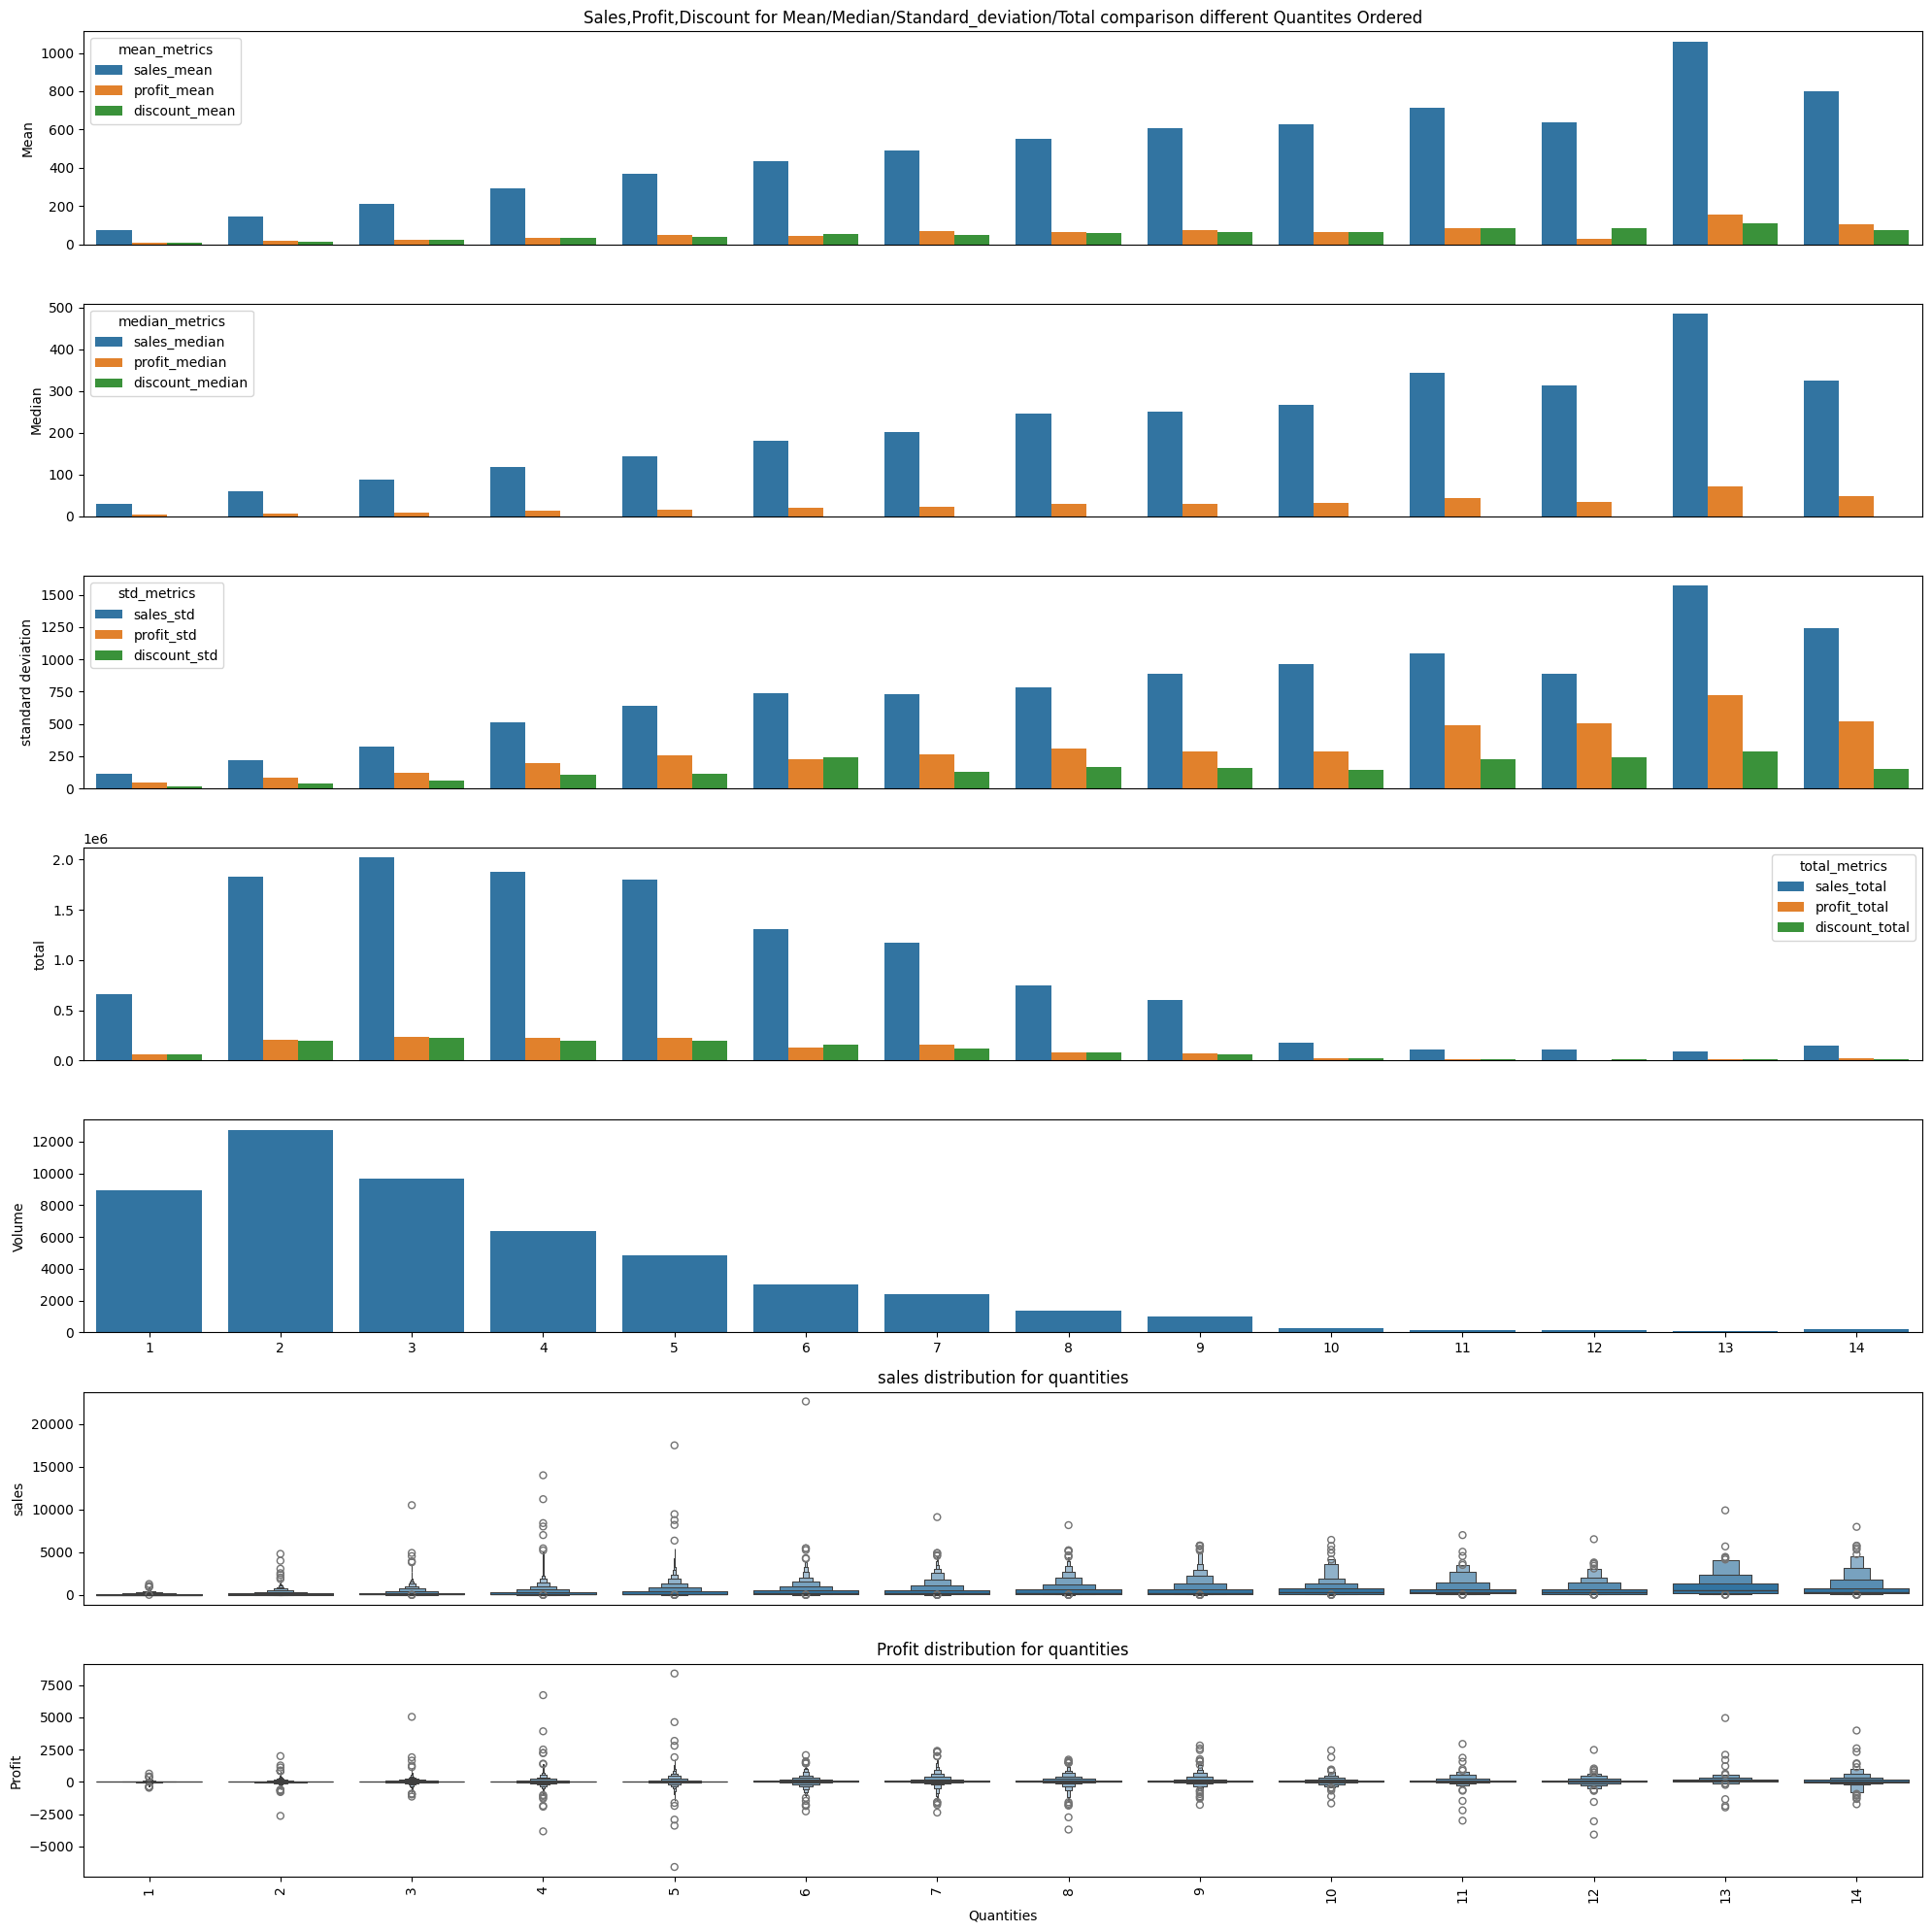

In [216]:
plt.figure(figsize=(20,20))
order=quantity_agg.sort_values(by=['quantity'],ascending=True)['quantity'].to_list()
plt.subplot(7,1,1)
sns.barplot(data=quantity_melted,x='quantity',y='mean_values',hue='mean_metrics',palette='tab10',order=order)
plt.title('Sales,Profit,Discount for Mean/Median/Standard_deviation/Total comparison different Quantites Ordered')
plt.xlabel('')
plt.ylabel('Mean')
plt.xticks([])

plt.subplot(7,1,2)
sns.barplot(data=quantity_melted,x='quantity',y='median_values',hue='median_metrics',palette='tab10',order=order)
plt.xlabel('')
plt.ylabel('Median')
plt.xticks([])

plt.subplot(7,1,3)
sns.barplot(data=quantity_melted,x='quantity',y='std_values',hue='std_metrics',palette='tab10',order=order)
plt.xlabel('')
plt.ylabel('standard deviation')
plt.xticks([])

plt.subplot(7,1,4)
sns.barplot(data=quantity_melted,x='quantity',y='total_values',hue='total_metrics',palette='tab10',order=order)
plt.xlabel('')
plt.ylabel('total')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,5)
sns.barplot(data=quantity_agg,x='quantity',y='order_count',order=order)
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks()
plt.tight_layout()

plt.subplot(7,1,6)
sns.boxenplot(data=df,y='sales',x='quantity',order=order)
plt.title('sales distribution for quantities')
plt.xlabel('')
plt.ylabel('sales')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,7)
sns.boxenplot(data=df,y='profit',x='quantity',order=order)
plt.title('Profit distribution for quantities')
plt.xlabel('Quantities')
plt.ylabel('Profit')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

### Analysis

- from the aspect of quantity ordered per Order:
    - fom left to right
        - mean,median and std_devn of sales,profit and discount increases as the order quantity increases
        - volume of orders and Total_value of sales,profit and discount Descreases as the order quantity increases
            - shows that on accumulation,less order quantities are more profitable if organised discount is provided to the customers
            - but if we receive huge number of bulk orders with little more (not very high) discount then we cann aggregate more profit as profit distribution across high order quantites are more spread in positive direction than in the negative direction with few outliers present in positive direction. 

## Statistical Proof

In [217]:
quantity_agg

quantity   sales_mean  profit_mean  discount_mean  sales_median  \
2          3   208.417372    24.323615      23.137070          87.0   
3          4   293.741895    34.724614      30.583431         118.0   
1          2   143.389394    16.360682      15.011063          59.0   
4          5   369.707292    46.477984      39.911401         143.5   
5          6   433.260265    41.426103      51.831455         180.5   
6          7   490.477568    66.821232      48.858115         201.0   
7          8   549.653931    61.538104      57.290172         246.0   
0          1    73.607721     7.254517       6.586574          30.0   
8          9   605.637285    74.818913      63.875694         251.0   
9         10   624.865942    62.280717      64.681507         266.5   
13        14   800.069892   106.119887      71.255484         325.0   
11        12   638.647727    29.059935      83.307977         314.0   
10        11   712.448718    81.550999      83.680987         343.5   
12        13  1060.036145   155.497354     107.784699         486.0   

    profit_median  discount_median    sales_std  profit_std  discount_std  \
2          9.7200              0.0   326.323177  116.804118     59.251398   
3         12.8184              0.0   511.235651  195.953106    102.734699   
1          6.7270              0.0   218.227695   83.005469     40.245631   
4         15.9000              0.0   637.414044  257.011846    111.104885   
5         20.4720              0.0   740.344320  229.195034    237.328210   
6         23.5200              0.0   728.653140  265.756868    125.635497   
7         29.9760              0.0   782.274199  305.749674    166.834314   
0          3.7800              0.0   110.554754   46.351144     18.052759   
8         29.3400              0.0   885.240547  288.947330    155.652730   
9         31.1940              0.0   965.415543  288.031485    145.744130   
13        49.0070              0.0  1240.095528  517.535970    151.296429   
11        35.2800              0.0   886.254959  502.441985    243.437982   
10        42.7350              0.0  1046.501060  491.940212    227.168491   
12        71.8380              0.0  1569.510662  724.105240    283.600967   

    sales_total  profit_total  discount_total  order_count  
2       2017897  235501.24350      224013.108         9682  
3       1875542  221716.66280      195275.208         6385  
1       1827928  208565.96836      191361.026        12748  
4       1804911  226905.51890      194847.462         4882  
5       1308446  125106.83064      156530.994         3020  
6       1169789  159368.63908      116526.604         2385  
7        748079   83753.35888       77971.924         1361  
0        659746   65022.23994       59035.464         8963  
8        597764   73846.26738       63045.310          987  
9        172463   17189.47800       17852.096          276  
13       148813   19738.29900       13253.520          186  
11       112402    5114.54856       14662.204          176  
10       111142   12721.95584       13054.234          156  
12        87983   12906.28040        8946.130           83

## Region VS Profit/Sales/Discount

In [218]:
df['region']

0        West
1        West
2        West
3        West
4        West
         ... 
51285    West
51286    West
51287    West
51288    West
51289    West
Name: region, Length: 51290, dtype: object

In [219]:
region_agg=df.groupby(['region'],as_index=False).agg(
    sales_mean=('sales','mean'),
    profit_mean=('profit','mean'),
    discount_mean=('discount_amount','mean'),
    sales_median=('sales','median'),
    profit_median=('profit','median'),
    discount_median=('discount','median'),
    sales_std=('sales','std'),
    profit_std=('profit','std'),
    discount_std=('discount_amount','std'),
    sales_total=('sales','sum'),
    profit_total=('profit','sum'),
    discount_total=('discount_amount','sum'),
    order_count=('quantity','count')
    ).sort_values(by=['sales_total'],ascending=False)
region_agg

region  sales_mean  profit_mean  discount_mean  sales_median  \
3          Central  253.881353    28.011512      29.067457          95.0   
10           South  240.927013    21.122011      29.077275          86.0   
7            North  260.855172    40.668329      19.626271          97.0   
9          Oceania  315.516777    34.439091      41.052079         118.0   
11  Southeast Asia  282.658357     5.705442      59.148696         105.0   
8       North Asia  362.852438    70.820539      13.982849         145.0   
5             EMEA  160.307019     8.728966      15.489481          52.0   
0           Africa  170.868978    19.374674       9.349073          52.0   
4     Central Asia  367.597168    64.687591      14.525146         137.0   
12            West  226.510771    33.849032      29.164034          61.0   
6             East  238.354635    32.135808      33.220541          55.0   
2        Caribbean  191.882249    20.456403      21.676093          77.5   
1           Canada  174.302083    46.399453       0.000000          60.0   

    profit_median  discount_median   sales_std  profit_std  discount_std  \
3          9.7800             0.00  479.371019  185.707584     88.554107   
10         9.1580             0.00  528.861277  183.735406    170.389606   
7         12.4000             0.00  452.994677  148.170790     62.127661   
9          8.7660             0.10  546.850258  153.804632     86.459538   
11        -1.3533             0.27  470.874794  133.840815    108.427867   
8         24.2400             0.00  585.373691  188.495252     69.186460   
5          5.0400             0.00  327.187928  154.196926     65.375771   
0          7.5600             0.00  359.407808  146.530457     42.800315   
4         21.6300             0.00  624.295333  210.945894     80.473043   
12        11.1664             0.00  524.883279  174.109081     85.956565   
6          8.1717             0.00  620.717359  251.605084    136.170473   
2          7.1640             0.20  302.956898  110.968886     51.821364   
1         12.3450             0.00  332.847659  115.439881      0.000000   

    sales_total  profit_total  discount_total  order_count  
3       2822399  311403.98164      323142.918        11117  
10      1600960  140355.76618      193218.492         6645  
7       1248192  194597.95252       93911.706         4785  
9       1100207  120089.11200      143148.600         3487  
11       884438   17852.32900      185076.270         3129  
8        848349  165578.42100       32691.900         2338  
5        806184   43897.97100       77896.600         5029  
0        783776   88871.63100       42884.200         4587  
4        752839  132480.18700       29747.500         2048  
12       725514  108418.44890       93412.400         3203  
6        678834   91522.78000       94612.100         2848  
2        324281   34571.32104       36632.598         1690  
1         66932   17817.39000           0.000          384

In [220]:
region_melted=merge_melted(df=region_agg,common_cols=['region'],no_of_melts=4,list_tuples_variables=[('sales_mean','profit_mean','discount_mean','mean_metrics','mean_values'),
                                                                                       ('sales_median','profit_median','discount_median','median_metrics','median_values'),
                                                                                       ('sales_std','profit_std','discount_std','std_metrics','std_values'),
                                                                                       ('sales_total','profit_total','discount_total','total_metrics','total_values')])
region_melted

region   mean_metrics  mean_values      type   median_metrics  \
0          Central     sales_mean   253.881353     sales     sales_median   
1            South     sales_mean   240.927013     sales     sales_median   
2            North     sales_mean   260.855172     sales     sales_median   
3          Oceania     sales_mean   315.516777     sales     sales_median   
4   Southeast Asia     sales_mean   282.658357     sales     sales_median   
5       North Asia     sales_mean   362.852438     sales     sales_median   
6             EMEA     sales_mean   160.307019     sales     sales_median   
7           Africa     sales_mean   170.868978     sales     sales_median   
8     Central Asia     sales_mean   367.597168     sales     sales_median   
9             West     sales_mean   226.510771     sales     sales_median   
10            East     sales_mean   238.354635     sales     sales_median   
11       Caribbean     sales_mean   191.882249     sales     sales_median   
12          Canada     sales_mean   174.302083     sales     sales_median   
13         Central    profit_mean    28.011512    profit    profit_median   
14           South    profit_mean    21.122011    profit    profit_median   
15           North    profit_mean    40.668329    profit    profit_median   
16         Oceania    profit_mean    34.439091    profit    profit_median   
17  Southeast Asia    profit_mean     5.705442    profit    profit_median   
18      North Asia    profit_mean    70.820539    profit    profit_median   
19            EMEA    profit_mean     8.728966    profit    profit_median   
20          Africa    profit_mean    19.374674    profit    profit_median   
21    Central Asia    profit_mean    64.687591    profit    profit_median   
22            West    profit_mean    33.849032    profit    profit_median   
23            East    profit_mean    32.135808    profit    profit_median   
24       Caribbean    profit_mean    20.456403    profit    profit_median   
25          Canada    profit_mean    46.399453    profit    profit_median   
26         Central  discount_mean    29.067457  discount  discount_median   
27           South  discount_mean    29.077275  discount  discount_median   
28           North  discount_mean    19.626271  discount  discount_median   
29         Oceania  discount_mean    41.052079  discount  discount_median   
30  Southeast Asia  discount_mean    59.148696  discount  discount_median   
31      North Asia  discount_mean    13.982849  discount  discount_median   
32            EMEA  discount_mean    15.489481  discount  discount_median   
33          Africa  discount_mean     9.349073  discount  discount_median   
34    Central Asia  discount_mean    14.525146  discount  discount_median   
35            West  discount_mean    29.164034  discount  discount_median   
36            East  discount_mean    33.220541  discount  discount_median   
37       Caribbean  discount_mean    21.676093  discount  discount_median   
38          Canada  discount_mean     0.000000  discount  discount_median   

    median_values   std_metrics  std_values   total_metrics  total_values  
0         95.0000     sales_std  479.371019     sales_total  2.822399e+06  
1         86.0000     sales_std  528.861277     sales_total  1.600960e+06  
2         97.0000     sales_std  452.994677     sales_total  1.248192e+06  
3        118.0000     sales_std  546.850258     sales_total  1.100207e+06  
4        105.0000     sales_std  470.874794     sales_total  8.844380e+05  
5        145.0000     sales_std  585.373691     sales_total  8.483490e+05  
6         52.0000     sales_std  327.187928     sales_total  8.061840e+05  
7         52.0000     sales_std  359.407808     sales_total  7.837760e+05  
8        137.0000     sales_std  624.295333     sales_total  7.528390e+05  
9         61.0000     sales_std  524.883279     sales_total  7.255140e+05  
10        55.0000     sales_std  620.717359     sales_total  6.788340e+05  
11        77.5000  

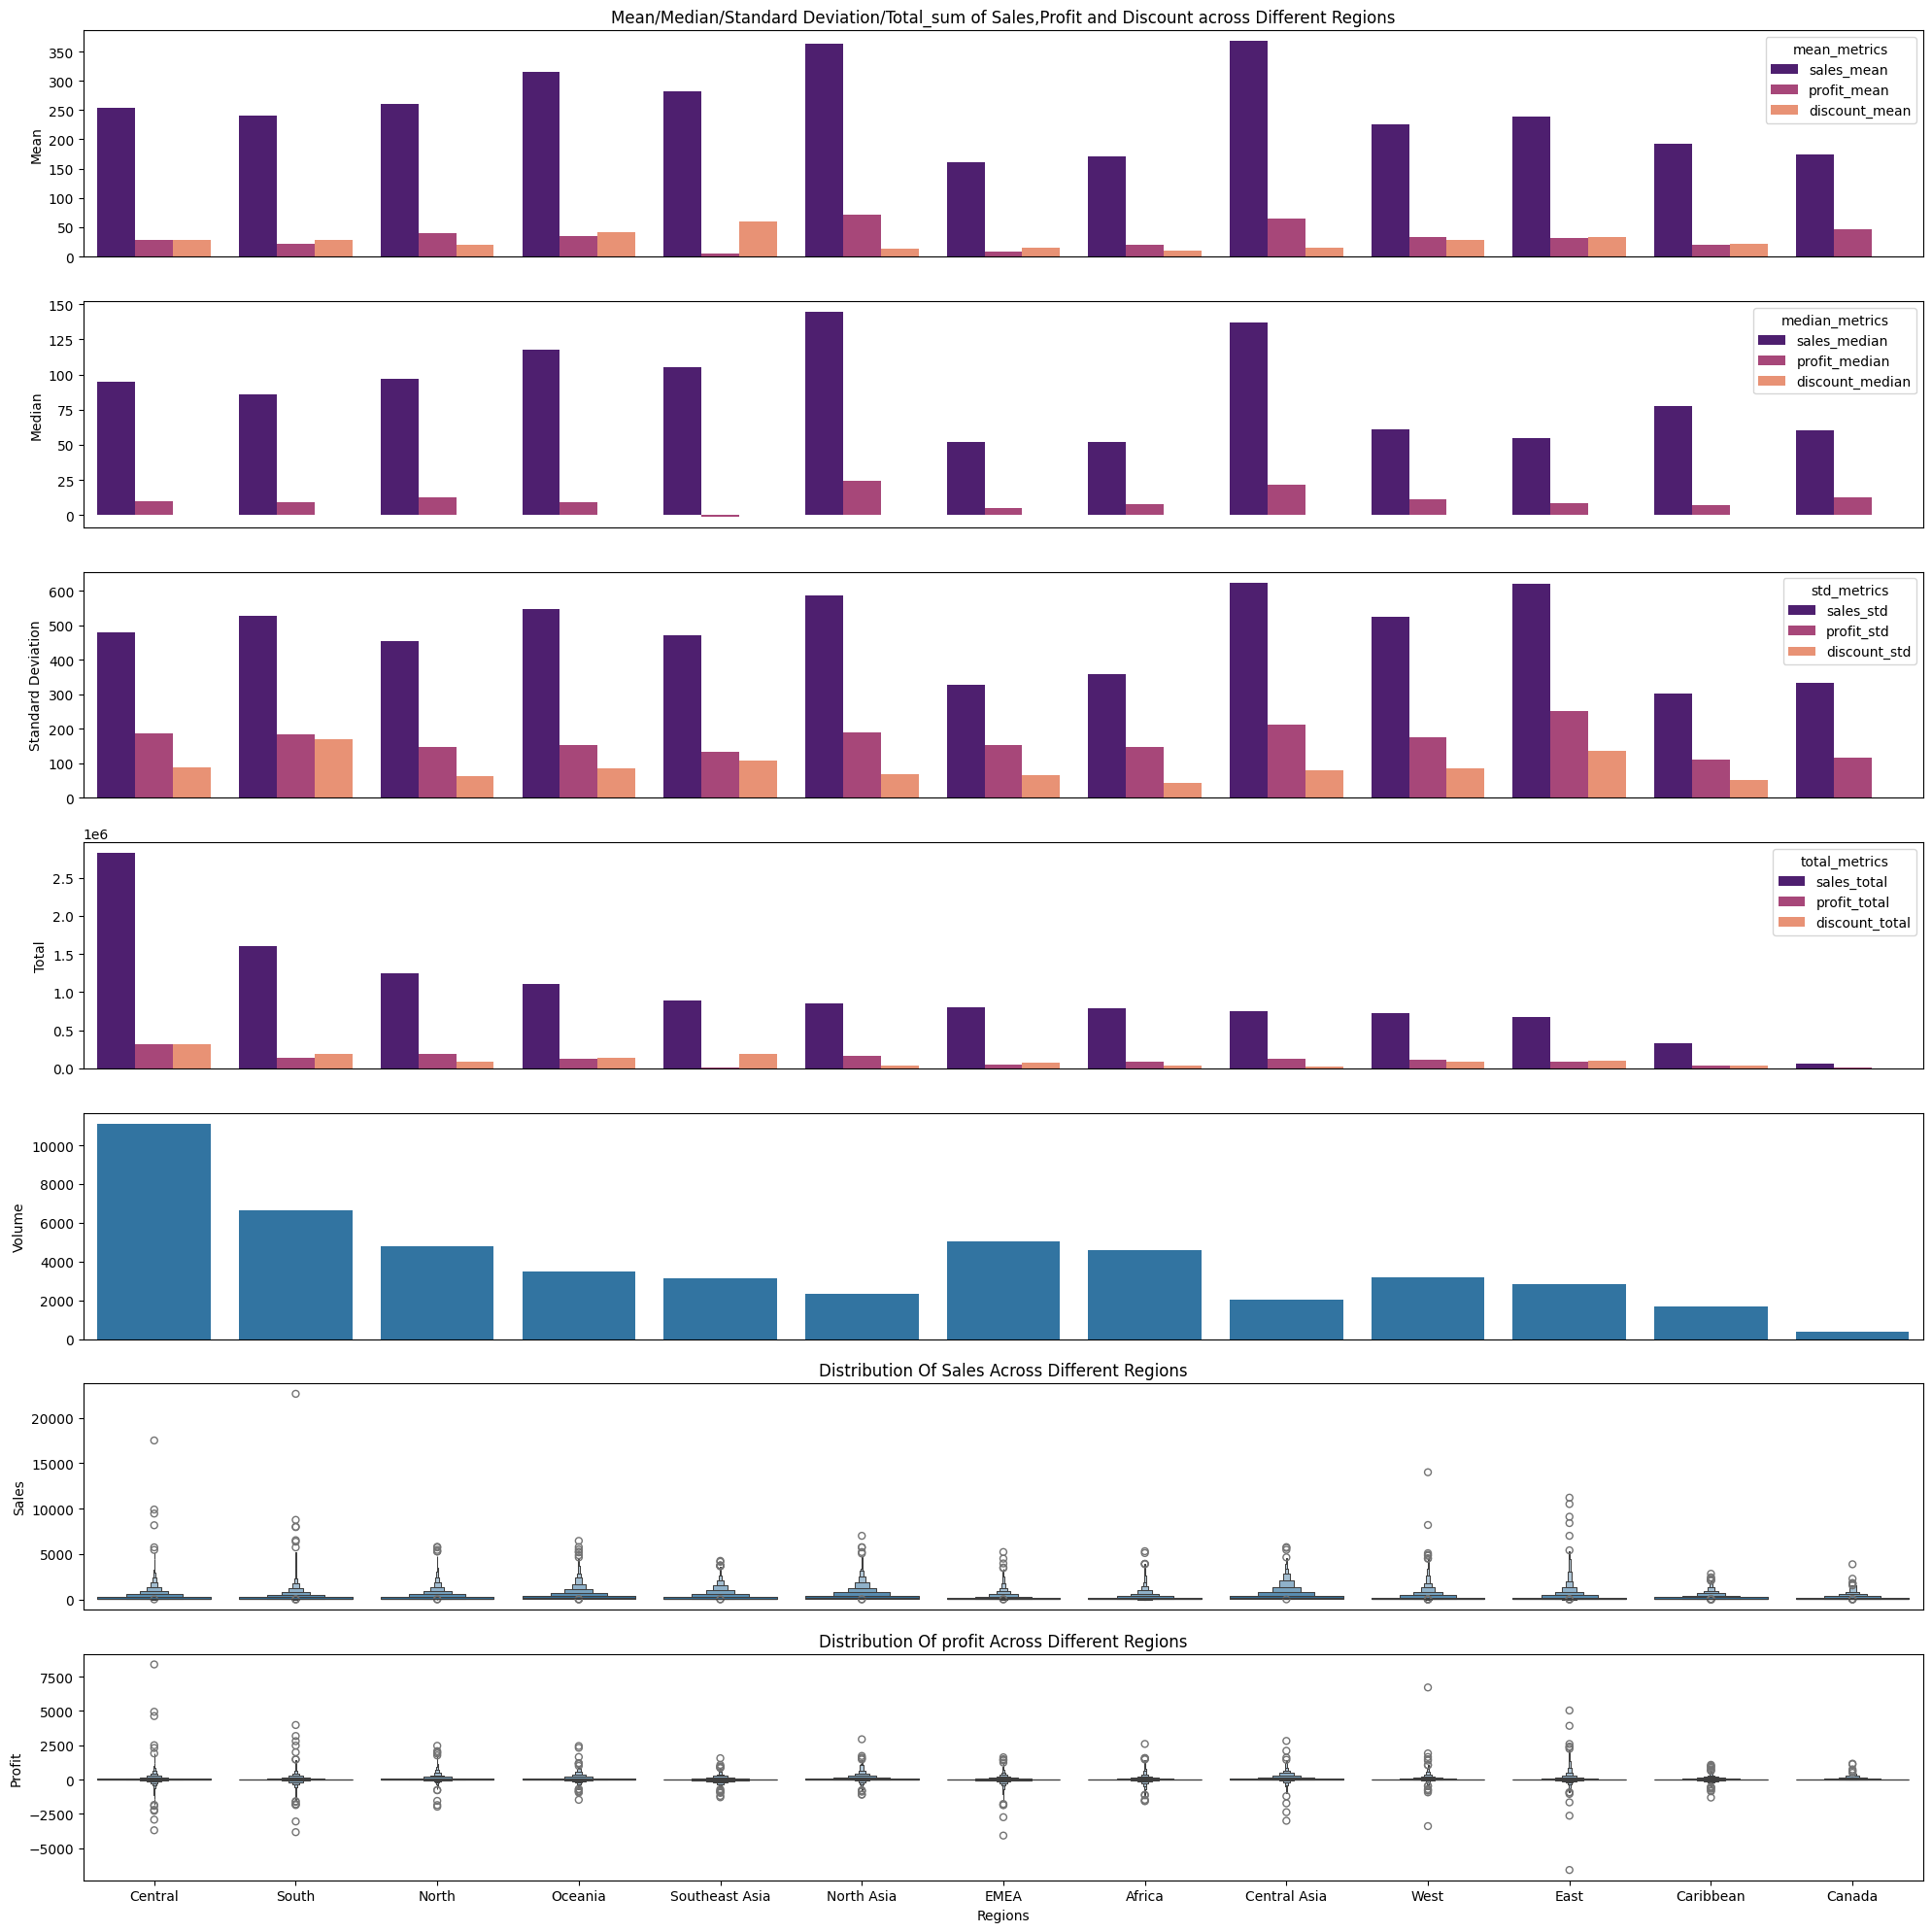

In [221]:
plt.figure(figsize=(20,20))
order=region_agg['region'].to_list()

plt.subplot(7,1,1)
sns.barplot(data=region_melted,x='region',y='mean_values',hue='mean_metrics',order=order,palette='magma')
plt.title('Mean/Median/Standard Deviation/Total_sum of Sales,Profit and Discount across Different Regions')
plt.xlabel('')
plt.ylabel('Mean')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,2)
sns.barplot(data=region_melted,x='region',y='median_values',hue='median_metrics',order=order,palette='magma')
plt.xlabel('')
plt.ylabel('Median')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,3)
sns.barplot(data=region_melted,x='region',y='std_values',hue='std_metrics',order=order,palette='magma')
plt.xlabel('')
plt.ylabel('Standard Deviation')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,4)
sns.barplot(data=region_melted,x='region',y='total_values',hue='total_metrics',order=order,palette='magma')
plt.xlabel('')
plt.ylabel('Total')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,5)
sns.barplot(data=region_agg,x='region',y='order_count',order=order)
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks([])
plt.tight_layout()


plt.subplot(7,1,6)
sns.boxenplot(data=df,x='region',y='sales',order=order)
plt.title('Distribution Of Sales Across Different Regions')
plt.xlabel('')
plt.ylabel('Sales')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,7)
sns.boxenplot(data=df,x='region',y='profit',order=order)
plt.title('Distribution Of profit Across Different Regions')
plt.xlabel('Regions')
plt.ylabel('Profit')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

### Analysis

- from the aspect of Region:
    - from left to right:
        - total sales  and Profit and order volume is decreasing from central to canada
            - the central region is most profitable region
                - we are getting most orders from central Region
                - we also need to focus in canada,southeast asia,north asia etc ...

    - profit is apoproximately centred around 0 for most of the region with more outliers in positive direction than in the negative direction accumulating it to total Positive profit 
        - it means profit is derived from outliers rather than accumulating small profits accumulating it to total high profit

## Segment VS Profit/Sales/Discount

In [222]:
df['segment']

0           Consumer
1           Consumer
2           Consumer
3           Consumer
4           Consumer
            ...     
51285      Corporate
51286      Corporate
51287    Home Office
51288    Home Office
51289      Corporate
Name: segment, Length: 51290, dtype: object

In [223]:
segment_agg=df.groupby(['segment'],as_index=False).agg(
    sales_mean=('sales','mean'),
    profit_mean=('profit','mean'),
    discount_mean=('discount_amount','mean'),
    sales_median=('sales','median'),
    profit_median=('profit','median'),
    discount_median=('discount','median'),
    sales_std=('sales','std'),
    profit_std=('profit','std'),
    discount_std=('discount_amount','std'),
    sales_total=('sales','sum'),
    profit_total=('profit','sum'),
    discount_total=('discount_amount','sum'),
    order_count=('quantity','count')
    ).sort_values(by=['sales_total'],ascending=False)
segment_agg

segment  sales_mean  profit_mean  discount_mean  sales_median  \
0     Consumer  245.423524    28.254008      26.092674          85.0   
1    Corporate  247.897336    28.596042      26.212598          85.0   
2  Home Office  247.239217    29.648847      26.759668          85.0   

   profit_median  discount_median   sales_std  profit_std  discount_std  \
0         9.1800              0.0  477.135009  174.006045     85.267792   
1         9.3152              0.0  486.046561  177.156362     86.026979   
2         9.3200              0.0  518.436832  170.577590    145.288369   

   sales_total  profit_total  discount_total  order_count  
0      6508141  749239.78206      691925.524        26518  
1      3824808  441208.32866      404434.178        15429  
2      2309956  277009.18056      250015.582         9343

In [224]:
segment_melted=merge_melted(df=segment_agg,common_cols=['segment'],no_of_melts=4,list_tuples_variables=[('sales_mean','profit_mean','discount_mean','mean_metrics','mean_values'),
                                                                                       ('sales_median','profit_median','discount_median','median_metrics','median_values'),
                                                                                       ('sales_std','profit_std','discount_std','std_metrics','std_values'),
                                                                                       ('sales_total','profit_total','discount_total','total_metrics','total_values')])
segment_melted

segment   mean_metrics  mean_values      type   median_metrics  \
0     Consumer     sales_mean   245.423524     sales     sales_median   
1    Corporate     sales_mean   247.897336     sales     sales_median   
2  Home Office     sales_mean   247.239217     sales     sales_median   
3     Consumer    profit_mean    28.254008    profit    profit_median   
4    Corporate    profit_mean    28.596042    profit    profit_median   
5  Home Office    profit_mean    29.648847    profit    profit_median   
6     Consumer  discount_mean    26.092674  discount  discount_median   
7    Corporate  discount_mean    26.212598  discount  discount_median   
8  Home Office  discount_mean    26.759668  discount  discount_median   

   median_values   std_metrics  std_values   total_metrics  total_values  
0        85.0000     sales_std  477.135009     sales_total  6.508141e+06  
1        85.0000     sales_std  486.046561     sales_total  3.824808e+06  
2        85.0000     sales_std  518.436832     sales_total  2.309956e+06  
3         9.1800    profit_std  174.006045    profit_total  7.492398e+05  
4         9.3152    profit_std  177.156362    profit_total  4.412083e+05  
5         9.3200    profit_std  170.577590    profit_total  2.770092e+05  
6         0.0000  discount_std   85.267792  discount_total  6.919255e+05  
7         0.0000  discount_std   86.026979  discount_total  4.044342e+05  
8         0.0000  discount_std  145.288369  discount_total  2.500156e+05

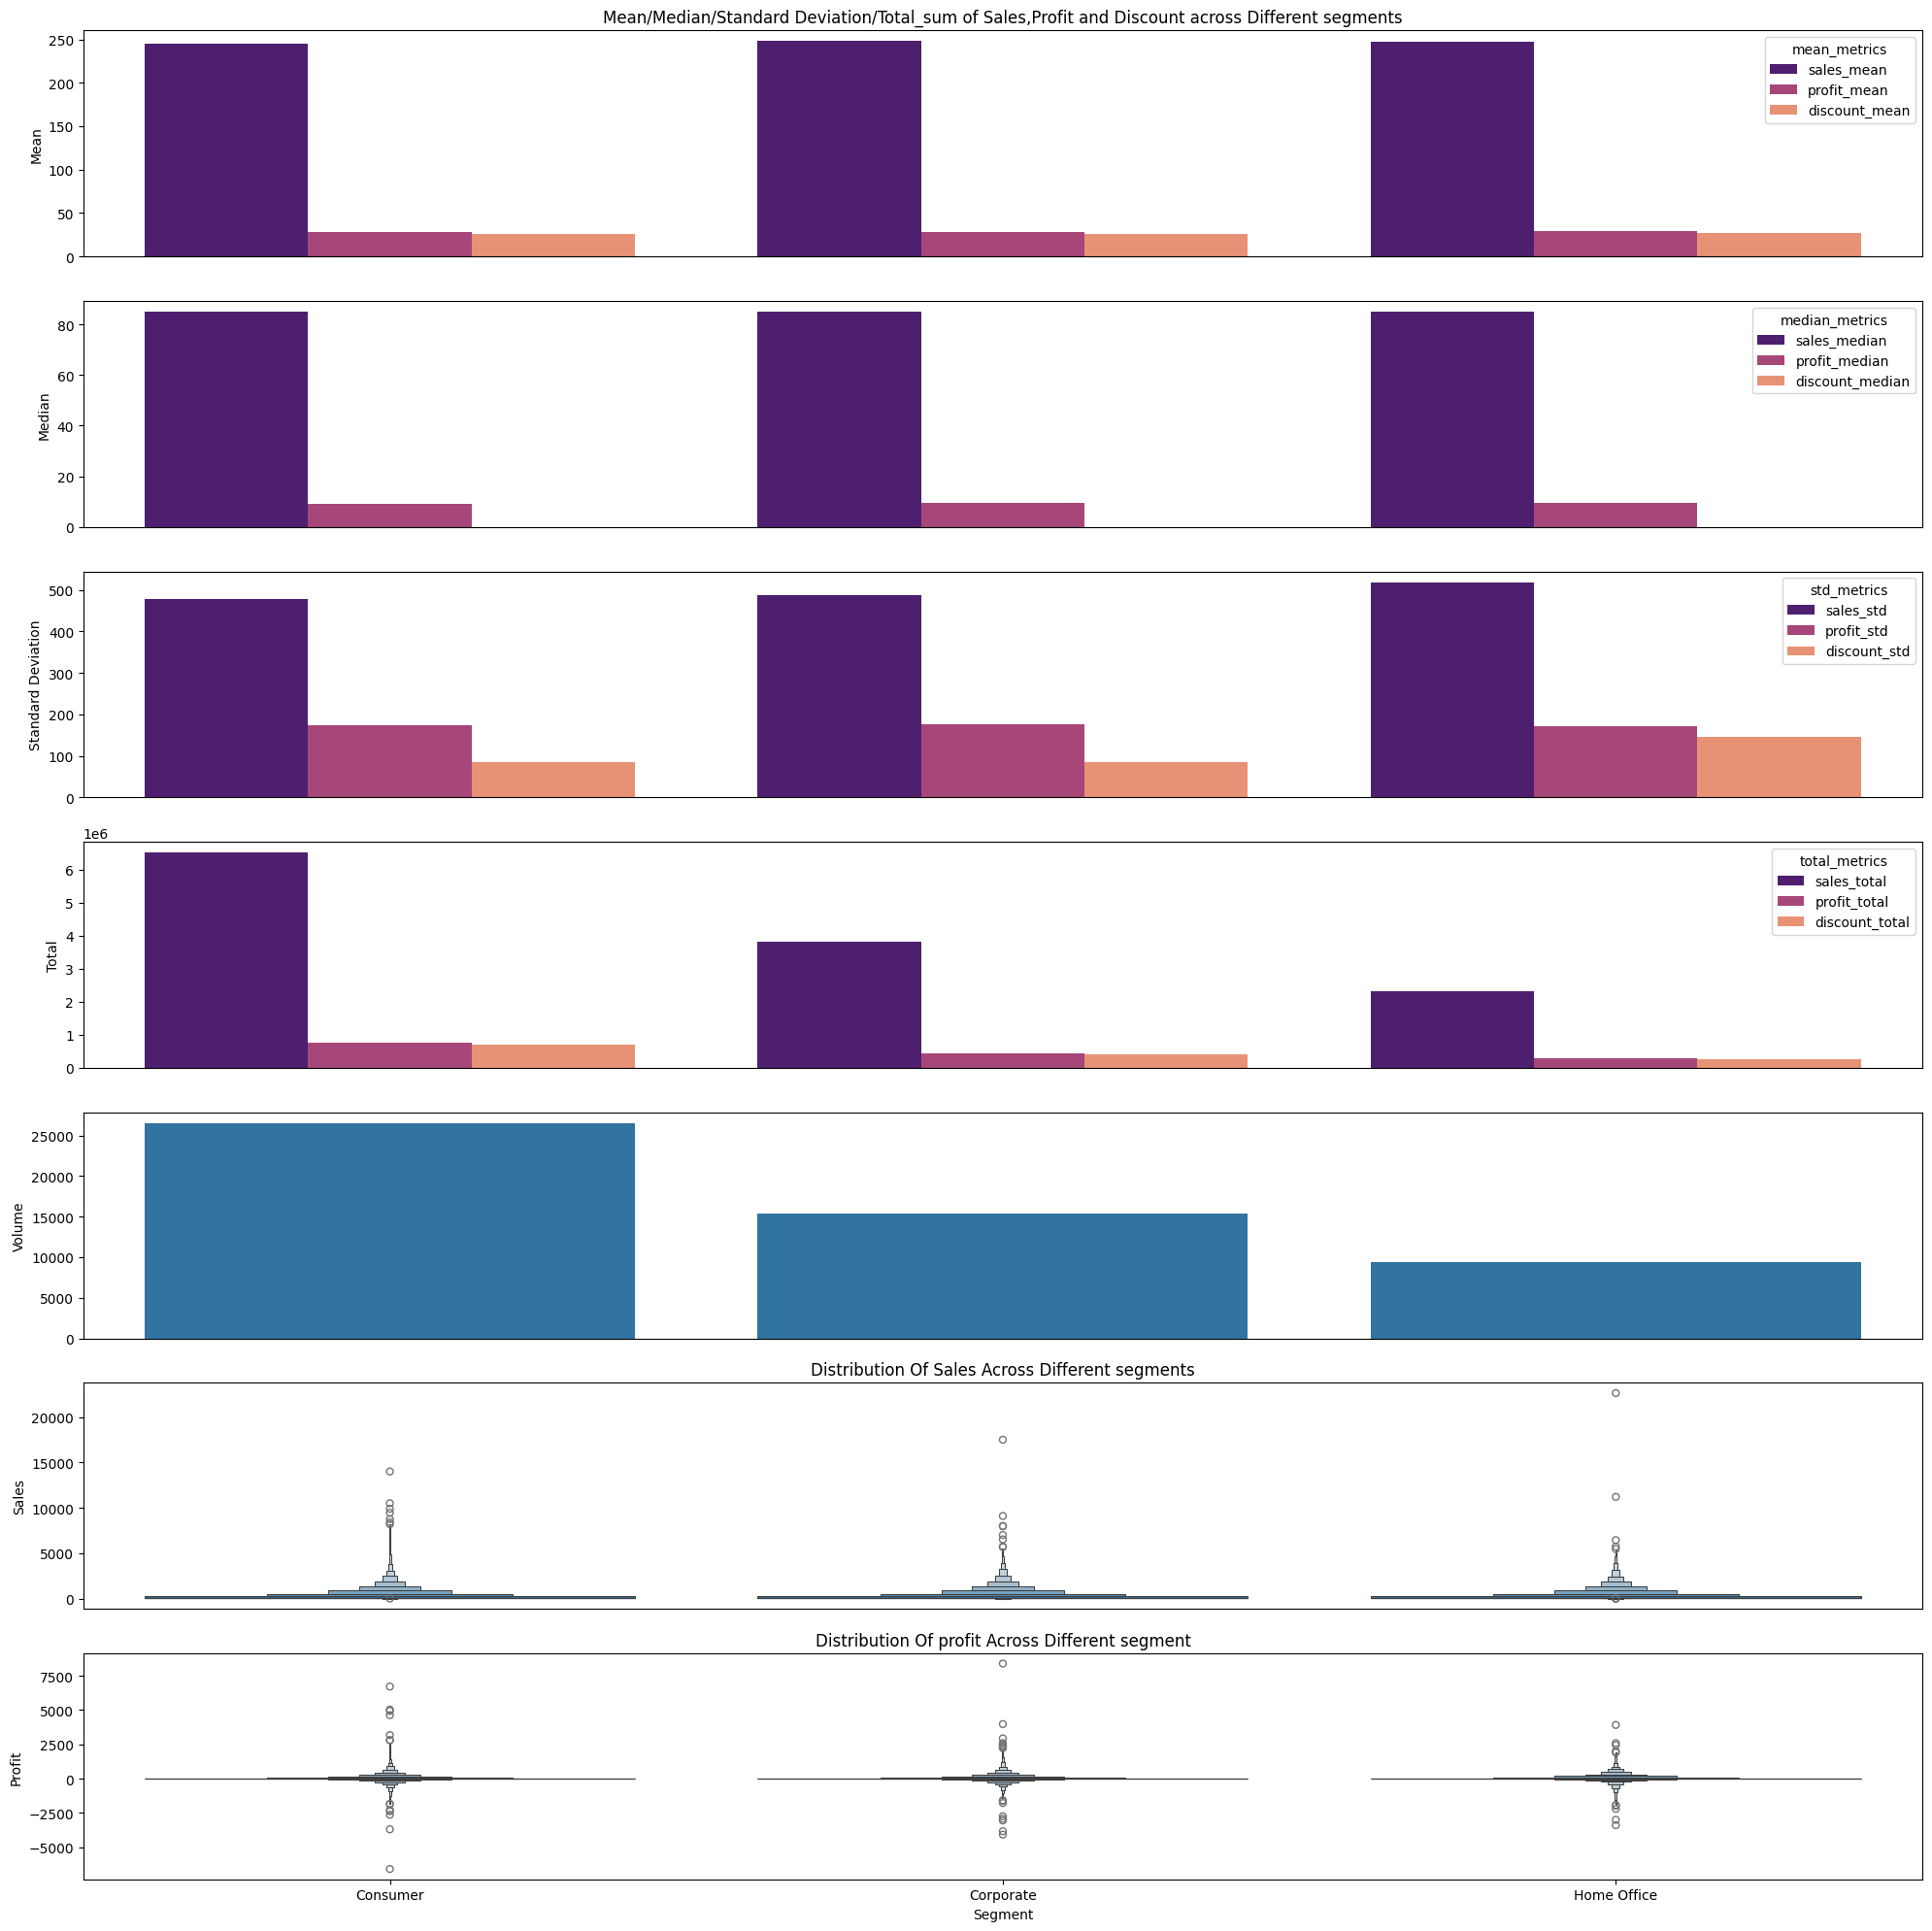

In [225]:
plt.figure(figsize=(20,20))
order=segment_agg['segment'].to_list()

plt.subplot(7,1,1)
sns.barplot(data=segment_melted,x='segment',y='mean_values',hue='mean_metrics',order=order,palette='magma')
plt.title('Mean/Median/Standard Deviation/Total_sum of Sales,Profit and Discount across Different segments')
plt.xlabel('')
plt.ylabel('Mean')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,2)
sns.barplot(data=segment_melted,x='segment',y='median_values',hue='median_metrics',order=order,palette='magma')
plt.xlabel('')
plt.ylabel('Median')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,3)
sns.barplot(data=segment_melted,x='segment',y='std_values',hue='std_metrics',order=order,palette='magma')
plt.xlabel('')
plt.ylabel('Standard Deviation')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,4)
sns.barplot(data=segment_melted,x='segment',y='total_values',hue='total_metrics',order=order,palette='magma')
plt.xlabel('')
plt.ylabel('Total')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,5)
sns.barplot(data=segment_agg,x='segment',y='order_count',order=order)
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks([])
plt.tight_layout()


plt.subplot(7,1,6)
sns.boxenplot(data=df,x='segment',y='sales',order=order)
plt.title('Distribution Of Sales Across Different segments')
plt.xlabel('')
plt.ylabel('Sales')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,7)
sns.boxenplot(data=df,x='segment',y='profit',order=order)
plt.title('Distribution Of profit Across Different segment')
plt.xlabel('Segment')
plt.ylabel('Profit')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

### Analysis

#### From the aspect of segment
- Mean and Median of sales,Profit and Discount across the segments are approximately equal
- Spread of sales and profit is equal across different segments
- total sales,profit and discount is higher in consumer segment than the corporate and is greater than home office
- distribution of profit across different segments are approximately equal

segment is not the overall profit Driver

## ShipMode VS Profit/Sales/Discount

In [226]:
df['ship_mode']

0          Second Class
1        Standard Class
2        Standard Class
3        Standard Class
4        Standard Class
              ...      
51285          Same Day
51286          Same Day
51287       First Class
51288       First Class
51289    Standard Class
Name: ship_mode, Length: 51290, dtype: object

In [227]:
shipmode_agg=df.groupby(['ship_mode'],as_index=False).agg(
    sales_mean=('sales','mean'),
    profit_mean=('profit','mean'),
    discount_mean=('discount_amount','mean'),
    sales_median=('sales','median'),
    profit_median=('profit','median'),
    discount_median=('discount','median'),
    sales_std=('sales','std'),
    profit_std=('profit','std'),
    discount_std=('discount_amount','std'),
    sales_total=('sales','sum'),
    profit_total=('profit','sum'),
    discount_total=('discount_amount','sum'),
    order_count=('quantity','count')
    ).sort_values(by=['sales_total'],ascending=False
)
shipmode_agg

ship_mode  sales_mean  profit_mean  discount_mean  sales_median  \
3  Standard Class  246.267717    28.938945      25.963546          86.0   
2    Second Class  248.884179    28.381368      25.740019          85.0   
0     First Class  243.979614    27.728804      27.147650          84.0   
1        Same Day  247.020363    28.201802      28.970826          84.0   

   profit_median  discount_median   sales_std  profit_std  discount_std  \
3         9.3312              0.0  491.895226  173.734759    105.164774   
2         9.1800              0.0  482.479326  163.009561     82.221344   
0         9.0000              0.0  482.875484  180.040453     85.447350   
1         8.9400              0.0  470.239358  204.475783    120.673444   

   sales_total  profit_total  discount_total  order_count  
3      7578889  890596.02120      799028.118        30775  
2      2565747  292583.52708      265353.852        10309  
0      1831067  208104.67520      203743.114         7505  
1       667202   76173.06780       78250.200         2701

In [228]:
shipmode_melted=merge_melted(df=shipmode_agg,common_cols=['ship_mode'],no_of_melts=4,list_tuples_variables=[('sales_mean','profit_mean','discount_mean','mean_metrics','mean_values'),
                                                                                       ('sales_median','profit_median','discount_median','median_metrics','median_values'),
                                                                                       ('sales_std','profit_std','discount_std','std_metrics','std_values'),
                                                                                       ('sales_total','profit_total','discount_total','total_metrics','total_values')])
shipmode_melted

ship_mode   mean_metrics  mean_values      type   median_metrics  \
0   Standard Class     sales_mean   246.267717     sales     sales_median   
1     Second Class     sales_mean   248.884179     sales     sales_median   
2      First Class     sales_mean   243.979614     sales     sales_median   
3         Same Day     sales_mean   247.020363     sales     sales_median   
4   Standard Class    profit_mean    28.938945    profit    profit_median   
5     Second Class    profit_mean    28.381368    profit    profit_median   
6      First Class    profit_mean    27.728804    profit    profit_median   
7         Same Day    profit_mean    28.201802    profit    profit_median   
8   Standard Class  discount_mean    25.963546  discount  discount_median   
9     Second Class  discount_mean    25.740019  discount  discount_median   
10     First Class  discount_mean    27.147650  discount  discount_median   
11        Same Day  discount_mean    28.970826  discount  discount_median   

    median_values   std_metrics  std_values   total_metrics  total_values  
0         86.0000     sales_std  491.895226     sales_total  7.578889e+06  
1         85.0000     sales_std  482.479326     sales_total  2.565747e+06  
2         84.0000     sales_std  482.875484     sales_total  1.831067e+06  
3         84.0000     sales_std  470.239358     sales_total  6.672020e+05  
4          9.3312    profit_std  173.734759    profit_total  8.905960e+05  
5          9.1800    profit_std  163.009561    profit_total  2.925835e+05  
6          9.0000    profit_std  180.040453    profit_total  2.081047e+05  
7          8.9400    profit_std  204.475783    profit_total  7.617307e+04  
8          0.0000  discount_std  105.164774  discount_total  7.990281e+05  
9          0.0000  discount_std   82.221344  discount_total  2.653539e+05  
10         0.0000  discount_std   85.447350  discount_total  2.037431e+05  
11         0.0000  discount_std  120.673444  discount_total  7.825020e+04

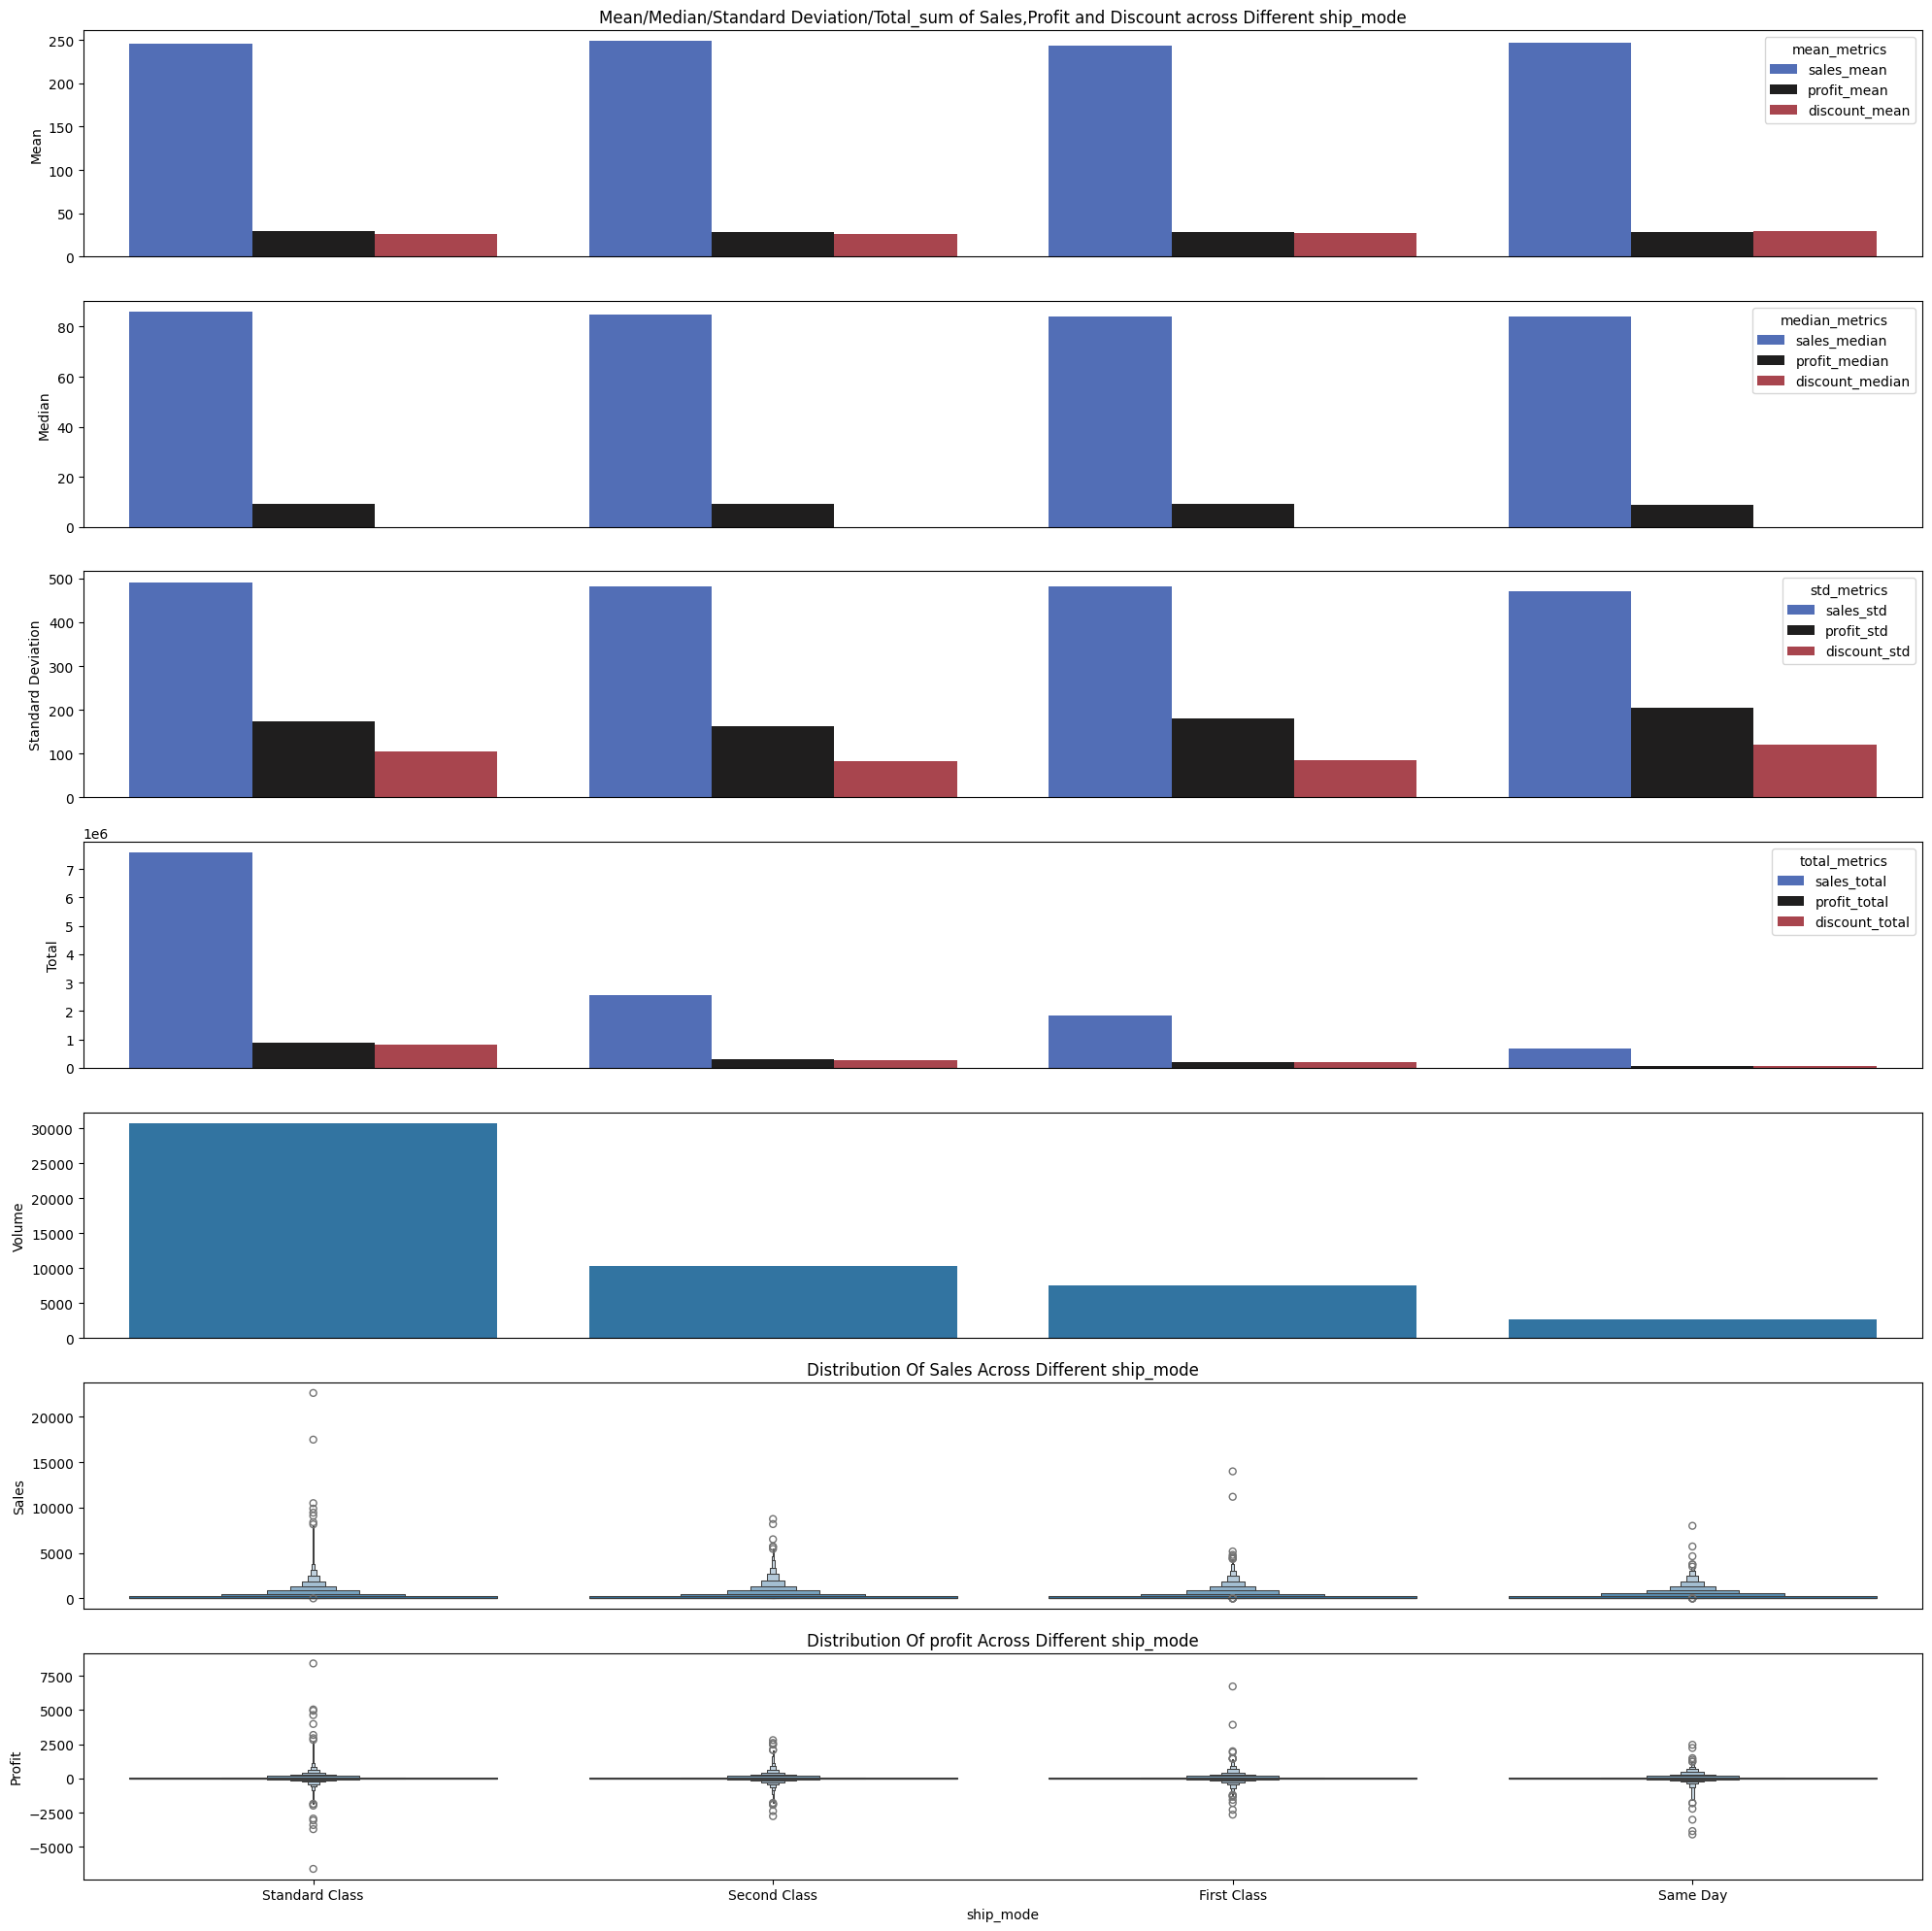

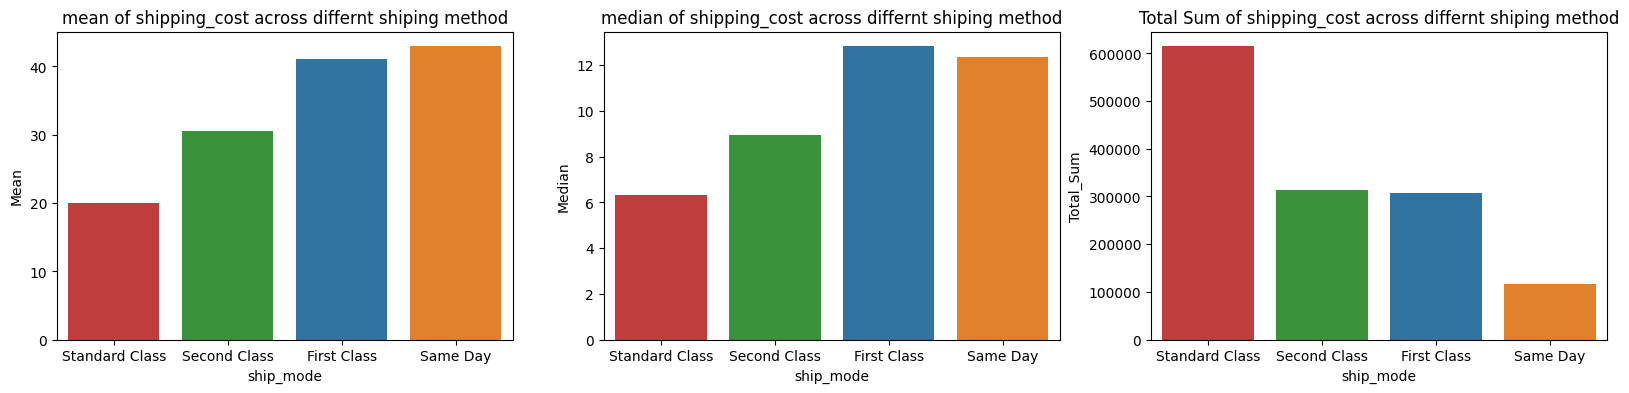

In [229]:
plt.figure(figsize=(20,20))
order=shipmode_agg['ship_mode'].to_list()

plt.subplot(7,1,1)
sns.barplot(data=shipmode_melted,x='ship_mode',y='mean_values',hue='mean_metrics',order=order,palette='icefire')
plt.title('Mean/Median/Standard Deviation/Total_sum of Sales,Profit and Discount across Different ship_mode')
plt.xlabel('')
plt.ylabel('Mean')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,2)
sns.barplot(data=shipmode_melted,x='ship_mode',y='median_values',hue='median_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Median')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,3)
sns.barplot(data=shipmode_melted,x='ship_mode',y='std_values',hue='std_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Standard Deviation')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,4)
sns.barplot(data=shipmode_melted,x='ship_mode',y='total_values',hue='total_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Total')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,5)
sns.barplot(data=shipmode_agg,x='ship_mode',y='order_count',order=order)
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks([])
plt.tight_layout()


plt.subplot(7,1,6)
sns.boxenplot(data=df,x='ship_mode',y='sales',order=order)
plt.title('Distribution Of Sales Across Different ship_mode')
plt.xlabel('')
plt.ylabel('Sales')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,7)
sns.boxenplot(data=df,x='ship_mode',y='profit',order=order)
plt.title('Distribution Of profit Across Different ship_mode')
plt.xlabel('ship_mode')
plt.ylabel('Profit')
plt.xticks(rotation=0)
plt.tight_layout()

sc_agg=df.groupby(['ship_mode'],as_index=False).agg(
    sc_mean=('shipping_cost','mean'),
    sc_median=('shipping_cost','median'),
    sc_total=('shipping_cost','sum')
)
plt.figure(figsize=(20,4))
order=shipmode_agg['ship_mode'].to_list()

plt.subplot(1,3,1)
sns.barplot(data=sc_agg,x='ship_mode',y='sc_mean',hue='ship_mode',order=order)
plt.title("mean of shipping_cost across differnt shiping method")
plt.xlabel('ship_mode')
plt.ylabel('Mean')
plt.xticks()

plt.subplot(1,3,2)
sns.barplot(data=sc_agg,x='ship_mode',y='sc_median',hue='ship_mode',order=order)
plt.title("median of shipping_cost across differnt shiping method")
plt.xlabel('ship_mode')
plt.ylabel('Median')
plt.xticks()

plt.subplot(1,3,3)
sns.barplot(data=sc_agg,x='ship_mode',y='sc_total',hue='ship_mode',order=order)
plt.title("Total Sum of shipping_cost across differnt shiping method")
plt.xlabel('ship_mode')
plt.ylabel('Total_Sum')
plt.xticks()

plt.show()

### Analysis

#### From the aspect of segement
- Mean and Median of sales,Profit and Discount across the shipping mode are approximately equal
- Spread of sales and profit is equal across different segments
- total sales,profit and discount is decreasing from stadard class to second class to first class to same day shipments
- distribution of profit across different segments are approximately equal with presence of more outliers in both direction n standard,first class and same day shipping
- volume decreases from stadard class to second class to first class to same day shipments

ship_mode is not the overall profit Driver,so we should be focusing more on standard class shipment (faster delivery does not derive more profit) as it derives more profits than other ship_mode in total becuase of Mean and Median being lesser than second ,first and same day ship_mode

## State VS Profit/Sales/Discount

In [230]:
df['state']

0        California
1        California
2        California
3        California
4        California
            ...    
51285    California
51286    California
51287    California
51288    California
51289    California
Name: state, Length: 51290, dtype: object

In [231]:
state_agg=df.groupby(['state'],as_index=False).agg(
    sales_mean=('sales','mean'),
    profit_mean=('profit','mean'),
    discount_mean=('discount_amount','mean'),
    sales_median=('sales','median'),
    profit_median=('profit','median'),
    discount_median=('discount','median'),
    sales_std=('sales','std'),
    profit_std=('profit','std'),
    discount_std=('discount_amount','std'),
    sales_total=('sales','sum'),
    profit_total=('profit','sum'),
    discount_total=('discount_amount','sum'),
    order_count=('quantity','count')
    ).sort_values(by=['sales_total'],ascending=False
)
state_agg

state  sales_mean  profit_mean  discount_mean  sales_median  \
311             England  323.659773    66.649587      12.817612         118.0   
192          California  228.751124    38.171608      27.954223          61.0   
435       Ile-de-France  323.973496    44.909199      32.487615         140.0   
703            New York  275.632979    65.637011      21.864894          60.0   
702     New South Wales  346.362356    55.948763      32.583739         131.0   
..                  ...         ...          ...            ...           ...   
781              Pernik   15.000000     6.660000       0.000000          15.0   
603          Manicaland    6.000000    -6.928500       4.200000           6.0   
155              Bitola   11.000000     4.500000       0.000000          11.0   
473            Kabarole    4.000000    -5.487000       2.800000           4.0   
628  Matabeleland North    3.000000    -5.325000       2.100000           3.0   

     profit_median  discount_median   sales_std  profit_std  discount_std  \
311        18.5400              0.0  567.093582  187.392519     51.057127   
192        13.3056              0.0  491.007355   97.691593     82.925076   
435        18.5400              0.0  473.407674  121.160614     73.077421   
703        13.8396              0.0  691.727889  232.540498    101.575961   
702        13.6440              0.1  573.691768  153.616814     71.493150   
..             ...              ...         ...         ...           ...   
781         6.6600              0.0         NaN         NaN           NaN   
603        -6.9285              0.7    2.828427    3.001668      1.979899   
155         4.5000              0.0         NaN         NaN           NaN   
473        -5.4870              0.7         NaN         NaN           NaN   
628        -5.3250              0.7         NaN         NaN           NaN   

     sales_total  profit_total  discount_total  order_count  
311       485166    99907.7310        19213.60         1499  
192       457731    76381.3871        55936.40         2001  
435       317818    44055.9240        31870.35          981  
703       310914    74038.5486        24663.60         1128  
702       270509    43695.9840        25447.90          781  
..           ...           ...             ...          ...  
781           15        6.6600            0.00            1  
603           12      -13.8570            8.40            2  
155           11        4.5000            0.00            1  
473            4       -5.4870            2.80            1  
628            3       -5.3250            2.10            1  

[1094 rows x 14 columns]

In [232]:
state_agg[state_agg['state']=='Jharkhand']

state  sales_mean  profit_mean  discount_mean  sales_median  \
462  Jharkhand  466.576923   154.813846            0.0         109.5   

     profit_median  discount_median   sales_std  profit_std  discount_std  \
462          38.61              0.0  895.624706   293.97474           0.0   

     sales_total  profit_total  discount_total  order_count  
462        12131       4025.16             0.0           26

In [233]:
state_agg[state_agg['state']=='West Bengal']

state  sales_mean  profit_mean  discount_mean  sales_median  \
1052  West Bengal  331.326531    56.157551            0.0         152.0   

      profit_median  discount_median   sales_std  profit_std  discount_std  \
1052          28.32              0.0  723.374021  114.688966           0.0   

      sales_total  profit_total  discount_total  order_count  
1052        16235       2751.72             0.0           49

In [234]:
state_agg[state_agg['state']=='Bihar']

state  sales_mean  profit_mean  discount_mean  sales_median  \
148  Bihar  493.344828   105.846207            0.0         139.5   

     profit_median  discount_median   sales_std  profit_std  discount_std  \
148          35.61              0.0  987.205031  222.770588           0.0   

     sales_total  profit_total  discount_total  order_count  
148        28614       6139.08             0.0           58

1094 states,very high cardinality
- only selecting top 20 and bottom 20
- will be filtering the state having order_count>=thresold

In [235]:
state_agg['order_count'].describe()

count    1094.000000
mean       46.882998
std       121.132590
min         1.000000
25%         5.000000
50%        14.000000
75%        39.000000
max      2001.000000
Name: order_count, dtype: float64

- since mean is way above than 75th percentile,it is pulled by some of the giant states having very huge order_counts
- therefore taking median as thresold value

In [236]:
(state_agg[state_agg['order_count']<state_agg['order_count'].median()]['sales_total'].sum()/state_agg['sales_total'].sum())*100

np.float64(5.493436832753232)

In [237]:
(state_agg[state_agg['order_count']<state_agg['order_count'].median()]['profit_total'].sum()/state_agg['profit_total'].sum())*100

np.float64(5.864507624949976)

In [238]:
((state_agg[state_agg['order_count']<state_agg['order_count'].median()]['sales_total'].sum()/state_agg['sales_total'].sum())*100)/((state_agg[state_agg['order_count']<state_agg['order_count'].median()]['profit_total'].sum()/state_agg['profit_total'].sum())*100)

np.float64(0.9367260107876645)

In [239]:
df[df['state'].isin(state_agg[state_agg['order_count']<state_agg['order_count'].median()]['state'].to_list())]['discount'].value_counts()

discount
0.000    2075
0.700     246
0.600     215
0.400     143
0.500     101
0.200      56
0.170      48
0.470      35
0.100      24
0.002      22
0.270      20
0.402       9
0.070       7
0.370       6
0.350       4
0.202       3
0.800       2
0.300       2
0.450       1
0.250       1
Name: count, dtype: int64

- state's where the order_count < median generates approx 5.5% of total sales
- state's where the order_count < median generates approx 5.86% of total profit
- current profit efficiency of states generating order's less than median orders_count--93% of company's average profit
- in most of the orders,0.00 discount has been given
- if proper campaigns are run and lucrative discounts are being given to people's of these state's then that can increase the company's revenue as well as profit

In [240]:
signi_state_agg=state_agg[state_agg['order_count']>=state_agg['order_count'].median()]
signi_state_agg

state  sales_mean  profit_mean  discount_mean  sales_median  \
311          England  323.659773    66.649587      12.817612         118.0   
192       California  228.751124    38.171608      27.954223          61.0   
435    Ile-de-France  323.973496    44.909199      32.487615         140.0   
703         New York  275.632979    65.637011      21.864894          60.0   
702  New South Wales  346.362356    55.948763      32.583739         131.0   
..               ...         ...          ...            ...           ...   
44           Anambra   38.944444   -52.546333      27.261111          25.0   
914            Sivas   39.705882   -21.291529      23.823529          12.0   
83            Astana   36.500000   -58.427667      25.550000          15.5   
37       Almaty City   32.888889   -48.624667      23.022222          37.5   
869        Sanliurfa   36.937500   -36.462750      22.162500          16.0   

     profit_median  discount_median   sales_std  profit_std  discount_std  \
311        18.5400              0.0  567.093582  187.392519     51.057127   
192        13.3056              0.0  491.007355   97.691593     82.925076   
435        18.5400              0.0  473.407674  121.160614     73.077421   
703        13.8396              0.0  691.727889  232.540498    101.575961   
702        13.6440              0.1  573.691768  153.616814     71.493150   
..             ...              ...         ...         ...           ...   
44        -33.4065              0.7   36.505394   50.735601     25.553776   
914        -7.4940              0.6   65.231094   21.532168     39.138656   
83        -20.9460              0.7   52.218151   89.754911     36.552706   
37        -52.0770              0.7   25.085475   35.567105     17.559832   
869       -16.8300              0.6   46.278100   45.014816     27.766860   

     sales_total  profit_total  discount_total  order_count  
311       485166    99907.7310        19213.60         1499  
192       457731    76381.3871        55936.40         2001  
435       317818    44055.9240        31870.35          981  
703       310914    74038.5486        24663.60         1128  
702       270509    43695.9840        25447.90          781  
..           ...           ...             ...          ...  
44           701     -945.8340          490.70           18  
914          675     -361.9560          405.00           17  
83           657    -1051.6980          459.90           18  
37           592     -875.2440          414.40           18  
869          591     -583.4040          354.60           16  

[554 rows x 14 columns]

In [241]:
top20state=signi_state_agg.head(20)
bottom20state=signi_state_agg.tail(20)

In [242]:
top20state_melted=merge_melted(df=top20state,common_cols=['state'],no_of_melts=4,list_tuples_variables=[('sales_mean','profit_mean','discount_mean','mean_metrics','mean_values'),
                                                                                       ('sales_median','profit_median','discount_median','median_metrics','median_values'),
                                                                                       ('sales_std','profit_std','discount_std','std_metrics','std_values'),
                                                                                       ('sales_total','profit_total','discount_total','total_metrics','total_values')])
top20state_melted

state   mean_metrics  mean_values      type  \
0                      England     sales_mean   323.659773     sales   
1                   California     sales_mean   228.751124     sales   
2                Ile-de-France     sales_mean   323.973496     sales   
3                     New York     sales_mean   275.632979     sales   
4              New South Wales     sales_mean   346.362356     sales   
5                   Queensland     sales_mean   332.372385     sales   
6       North Rhine-Westphalia     sales_mean   301.054242     sales   
7                        Texas     sales_mean   172.778680     sales   
8                 San Salvador     sales_mean   249.834146     sales   
9             National Capital     sales_mean   261.037736     sales   
10                    Victoria     sales_mean   309.140530     sales   
11                  Washington     sales_mean   274.023715     sales   
12            Distrito Federal     sales_mean   273.833689     sales   
13                Pennsylvania     sales_mean   198.504259     sales   
14  Provence-Alpes-Côte d'Azur     sales_mean   293.251282     sales   
15           Western Australia     sales_mean   356.038462     sales   
16                   Guatemala     sales_mean   265.089514     sales   
17                 Maharashtra     sales_mean   349.396552     sales   
18                   São Paulo     sales_mean   240.630807     sales   
19                   Guangdong     sales_mean   338.366197     sales   
20                     England    profit_mean    66.649587    profit   
21                  California    profit_mean    38.171608    profit   
22               Ile-de-France    profit_mean    44.909199    profit   
23                    New York    profit_mean    65.637011    profit   
24             New South Wales    profit_mean    55.948763    profit   
25                  Queensland    profit_mean    30.137732    profit   
26      North Rhine-Westphalia    profit_mean    58.898291    profit   
27                       Texas    profit_mean   -26.121174    profit   
28                San Salvador    profit_mean    58.346954    profit   
29            National Capital    profit_mean   -22.411809    profit   
30                    Victoria    profit_mean    30.405458    profit   
31                  Washington    profit_mean    66.013146    profit   
32            Distrito Federal    profit_mean    42.817978    profit   
33                Pennsylvania    profit_mean   -26.507598    profit   
34  Provence-Alpes-Côte d'Azur    profit_mean    43.225773    profit   
35           Western Australia    profit_mean    45.672365    profit   
36                   Guatemala    profit_mean    54.042196    profit   
37                 Maharashtra    profit_mean    55.537086    profit   
38                   São Paulo    profit_mean    53.491501    profit   
39                   Guangdong    profit_mean    69.256901    profit   
40                     England  discount_mean    12.817612  discount   
41                  California  discount_mean    27.954223  discount   
42               Ile-de-France  discount_mean    32.487615  discount   
43                    New York  discount_mean    21.864894  discount   
44             New South Wales  discount_mean    32.583739  discount   
45                  Queensland  discount_mean    49.226499  discount   
46      North Rhine-Westphalia  discount_mean    16.587135  discount   
47                       Texas  discount_mean    53.092508  discount   
48                San Salvador  discount_mean     5.091980  discount   
49            National Capital  discount_mean    77.037993  discount   
50                    Victoria  discount_mean    45.721589  discount   
51                  Washington  discount_mean    19.651779  discount   
52            Distrito Federal  discount_mean    19.581339  discount   
53                Pennsylvania  discount_mean    66.634753  discount   
54  Provence-Alpes-Côte d'Azur  discount_mean    29.114103  disco

In [243]:
bottom20state_melted=merge_melted(df=bottom20state,common_cols=['state'],no_of_melts=4,list_tuples_variables=[('sales_mean','profit_mean','discount_mean','mean_metrics','mean_values'),
                                                                                       ('sales_median','profit_median','discount_median','median_metrics','median_values'),
                                                                                       ('sales_std','profit_std','discount_std','std_metrics','std_values'),
                                                                                       ('sales_total','profit_total','discount_total','total_metrics','total_values')])
bottom20state_melted

state   mean_metrics  mean_values      type   median_metrics  \
0              Manisa     sales_mean    44.153846     sales     sales_median   
1         Cross River     sales_mean    53.238095     sales     sales_median   
2             Denizli     sales_mean    73.533333     sales     sales_median   
3   Chaouia-Ouardigha     sales_mean    76.571429     sales     sales_median   
4                Abia     sales_mean    42.520000     sales     sales_median   
5               Hatay     sales_mean    73.357143     sales     sales_median   
6            Pavlodar     sales_mean    67.333333     sales     sales_median   
7               Konya     sales_mean    42.909091     sales     sales_median   
8          Qaraghandy     sales_mean    40.782609     sales     sales_median   
9           Eskisehir     sales_mean    55.000000     sales     sales_median   
10      Kahramanmaras     sales_mean    59.500000     sales     sales_median   
11         Diyarbakir     sales_mean    49.250000     sales     sales_median   
12            Plateau     sales_mean    41.000000     sales     sales_median   
13              Borno     sales_mean    37.047619     sales     sales_median   
14                Van     sales_mean    44.937500     sales     sales_median   
15            Anambra     sales_mean    38.944444     sales     sales_median   
16              Sivas     sales_mean    39.705882     sales     sales_median   
17             Astana     sales_mean    36.500000     sales     sales_median   
18        Almaty City     sales_mean    32.888889     sales     sales_median   
19          Sanliurfa     sales_mean    36.937500     sales     sales_median   
20             Manisa    profit_mean   -34.865538    profit    profit_median   
21        Cross River    profit_mean   -91.018143    profit    profit_median   
22            Denizli    profit_mean   -56.685600    profit    profit_median   
23  Chaouia-Ouardigha    profit_mean    16.110000    profit    profit_median   
24               Abia    profit_mean   -59.022240    profit    profit_median   
25              Hatay    profit_mean   -64.948714    profit    profit_median   
26           Pavlodar    profit_mean  -120.687400    profit    profit_median   
27              Konya    profit_mean   -36.053455    profit    profit_median   
28         Qaraghandy    profit_mean   -60.788217    profit    profit_median   
29          Eskisehir    profit_mean   -52.307294    profit    profit_median   
30      Kahramanmaras    profit_mean   -46.811571    profit    profit_median   
31         Diyarbakir    profit_mean   -39.604125    profit    profit_median   
32            Plateau    profit_mean   -67.501579    profit    profit_median   
33              Borno    profit_mean   -63.451857    profit    profit_median   
34                Van    profit_mean   -36.905625    profit    profit_median   
35            Anambra    profit_mean   -52.546333    profit    profit_median   
36              Sivas    profit_mean   -21.291529    profit    profit_median   
37             Astana    profit_mean   -58.427667    profit    profit_median   
38        Almaty City    profit_mean   -48.624667    profit    profit_median   
39          Sanliurfa    profit_mean   -36.462750    profit    profit_median   
40             Manisa  discount_mean    26.492308  discount  discount_median   
41        Cross River  discount_mean    37.266667  discount  discount_median   
42            Denizli  discount_mean    44.120000  discount  discount_median   
43  Chaouia-Ouardigha  discount_mean     0.000000  discount  discount_median   
44               Abia  discount_mean    29.764000  discount  discount_median   
45              Hatay  discount_mean    44.014286  discount  discount_median   
46           Pavlodar  discount_mean    47.133333  discount  discount_median   
47              Konya  discount_mean    25.745455  discount  discount_median   
48         Qaraghandy  discount_mean    28.547826  discount  discount_median   
49          Eski

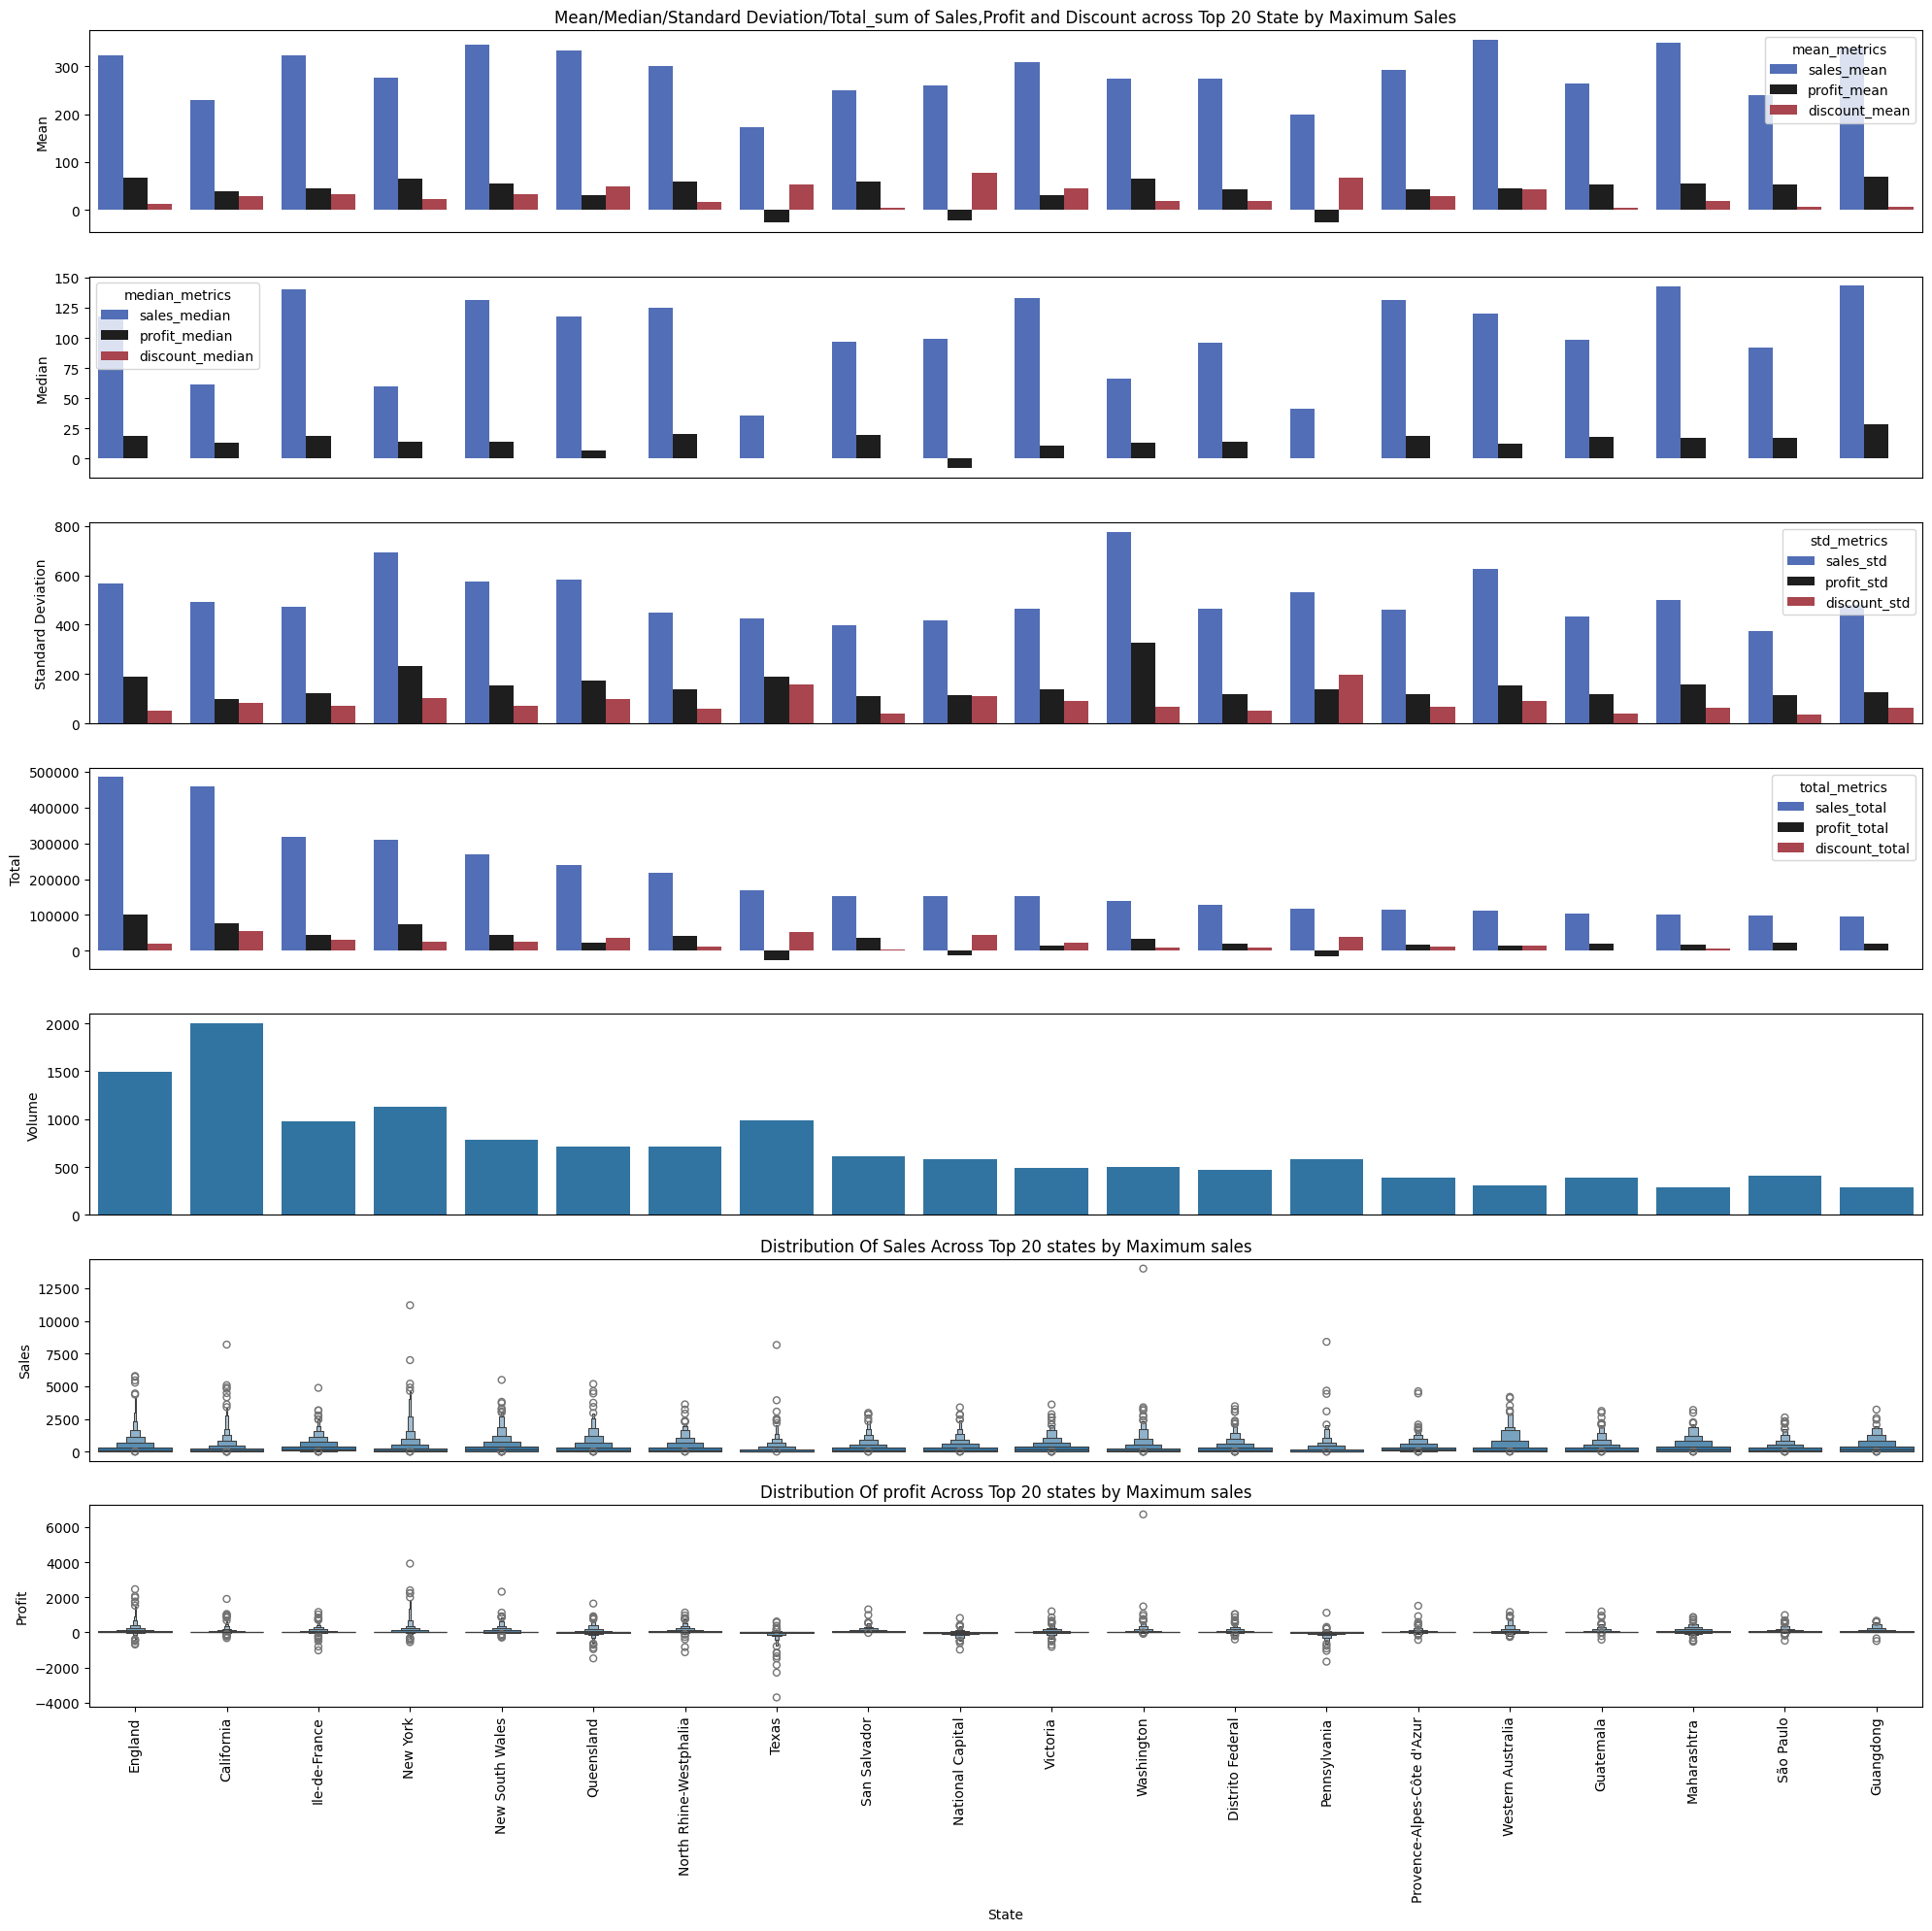

In [244]:
plt.figure(figsize=(20,20))
order=top20state['state'].to_list()

plt.subplot(7,1,1)
sns.barplot(data=top20state_melted,x='state',y='mean_values',hue='mean_metrics',order=order,palette='icefire')
plt.title('Mean/Median/Standard Deviation/Total_sum of Sales,Profit and Discount across Top 20 State by Maximum Sales')
plt.xlabel('')
plt.ylabel('Mean')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,2)
sns.barplot(data=top20state_melted,x='state',y='median_values',hue='median_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Median')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,3)
sns.barplot(data=top20state_melted,x='state',y='std_values',hue='std_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Standard Deviation')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,4)
sns.barplot(data=top20state_melted,x='state',y='total_values',hue='total_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Total')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,5)
sns.barplot(data=top20state,x='state',y='order_count',order=order)
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks([])
plt.tight_layout()


plt.subplot(7,1,6)
sns.boxenplot(data=df[df['state'].isin(top20state['state'].to_list())],x='state',y='sales',order=order)
plt.title('Distribution Of Sales Across Top 20 states by Maximum sales')
plt.xlabel('')
plt.ylabel('Sales')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,7)
sns.boxenplot(data=df[df['state'].isin(top20state['state'].to_list())],x='state',y='profit',order=order)
plt.title('Distribution Of profit Across Top 20 states by Maximum sales')
plt.xlabel('State')
plt.ylabel('Profit')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

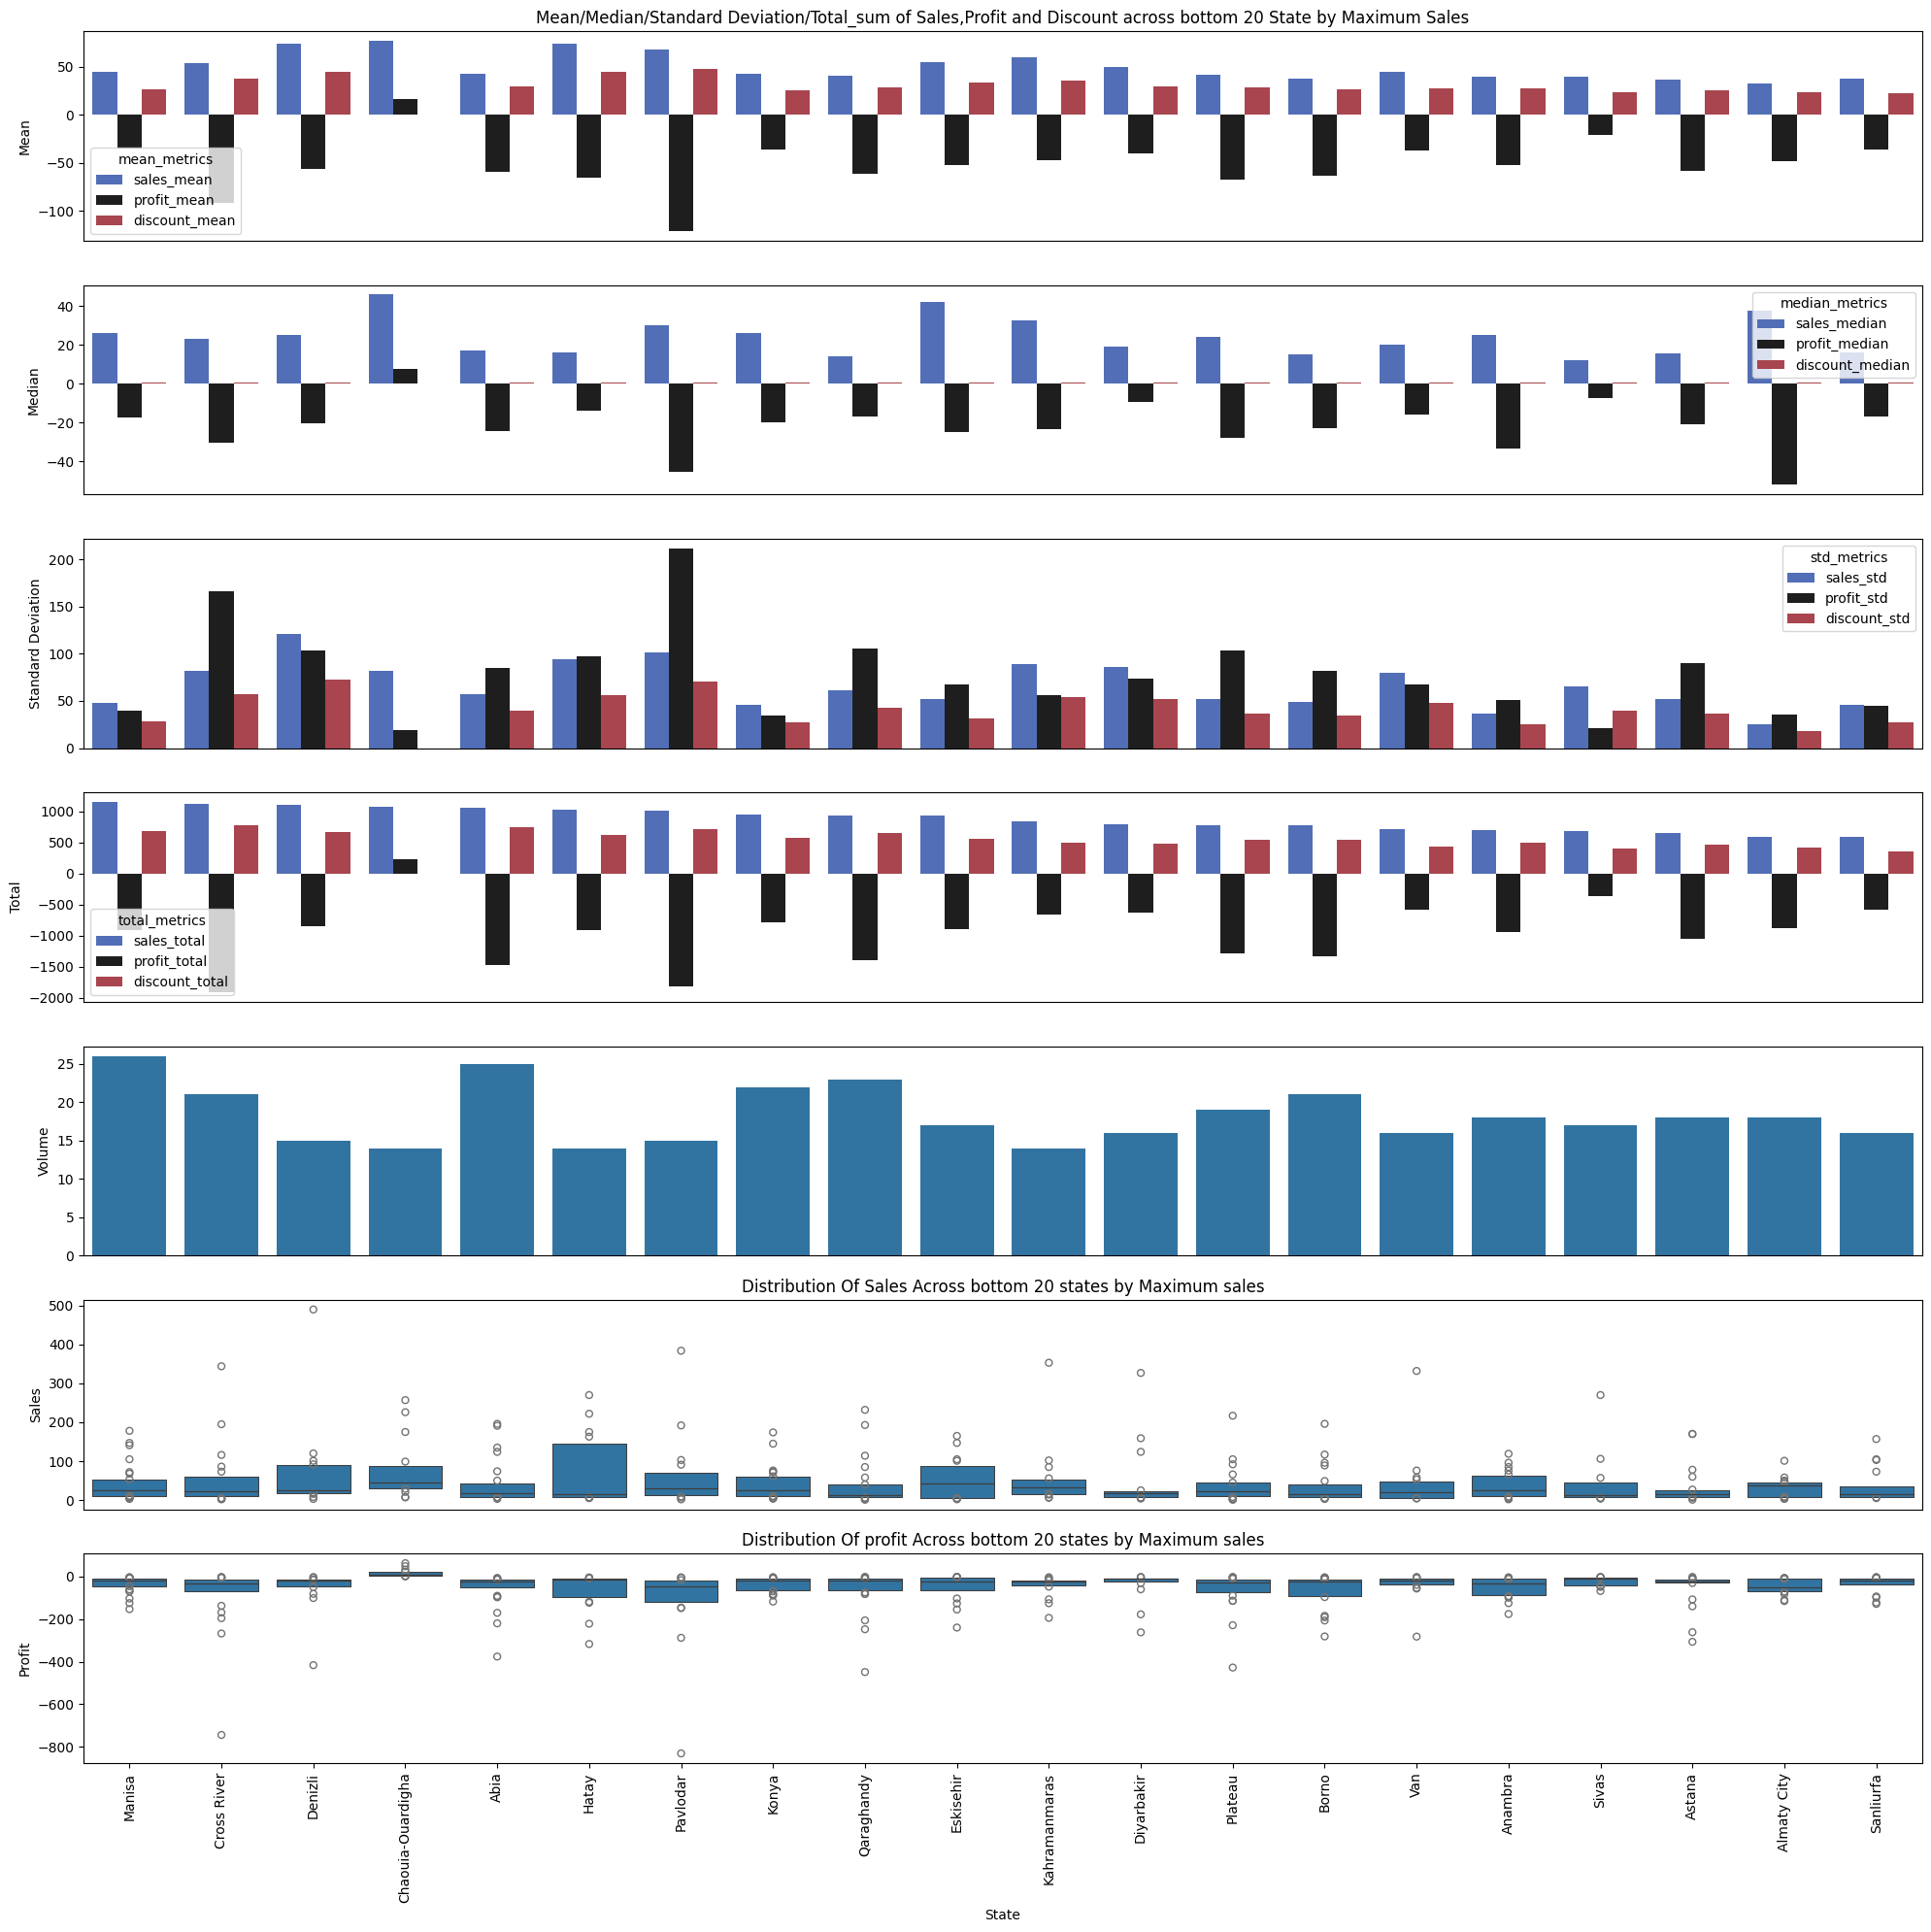

In [245]:
plt.figure(figsize=(20,20))
order=bottom20state['state'].to_list()

plt.subplot(7,1,1)
sns.barplot(data=bottom20state_melted,x='state',y='mean_values',hue='mean_metrics',order=order,palette='icefire')
plt.title('Mean/Median/Standard Deviation/Total_sum of Sales,Profit and Discount across bottom 20 State by Maximum Sales')
plt.xlabel('')
plt.ylabel('Mean')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,2)
sns.barplot(data=bottom20state_melted,x='state',y='median_values',hue='median_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Median')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,3)
sns.barplot(data=bottom20state_melted,x='state',y='std_values',hue='std_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Standard Deviation')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,4)
sns.barplot(data=bottom20state_melted,x='state',y='total_values',hue='total_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Total')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,5)
sns.barplot(data=bottom20state,x='state',y='order_count',order=order)
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks([])
plt.tight_layout()


plt.subplot(7,1,6)
sns.boxenplot(data=df[df['state'].isin(bottom20state['state'].to_list())],x='state',y='sales',order=order)
plt.title('Distribution Of Sales Across bottom 20 states by Maximum sales')
plt.xlabel('')
plt.ylabel('Sales')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,7)
sns.boxenplot(data=df[df['state'].isin(bottom20state['state'].to_list())],x='state',y='profit',order=order)
plt.title('Distribution Of profit Across bottom 20 states by Maximum sales')
plt.xlabel('State')
plt.ylabel('Profit')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

### Analysis

#### From the aspect od State:
- as discussed before in case of Top and Bottom of cities,countries and customers
    - unorganised discount is the profit killer
    - in whichever state the : 
        - high discount kills the profit wether the volume or sales is high
        - low discount with high volume and high sales make pretty good profit
        - low discount with low volume and high sales manages to make the profit
        - low discount with high volume and low sales does not make good profit but still does not incurr losses
        - low discount with low Volume  and  Low Sales  makes meaningless and negligible profit.

        
Discount Discipline is the prerequisite for profit. Volume only amplifies the result
        

## Sub-Category VS Profit/Sales/Discount

In [246]:
df['sub_category']

0          Paper
1          Paper
2          Paper
3          Paper
4          Paper
          ...   
51285    Binders
51286    Binders
51287    Binders
51288    Binders
51289    Binders
Name: sub_category, Length: 51290, dtype: object

In [247]:
subcategory_agg=df.groupby(['sub_category'],as_index=False).agg(
    sales_mean=('sales','mean'),
    profit_mean=('profit','mean'),
    discount_mean=('discount_amount','mean'),
    sales_median=('sales','median'),
    profit_median=('profit','median'),
    discount_median=('discount','median'),
    sales_std=('sales','std'),
    profit_std=('profit','std'),
    discount_std=('discount_amount','std'),
    sales_total=('sales','sum'),
    profit_total=('profit','sum'),
    discount_total=('discount_amount','sum'),
    order_count=('quantity','count')
    ).sort_values(by=['sales_total'],ascending=False
)
subcategory_agg

sub_category  sales_mean  profit_mean  discount_mean  sales_median  \
13       Phones  508.452189    64.556749      50.354701         273.0   
6       Copiers  679.009897   116.314687      52.792417         487.0   
5        Chairs  437.298195    40.884178      55.266709         258.0   
4     Bookcases  608.278308    67.160688      63.180680         411.0   
14      Storage  222.795809    21.439314      21.352819         114.0   
1    Appliances  576.114530    80.729681      52.094638         249.0   
11     Machines  524.273890    39.614989      70.077295         305.0   
16       Tables  879.249710   -74.429023     199.164832         629.0   
0   Accessories  243.677073    42.154896      18.178114         133.0   
3       Binders   75.089727    11.776633       9.699977          28.0   
9   Furnishings  121.643218    14.816223      12.101360          73.0   
2           Art   76.216056    11.868505       5.026064          50.0   
12        Paper   69.052289    16.734789       4.829421          44.0   
15     Supplies  100.243299     9.312686       8.188214          63.0   
7     Envelopes   70.195483    12.156516       5.932460          48.0   
8     Fasteners   34.402479     4.762572       3.042368          26.0   
10       Labels   28.178434     5.759982       2.137456          21.0   

    profit_median  discount_median   sales_std  profit_std  discount_std  \
13        30.7200            0.000  717.311211  251.666470    116.685194   
6         65.9100            0.002  821.105206  365.093054    128.161217   
5         20.1780            0.100  535.108817  180.977823    100.443084   
4         44.9700            0.100  602.492771  242.859457    110.406361   
14         8.3700            0.000  292.083775   93.922868     45.651528   
1         33.3648            0.000  797.057938  302.596743    129.738941   
11        28.3800            0.000  927.997133  347.491558    352.758297   
16       -34.6470            0.300  796.399276  402.973963    229.675837   
0         18.4200            0.000  327.234195  126.787072     47.718725   
3          4.6811            0.000  288.545362  153.960611     62.852413   
9          9.4500            0.000  145.608051   56.166072     25.251558   
2          7.0520            0.000   82.014081   32.199936     12.872572   
12         9.6300            0.000   74.459165   32.307508     10.466497   
15         8.2800            0.000  271.254840   44.851356     29.689036   
7          7.4872            0.000   69.694017   31.608325     12.855057   
8          3.7050            0.000   28.858939   14.180009      5.888279   
10         3.9600            0.000   34.153161   16.190922      4.962562   

    sales_total  profit_total  discount_total  order_count  
13      1706874  216717.00580      169040.730         3357  
6       1509439  258567.54818      117357.544         2223  
5       1501682  140396.26750      189785.880         3434  
4       1466559  161924.41950      152328.620         2411  
14      1127124  108461.48980      108023.910         5059  
1       1011081  141680.58940       91426.090         1755  
11       779071   58867.87300      104134.860         1486  
16       757034  -64083.38870      171480.920          861  
0        749307  129626.30620       55897.700         3075  
3        461952   72449.84600       59674.260         6152  
9        385609   46967.42550       38361.310         3170  
2        372163   57953.91090       24542.270         4883  
12       244307   59207.68270       17086.490         3538  
15       243090   22583.26310       19856.420         2425  
7        170926   29601.11630       14445.540         2435  
8         83254   11525.42410        7362.530         2420  
10        73433   15010.51200        5570.210         2606

In [248]:
subcategory_melted=merge_melted(df=subcategory_agg,common_cols=['sub_category'],no_of_melts=4,list_tuples_variables=[('sales_mean','profit_mean','discount_mean','mean_metrics','mean_values'),
                                                                                       ('sales_median','profit_median','discount_median','median_metrics','median_values'),
                                                                                       ('sales_std','profit_std','discount_std','std_metrics','std_values'),
                                                                                       ('sales_total','profit_total','discount_total','total_metrics','total_values')])
subcategory_melted

sub_category   mean_metrics  mean_values      type   median_metrics  \
0        Phones     sales_mean   508.452189     sales     sales_median   
1       Copiers     sales_mean   679.009897     sales     sales_median   
2        Chairs     sales_mean   437.298195     sales     sales_median   
3     Bookcases     sales_mean   608.278308     sales     sales_median   
4       Storage     sales_mean   222.795809     sales     sales_median   
5    Appliances     sales_mean   576.114530     sales     sales_median   
6      Machines     sales_mean   524.273890     sales     sales_median   
7        Tables     sales_mean   879.249710     sales     sales_median   
8   Accessories     sales_mean   243.677073     sales     sales_median   
9       Binders     sales_mean    75.089727     sales     sales_median   
10  Furnishings     sales_mean   121.643218     sales     sales_median   
11          Art     sales_mean    76.216056     sales     sales_median   
12        Paper     sales_mean    69.052289     sales     sales_median   
13     Supplies     sales_mean   100.243299     sales     sales_median   
14    Envelopes     sales_mean    70.195483     sales     sales_median   
15    Fasteners     sales_mean    34.402479     sales     sales_median   
16       Labels     sales_mean    28.178434     sales     sales_median   
17       Phones    profit_mean    64.556749    profit    profit_median   
18      Copiers    profit_mean   116.314687    profit    profit_median   
19       Chairs    profit_mean    40.884178    profit    profit_median   
20    Bookcases    profit_mean    67.160688    profit    profit_median   
21      Storage    profit_mean    21.439314    profit    profit_median   
22   Appliances    profit_mean    80.729681    profit    profit_median   
23     Machines    profit_mean    39.614989    profit    profit_median   
24       Tables    profit_mean   -74.429023    profit    profit_median   
25  Accessories    profit_mean    42.154896    profit    profit_median   
26      Binders    profit_mean    11.776633    profit    profit_median   
27  Furnishings    profit_mean    14.816223    profit    profit_median   
28          Art    profit_mean    11.868505    profit    profit_median   
29        Paper    profit_mean    16.734789    profit    profit_median   
30     Supplies    profit_mean     9.312686    profit    profit_median   
31    Envelopes    profit_mean    12.156516    profit    profit_median   
32    Fasteners    profit_mean     4.762572    profit    profit_median   
33       Labels    profit_mean     5.759982    profit    profit_median   
34       Phones  discount_mean    50.354701  discount  discount_median   
35      Copiers  discount_mean    52.792417  discount  discount_median   
36       Chairs  discount_mean    55.266709  discount  discount_median   
37    Bookcases  discount_mean    63.180680  discount  discount_median   
38      Storage  discount_mean    21.352819  discount  discount_median   
39   Appliances  discount_mean    52.094638  discount  discount_median   
40     Machines  discount_mean    70.077295  discount  discount_median   
41       Tables  discount_mean   199.164832  discount  discount_median   
42  Accessories  discount_mean    18.178114  discount  discount_median   
43      Binders  discount_mean     9.699977  discount  discount_median   
44  Furnishings  discount_mean    12.101360  discount  discount_median   
45          Art  discount_mean     5.026064  discount  discount_median   
46        Paper  discount_mean     4.829421  discount  discount_median   
47     Supplies  discount_mean     8.188214  discount  discount_median   
48    Envelopes  discount_mean     5.932460  discount  discount_median   
49    Fasteners  discount_mean     3.042368  discount  discount_median   
50       Labels  discount_mean     2.137456  discount  discount_median   

    median_values   std_metrics  std_values   total_metrics  total_values  
0        273.0000     sales_std  717.311211     sales_total  1.706874e+06  
1 

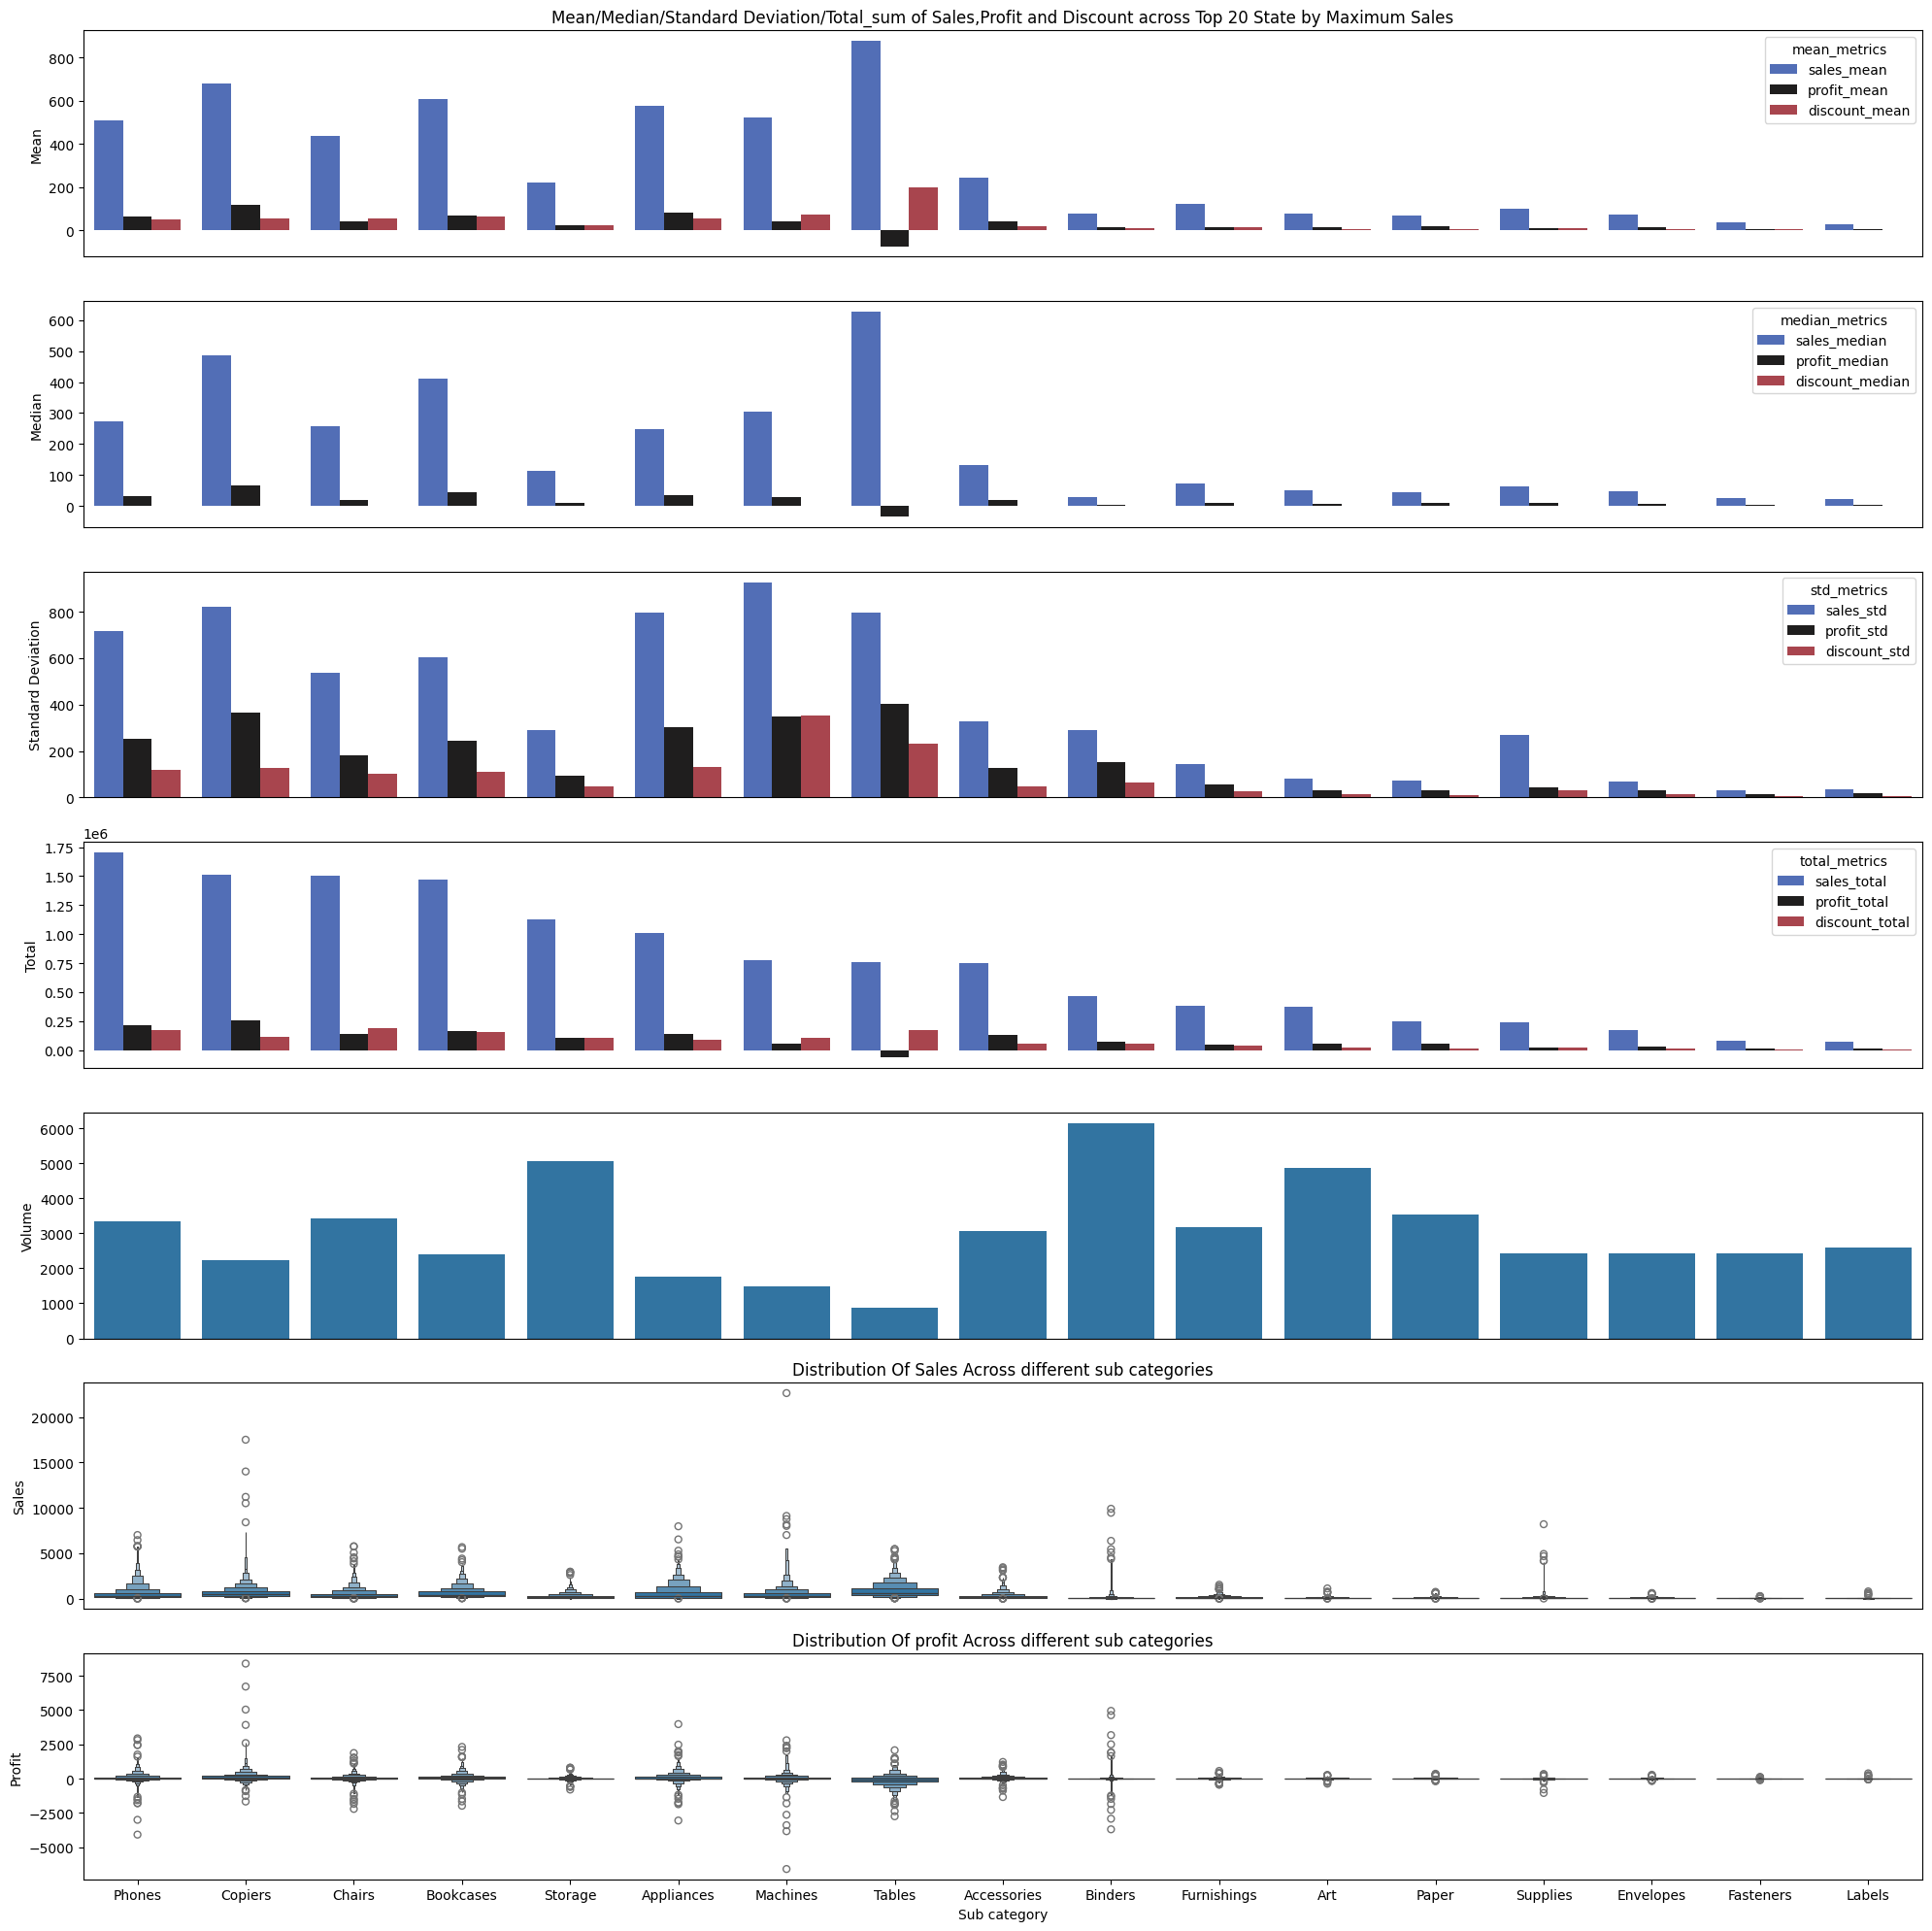

In [249]:
plt.figure(figsize=(20,20))
order=subcategory_agg['sub_category'].to_list()

plt.subplot(7,1,1)
sns.barplot(data=subcategory_melted,x='sub_category',y='mean_values',hue='mean_metrics',order=order,palette='icefire')
plt.title('Mean/Median/Standard Deviation/Total_sum of Sales,Profit and Discount across Top 20 State by Maximum Sales')
plt.xlabel('')
plt.ylabel('Mean')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,2)
sns.barplot(data=subcategory_melted,x='sub_category',y='median_values',hue='median_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Median')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,3)
sns.barplot(data=subcategory_melted,x='sub_category',y='std_values',hue='std_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Standard Deviation')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,4)
sns.barplot(data=subcategory_melted,x='sub_category',y='total_values',hue='total_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Total')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,5)
sns.barplot(data=subcategory_agg,x='sub_category',y='order_count',order=order)
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks([])
plt.tight_layout()


plt.subplot(7,1,6)
sns.boxenplot(data=df,x='sub_category',y='sales',order=order)
plt.title('Distribution Of Sales Across different sub categories')
plt.xlabel('')
plt.ylabel('Sales')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,7)
sns.boxenplot(data=df,x='sub_category',y='profit',order=order)
plt.title('Distribution Of profit Across different sub categories')
plt.xlabel('Sub category')
plt.ylabel('Profit')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

### Analysis

#### From the aspect od Sub-Categories:
- as discussed before in case of Top and Bottom of cities,countries,customers and state.
    - unorganised discount is the profit killer
    - in whichever Sub-Category the : 
        - high discount kills the profit wether the volume or sales is high
        - low discount with high volume and high sales make pretty good profit
        - low discount with low volume and high sales manages to make the profit
        - low discount with high volume and low sales does not make good profit but still does not incurr losses
        - low discount with low Volume  and  Low Sales  makes meaningless and negligible profit.

        
Discount Discipline is the prerequisite for profit. Volume only amplifies the result
        

## Year VS Profit/Sales/Discount

In [250]:
df['year']

0        2011
1        2011
2        2011
3        2011
4        2011
         ... 
51285    2014
51286    2014
51287    2014
51288    2014
51289    2014
Name: year, Length: 51290, dtype: int64

In [251]:
year_agg=df.groupby(['year'],as_index=False).agg(
    sales_mean=('sales','mean'),
    profit_mean=('profit','mean'),
    discount_mean=('discount_amount','mean'),
    sales_median=('sales','median'),
    profit_median=('profit','median'),
    discount_median=('discount','median'),
    sales_std=('sales','std'),
    profit_std=('profit','std'),
    discount_std=('discount_amount','std'),
    sales_total=('sales','sum'),
    profit_total=('profit','sum'),
    discount_total=('discount_amount','sum'),
    order_count=('quantity','count')
    ).sort_values(by=['year'],ascending=True
)
year_agg

year  sales_mean  profit_mean  discount_mean  sales_median  profit_median  \
0  2011  251.112581    27.666238      28.920377          84.0         9.0300   
1  2012  244.252235    28.043722      25.307856          87.0         9.5116   
2  2013  246.819335    29.490197      25.817107          85.0         9.2400   
3  2014  245.282129    28.758540      25.809980          84.0         9.2000   

   discount_median   sales_std  profit_std  discount_std  sales_total  \
0              0.0  536.895054  170.297204    147.878306      2259511   
1              0.0  450.303344  155.634683     78.859867      2677493   
2              0.0  494.722221  190.361319     88.751962      3405860   
3              0.0  477.630653  174.283412     86.279245      4300041   

   profit_total  discount_total  order_count  
0  248940.81154      260225.550         8998  
1  307415.27910      277424.722        10962  
2  406935.23018      356250.258        13799  
3  504165.97046      452474.754        17531

In [252]:
year_melted=merge_melted(df=year_agg,common_cols=['year'],no_of_melts=4,list_tuples_variables=[('sales_mean','profit_mean','discount_mean','mean_metrics','mean_values'),
                                                                                       ('sales_median','profit_median','discount_median','median_metrics','median_values'),
                                                                                       ('sales_std','profit_std','discount_std','std_metrics','std_values'),
                                                                                       ('sales_total','profit_total','discount_total','total_metrics','total_values')])
year_melted

year   mean_metrics  mean_values      type   median_metrics  \
0   2011     sales_mean   251.112581     sales     sales_median   
1   2012     sales_mean   244.252235     sales     sales_median   
2   2013     sales_mean   246.819335     sales     sales_median   
3   2014     sales_mean   245.282129     sales     sales_median   
4   2011    profit_mean    27.666238    profit    profit_median   
5   2012    profit_mean    28.043722    profit    profit_median   
6   2013    profit_mean    29.490197    profit    profit_median   
7   2014    profit_mean    28.758540    profit    profit_median   
8   2011  discount_mean    28.920377  discount  discount_median   
9   2012  discount_mean    25.307856  discount  discount_median   
10  2013  discount_mean    25.817107  discount  discount_median   
11  2014  discount_mean    25.809980  discount  discount_median   

    median_values   std_metrics  std_values   total_metrics  total_values  
0         84.0000     sales_std  536.895054     sales_total  2.259511e+06  
1         87.0000     sales_std  450.303344     sales_total  2.677493e+06  
2         85.0000     sales_std  494.722221     sales_total  3.405860e+06  
3         84.0000     sales_std  477.630653     sales_total  4.300041e+06  
4          9.0300    profit_std  170.297204    profit_total  2.489408e+05  
5          9.5116    profit_std  155.634683    profit_total  3.074153e+05  
6          9.2400    profit_std  190.361319    profit_total  4.069352e+05  
7          9.2000    profit_std  174.283412    profit_total  5.041660e+05  
8          0.0000  discount_std  147.878306  discount_total  2.602256e+05  
9          0.0000  discount_std   78.859867  discount_total  2.774247e+05  
10         0.0000  discount_std   88.751962  discount_total  3.562503e+05  
11         0.0000  discount_std   86.279245  discount_total  4.524748e+05

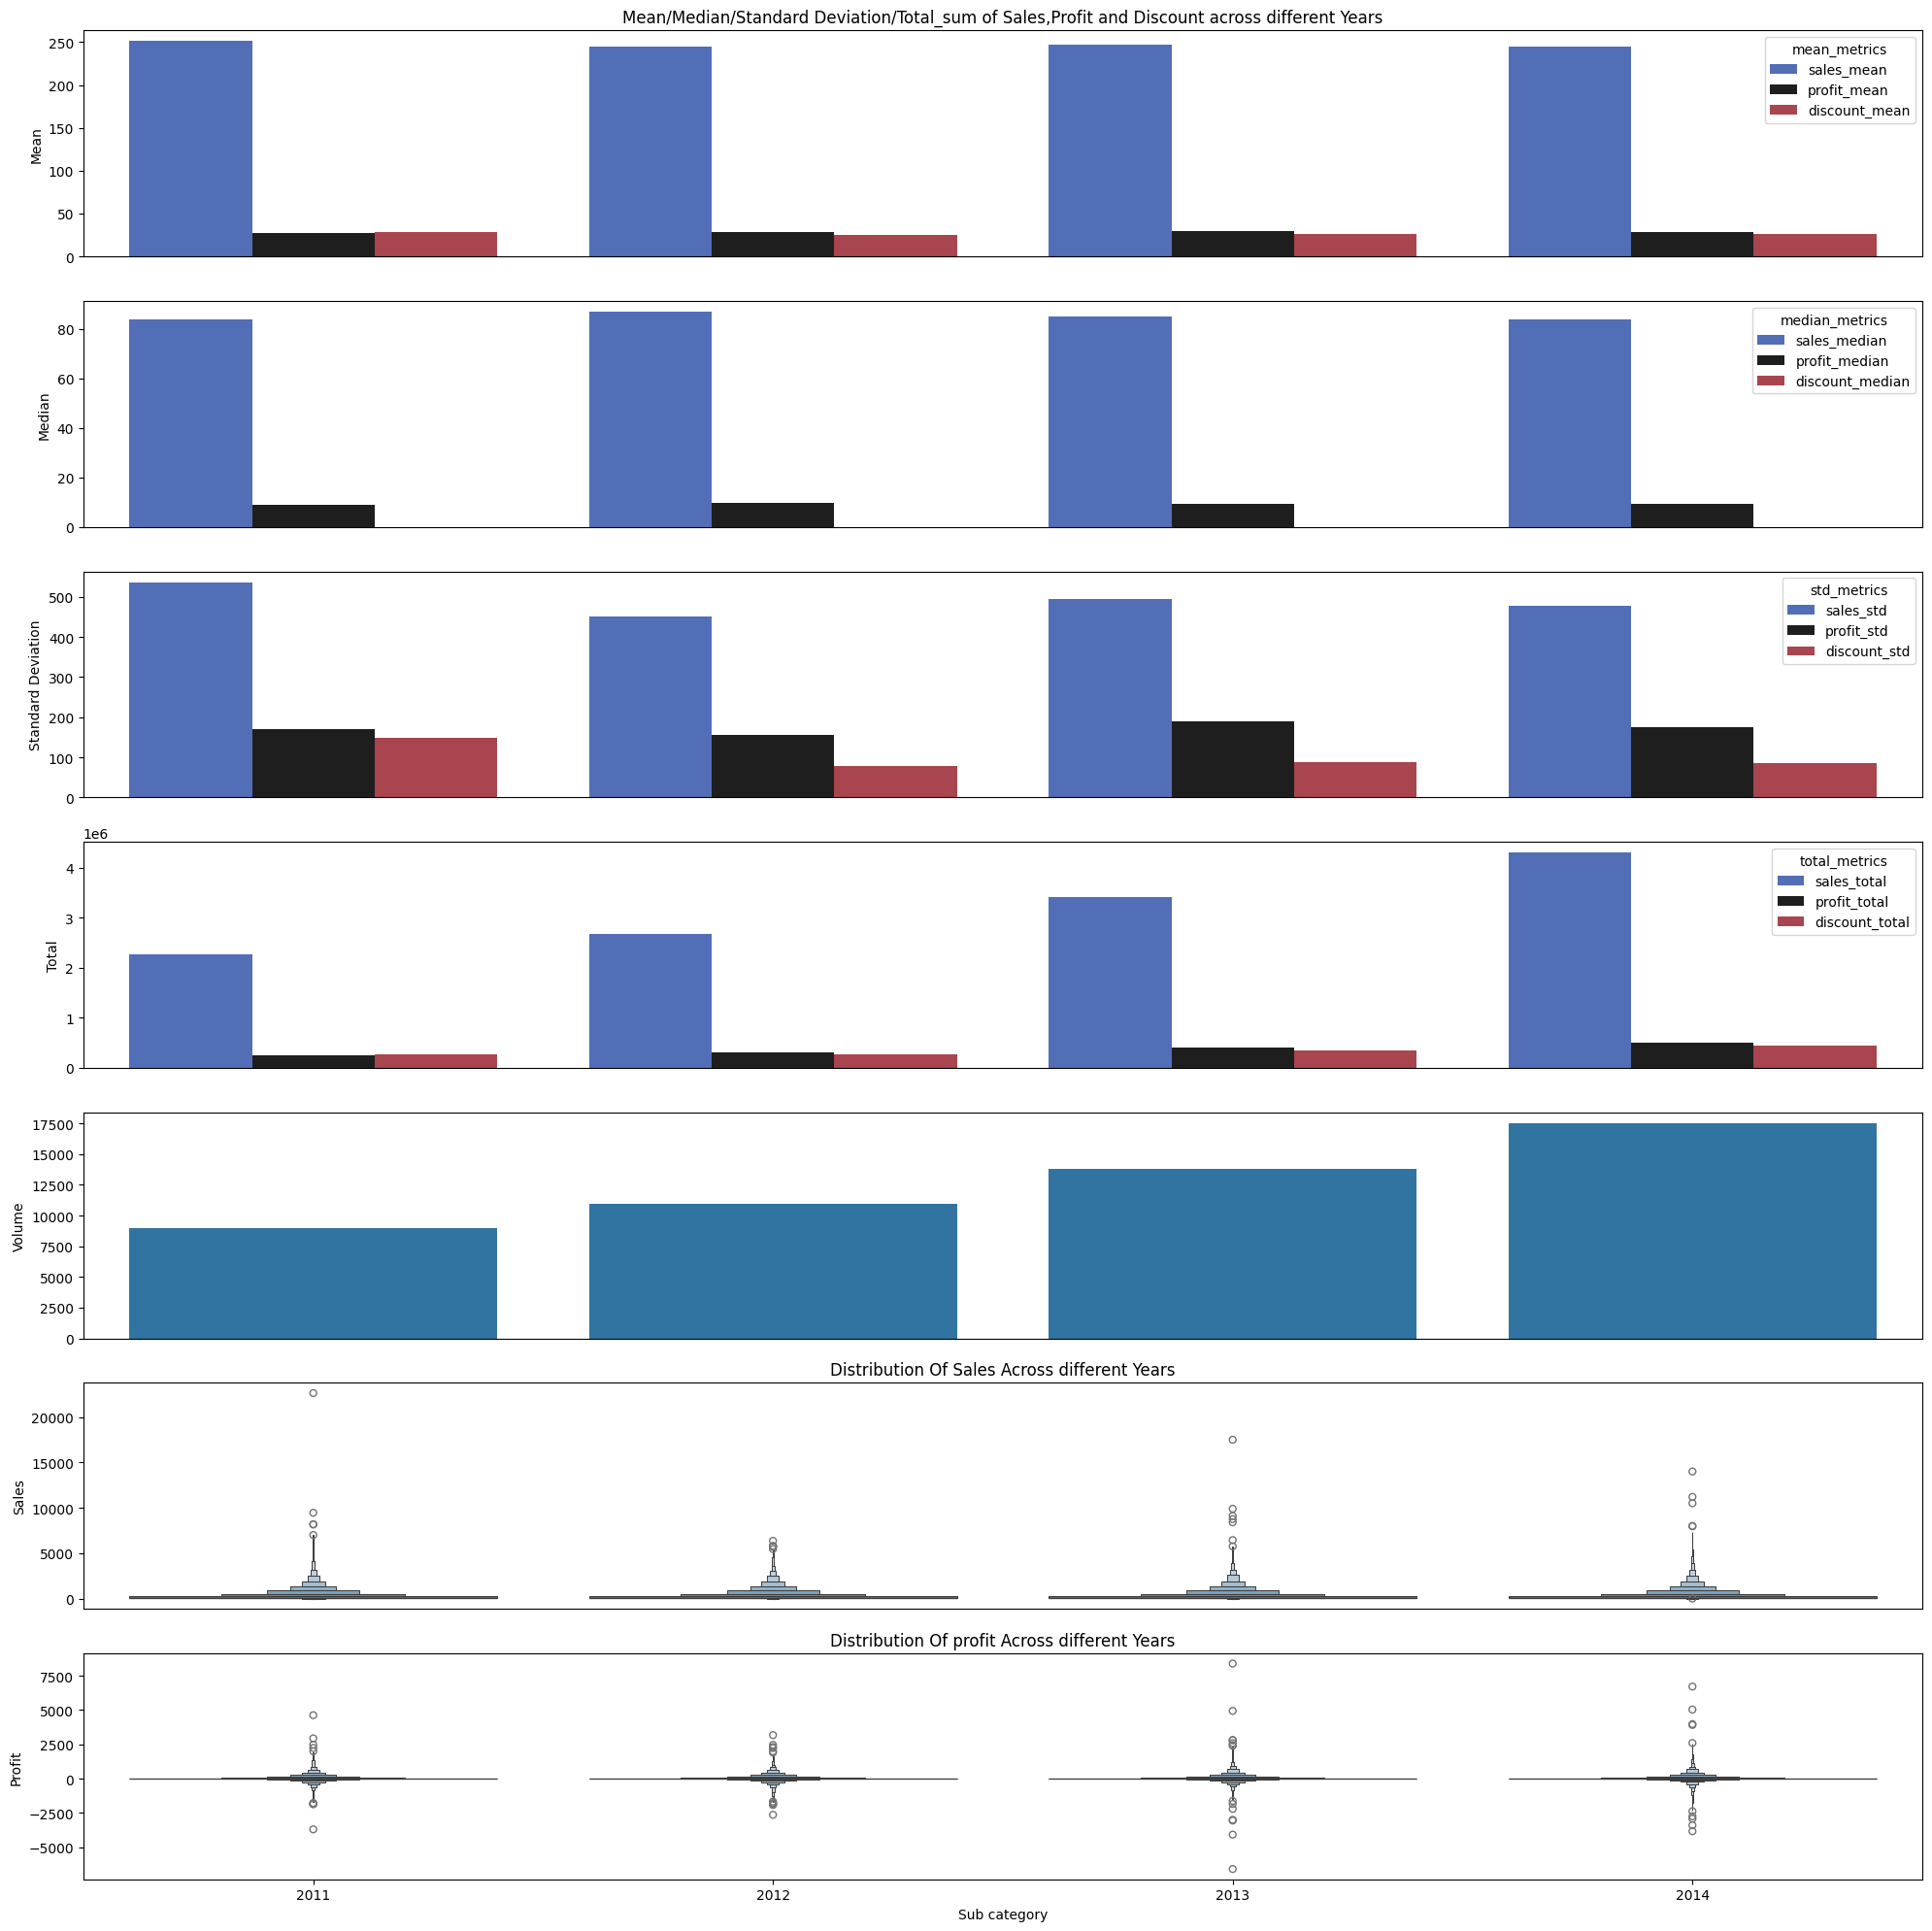

In [253]:
plt.figure(figsize=(20,20))
order=year_agg['year'].to_list()

plt.subplot(7,1,1)
sns.barplot(data=year_melted,x='year',y='mean_values',hue='mean_metrics',order=order,palette='icefire')
plt.title('Mean/Median/Standard Deviation/Total_sum of Sales,Profit and Discount across different Years')
plt.xlabel('')
plt.ylabel('Mean')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,2)
sns.barplot(data=year_melted,x='year',y='median_values',hue='median_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Median')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,3)
sns.barplot(data=year_melted,x='year',y='std_values',hue='std_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Standard Deviation')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,4)
sns.barplot(data=year_melted,x='year',y='total_values',hue='total_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Total')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,5)
sns.barplot(data=year_agg,x='year',y='order_count',order=order)
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks([])
plt.tight_layout()


plt.subplot(7,1,6)
sns.boxenplot(data=df,x='year',y='sales',order=order)
plt.title('Distribution Of Sales Across different Years')
plt.xlabel('')
plt.ylabel('Sales')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,7)
sns.boxenplot(data=df,x='year',y='profit',order=order)
plt.title('Distribution Of profit Across different Years')
plt.xlabel('Sub category')
plt.ylabel('Profit')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

### Analysis

- as moving from 2011 to 2014 we can see that volume is increased but
    - mean , median  and  std_devn is stagnant
    - very very less increment in yearly profit

## Market VS Profit/Sales/Discount

In [254]:
df['market2']

0        North America
1        North America
2        North America
3        North America
4        North America
             ...      
51285    North America
51286    North America
51287    North America
51288    North America
51289    North America
Name: market2, Length: 51290, dtype: object

In [255]:
market_agg=df.groupby(['market2'],as_index=False).agg(
    sales_mean=('sales','mean'),
    profit_mean=('profit','mean'),
    discount_mean=('discount_amount','mean'),
    sales_median=('sales','median'),
    profit_median=('profit','median'),
    discount_median=('discount','median'),
    sales_std=('sales','std'),
    profit_std=('profit','std'),
    discount_std=('discount_amount','std'),
    sales_total=('sales','sum'),
    profit_total=('profit','sum'),
    discount_total=('discount_amount','sum'),
    order_count=('quantity','count')
    ).sort_values(by=['sales_total'],ascending=False
)
market_agg

market2  sales_mean  profit_mean  discount_mean  sales_median  \
0           APAC  325.925559    39.629163      35.508478         123.0   
3             EU  293.813900    37.282974      28.855640         119.0   
5  North America  227.817113    29.313395      31.084117          55.0   
4          LATAM  210.286283    21.531328      21.739153          80.0   
2           EMEA  160.307019     8.728966      15.489481          52.0   
1         Africa  170.868978    19.374674       9.349073          52.0   

   profit_median  discount_median   sales_std  profit_std  discount_std  \
0       10.88625              0.1  551.634450  170.519576     91.008913   
3       14.22000              0.0  486.055591  178.100384     85.607362   
5        8.77225              0.1  615.031823  230.976459    161.076217   
4        8.00000              0.0  349.073674  118.795371     60.192659   
2        5.04000              0.0  327.187928  154.196926     65.375771   
1        7.56000              0.0  359.407808  146.530457     42.800315   

   sales_total  profit_total  discount_total  order_count  
0      3585833  436000.04900      390664.270        11002  
3      2938139  372829.74150      288556.400        10000  
5      2364286  304214.41170      322590.970        10378  
4      2164687  221643.48708      223782.844        10294  
2       806184   43897.97100       77896.600         5029  
1       783776   88871.63100       42884.200         4587

In [256]:
market_melted=merge_melted(df=market_agg,common_cols=['market2'],no_of_melts=4,list_tuples_variables=[('sales_mean','profit_mean','discount_mean','mean_metrics','mean_values'),
                                                                                       ('sales_median','profit_median','discount_median','median_metrics','median_values'),
                                                                                       ('sales_std','profit_std','discount_std','std_metrics','std_values'),
                                                                                       ('sales_total','profit_total','discount_total','total_metrics','total_values')])
market_melted

market2   mean_metrics  mean_values      type   median_metrics  \
0            APAC     sales_mean   325.925559     sales     sales_median   
1              EU     sales_mean   293.813900     sales     sales_median   
2   North America     sales_mean   227.817113     sales     sales_median   
3           LATAM     sales_mean   210.286283     sales     sales_median   
4            EMEA     sales_mean   160.307019     sales     sales_median   
5          Africa     sales_mean   170.868978     sales     sales_median   
6            APAC    profit_mean    39.629163    profit    profit_median   
7              EU    profit_mean    37.282974    profit    profit_median   
8   North America    profit_mean    29.313395    profit    profit_median   
9           LATAM    profit_mean    21.531328    profit    profit_median   
10           EMEA    profit_mean     8.728966    profit    profit_median   
11         Africa    profit_mean    19.374674    profit    profit_median   
12           APAC  discount_mean    35.508478  discount  discount_median   
13             EU  discount_mean    28.855640  discount  discount_median   
14  North America  discount_mean    31.084117  discount  discount_median   
15          LATAM  discount_mean    21.739153  discount  discount_median   
16           EMEA  discount_mean    15.489481  discount  discount_median   
17         Africa  discount_mean     9.349073  discount  discount_median   

    median_values   std_metrics  std_values   total_metrics  total_values  
0       123.00000     sales_std  551.634450     sales_total  3.585833e+06  
1       119.00000     sales_std  486.055591     sales_total  2.938139e+06  
2        55.00000     sales_std  615.031823     sales_total  2.364286e+06  
3        80.00000     sales_std  349.073674     sales_total  2.164687e+06  
4        52.00000     sales_std  327.187928     sales_total  8.061840e+05  
5        52.00000     sales_std  359.407808     sales_total  7.837760e+05  
6        10.88625    profit_std  170.519576    profit_total  4.360000e+05  
7        14.22000    profit_std  178.100384    profit_total  3.728297e+05  
8         8.77225    profit_std  230.976459    profit_total  3.042144e+05  
9         8.00000    profit_std  118.795371    profit_total  2.216435e+05  
10        5.04000    profit_std  154.196926    profit_total  4.389797e+04  
11        7.56000    profit_std  146.530457    profit_total  8.887163e+04  
12        0.10000  discount_std   91.008913  discount_total  3.906643e+05  
13        0.00000  discount_std   85.607362  discount_total  2.885564e+05  
14        0.10000  discount_std  161.076217  discount_total  3.225910e+05  
15        0.00000  discount_std   60.192659  discount_total  2.237828e+05  
16        0.00000  discount_std   65.375771  discount_total  7.789660e+04  
17        0.00000  discount_std   42.800315  discount_total  4.288420e+04

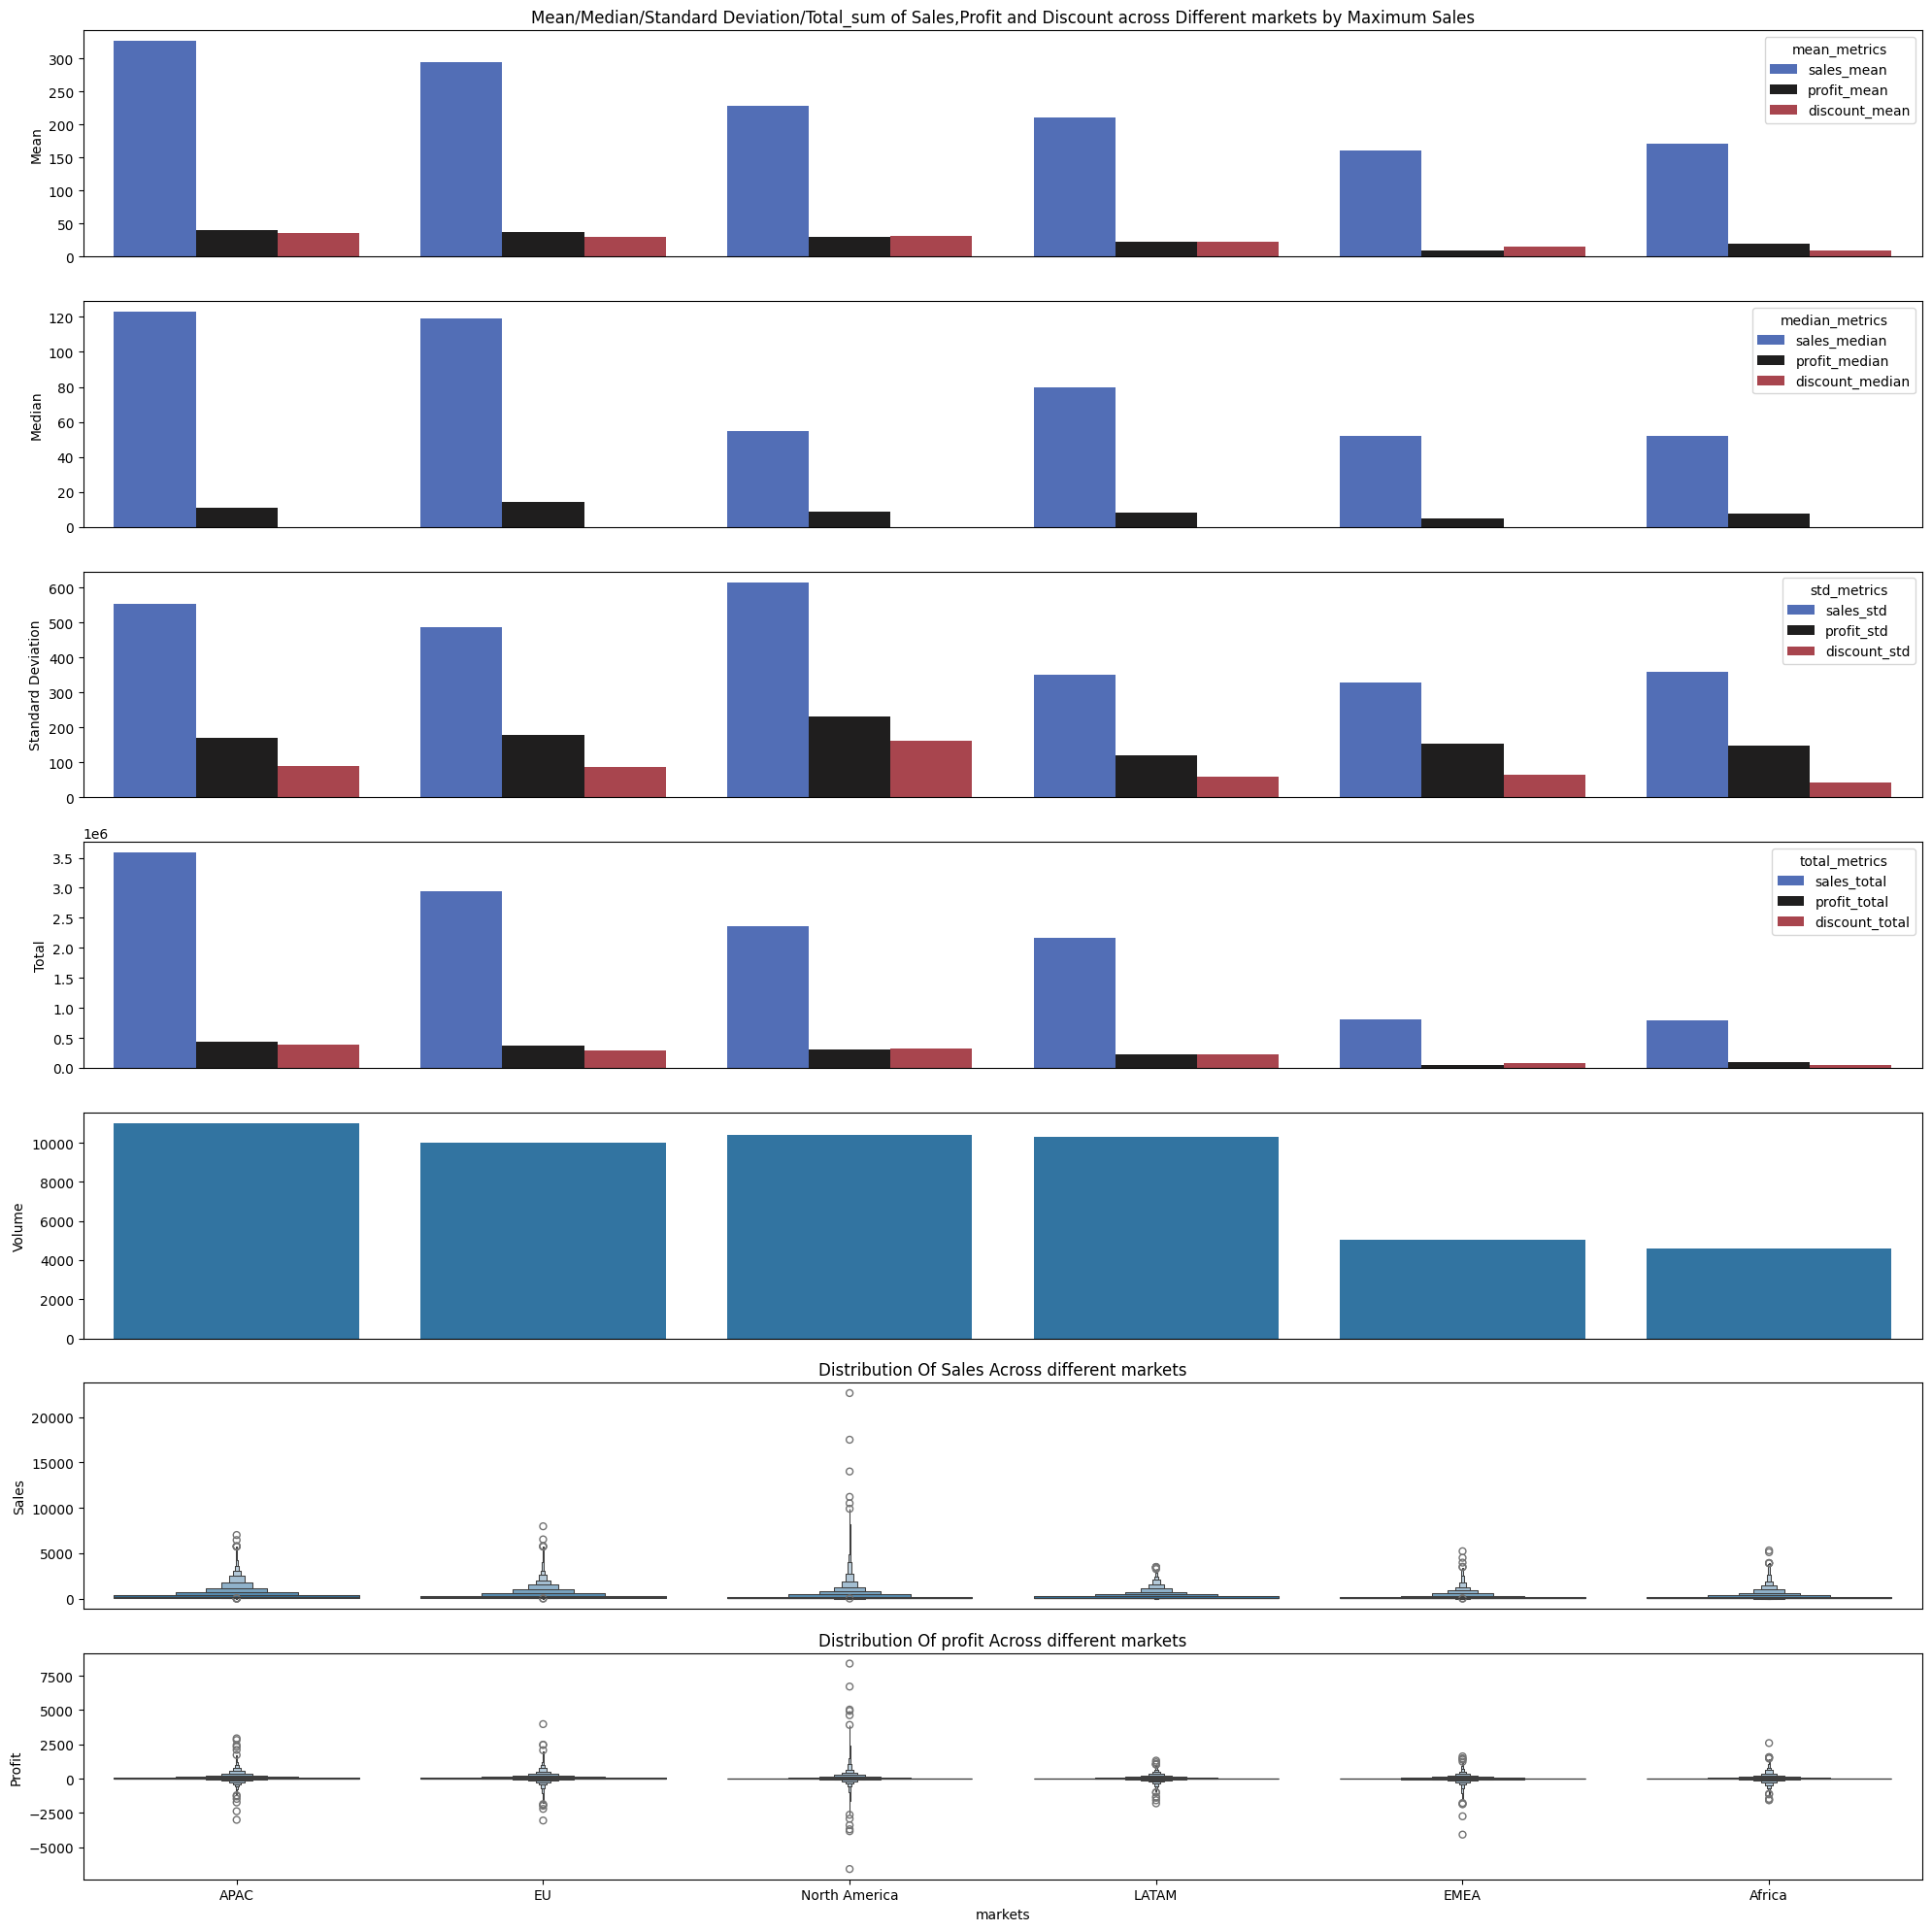

In [257]:
plt.figure(figsize=(20,20))
order=market_agg['market2'].to_list()

plt.subplot(7,1,1)
sns.barplot(data=market_melted,x='market2',y='mean_values',hue='mean_metrics',order=order,palette='icefire')
plt.title('Mean/Median/Standard Deviation/Total_sum of Sales,Profit and Discount across Different markets by Maximum Sales')
plt.xlabel('')
plt.ylabel('Mean')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,2)
sns.barplot(data=market_melted,x='market2',y='median_values',hue='median_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Median')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,3)
sns.barplot(data=market_melted,x='market2',y='std_values',hue='std_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Standard Deviation')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,4)
sns.barplot(data=market_melted,x='market2',y='total_values',hue='total_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Total')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,5)
sns.barplot(data=market_agg,x='market2',y='order_count',order=order)
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks([])
plt.tight_layout()


plt.subplot(7,1,6)
sns.boxenplot(data=df,x='market2',y='sales',order=order)
plt.title('Distribution Of Sales Across different markets')
plt.xlabel('')
plt.ylabel('Sales')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,7)
sns.boxenplot(data=df,x='market2',y='profit',order=order)
plt.title('Distribution Of profit Across different markets')
plt.xlabel('markets')
plt.ylabel('Profit')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

### Analysis

#### From the aspect of State:
- as discussed before in case of Top and Bottom of cities,countries ,customers,state and sub_category
    - unorganised discount is the profit killer
    - in whichever state the : 
        - high discount kills the profit wether the volume or sales is high
        - low discount with high volume and high sales make pretty good profit
        - low discount with low volume and high sales manages to make the profit
        - low discount with high volume and low sales does not make good profit but still does not incurr losses
        - low discount with low Volume  and  Low Sales  makes meaningless and negligible profit.

        
Discount Discipline is the prerequisite for profit. Volume only amplifies the result
        

## Monthly Profit and Sales

In [258]:
df['month']

0         1
1         1
2         8
3         8
4        10
         ..
51285    12
51286    12
51287    12
51288    12
51289    12
Name: month, Length: 51290, dtype: int32

In [259]:
month_agg=df.groupby(['month'],as_index=False).agg(
    sales_mean=('sales','mean'),
    profit_mean=('profit','mean'),
    discount_mean=('discount_amount','mean'),
    sales_median=('sales','median'),
    profit_median=('profit','median'),
    discount_median=('discount','median'),
    sales_std=('sales','std'),
    profit_std=('profit','std'),
    discount_std=('discount_amount','std'),
    sales_total=('sales','sum'),
    profit_total=('profit','sum'),
    discount_total=('discount_amount','sum'),
    order_count=('quantity','count')
    ).sort_values(by=['month'],ascending=True
)
month_agg

month  sales_mean  profit_mean  discount_mean  sales_median  \
0       1  257.018627    28.190368      27.065963          88.0   
1       2  248.511829    31.640990      24.238257          88.0   
2       3  253.138011    29.972253      30.276071          84.0   
3       4  227.623953    24.132333      24.323622          81.0   
4       5  238.849846    27.661404      25.392337          84.0   
5       6  242.000188    28.254857      26.250667          84.0   
6       7  238.460738    28.106097      25.627992          86.0   
7       8  253.201306    28.432315      25.978937          91.0   
8       9  244.815726    30.620220      25.396744          80.0   
9      10  254.816821    31.717669      26.176766          87.0   
10     11  247.159167    27.821883      26.695294          85.0   
11     12  250.093612    27.163840      27.149624          88.0   

    profit_median  discount_median   sales_std  profit_std  discount_std  \
0          8.8632              0.0  516.932191  181.348645     90.550046   
1          9.5550              0.0  472.197950  178.577900     72.800323   
2          9.0720              0.0  665.705311  204.991079    220.349730   
3          8.1000              0.0  438.120384  153.696325     74.224687   
4          9.3600              0.0  444.714965  149.556569     90.518356   
5          9.0300              0.0  446.409565  160.682416     82.843911   
6          9.0450              0.0  427.541570  144.647487     76.084716   
7         10.3936              0.0  478.647958  152.460104     88.001503   
8          9.0900              0.0  523.634981  206.703985     93.975970   
9          9.3336              0.0  485.246095  162.765187     80.833213   
10         9.3162              0.0  478.416342  191.738871     98.137943   
11         9.3312              0.0  469.612869  173.707182     81.200336   

    sales_total  profit_total  discount_total  order_count  
0        703717   77185.22792       74106.606         2738  
1        546229   69546.89692       53275.688         2198  
2        761186   90126.56420       91040.144         3007  
3        733632   77778.50904       78395.034         3223  
4        855799   99110.81102       90980.744         3583  
5       1285747  150118.05500      139469.792         5313  
6        801705   94492.69962       86161.310         3362  
7       1202453  135025.06332      123373.970         4749  
8       1522509  190427.14988      157942.352         6219  
9       1157378  144061.65200      118894.870         4542  
10      1482955  166931.29538      160171.764         6000  
11      1589595  172653.36698      172563.010         6356

In [260]:
month_melted=merge_melted(df=month_agg,common_cols=['month'],no_of_melts=4,list_tuples_variables=[('sales_mean','profit_mean','discount_mean','mean_metrics','mean_values'),
                                                                                       ('sales_median','profit_median','discount_median','median_metrics','median_values'),
                                                                                       ('sales_std','profit_std','discount_std','std_metrics','std_values'),
                                                                                       ('sales_total','profit_total','discount_total','total_metrics','total_values')])
month_melted

month   mean_metrics  mean_values      type   median_metrics  \
0       1     sales_mean   257.018627     sales     sales_median   
1       2     sales_mean   248.511829     sales     sales_median   
2       3     sales_mean   253.138011     sales     sales_median   
3       4     sales_mean   227.623953     sales     sales_median   
4       5     sales_mean   238.849846     sales     sales_median   
5       6     sales_mean   242.000188     sales     sales_median   
6       7     sales_mean   238.460738     sales     sales_median   
7       8     sales_mean   253.201306     sales     sales_median   
8       9     sales_mean   244.815726     sales     sales_median   
9      10     sales_mean   254.816821     sales     sales_median   
10     11     sales_mean   247.159167     sales     sales_median   
11     12     sales_mean   250.093612     sales     sales_median   
12      1    profit_mean    28.190368    profit    profit_median   
13      2    profit_mean    31.640990    profit    profit_median   
14      3    profit_mean    29.972253    profit    profit_median   
15      4    profit_mean    24.132333    profit    profit_median   
16      5    profit_mean    27.661404    profit    profit_median   
17      6    profit_mean    28.254857    profit    profit_median   
18      7    profit_mean    28.106097    profit    profit_median   
19      8    profit_mean    28.432315    profit    profit_median   
20      9    profit_mean    30.620220    profit    profit_median   
21     10    profit_mean    31.717669    profit    profit_median   
22     11    profit_mean    27.821883    profit    profit_median   
23     12    profit_mean    27.163840    profit    profit_median   
24      1  discount_mean    27.065963  discount  discount_median   
25      2  discount_mean    24.238257  discount  discount_median   
26      3  discount_mean    30.276071  discount  discount_median   
27      4  discount_mean    24.323622  discount  discount_median   
28      5  discount_mean    25.392337  discount  discount_median   
29      6  discount_mean    26.250667  discount  discount_median   
30      7  discount_mean    25.627992  discount  discount_median   
31      8  discount_mean    25.978937  discount  discount_median   
32      9  discount_mean    25.396744  discount  discount_median   
33     10  discount_mean    26.176766  discount  discount_median   
34     11  discount_mean    26.695294  discount  discount_median   
35     12  discount_mean    27.149624  discount  discount_median   

    median_values   std_metrics  std_values   total_metrics  total_values  
0         88.0000     sales_std  516.932191     sales_total  7.037170e+05  
1         88.0000     sales_std  472.197950     sales_total  5.462290e+05  
2         84.0000     sales_std  665.705311     sales_total  7.611860e+05  
3         81.0000     sales_std  438.120384     sales_total  7.336320e+05  
4         84.0000     sales_std  444.714965     sales_total  8.557990e+05  
5         84.0000     sales_std  446.409565     sales_total  1.285747e+06  
6         86.0000     sales_std  427.541570     sales_total  8.017050e+05  
7         91.0000     sales_std  478.647958     sales_total  1.202453e+06  
8         80.0000     sales_std  523.634981     sales_total  1.522509e+06  
9         87.0000     sales_std  485.246095     sales_total  1.157378e+06  
10        85.0000     sales_std  478.416342     sales_total  1.482955e+06  
11        88.0000     sales_std  469.612869     sales_total  1.589595e+06  
12         8.8632    profit_std  181.348645    profit_total  7.718523e+04  
13         9.5550    profit_std  178.577900    profit_total  6.954690e+04  
14         9.0720    profit_std  204.991079    profit_total  9.012656e+04  
15         8.1000    profit_std  153.696325    profit_total  7.777851e+04  
16         9.3600    profit_std  149.556569    profit_total  9.911081e+04  
17         9.0300    profit_std  160.682416    profit_total  1.501181e+05  
18         9.0450    profit_std  144.647487

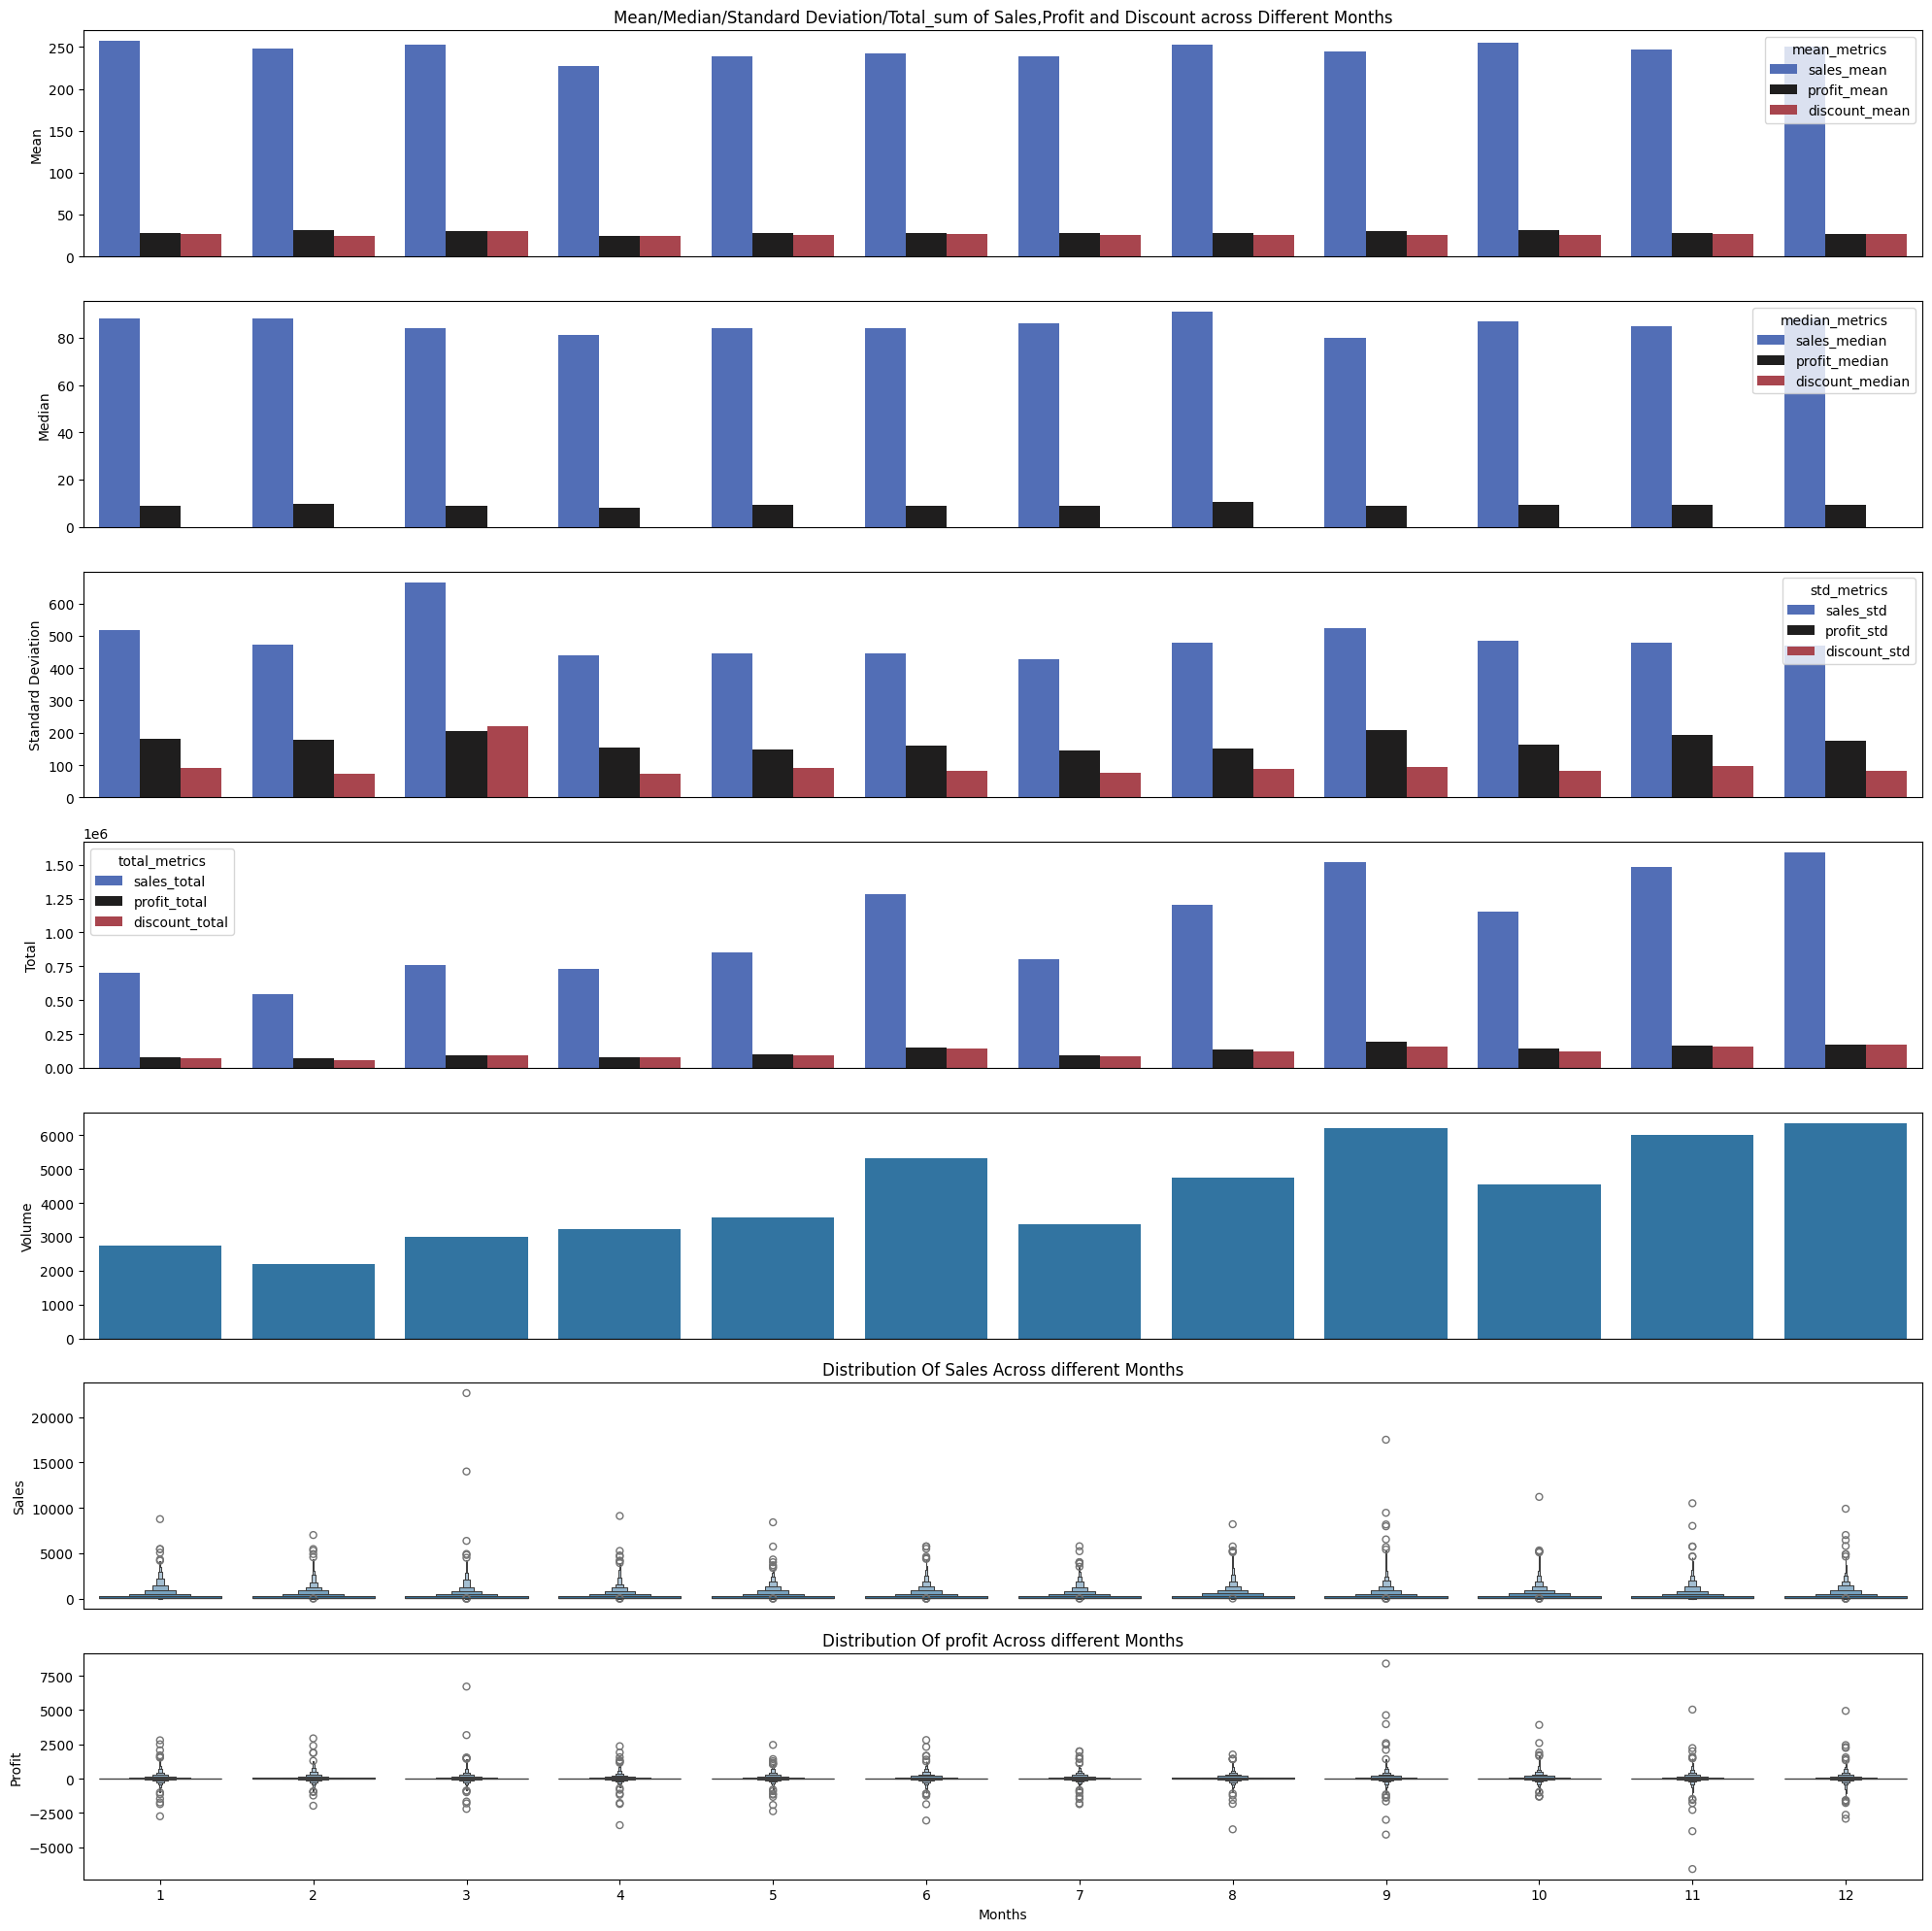

In [261]:
plt.figure(figsize=(20,20))
order=month_agg['month'].to_list()

plt.subplot(7,1,1)
sns.barplot(data=month_melted,x='month',y='mean_values',hue='mean_metrics',order=order,palette='icefire')
plt.title('Mean/Median/Standard Deviation/Total_sum of Sales,Profit and Discount across Different Months')
plt.xlabel('')
plt.ylabel('Mean')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,2)
sns.barplot(data=month_melted,x='month',y='median_values',hue='median_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Median')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,3)
sns.barplot(data=month_melted,x='month',y='std_values',hue='std_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Standard Deviation')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,4)
sns.barplot(data=month_melted,x='month',y='total_values',hue='total_metrics',order=order,palette='icefire')
plt.xlabel('')
plt.ylabel('Total')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,5)
sns.barplot(data=month_agg,x='month',y='order_count',order=order)
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks([])
plt.tight_layout()


plt.subplot(7,1,6)
sns.boxenplot(data=df,x='month',y='sales',order=order)
plt.title('Distribution Of Sales Across different Months')
plt.xlabel('')
plt.ylabel('Sales')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,7)
sns.boxenplot(data=df,x='month',y='profit',order=order)
plt.title('Distribution Of profit Across different Months')
plt.xlabel('Months')
plt.ylabel('Profit')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

### Analysis

- Monthly metrics analysis
    - mean and median  is stagnant for sales, profit and discount across all the months
    - there is little ups and downs in spread sales,profit and discount
    - total sales and order volume has increased significantly but the profit as very little change from jan to december
    - from the profit distribution,it is clearly seen that change in order volume and sales and little change in profit is due to presence of outliers from the months of march to december 

## Monthly Growth in sales and profit from Jan 2011 till Dec 2014

In [262]:
df['year_month']

0        201101
1        201101
2        201108
3        201108
4        201110
          ...  
51285    201412
51286    201412
51287    201412
51288    201412
51289    201412
Name: year_month, Length: 51290, dtype: int64

In [263]:
monthgrowth_agg=df.groupby(['year_month'],as_index=False).agg(
    sales_mean=('sales','mean'),
    profit_mean=('profit','mean'),
    discount_mean=('discount_amount','mean'),
    sales_median=('sales','median'),
    profit_median=('profit','median'),
    discount_median=('discount','median'),
    sales_std=('sales','std'),
    profit_std=('profit','std'),
    discount_std=('discount_amount','std'),
    sales_total=('sales','sum'),
    profit_total=('profit','sum'),
    discount_total=('discount_amount','sum'),
    order_count=('quantity','count')
    ).sort_values(by=['year_month'],ascending=True
)
monthgrowth_agg

year_month  sales_mean  profit_mean  discount_mean  sales_median  \
0       201101  230.144645    22.701036      25.398292          79.0   
1       201102  242.946970    34.517509      19.855975          85.0   
2       201103  285.118040    28.032682      50.535506          87.0   
3       201104  209.385609    22.765365      21.640413          80.0   
4       201105  240.852895    20.602195      28.220388          85.0   
5       201106  246.082225    24.536442      31.946058          92.0   
6       201107  208.602000    20.160077      27.465128          77.5   
7       201108  245.635473    26.693696      25.402849          83.0   
8       201109  277.284303    33.685163      34.025530          83.0   
9       201110  258.734504    30.946436      24.778293          87.0   
10      201111  271.214217    30.994237      29.615739          79.0   
11      201112  260.786569    30.402955      29.750723          94.0   
12      201201  261.381113    23.498003      28.113238          96.0   
13      201202  222.486175    29.520161      18.530664          74.5   
14      201203  245.157546    27.609595      27.703317          87.0   
15      201204  242.691601    26.522744      25.426171          74.0   
16      201205  244.145477    33.939647      21.635729          85.0   
17      201206  228.840456    31.982775      24.178150          80.0   
18      201207  244.488861    29.056729      24.299406          95.5   
19      201208  267.972832    38.576063      24.251937          96.0   
20      201209  236.532164    22.970815      26.018678          80.0   
21      201210  254.963940    29.760917      27.415122          87.0   
22      201211  224.132494    21.292899      24.079614          86.0   
23      201212  258.343475    25.519407      28.650016          97.0   
24      201301  265.149518    33.648239      26.783116          90.5   
25      201302  275.319008    38.498318      24.561911          92.0   
26      201303  254.614641    29.505989      27.478541          88.0   
27      201304  225.188639    25.099860      25.729818          85.0   
28      201305  248.335430    25.703882      29.558537          84.0   
29      201306  259.730535    30.267854      27.625644          89.0   
30      201307  249.897921    32.779174      24.488083          95.5   
31      201308  224.900682    19.714554      24.600133          80.0   
32      201309  238.952764    29.203121      24.920458          78.0   
33      201310  244.845624    30.807425      25.661027          84.0   
34      201311  233.556742    29.149079      25.013117          80.0   
35      201312  262.759977    33.904664      25.147024          91.0   
36      201401  271.543532    32.337889      28.003714          86.0   
37      201402  244.947575    25.917078      29.502566          93.0   
38      201403  244.514216    32.111266      25.792151          79.0   
39      201404  228.309331    22.120873      23.615890          82.5   
40      201405  226.340444    28.721735      23.081097          81.0   
41      201406  233.970348    26.300069      23.920109          82.5   
42      201407  236.410643    26.359897      26.994412          75.5   
43      201408  272.599743    30.613106      28.553457         102.0   
44      201409  240.927491    34.625661      21.963488          80.0   
45      201410  259.169718    34.462104      26.507904          87.5   
46      201411  259.691943    29.494914      28.123494          91.0   
47      201412  230.963335    21.436252      26.608861          79.0   

    profit_median  discount_median    sales_std  profit_std  discount_std  \
0         8.67440              0.0   408.155067  163.521579     76.611829   
1        10.47000              0.0   535.899046  214.103584     61.044498   
2         9.32000              0.0  1140.284526  182.746021    537.217974   
3         8.29080              0.0   375.105438  101.313328     50.638206   
4         7.98000              0.0   428.548604  122.906612     73.359038   
5         7.9

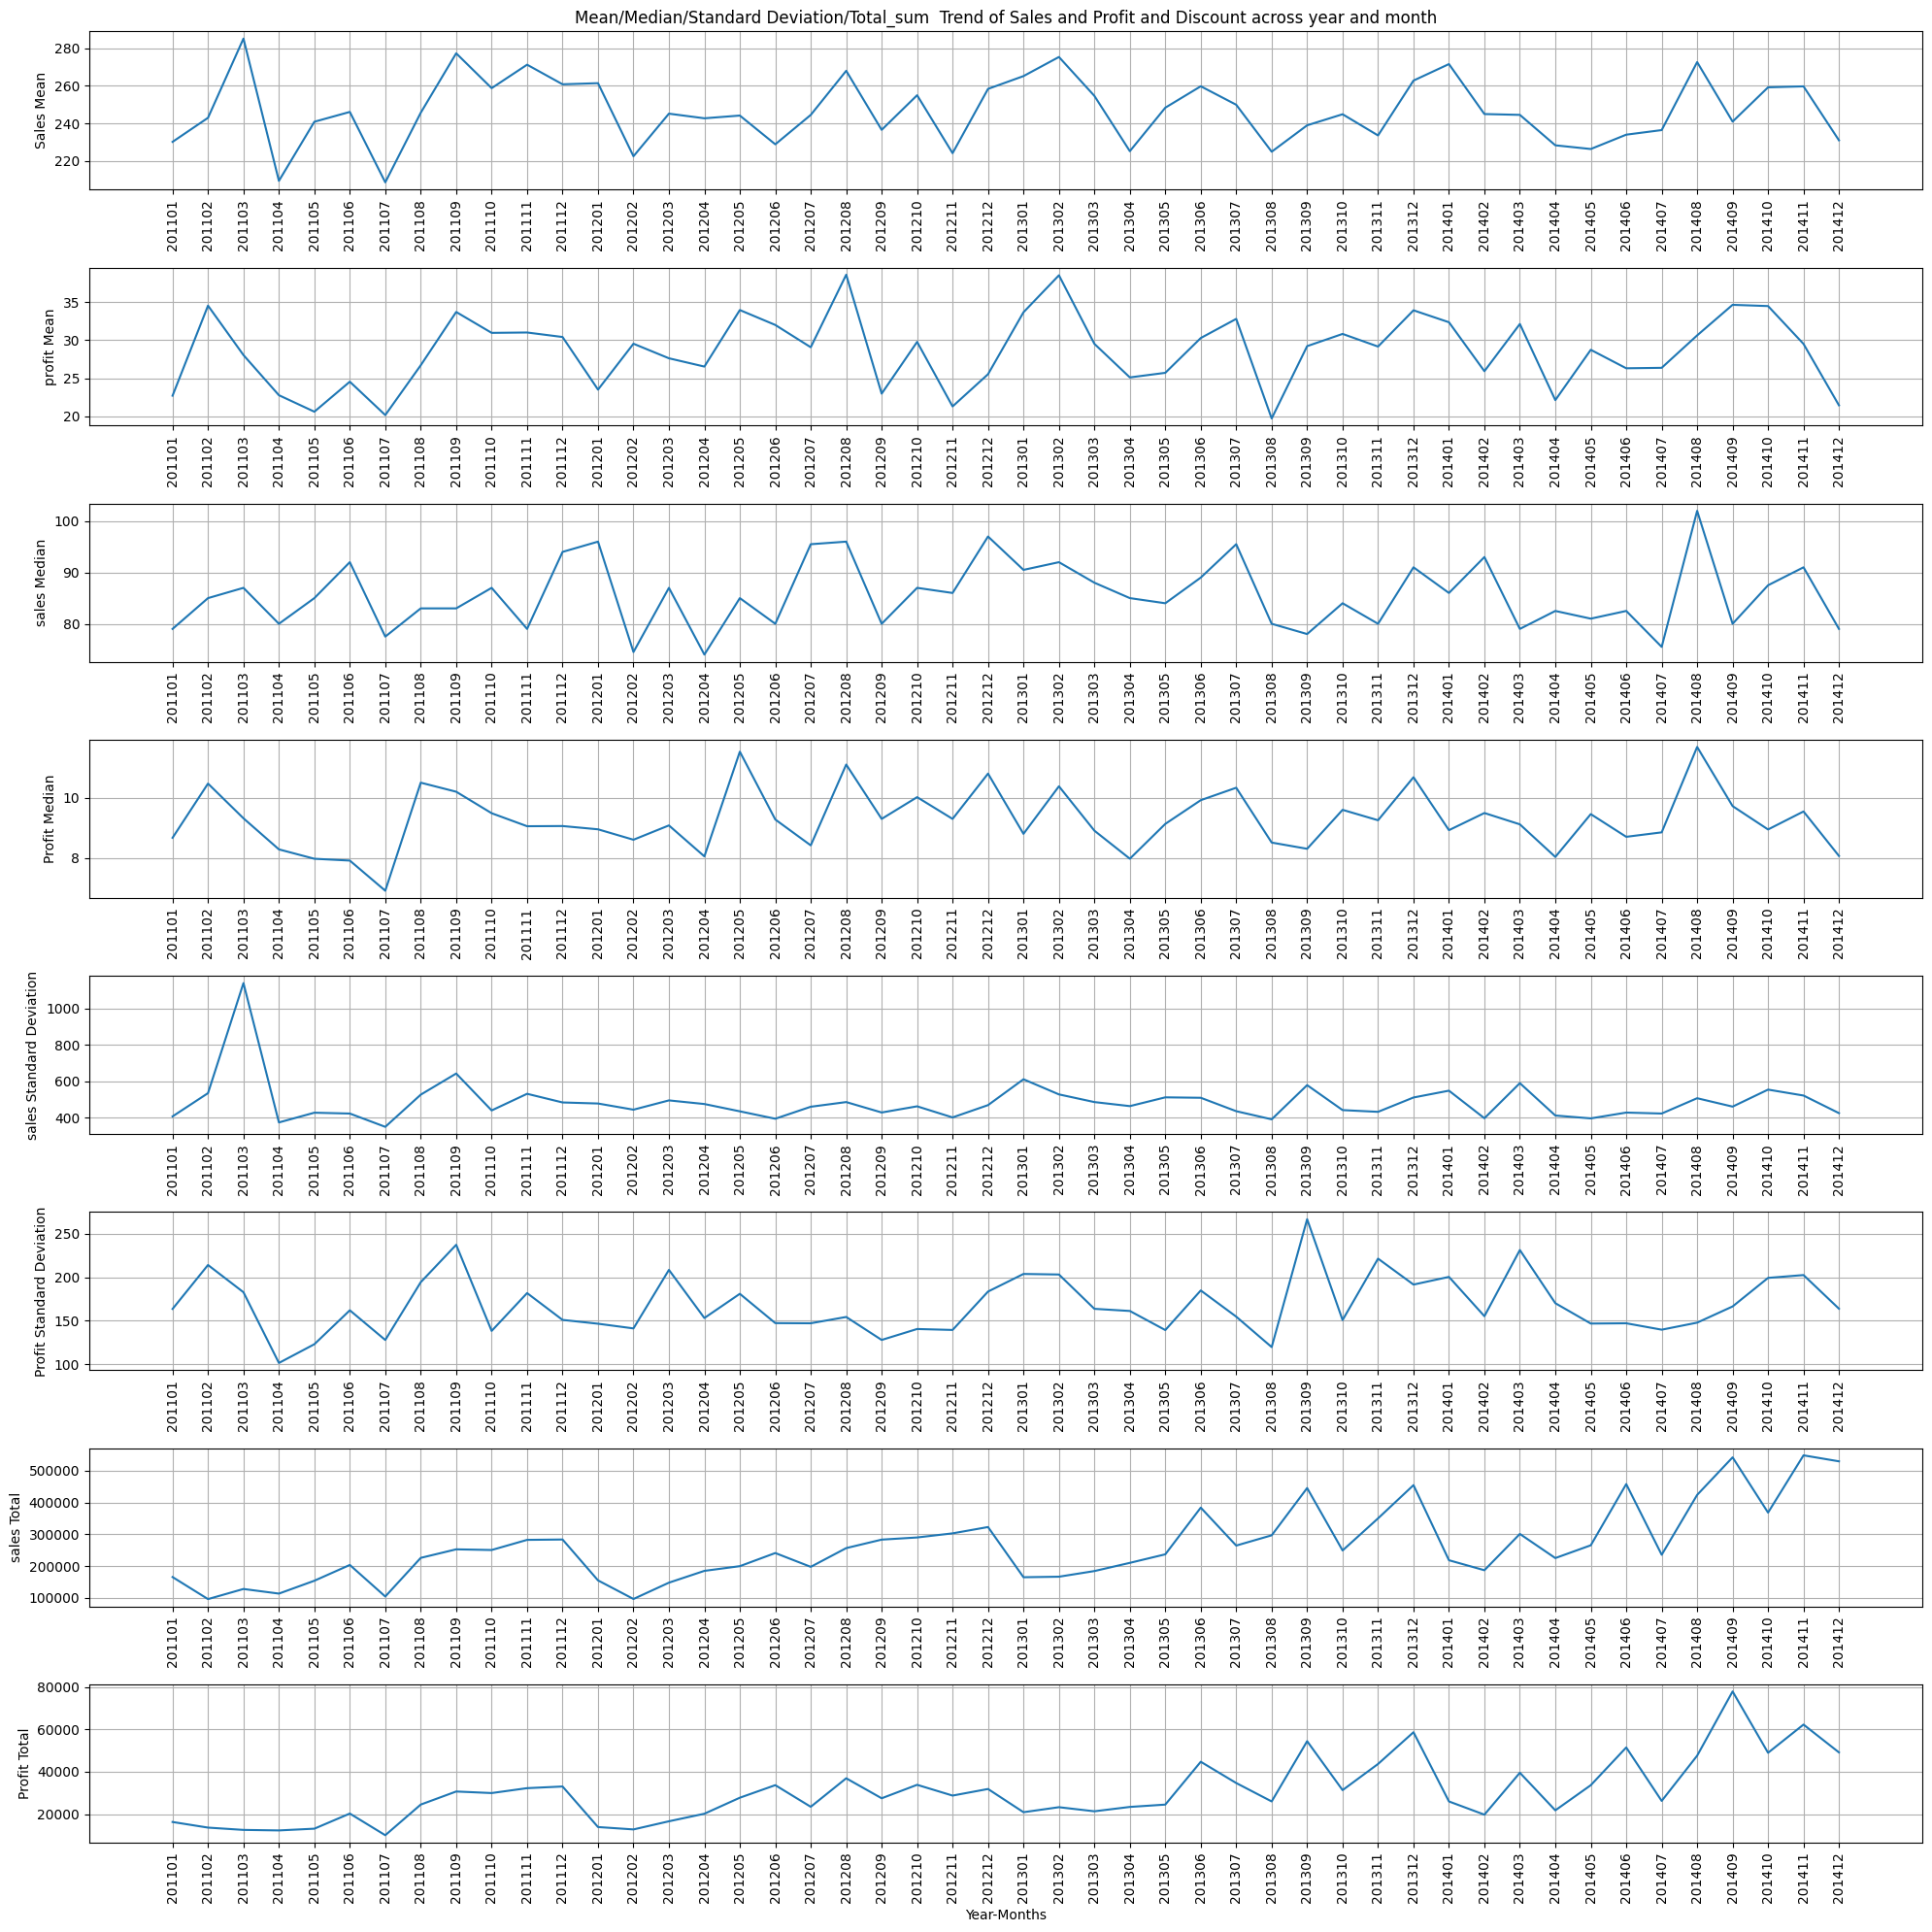

In [264]:
plt.figure(figsize=(20,20))
order=monthgrowth_agg['year_month'].to_list()

plt.subplot(8,1,1)
sns.lineplot(x=monthgrowth_agg['year_month'].astype(str),y=monthgrowth_agg['sales_mean'])
plt.title('Mean/Median/Standard Deviation/Total_sum  Trend of Sales and Profit and Discount across year and month')
plt.xlabel('')
plt.ylabel('Sales Mean')
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()

plt.subplot(8,1,2)
sns.lineplot(x=monthgrowth_agg['year_month'].astype(str),y=monthgrowth_agg['profit_mean'])
plt.xlabel('')
plt.ylabel('profit Mean')
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()

plt.subplot(8,1,3)
sns.lineplot(x=monthgrowth_agg['year_month'].astype(str),y=monthgrowth_agg['sales_median'])
plt.xlabel('')
plt.ylabel('sales Median')
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()

plt.subplot(8,1,4)
sns.lineplot(x=monthgrowth_agg['year_month'].astype(str),y=monthgrowth_agg['profit_median'])
plt.xlabel('')
plt.ylabel('Profit Median')
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()

plt.subplot(8,1,5)
sns.lineplot(x=monthgrowth_agg['year_month'].astype(str),y=monthgrowth_agg['sales_std'])
plt.xlabel('')
plt.ylabel('sales Standard Deviation')
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()

plt.subplot(8,1,6)
sns.lineplot(x=monthgrowth_agg['year_month'].astype(str),y=monthgrowth_agg['profit_std'])
plt.xlabel('')
plt.ylabel('Profit Standard Deviation')
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()

plt.subplot(8,1,7)
sns.lineplot(x=monthgrowth_agg['year_month'].astype(str),y=monthgrowth_agg['sales_total'])
plt.xlabel('')
plt.ylabel('sales Total')
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()

plt.subplot(8,1,8)
sns.lineplot(x=monthgrowth_agg['year_month'].astype(str),y=monthgrowth_agg['profit_total'])
plt.xlabel('Year-Months')
plt.ylabel('Profit Total')
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()

plt.show()

### Analysis

- sales and profit  replicates each other in mean and median
- till August,2013, the spead is very flat but after that for sales it was still the same while for profit there is ups and downs in spread
- from start of 2011 to end of 2014 sales has increased from 10.75 lakhs to approx 55 lakhs which is almost 5 times the initial while  profit has icreased from 1.75 lakhs to approx 3.5 lakhs which is just 2 times the initial
- there is huge increement in customer base but there is no such increement in profit
- along the time company has just focused on increasing the volume and customer base but profit is moving at turtle's speed 

In [265]:
df.select_dtypes(include=['number']).columns.to_list()

['discount',
 'profit',
 'quantity',
 'sales',
 'shipping_cost',
 'year',
 'weeknum',
 'month',
 'year_month',
 'discount_amount']

## Heatmap Between Currently Present Numerical Columns in the dataset showing Overall Correlation

<Axes: >

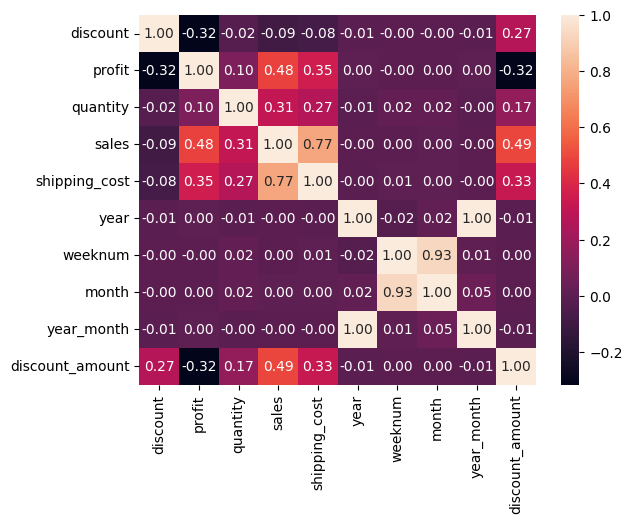

In [266]:
sns.heatmap(data=df[df.select_dtypes(include=['number']).columns.to_list()].corr(),annot=True,fmt='.2f')

- --

# Answers To the Questions

Tasks:
 Q1: Data Cleaning: 
- i.      Count and handle Missing values. ✓
- ii.     Deal with Duplicate values ✓
- iii.    Delete unknown columns if present. ✓
- iv.     Check shape, size, and datatypes of the dataset features.✓ 

Q2: Perform Univariate Analysis across all numerical features, 
- i.Which features seem useless in the analysis? Explain why? 
    - ji_lu_shu - it has only one unique vaue-1
    - market as market2 is there naming US as North America which is correct
    - order_date,ship_date-corrupted data
    - row_id -unique row_id for each row

They have no predictive/analytical value due to zero variance, corruption, or being identifiers.

- ii.Which features are uniformly distributed or normally distributed? 
    - profit is the only Numrical feature is approximately normally distributed in cetral region but is highly leptokurtic due to presence of too many outliers violating the strict normality
        
- iii.Which features are right-skewed/left-skewed? What does this signify?
    - Rght skewed
        - Discount,sales,shipping cost- 
            - Higly laptokurtic- this means extreme values as outliers are present in the Positive direction with very few or very less in number
        - quantity -
            - mesokurtic - this means extreme outliers are present but their count is little higher
    - left skewed
        - year, weeknum,month - cannot be converted to datetime as  actual date is not present hence extracted month using year and weeknum
        - mesokurtic - outliers are in large number as tail of the distribution is very fat
        - Their skewness reflects data collection period, not underlying behavior.
- iv.Which features have a high number of outliers, and discuss the impact.
    - profit,Discount,sales,shipping cost
        - they are higly skewed
        - leptokurtic due to less count of each outliers
        - Outliers distort mean, correlation, and regression estimates.
- --

In [267]:
df.select_dtypes(exclude=['number']).columns.to_list()

['category',
 'city',
 'country',
 'customer_id',
 'customer_name',
 'order_priority',
 'product_id',
 'product_name',
 'region',
 'segment',
 'ship_mode',
 'state',
 'sub_category',
 'market2',
 'profit_loss',
 'month_name',
 'global_product_name']

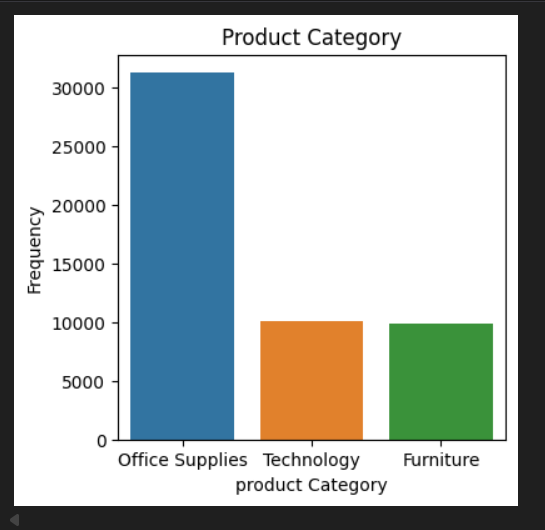

Q 3: Perform Univariate Analysis across all categorical features. 

- i. Which features seem inaccurate and are not useful as categorical “insights” directly?
    - customer_id - one customer_name is associated with multiple Customer_id
    - product_id - product_id and product_name has many-many relationship

- ii.  What’s the issue with treating Customer? Name as a categorical feature for modeling?
    - customer_name cannot be treated as true categorical feature due to very high Cardinality

- iii. Is the Category distribution balanced or skewed? Give a 1-line reason.
    - The category distribution is skewed, with Office Supplies dominating the dataset compared to Technology and Furniture.

- iv. In Country, does one country dominate strongly? What does that imply about geographic bias?
    - store receives highest revenue and profit from United States
        - It means:
            - Most patterns reflect that country
            - Other countries are under-represented
            - Insights may not generalize globally
                * So analysis may be biased toward US behavior.

- v. Is the City dataset concentrated in a few cities or spread out?
    - store receives highest revenue and profit from New York City hence Dominated by NYC 
        - sales Dominated by NYC
        - It implies:
            - Urban concentration
            - Dependence on major metros
            - Risk if that market declines
            - Smaller cities underrepresented

- --

Q 4: Perform Bivariant Analysis for numerical-to-numerical features: 
- i. Which two features are most strongly correlated?
    - shipping_cost and Sales are Highly and directly coorelated with value of 0.77
    - month and weeknum are higly correlated with 0.93

- ii. Also name features that are negatively correlated.
    - profit and discount with -0.32

<Axes: >

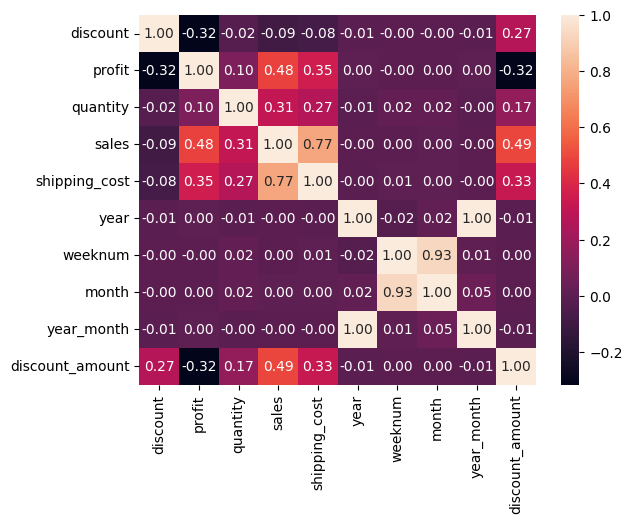

In [268]:
nums=df.select_dtypes(include=['number']).columns.to_list()
sns.heatmap(df[nums].corr(),annot=True,fmt='.2f')

iii. If your goal is to understand profit, which are the most useful next bivariate checks? Perform them and give clear insights.

 - profit VS sales

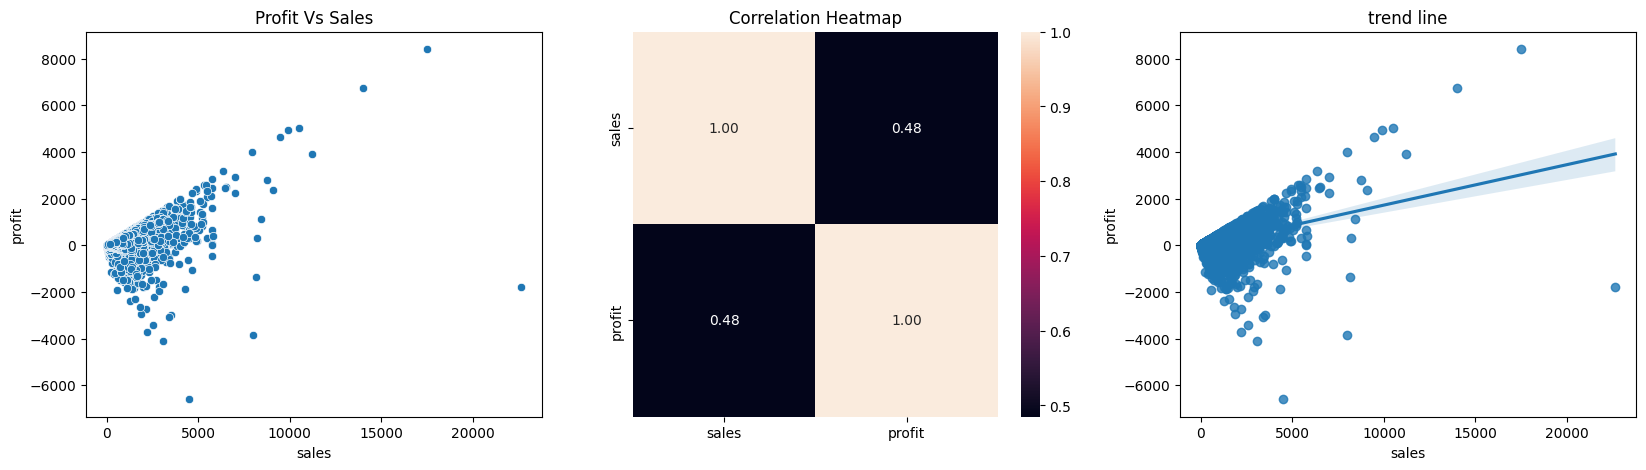

In [269]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.scatterplot(data=df,x='sales',y='profit')
plt.title('Profit Vs Sales')

plt.subplot(1,3,2)
sns.heatmap(data=df[['sales','profit']].corr(),annot=True,fmt='.2f')
plt.title('Correlation Heatmap')

plt.subplot(1,3,3)
sns.regplot(data=df,x='sales',y='profit')
plt.title('trend line')
plt.show()

- Clear upward trend
- Dense cluster at low sales
- High variance at high sales
- Some high-sales losses
- Correlation ≈ +0.48 → moderate positive

Higher sales generally lead to higher profit, but the relationship is only moderate, indicating that revenue growth alone does not guarantee profitability

Revenue growth alone is not sufficient. Profitability depends on pricing and cost control.

Profit vs Shipping_cost

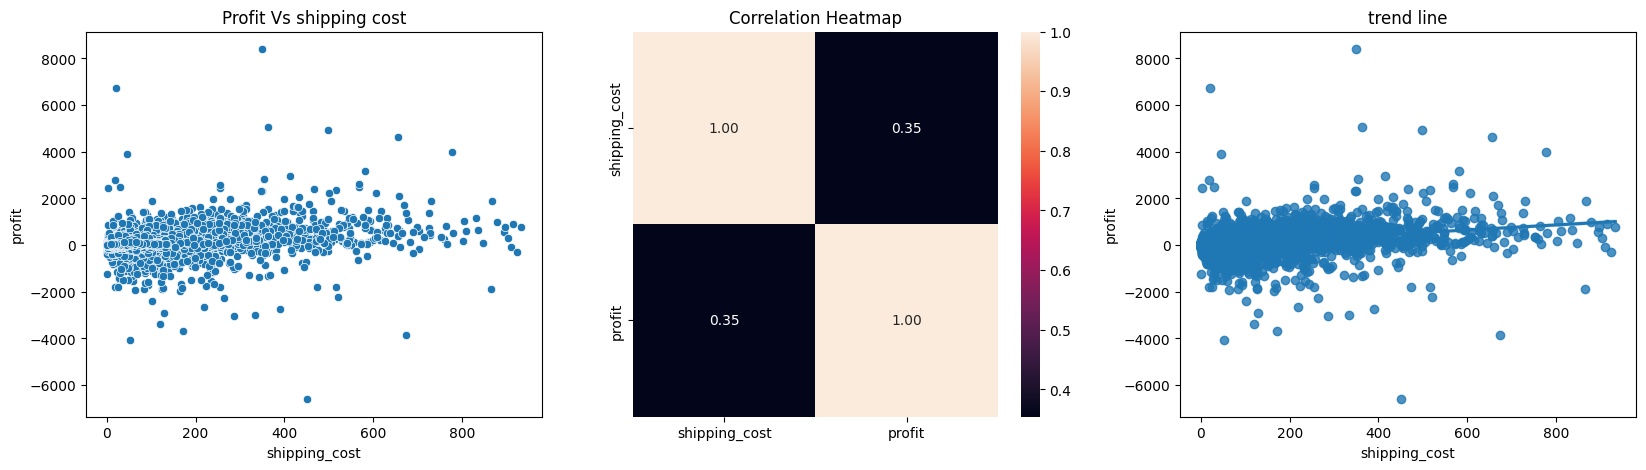

In [270]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.scatterplot(data=df,x='shipping_cost',y='profit')
plt.title('Profit Vs shipping cost')

plt.subplot(1,3,2)
sns.heatmap(data=df[['shipping_cost','profit']].corr(),annot=True,fmt='.2f')
plt.title('Correlation Heatmap')

plt.subplot(1,3,3)
sns.regplot(data=df,x='shipping_cost',y='profit')
plt.title('trend line')
plt.show()

- Weak upward trend
- Large scatter
- Many low-profit / loss points at high shipping
- Correlation ≈ +0.35 → weak positive

Shipping cost has a weak positive relationship with profit, suggesting it mainly reflects order size rather than directly improving margins.

Large orders incur high logistics costs and do not necessarily improve profitability. Shipping optimization is important.

Profit Vs Discount

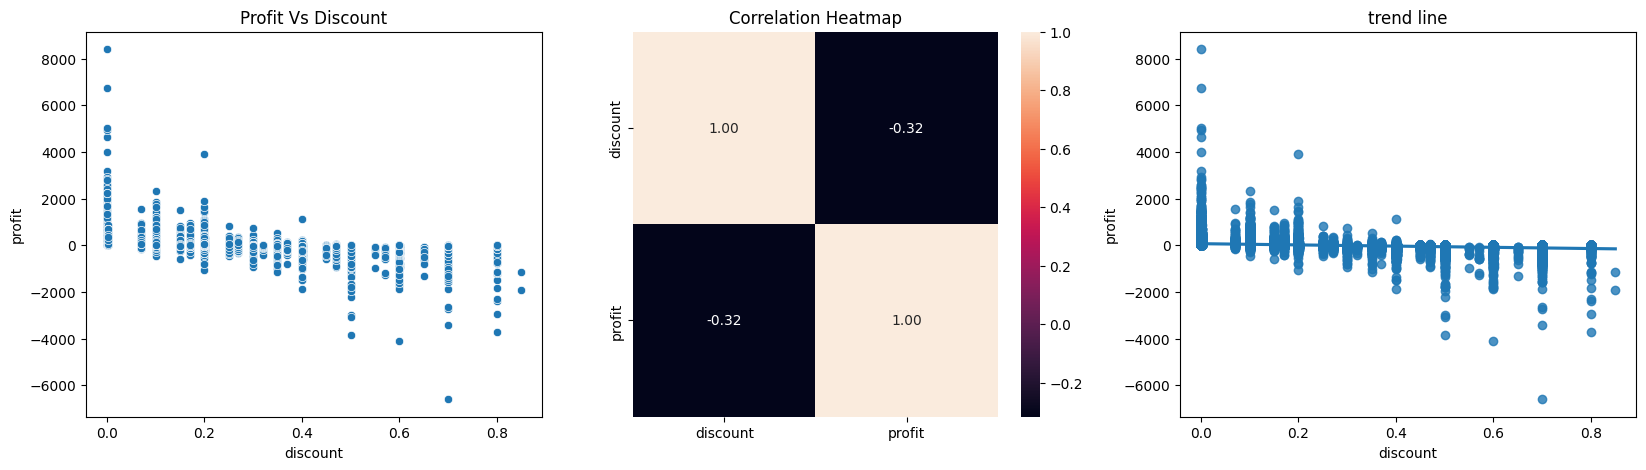

In [271]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.scatterplot(data=df,x='discount',y='profit')
plt.title('Profit Vs Discount')

plt.subplot(1,3,2)
sns.heatmap(data=df[['discount','profit']].corr(),annot=True,fmt='.2f')
plt.title('Correlation Heatmap')

plt.subplot(1,3,3)
sns.regplot(data=df,x='discount',y='profit')
plt.title('trend line')
plt.show()

- Clear downward slope
- High discounts → mostly losses
- Vertical bands (fixed discount levels)
- Correlation ≈ –0.32 (moderate negative)

Discount shows a consistent negative relationship with profit. Higher discounts significantly reduce margins and increase loss-making transactions.

Uncontrolled discounting is the biggest risk to profitability. Discount policies should be strictly managed.

- iv. Look for Time Effects Clues. Mention any information you find about the time relationship with any feature.

- year vs profit
- year vs sales
- year vs order_volume
- year vs discount

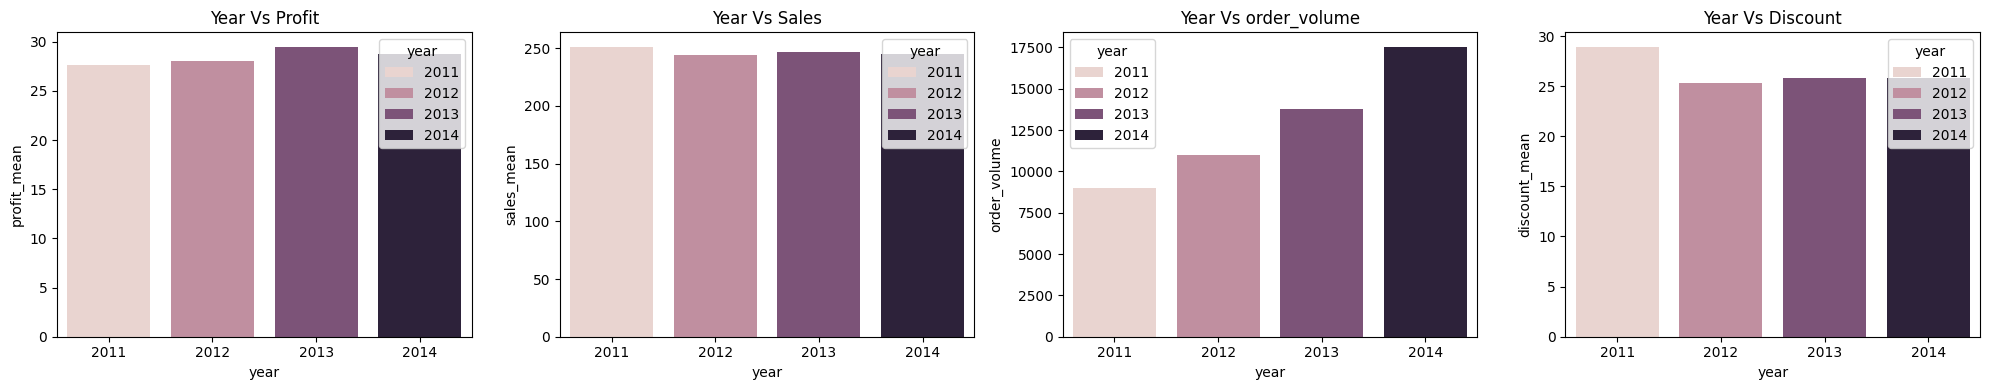

In [272]:
groupby_year=df.groupby(['year'],as_index=False).agg(
    profit_mean=('profit','mean'),
    sales_mean=('sales','mean'),
    order_volume=('year','count'),
    discount_mean=('discount_amount','mean')
)
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
sns.barplot(data=groupby_year,x='year',y='profit_mean',hue='year')
plt.title('Year Vs Profit')
plt.tight_layout()

plt.subplot(1,4,2)
sns.barplot(data=groupby_year,x='year',y='sales_mean',hue='year')
plt.title('Year Vs Sales')
plt.tight_layout()

plt.subplot(1,4,3)
sns.barplot(data=groupby_year,x='year',y='order_volume',hue='year')
plt.title('Year Vs order_volume')
plt.tight_layout()

plt.subplot(1,4,4)
sns.barplot(data=groupby_year,x='year',y='discount_mean',hue='year')
plt.title('Year Vs Discount')
plt.tight_layout()
plt.show()

- Year vs Profit
    - Observation
        - Profit_mean increases gradually from 2011 to 2014
        - No sharp drops
    - Analysis
        - Average profit shows a steady upward trend across years, indicating gradual improvement in business profitability.

- Year vs Sales
    - Observation
        - Sales_mean is stable with slight increase
        - No major volatility
    - Analysis
        - Sales remain relatively stable with marginal growth, suggesting consistent revenue performance over time.

- Year vs Order Volume
    - Observation
        - Strong upward trend
        - Nearly doubles from 2011 to 2014
    - Analysis
        - Order volume increases significantly over years, indicating expanding customer base and business growth.

- Year vs Discount
    - Observation
        - Slight decline after 2011
        - Then stabilizes
    - Analysis
        - Average discount levels slightly decrease and stabilize, reflecting improved pricing discipline over time.

- weeknum vs profit
- weeknum vs sales
- weeknum vs order_volume
- weeknum vs discount

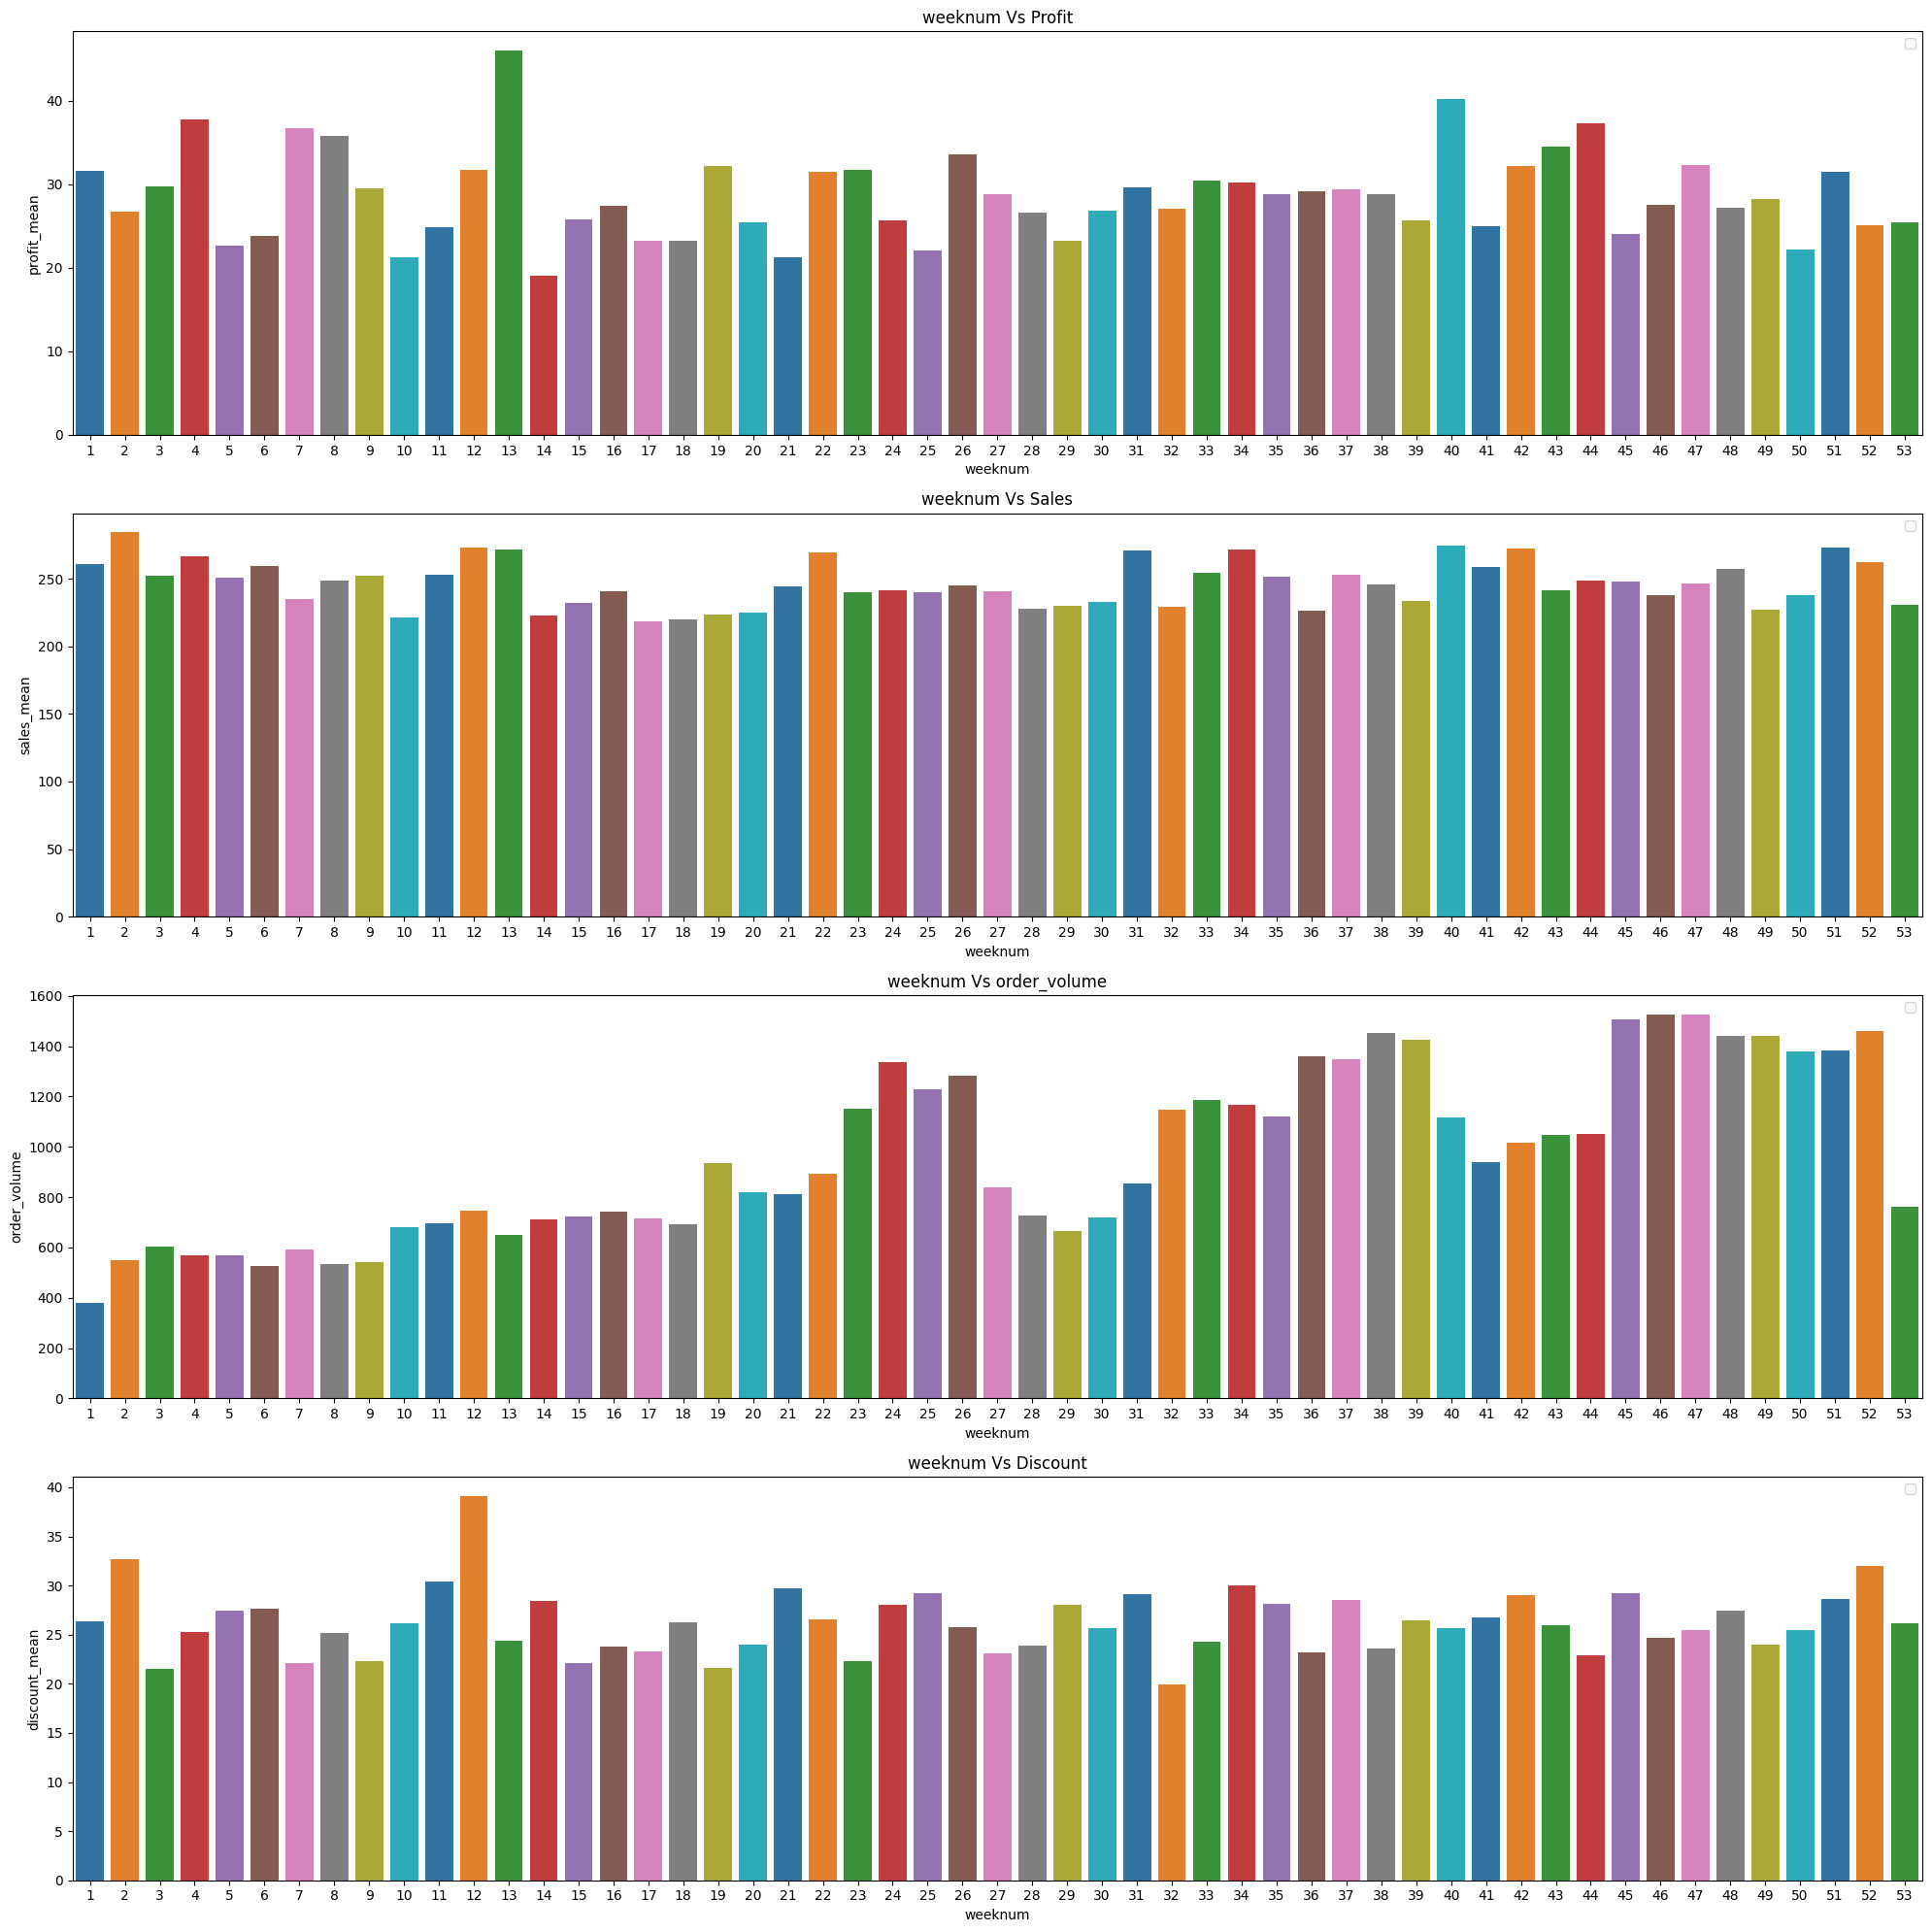

In [273]:
groupby_weeknum=df.groupby(['weeknum'],as_index=False).agg(
    profit_mean=('profit','mean'),
    sales_mean=('sales','mean'),
    order_volume=('weeknum','count'),
    discount_mean=('discount_amount','mean')
)
plt.figure(figsize=(20,20))
plt.subplot(4,1,1)
sns.barplot(data=groupby_weeknum,x='weeknum',y='profit_mean',hue='weeknum',palette='tab10')
plt.title('weeknum Vs Profit')
plt.legend([])
plt.tight_layout()

plt.subplot(4,1,2)
sns.barplot(data=groupby_weeknum,x='weeknum',y='sales_mean',hue='weeknum',palette='tab10')
plt.title('weeknum Vs Sales')
plt.legend([])
plt.tight_layout()

plt.subplot(4,1,3)
sns.barplot(data=groupby_weeknum,x='weeknum',y='order_volume',hue='weeknum',palette='tab10')
plt.title('weeknum Vs order_volume')
plt.legend([])
plt.tight_layout()

plt.subplot(4,1,4)
sns.barplot(data=groupby_weeknum,x='weeknum',y='discount_mean',hue='weeknum',palette='tab10')
plt.title('weeknum Vs Discount')
plt.legend([])
plt.tight_layout()
plt.show()

- Weeknum vs Profit
    - Observation
        - Large fluctuations
        - Peaks around weeks ~13, ~40–45
        - No smooth trend
    - Analysis
        - Profit varies considerably across weeks, indicating seasonal spikes and irregular margin performance within each year.

- Weeknum vs Sales
    - Observation
        - Repeating peaks
        - Higher sales in mid and late-year weeks
    - Analysis
        - Sales exhibit recurring seasonal patterns, with higher activity during specific weeks, likely driven by promotional periods.

- Weeknum vs Order Volume
    - Observation
        - Increasing toward later weeks
        - Peaks near weeks 45–50
    - Analysis
        - Order volume rises toward year-end, suggesting strong seasonal demand during festive and holiday periods.

- Weeknum vs Discount
    - Observation
        - Occasional spikes
        - Mostly stable otherwise
    - Analysis
        - Discount levels remain largely consistent with occasional promotional spikes during high-demand weeks.

- month vs profit
- month vs sales
- month vs order_volume
- month vs discount

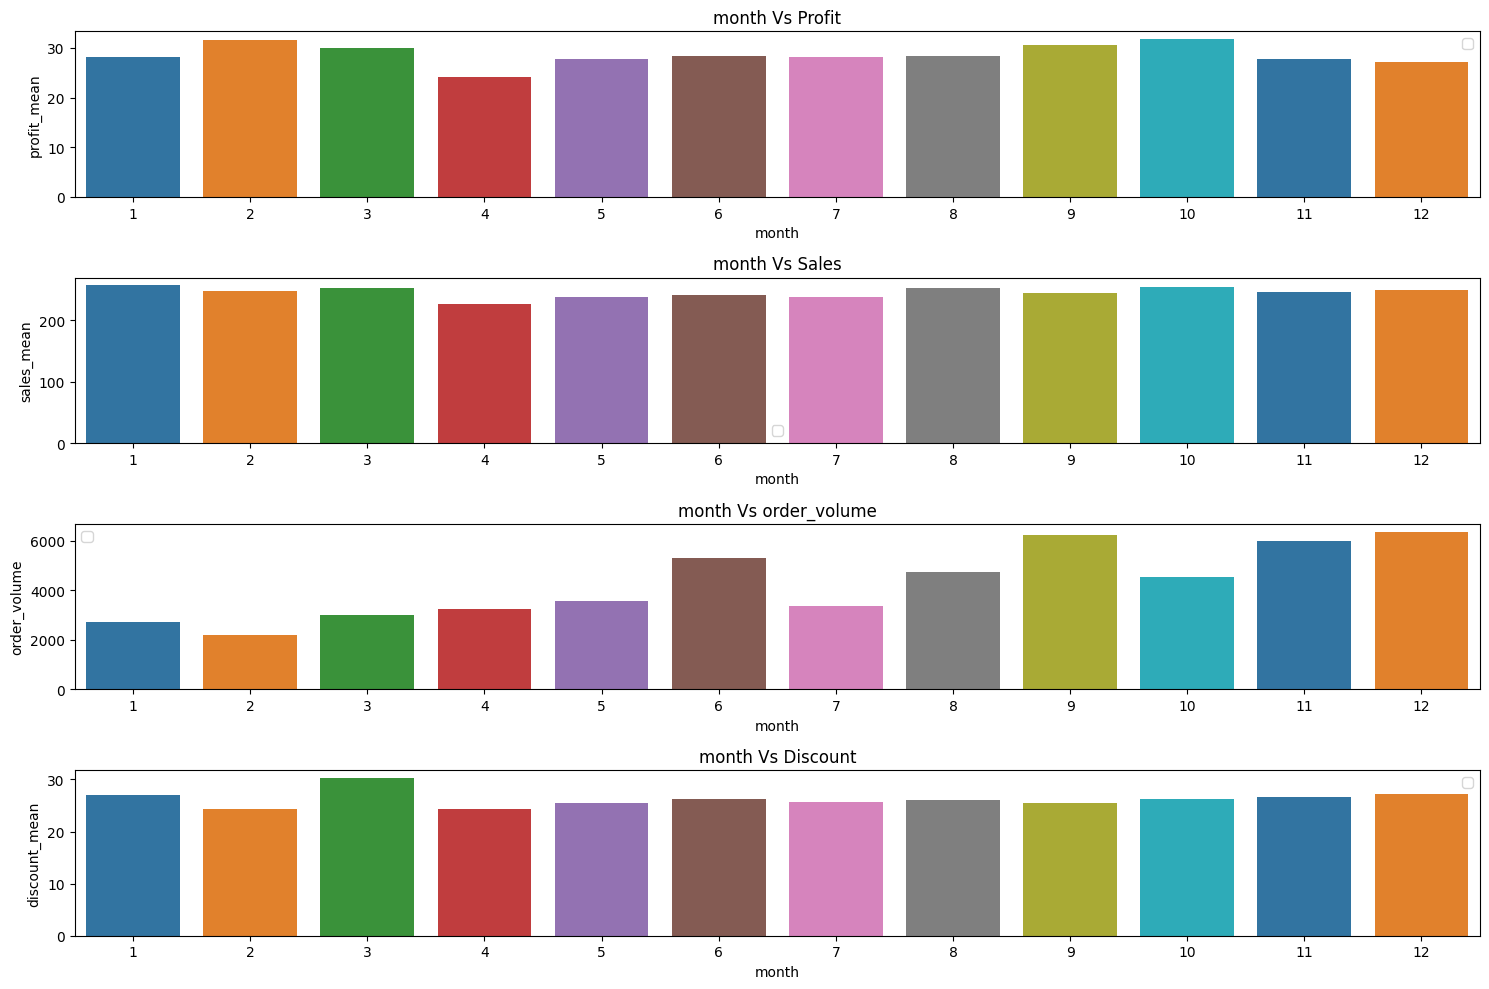

In [274]:
groupby_month=df.groupby(['month'],as_index=False).agg(
    profit_mean=('profit','mean'),
    sales_mean=('sales','mean'),
    order_volume=('month','count'),
    discount_mean=('discount_amount','mean')
)
plt.figure(figsize=(15,10))
plt.subplot(4,1,1)
sns.barplot(data=groupby_month,x='month',y='profit_mean',hue='month',palette='tab10')
plt.title('month Vs Profit')
plt.legend([])
plt.tight_layout()

plt.subplot(4,1,2)
sns.barplot(data=groupby_month,x='month',y='sales_mean',hue='month',palette='tab10')
plt.title('month Vs Sales')
plt.legend([])
plt.tight_layout()

plt.subplot(4,1,3)
sns.barplot(data=groupby_month,x='month',y='order_volume',hue='month',palette='tab10')
plt.title('month Vs order_volume')
plt.legend([])
plt.tight_layout()

plt.subplot(4,1,4)
sns.barplot(data=groupby_month,x='month',y='discount_mean',hue='month',palette='tab10')
plt.title('month Vs Discount')
plt.legend([])
plt.tight_layout()
plt.show()

- Month vs Profit
    - Observation
        - Higher profit in months 2, 9, 10
        - Dip around month 4
    - Analysis
        - Profit shows moderate seasonality, with higher margins in late-year and early-year months and weaker performance in mid-year.

- Month vs Sales
    - Observation
        - Peaks around months 8–10
        - Lower in month 4
    - Analysis
        - Sales increase during late summer and autumn months, reflecting seasonal purchasing behavior.

- Month vs Order Volume
    - Observation
        - Strong growth from mid-year onward
        - Peak in months 9–12
    - Analysis
        - Order volume rises sharply in the second half of the year, indicating strong end-of-year demand.

- Month vs Discount
    - Observation
        - Relatively flat
        - Slight increase in March and December
    - Analysis
        - Discount patterns remain stable with minor increases during promotional months.

- year_month vs profit
- year_month vs sales
- year_month vs order_volume
- year_month vs discount

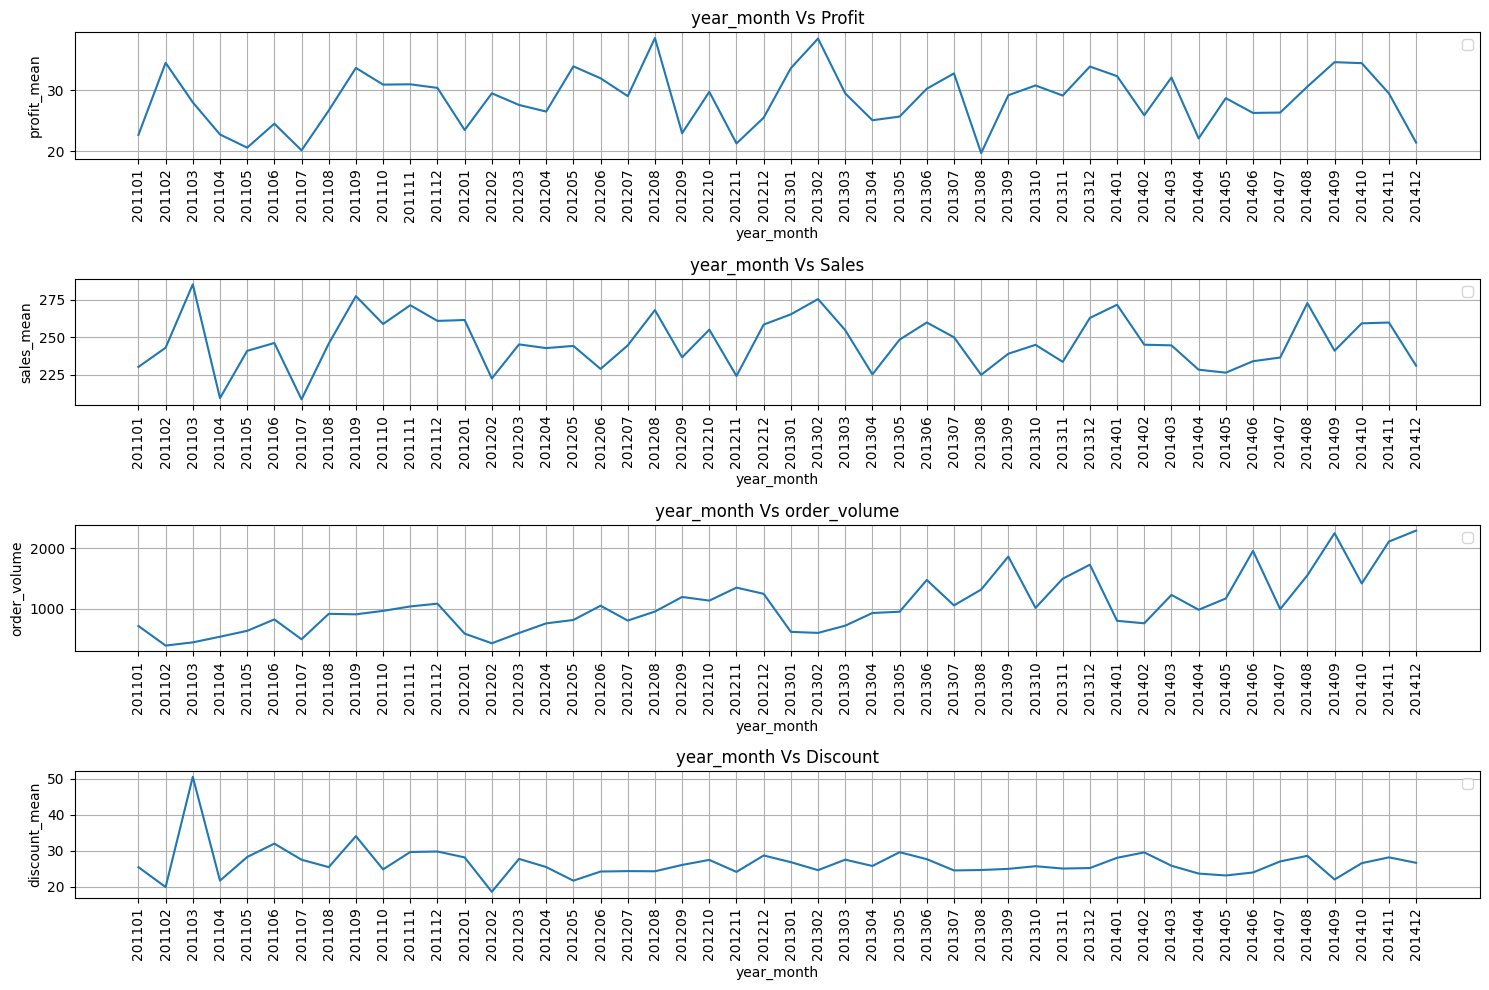

In [275]:
groupby_year_month=df.groupby(['year_month'],as_index=False).agg(
    profit_mean=('profit','mean'),
    sales_mean=('sales','mean'),
    order_volume=('year_month','count'),
    discount_mean=('discount_amount','mean')
)
plt.figure(figsize=(15,10))
plt.subplot(4,1,1)
sns.lineplot(x=groupby_year_month['year_month'].astype(str),y=groupby_year_month['profit_mean'],)
plt.title('year_month Vs Profit')
plt.legend([])
plt.grid()
plt.xticks(rotation=90)
plt.tight_layout()

plt.subplot(4,1,2)
sns.lineplot(x=groupby_year_month['year_month'].astype(str),y=groupby_year_month['sales_mean'],)
plt.title('year_month Vs Sales')
plt.legend([])
plt.grid()
plt.xticks(rotation=90)
plt.tight_layout()

plt.subplot(4,1,3)
sns.lineplot(x=groupby_year_month['year_month'].astype(str),y=groupby_year_month['order_volume'],)
plt.title('year_month Vs order_volume')
plt.legend([])
plt.grid()
plt.xticks(rotation=90)
plt.tight_layout()

plt.subplot(4,1,4)
sns.lineplot(x=groupby_year_month['year_month'].astype(str),y=groupby_year_month['discount_mean'],)
plt.title('year_month Vs Discount')
plt.legend([])
plt.grid()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- Year_Month vs Profit
    - Observation
        - High volatility
        - No smooth upward curve
        - Frequent spikes and drops
    - Analysis
        - Profit remains volatile over time with frequent fluctuations, indicating inconsistent margin control despite business growth.

- Year_Month vs Sales
    - Observation
        - Slight upward trend
        - Cyclic peaks
    - Analysis
        - Sales show gradual long-term growth combined with seasonal cycles.

- Year_Month vs Order Volume
    - Observation
        - Clear upward trend
        - Strong late-period growth
    - Analysis
        - Order volume consistently increases over time, reflecting sustained business expansion.

- Year_Month vs Discount
    - Observation
        - Large spike in early 2011
        - Then stabilizes
    - Analysis
        - Discount levels were initially volatile but became more controlled over time, indicating improved promotional strategy.

- --

<Axes: xlabel='category', ylabel='profit'>

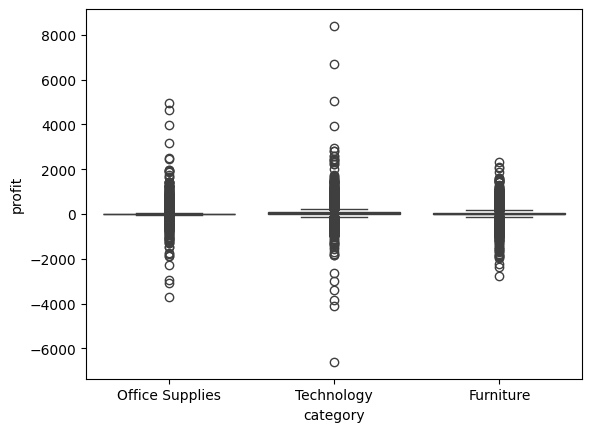

In [276]:
plt.figure()
sns.boxplot(data=df,y='profit',x='category')

In [277]:
df['profit'].describe()

count    51290.000000
mean        28.610982
std        174.340972
min      -6599.978000
25%          0.000000
50%          9.240000
75%         36.810000
max       8399.976000
Name: profit, dtype: float64

In [278]:
df[(df['category']=='Technology')&(df['profit']<df[df['category']=='Technology']['profit'].quantile(0.25))]['profit'].count()

np.int64(2535)

In [279]:
def describe_categorywise(df,cat_col,num_col):
    unique_cat=df[cat_col].unique()
    cat_desc=[]
    for i in unique_cat:
        cat_num_desc={}
        cat_num_desc['Cat_col']=cat_col
        cat_num_desc['num_col']=num_col
        sub_df=df[df[cat_col]==i]
        q1=sub_df[num_col].quantile(0.25)
        q2=sub_df[num_col].quantile(0.50)
        q3=sub_df[num_col].quantile(0.75)
        iqr=q3-q1
        cat_num_desc['Category']=i
        counts=len(sub_df)
        cat_num_desc['Count']=float(counts)
        means=sub_df[num_col].mean()
        cat_num_desc['mean']=float(means)
        stds= sub_df[num_col].std()
        cat_num_desc['std']=float(stds)
        minm=sub_df[num_col].min()
        cat_num_desc['min']=float(minm)
        maxm=sub_df[num_col].max()
        cat_num_desc['25%']=float(q1)
        cat_num_desc['50%']=float(q2)
        cat_num_desc['75%']=float(q3)
        cat_num_desc['IQR']=float(iqr)
        cat_num_desc['max']=float(maxm)
        lf=q1-(1.5*iqr)
        uf=q3+(1.5*iqr)
        neg_out_count=sub_df[sub_df[num_col]<lf][num_col].count()
        cat_num_desc['negative_outlier_count']=float(neg_out_count)
        pos_out_count=sub_df[sub_df[num_col]>uf][num_col].count()
        cat_num_desc['positive_outlier_count']=float(pos_out_count)
        

        cat_desc.append(cat_num_desc)
    return cat_desc


In [280]:
describe_categorywise(df=df,cat_col='category',num_col='profit')

[{'Cat_col': 'category',
  'num_col': 'profit',
  'Category': 'Office Supplies',
  'Count': 31273.0,
  'mean': 16.578960582611202,
  'std': 109.74925123521983,
  'min': -3701.8928,
  '25%': 0.45,
  '50%': 6.5538,
  '75%': 20.58,
  'IQR': 20.13,
  'max': 4946.37,
  'negative_outlier_count': 1782.0,
  'positive_outlier_count': 3290.0},
 {'Cat_col': 'category',
  'num_col': 'profit',
  'Category': 'Technology',
  'Count': 10141.0,
  'mean': 65.45495840449661,
  'std': 271.21537574883985,
  'min': -6599.978,
  '25%': 0.5,
  '50%': 29.94,
  '75%': 98.85,
  'IQR': 98.35,
  'max': 8399.976,
  'negative_outlier_count': 513.0,
  'positive_outlier_count': 960.0},
 {'Cat_col': 'category',
  'num_col': 'profit',
  'Category': 'Furniture',
  'Count': 9876.0,
  'mean': 28.878566605913324,
  'std': 205.7599359678675,
  'min': -2750.28,
  '25%': -12.174999999999999,
  '50%': 15.5022,
  '75%': 69.36,
  'IQR': 81.535,
  'max': 2316.51,
  'negative_outlier_count': 750.0,
  'positive_outlier_count': 944.0

- Q 5: Perform Bi-variant Analysis for categorical to numerical features.: 
- i.Profit by Category: 
    - Which category has the highest median profit?
        - Technology - 29.94
    - Which has the lowest?
        - Office Supplies - 6.55 
    - Which category shows the widest spread (largest IQR) in Profit?
        - Technology - 98.35  
    - What does that suggest about profit consistency? 
        - Technology has the widest spread due to which some orders gives very high profit and some orders gives very low or even losses,hence The large IQR for Technology suggests that its profits are highly variable and less consistent compared to other categories

In [281]:
describe_categorywise(df=df,cat_col='category',num_col='sales')

[{'Cat_col': 'category',
  'num_col': 'sales',
  'Category': 'Office Supplies',
  'Count': 31273.0,
  'mean': 121.10542640616507,
  'std': 299.3237849493655,
  'min': 0.0,
  '25%': 20.0,
  '50%': 46.0,
  '75%': 105.0,
  'IQR': 85.0,
  'max': 9893.0,
  'negative_outlier_count': 0.0,
  'positive_outlier_count': 3372.0},
 {'Cat_col': 'category',
  'num_col': 'sales',
  'Category': 'Technology',
  'Count': 10141.0,
  'mean': 467.8721033428656,
  'std': 708.9745608418618,
  'min': 1.0,
  '25%': 117.0,
  '50%': 260.0,
  '75%': 555.0,
  'IQR': 438.0,
  'max': 22638.0,
  'negative_outlier_count': 0.0,
  'positive_outlier_count': 841.0},
 {'Cat_col': 'category',
  'num_col': 'sales',
  'Category': 'Furniture',
  'Count': 9876.0,
  'mean': 416.24989874443094,
  'std': 553.0684445248198,
  'min': 2.0,
  '25%': 91.0,
  '50%': 220.0,
  '75%': 509.0,
  'IQR': 418.0,
  'max': 5760.0,
  'negative_outlier_count': 0.0,
  'positive_outlier_count': 796.0}]

- ii. Sales by Category: 
    - Which category has the highest median sales?
        - Technology - 260.0 
    - Does it also have the highest median profit?
        - Yes, it has highest median Profit of 29.94

In [282]:
describe_categorywise(df=df,cat_col='segment',num_col='profit')

[{'Cat_col': 'segment',
  'num_col': 'profit',
  'Category': 'Consumer',
  'Count': 26518.0,
  'mean': 28.254007921411873,
  'std': 174.00604484781402,
  'min': -6599.978,
  '25%': 0.0,
  '50%': 9.18,
  '75%': 36.652499999999996,
  'IQR': 36.652499999999996,
  'max': 6719.9808,
  'negative_outlier_count': 1834.0,
  'positive_outlier_count': 3187.0},
 {'Cat_col': 'segment',
  'num_col': 'profit',
  'Category': 'Home Office',
  'Count': 9343.0,
  'mean': 29.648847325270257,
  'std': 170.577590186876,
  'min': -3399.98,
  '25%': 0.0,
  '50%': 9.32,
  '75%': 37.08,
  'IQR': 37.08,
  'max': 3919.9888,
  'negative_outlier_count': 614.0,
  'positive_outlier_count': 1166.0},
 {'Cat_col': 'segment',
  'num_col': 'profit',
  'Category': 'Corporate',
  'Count': 15429.0,
  'mean': 28.5960417823579,
  'std': 177.15636212150955,
  'min': -4088.376,
  '25%': 0.0,
  '50%': 9.3152,
  '75%': 36.945,
  'IQR': 36.945,
  'max': 8399.976,
  'negative_outlier_count': 1081.0,
  'positive_outlier_count': 1871.

- iii. Profit by Segment: 
    - Which segment has the highest median profit?
        -  Consumer - 9.18
        - Home Office- 9.32
        - Corporate - 9.3152
        - though numerically Home office has the highest median profit but all median profit of all the segemnts are approximately equal
    - Which segment has the most negative/low profit outliers?
        - Consumer segment has most number of negative/low profit outliers 

In [283]:
describe_categorywise(df=df,cat_col='segment',num_col='sales')

[{'Cat_col': 'segment',
  'num_col': 'sales',
  'Category': 'Consumer',
  'Count': 26518.0,
  'mean': 245.42352364431707,
  'std': 477.135009077624,
  'min': 0.0,
  '25%': 31.0,
  '50%': 85.0,
  '75%': 251.0,
  'IQR': 220.0,
  'max': 14000.0,
  'negative_outlier_count': 0.0,
  'positive_outlier_count': 2888.0},
 {'Cat_col': 'segment',
  'num_col': 'sales',
  'Category': 'Home Office',
  'Count': 9343.0,
  'mean': 247.2392165257412,
  'std': 518.4368317215213,
  'min': 1.0,
  '25%': 30.0,
  '50%': 85.0,
  '75%': 249.0,
  'IQR': 219.0,
  'max': 22638.0,
  'negative_outlier_count': 0.0,
  'positive_outlier_count': 1052.0},
 {'Cat_col': 'segment',
  'num_col': 'sales',
  'Category': 'Corporate',
  'Count': 15429.0,
  'mean': 247.89733618510596,
  'std': 486.04656089550014,
  'min': 1.0,
  '25%': 31.0,
  '50%': 85.0,
  '75%': 253.0,
  'IQR': 222.0,
  'max': 17500.0,
  'negative_outlier_count': 0.0,
  'positive_outlier_count': 1705.0}]

In [284]:
segment_agg

segment  sales_mean  profit_mean  discount_mean  sales_median  \
0     Consumer  245.423524    28.254008      26.092674          85.0   
1    Corporate  247.897336    28.596042      26.212598          85.0   
2  Home Office  247.239217    29.648847      26.759668          85.0   

   profit_median  discount_median   sales_std  profit_std  discount_std  \
0         9.1800              0.0  477.135009  174.006045     85.267792   
1         9.3152              0.0  486.046561  177.156362     86.026979   
2         9.3200              0.0  518.436832  170.577590    145.288369   

   sales_total  profit_total  discount_total  order_count  
0      6508141  749239.78206      691925.524        26518  
1      3824808  441208.32866      404434.178        15429  
2      2309956  277009.18056      250015.582         9343

- iv. Sales by Segment: 
    - Which segment has the highest median sales?
        - all the segments has median sales of 85.0
    - Is the profit pattern consistent with sales?
        - sales mean - approximately equal
        - profit mean - approximately equal
        - discount mean - approximately equal
        - profit median - approximately equal
        - sales median - approximately equal
        - discount median - approximately equal
        - sales iqr
            - Consumer - 220.0
            - Home Office - 219.0
            - Corporate - 222.0
                - approximately equal
        - profit iqr
            -  Consumer - 36.65
            - Home Office - 37.08
            - Corporate - 36.945
                - approximately equal
        - hence yes profit pattern is consistent across each segment

- --

Q 6: Perform Bivariate Analysis for Market features against Region, Category, and Country:

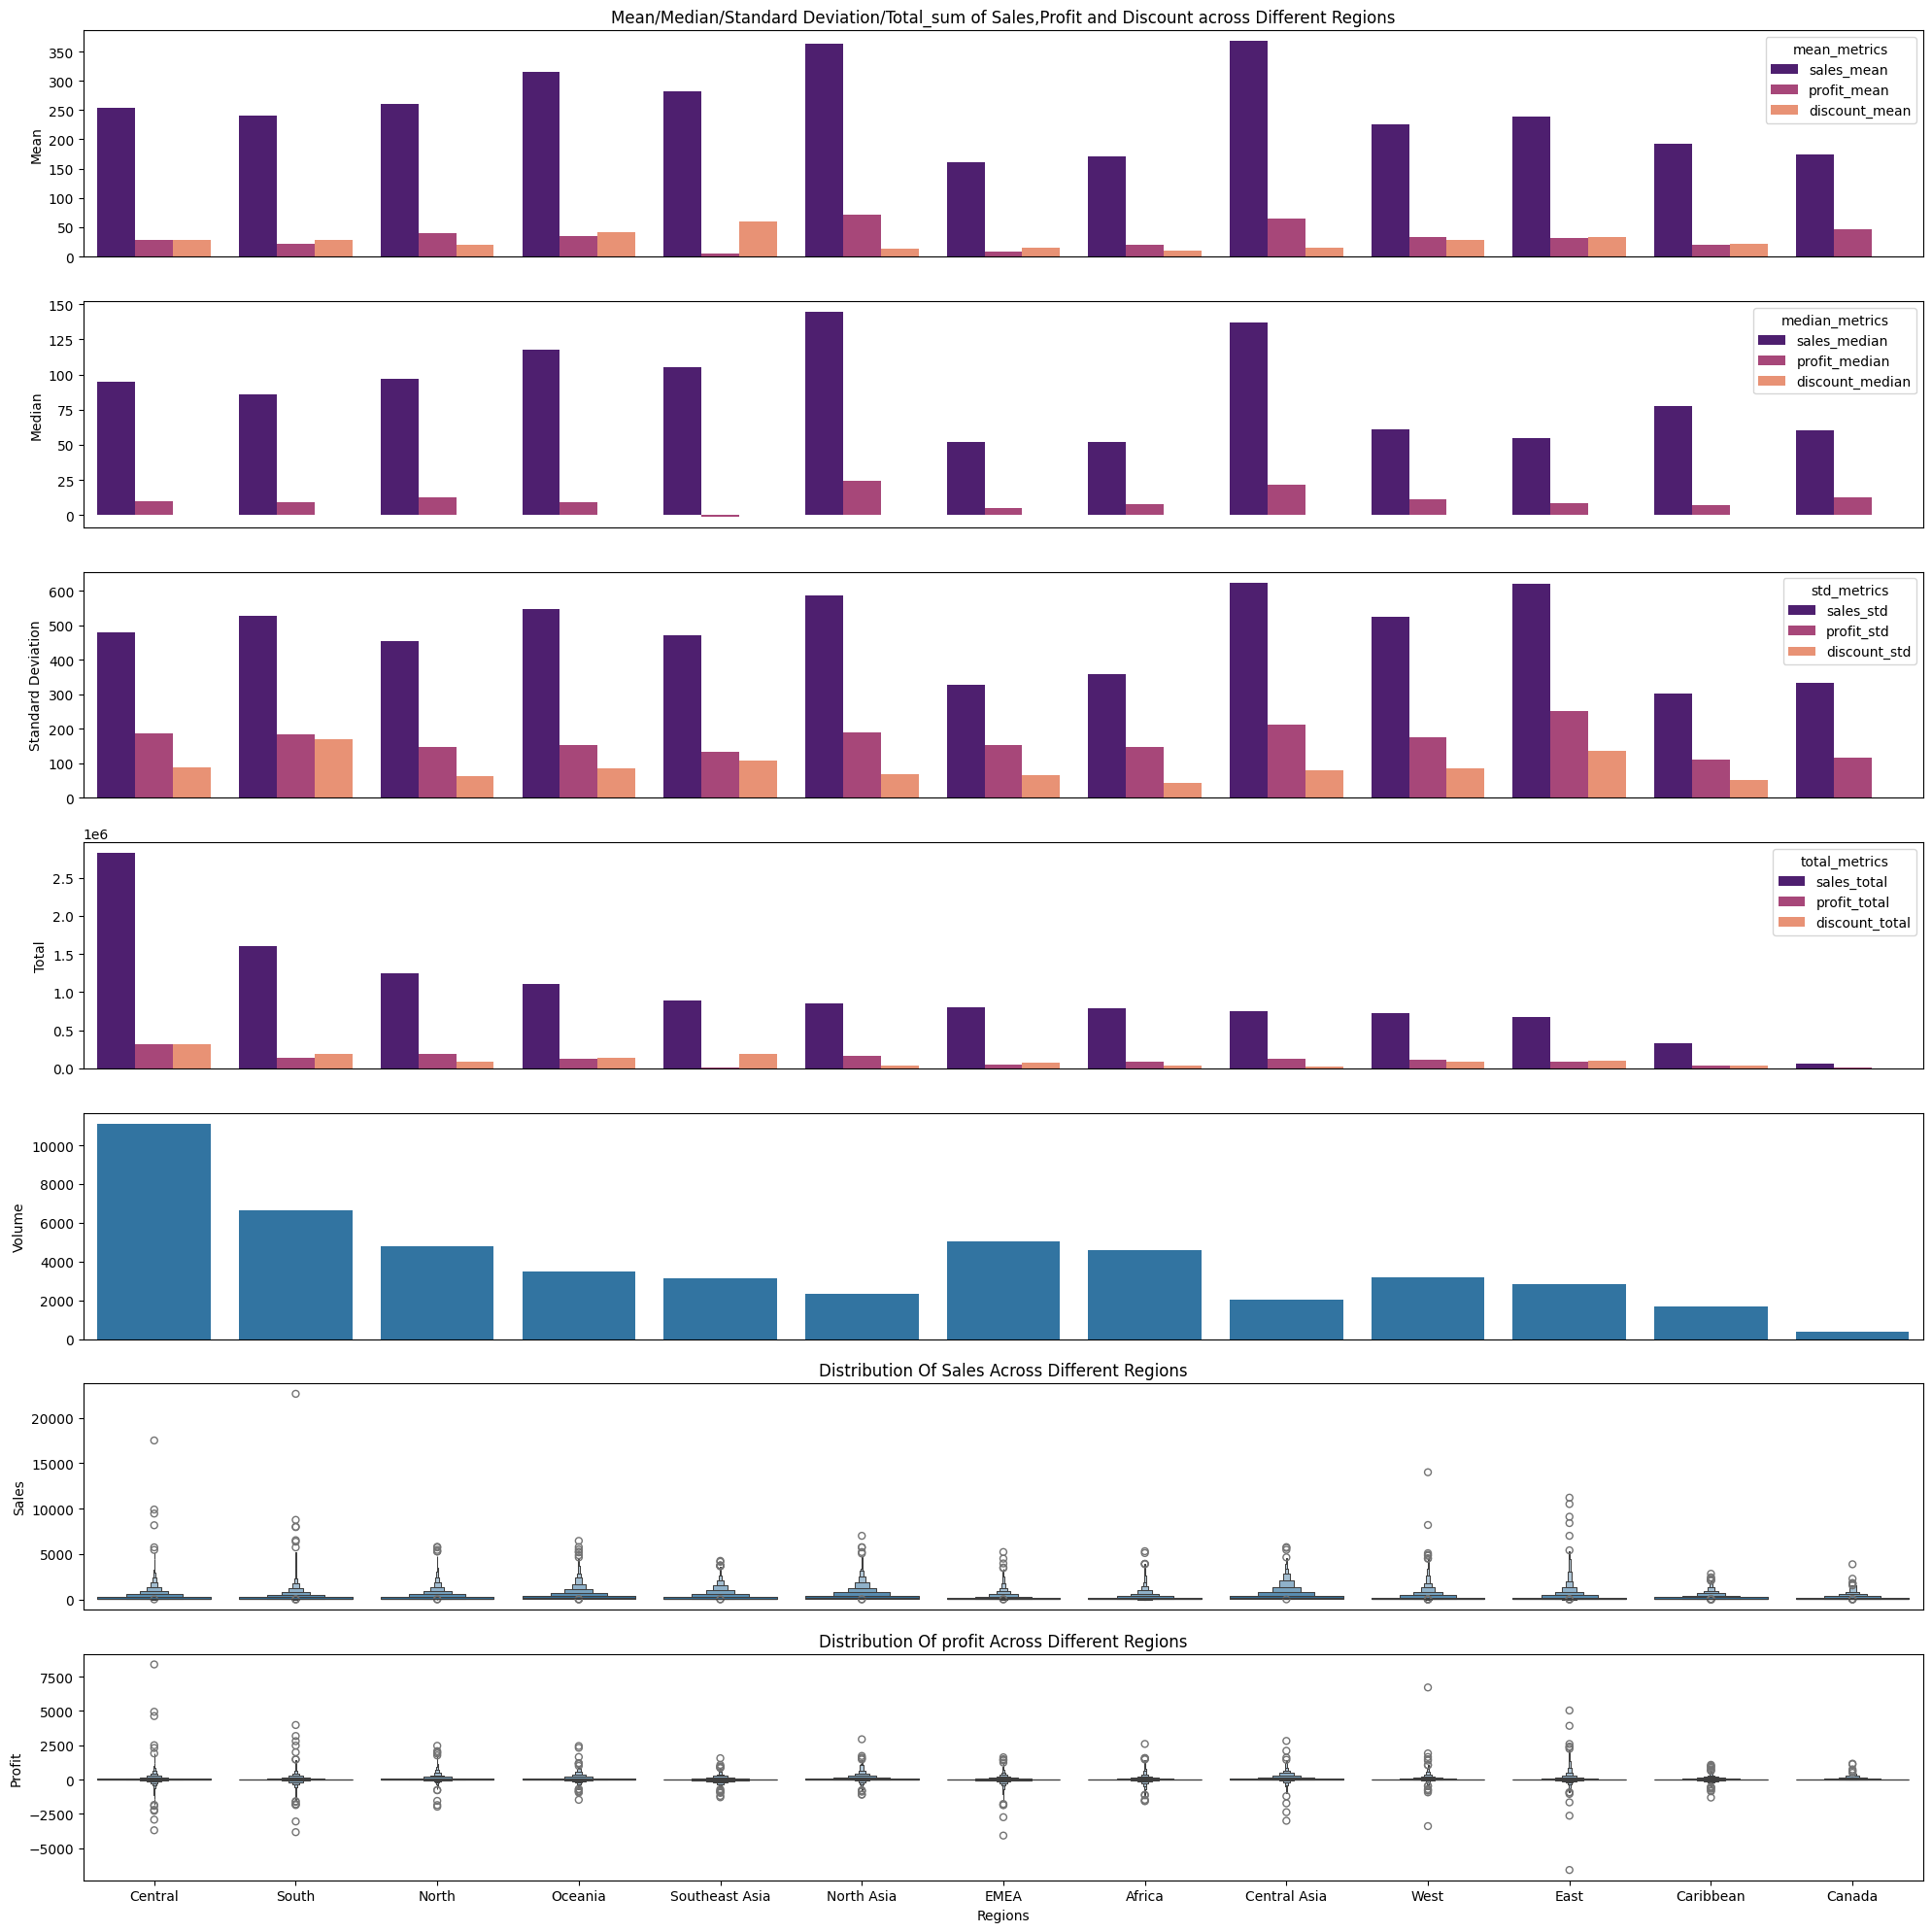

In [293]:
plt.figure(figsize=(20,20))
order=region_agg['region'].to_list()

plt.subplot(7,1,1)
sns.barplot(data=region_melted,x='region',y='mean_values',hue='mean_metrics',order=order,palette='magma')
plt.title('Mean/Median/Standard Deviation/Total_sum of Sales,Profit and Discount across Different Regions')
plt.xlabel('')
plt.ylabel('Mean')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,2)
sns.barplot(data=region_melted,x='region',y='median_values',hue='median_metrics',order=order,palette='magma')
plt.xlabel('')
plt.ylabel('Median')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,3)
sns.barplot(data=region_melted,x='region',y='std_values',hue='std_metrics',order=order,palette='magma')
plt.xlabel('')
plt.ylabel('Standard Deviation')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,4)
sns.barplot(data=region_melted,x='region',y='total_values',hue='total_metrics',order=order,palette='magma')
plt.xlabel('')
plt.ylabel('Total')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,5)
sns.barplot(data=region_agg,x='region',y='order_count',order=order)
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks([])
plt.tight_layout()


plt.subplot(7,1,6)
sns.boxenplot(data=df,x='region',y='sales',order=order)
plt.title('Distribution Of Sales Across Different Regions')
plt.xlabel('')
plt.ylabel('Sales')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,7)
sns.boxenplot(data=df,x='region',y='profit',order=order)
plt.title('Distribution Of profit Across Different Regions')
plt.xlabel('Regions')
plt.ylabel('Profit')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

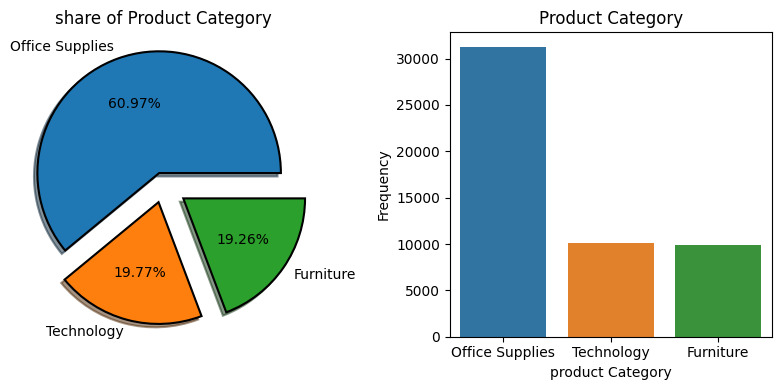

In [296]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.pie(x=df['category'].value_counts(),
        labels=df['category'].value_counts().index,
        autopct='%1.2f%%',
        explode=np.linspace(0.1,0.2,len(df['category'].unique())),
        shadow=True,
        wedgeprops={'linewidth':1.5,'edgecolor':'black'})
plt.title('share of Product Category')
plt.tight_layout()

plt.subplot(1,2,2)
sns.barplot(x=df['category'].value_counts().index,
            y=df['category'].value_counts().values,
            hue=df['category'].value_counts().index)
plt.title('Product Category')
plt.xlabel('product Category')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

- i. Is the Market is not randomly spread across all Regions?
    - Total Sales & Volume differ a lot by region.
    - Some regions like Central, South, North, West, East have:
    - Much higher total sales
    - Much higher order volume
    - Others like Canada, Caribbean, Africa are much smaller.
- Conclusion :
The market is unevenly distributed across regions. A few regions contribute most of the sales and orders, while several regions have low activity. This indicates regional concentration rather than random spread.

In [297]:
country_agg

country  sales_mean  profit_mean  discount_mean  sales_median  \
139     United States  229.873324    28.656896      32.278464          54.5   
6           Australia  326.139232    36.625814      42.913676         125.0   
44             France  303.830916    38.567033      34.475805         131.0   
26              China  372.654787    80.150577       8.793404         147.0   
47            Germany  304.531235    51.972310      22.156465         127.0   
..                ...         ...          ...            ...           ...   
146          Zimbabwe   47.087500   -67.859813      32.961250          16.5   
98   Papua New Guinea  133.090909   -19.027500      37.977273          48.5   
144             Yemen   82.133333  -123.548600      57.493333          27.5   
134      Turkmenistan   81.160000  -132.108360      56.812000          29.0   
135            Uganda   43.918919   -65.569865      30.743243          18.0   

     profit_median  discount_median   sales_std  profit_std  discount_std  \
139         8.6665              0.2  623.248946  234.260108    164.024386   
6           9.4050              0.1  553.287701  150.195825     88.274950   
44         16.4400              0.0  466.927919  138.327805     83.304568   
26         28.2750              0.0  583.648629  173.441537     63.010811   
47         19.3200              0.0  479.429293  159.903897     76.998989   
..             ...              ...         ...         ...           ...   
146       -27.8670              0.7   90.081847  135.871779     63.057293   
98         -8.9700              0.5  244.285335   59.270313     49.786314   
144       -52.6275              0.7  140.323698  182.539824     98.226589   
134       -47.1660              0.7  103.358873  175.417076     72.351211   
135       -31.1910              0.7   48.908292   89.251371     34.235804   

     sales_total  profit_total  discount_total  order_count  
139      2297354   286397.0217       322590.97         9994  
6         925257   103907.4330       121746.10         2837  
44        858930   109029.0030        97463.10         2827  
26        700591   150683.0850        16531.60         1880  
47        628857   107322.8205        45753.10         2065  
..           ...           ...             ...          ...  
146         3767    -5428.7850         2636.90           80  
98          2928     -418.6050          835.50           22  
144         2464    -3706.4580         1724.80           30  
134         2029    -3302.7090         1420.30           25  
135         1625    -2426.0850         1137.50           37  

[110 rows x 14 columns]

In [298]:
country_melted=merge_melted(df=country_agg,common_cols=['country'],no_of_melts=4,list_tuples_variables=[('sales_mean','profit_mean','discount_mean','mean_metrics','mean_values'),
                                                                                       ('sales_median','profit_median','discount_median','median_metrics','median_values'),
                                                                                       ('sales_std','profit_std','discount_std','std_metrics','std_values'),
                                                                                       ('sales_total','profit_total','discount_total','total_metrics','total_values')])

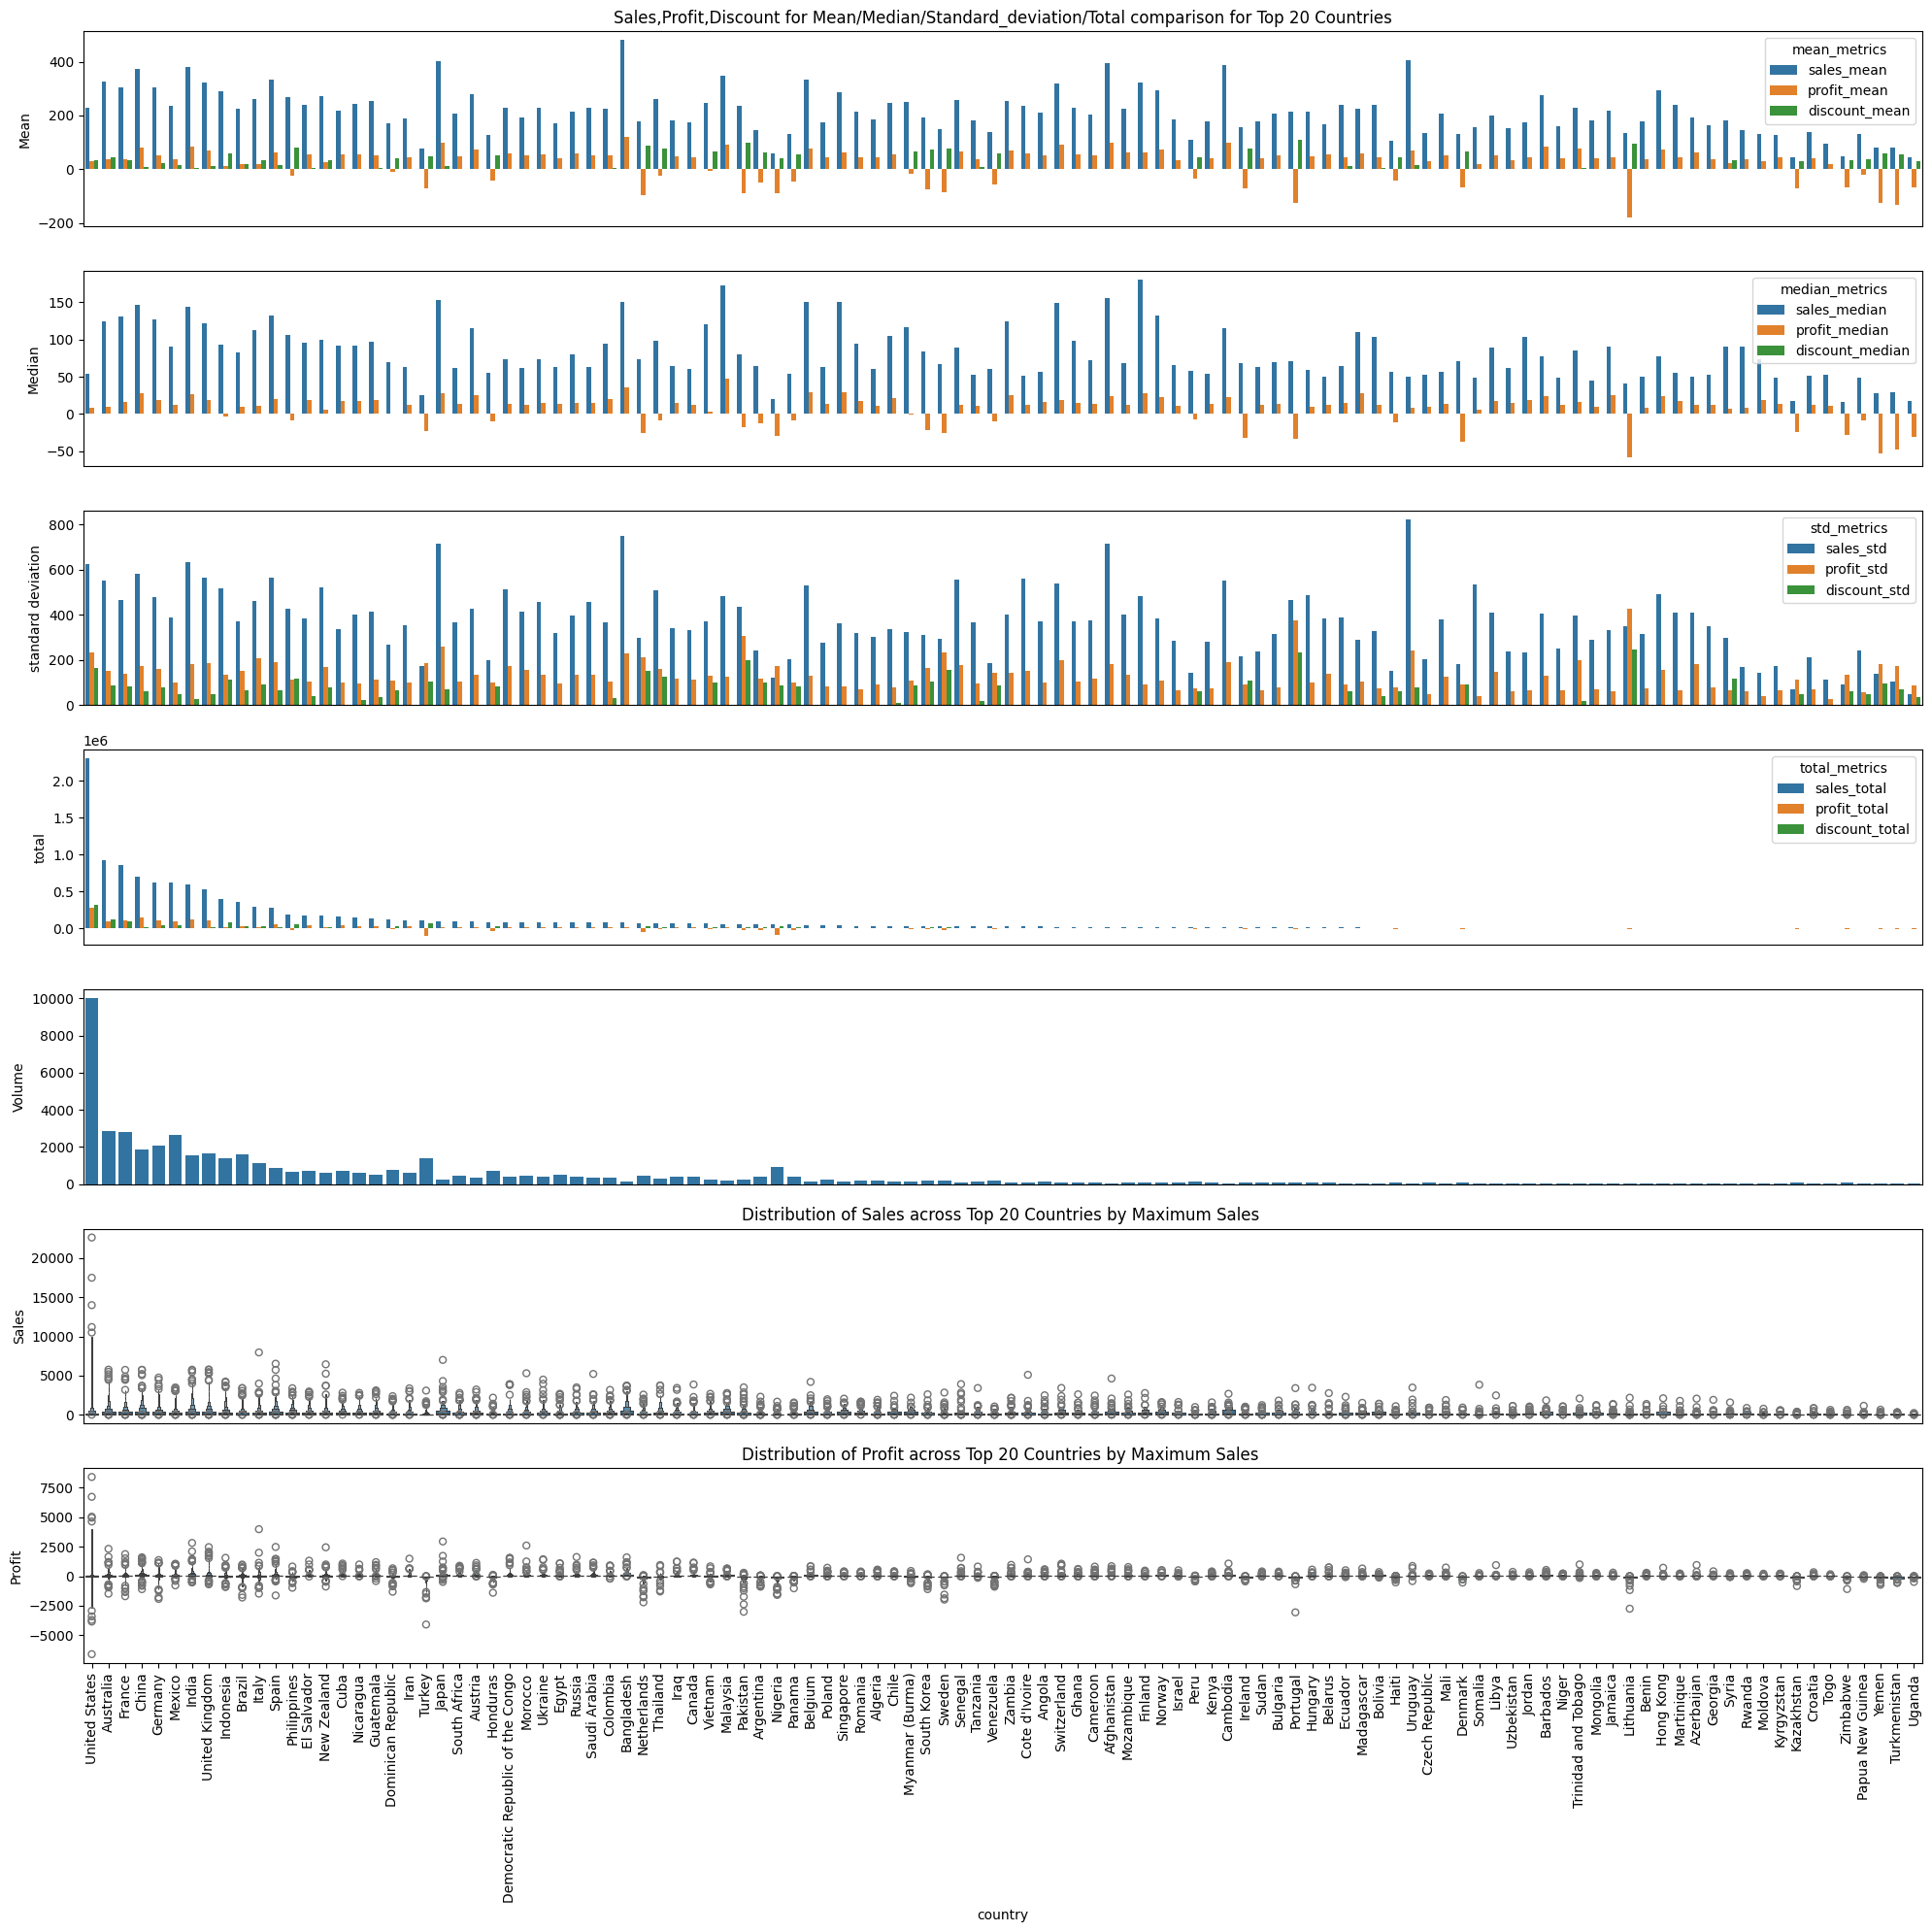

In [299]:
plt.figure(figsize=(20,20))
order=country_agg.sort_values(by=['sales_total'],ascending=False)['country'].to_list()
plt.subplot(7,1,1)
sns.barplot(data=country_melted,x='country',y='mean_values',hue='mean_metrics',palette='tab10',order=order)
plt.title('Sales,Profit,Discount for Mean/Median/Standard_deviation/Total comparison for Top 20 Countries')
plt.xlabel('')
plt.ylabel('Mean')
plt.xticks([])

plt.subplot(7,1,2)
sns.barplot(data=country_melted,x='country',y='median_values',hue='median_metrics',palette='tab10',order=order)
plt.xlabel('')
plt.ylabel('Median')
plt.xticks([])

plt.subplot(7,1,3)
sns.barplot(data=country_melted,x='country',y='std_values',hue='std_metrics',palette='tab10',order=order)
plt.xlabel('')
plt.ylabel('standard deviation')
plt.xticks([])

plt.subplot(7,1,4)
sns.barplot(data=country_melted,x='country',y='total_values',hue='total_metrics',palette='tab10',order=order)
plt.xlabel('')
plt.ylabel('total')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,5)
sns.barplot(data=country_agg,x='country',y='order_count',order=order)
plt.xlabel('')
plt.ylabel('Volume')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,6)
sns.boxenplot(data=df[df['country'].isin(country_agg['country'])],
            y='sales',
            x='country',
            order=order)
plt.title('Distribution of Sales across Top 20 Countries by Maximum Sales ')
plt.ylabel('Sales')
plt.xlabel('')
plt.xticks([])
plt.tight_layout()

plt.subplot(7,1,7)
sns.boxenplot(data=df[df['country'].isin(country_agg['country'])],
            y='profit',
            x='country',
            order=order)
plt.title('Distribution of Profit across Top 20 Countries by Maximum Sales ')
plt.ylabel('Profit')
plt.xlabel('country')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

In [302]:
df['category'].unique()

array(['Office Supplies', 'Technology', 'Furniture'], dtype=object)

In [311]:
os_country_order_vol=df[df['category']=='Office Supplies'].groupby(['country'],as_index=False).agg(volume=('country','count')).sort_values(by=['volume'])
os_country_order_vol[os_country_order_vol['volume']<=5]

country  volume
5                     Armenia       1
9                     Bahrain       1
39                    Eritrea       1
120                 Swaziland       1
38          Equatorial Guinea       2
48                 Guadeloupe       2
70                    Lesotho       2
23                       Chad       2
125                Tajikistan       2
113                  Slovenia       2
74                  Macedonia       3
104     Republic of the Congo       3
83                 Montenegro       3
69                    Lebanon       4
98                   Paraguay       4
51              Guinea-Bissau       5
118                 Sri Lanka       5
22   Central African Republic       5

- ii. Which country has negligible office supply orders?
    - Armenia,Bahrain,Eritrea,Swaziland etc etc and all above from the above List

- iii. What are the most useful insights?
    - Sales and profits are concentrated in a few major regions, creating dependency risk.
    - Profit shows high variability and frequent negative outliers across regions.
    - Office Supplies dominate product distribution, indicating reliance on low-margin products.
    - A small number of countries contribute most revenue, following the Pareto principle.
    - High discount levels in many regions may be negatively impacting profitability.